best results so far:

learning_rate = 0.0001
epochs_ini = 9000
batch_size = 700
layer_list=[10,15,10]

In [1]:
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np


from tensorflow.keras.layers import LSTM
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
tf.test.is_gpu_available()


H:\Users\Gwydion\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
H:\Users\Gwydion\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
H:\Users\Gwydion\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
H:\Users\Gwydion\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [2]:
df_spectra=pd.read_csv("spectrum_energy_intensity2.csv",index_col=[0])
df_spectra.head(-50)

,Energy,Intensity,k6a1,k6a2,k11,k12,k9a1,k9a2
0,0.874,0.019935,0.25,0.25,0.25,0.25,0.25,0.25
1,0.213,0.060488,0.25,0.25,0.25,0.25,0.25,0.50
2,0.866,0.020153,0.25,0.25,0.25,0.25,0.25,0.75
3,0.867,0.019641,0.25,0.25,0.25,0.25,0.50,0.25
4,0.220,0.060471,0.25,0.25,0.25,0.25,0.50,0.50
...,...,...,...,...,...,...,...,...
674,0.868,0.021991,0.75,0.75,0.25,0.75,0.75,0.75
675,0.865,0.021101,0.75,0.75,0.50,0.25,0.25,0.25
676,0.213,0.060723,0.75,0.75,0.50,0.25,0.25,0.50
677,0.868,0.019078,0.75,0.75,0.50,0.25,0.25,0.75


In [3]:
numpy_input=df_spectra[["k6a1","k6a2","k11","k12","k9a1","k9a2"]].to_numpy()
numpy_energy_intensity=df_spectra[["Energy","Intensity"]].to_numpy()


df_complete=pd.DataFrame(numpy_energy_intensity)
df_training=df_spectra.sample(frac=0.8,random_state=20)
df_testing=df_spectra.drop(df_training.index)

In [4]:
feature_columns_A = []

k6a1 = tf.feature_column.numeric_column("k6a1")
feature_columns_A.append(k6a1)

k6a2 = tf.feature_column.numeric_column("k6a2")
feature_columns_A.append(k6a2)

k11 = tf.feature_column.numeric_column("k11")
feature_columns_A.append(k11)

k12 = tf.feature_column.numeric_column("k12")
feature_columns_A.append(k12)

k9a1 = tf.feature_column.numeric_column("k9a1")
feature_columns_A.append(k9a1)

k9a2 = tf.feature_column.numeric_column("k9a2")
feature_columns_A.append(k9a2)

my_feature_layer_A = tf.keras.layers.DenseFeatures(feature_columns_A)


In [5]:
#define the plotting function.

def plot_the_loss_curve(epochs, mse,mse_val):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")

    plt.plot(epochs, mse, label="Training Loss")
    plt.plot(epochs,mse_val,label="Val Loss")
    plt.legend()
    #plt.ylim([mse.min()*0.95, mse.max() * 1.03])
    plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [69]:
def create_model(my_learning_rate, my_feature_layer,layer_list=[10,12],regulations=1e-4):
    """Create and compile a regression model."""
    model = tf.keras.models.Sequential()
    # Add the layer containing the feature columns to the model.
    model.add(my_feature_layer)

    # Describe the topography of the model by calling the tf.keras.layers.Dense
    # method once for each layer. We've specified the following arguments:
    #   * units specifies the number of nodes in this layer.
    #   * activation specifies the activation function (Rectified Linear Unit).
    #   * name is just a string that can be useful when debugging.

    # Define the first hidden layer with 10 nodes.   
    for n in layer_list:
        print(n)
        model.add(tf.keras.layers.Dense(units=n, activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l2(regulations),name='Hidden'+str(n)))
                
   
   

    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=1,  
                                    name='Output'))                              
  
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="MAE",
                metrics="mae")
    return model



In [70]:
def train_model(model, dataset, epochs, label_name,
                batch_size=None):
    """Train the model by feeding it data."""

    # Split the dataset into features and label.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=1,validation_split=0.2) 

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch
  
    # To track the progression of training, gather a snapshot
    # of the model's mean squared error at each epoch. 
    hist = pd.DataFrame(history.history)
    mse = hist["MAE"]
    val_mse = hist["val_MAE"]

    return epochs, mse, val_mse

In [76]:
%%time
learning_rate = 0.01
epochs_ini = 10000
batch_size = 350

# Specify the label (this will be the output variable)
label_name = "Energy"

#try different things:

my_model = create_model(learning_rate, my_feature_layer_A,layer_list=[60,165],regulations=0)

epochs, mse,val_mse = train_model(my_model, df_training, epochs_ini, 
                          label_name, batch_size)



60
165
Epoch 1/10000
2/2 [==============================] - ETA: 0s - loss: 0.5616 - mae: 0.561 - 0s 47ms/step - loss: 0.5005 - mae: 0.5005 - val_loss: 0.4032 - val_mae: 0.4032
Epoch 2/10000
2/2 [==============================] - ETA: 0s - loss: 0.4362 - mae: 0.436 - 0s 13ms/step - loss: 0.4122 - mae: 0.4122 - val_loss: 0.2983 - val_mae: 0.2983
Epoch 3/10000
2/2 [==============================] - ETA: 0s - loss: 0.3070 - mae: 0.307 - 0s 13ms/step - loss: 0.3074 - mae: 0.3074 - val_loss: 0.3124 - val_mae: 0.3124
Epoch 4/10000
2/2 [==============================] - ETA: 0s - loss: 0.3093 - mae: 0.309 - 0s 13ms/step - loss: 0.3155 - mae: 0.3155 - val_loss: 0.3275 - val_mae: 0.3275
Epoch 5/10000
2/2 [==============================] - ETA: 0s - loss: 0.3259 - mae: 0.325 - 0s 14ms/step - loss: 0.3228 - mae: 0.3228 - val_loss: 0.3308 - val_mae: 0.3308
Epoch 6/10000
2/2 [==============================] - ETA: 0s - loss: 0.3236 - mae: 0.323 - 0s 13ms/step - loss: 0.3238 - mae: 0.3238 - val_loss

Epoch 49/10000
2/2 [==============================] - ETA: 0s - loss: 0.1937 - mae: 0.193 - 0s 16ms/step - loss: 0.2008 - mae: 0.2008 - val_loss: 0.2225 - val_mae: 0.2225
Epoch 50/10000
2/2 [==============================] - ETA: 0s - loss: 0.1978 - mae: 0.197 - 0s 13ms/step - loss: 0.1965 - mae: 0.1965 - val_loss: 0.2169 - val_mae: 0.2169
Epoch 51/10000
2/2 [==============================] - ETA: 0s - loss: 0.1899 - mae: 0.189 - 0s 13ms/step - loss: 0.1906 - mae: 0.1906 - val_loss: 0.2158 - val_mae: 0.2158
Epoch 52/10000
2/2 [==============================] - ETA: 0s - loss: 0.1908 - mae: 0.190 - 0s 14ms/step - loss: 0.1890 - mae: 0.1890 - val_loss: 0.2183 - val_mae: 0.2183
Epoch 53/10000
2/2 [==============================] - ETA: 0s - loss: 0.1938 - mae: 0.193 - 0s 13ms/step - loss: 0.1864 - mae: 0.1864 - val_loss: 0.2168 - val_mae: 0.2168
Epoch 54/10000
2/2 [==============================] - ETA: 0s - loss: 0.1842 - mae: 0.184 - 0s 14ms/step - loss: 0.1845 - mae: 0.1845 - val_loss:

Epoch 97/10000
2/2 [==============================] - ETA: 0s - loss: 0.1625 - mae: 0.162 - 0s 13ms/step - loss: 0.1591 - mae: 0.1591 - val_loss: 0.1938 - val_mae: 0.1938
Epoch 98/10000
2/2 [==============================] - ETA: 0s - loss: 0.1590 - mae: 0.159 - 0s 13ms/step - loss: 0.1581 - mae: 0.1581 - val_loss: 0.1939 - val_mae: 0.1939
Epoch 99/10000
2/2 [==============================] - ETA: 0s - loss: 0.1554 - mae: 0.155 - 0s 15ms/step - loss: 0.1535 - mae: 0.1535 - val_loss: 0.2024 - val_mae: 0.2024
Epoch 100/10000
2/2 [==============================] - ETA: 0s - loss: 0.1544 - mae: 0.154 - 0s 13ms/step - loss: 0.1560 - mae: 0.1560 - val_loss: 0.1983 - val_mae: 0.1983
Epoch 101/10000
2/2 [==============================] - ETA: 0s - loss: 0.1596 - mae: 0.159 - 0s 13ms/step - loss: 0.1548 - mae: 0.1548 - val_loss: 0.1959 - val_mae: 0.1959
Epoch 102/10000
2/2 [==============================] - ETA: 0s - loss: 0.1599 - mae: 0.159 - 0s 13ms/step - loss: 0.1543 - mae: 0.1543 - val_lo

Epoch 145/10000
2/2 [==============================] - ETA: 0s - loss: 0.1374 - mae: 0.137 - 0s 13ms/step - loss: 0.1412 - mae: 0.1412 - val_loss: 0.1879 - val_mae: 0.1879
Epoch 146/10000
2/2 [==============================] - ETA: 0s - loss: 0.1433 - mae: 0.143 - 0s 13ms/step - loss: 0.1451 - mae: 0.1451 - val_loss: 0.1805 - val_mae: 0.1805
Epoch 147/10000
2/2 [==============================] - ETA: 0s - loss: 0.1472 - mae: 0.147 - 0s 13ms/step - loss: 0.1425 - mae: 0.1425 - val_loss: 0.1793 - val_mae: 0.1793
Epoch 148/10000
2/2 [==============================] - ETA: 0s - loss: 0.1405 - mae: 0.140 - 0s 13ms/step - loss: 0.1401 - mae: 0.1401 - val_loss: 0.1823 - val_mae: 0.1823
Epoch 149/10000
2/2 [==============================] - ETA: 0s - loss: 0.1415 - mae: 0.141 - 0s 13ms/step - loss: 0.1410 - mae: 0.1410 - val_loss: 0.1811 - val_mae: 0.1811
Epoch 150/10000
2/2 [==============================] - ETA: 0s - loss: 0.1464 - mae: 0.146 - 0s 15ms/step - loss: 0.1424 - mae: 0.1424 - val

Epoch 193/10000
2/2 [==============================] - ETA: 0s - loss: 0.1416 - mae: 0.141 - 0s 13ms/step - loss: 0.1422 - mae: 0.1422 - val_loss: 0.1727 - val_mae: 0.1727
Epoch 194/10000
2/2 [==============================] - ETA: 0s - loss: 0.1288 - mae: 0.128 - 0s 15ms/step - loss: 0.1363 - mae: 0.1363 - val_loss: 0.1653 - val_mae: 0.1653
Epoch 195/10000
2/2 [==============================] - ETA: 0s - loss: 0.1261 - mae: 0.126 - 0s 13ms/step - loss: 0.1309 - mae: 0.1309 - val_loss: 0.1626 - val_mae: 0.1626
Epoch 196/10000
2/2 [==============================] - ETA: 0s - loss: 0.1077 - mae: 0.107 - 0s 13ms/step - loss: 0.1270 - mae: 0.1270 - val_loss: 0.1647 - val_mae: 0.1647
Epoch 197/10000
2/2 [==============================] - ETA: 0s - loss: 0.1267 - mae: 0.126 - 0s 13ms/step - loss: 0.1301 - mae: 0.1301 - val_loss: 0.1643 - val_mae: 0.1643
Epoch 198/10000
2/2 [==============================] - ETA: 0s - loss: 0.1209 - mae: 0.120 - 0s 12ms/step - loss: 0.1261 - mae: 0.1261 - val

Epoch 241/10000
2/2 [==============================] - ETA: 0s - loss: 0.0887 - mae: 0.088 - 0s 14ms/step - loss: 0.0955 - mae: 0.0955 - val_loss: 0.1087 - val_mae: 0.1087
Epoch 242/10000
2/2 [==============================] - ETA: 0s - loss: 0.0835 - mae: 0.083 - 0s 15ms/step - loss: 0.0908 - mae: 0.0908 - val_loss: 0.1150 - val_mae: 0.1150
Epoch 243/10000
2/2 [==============================] - ETA: 0s - loss: 0.0980 - mae: 0.098 - 0s 15ms/step - loss: 0.0953 - mae: 0.0953 - val_loss: 0.1065 - val_mae: 0.1065
Epoch 244/10000
2/2 [==============================] - ETA: 0s - loss: 0.0917 - mae: 0.091 - 0s 15ms/step - loss: 0.0896 - mae: 0.0896 - val_loss: 0.1047 - val_mae: 0.1047
Epoch 245/10000
2/2 [==============================] - ETA: 0s - loss: 0.0861 - mae: 0.086 - 0s 13ms/step - loss: 0.0862 - mae: 0.0862 - val_loss: 0.0992 - val_mae: 0.0992
Epoch 246/10000
2/2 [==============================] - ETA: 0s - loss: 0.0794 - mae: 0.079 - 0s 13ms/step - loss: 0.0856 - mae: 0.0856 - val

Epoch 289/10000
2/2 [==============================] - ETA: 0s - loss: 0.0553 - mae: 0.055 - 0s 13ms/step - loss: 0.0524 - mae: 0.0524 - val_loss: 0.0581 - val_mae: 0.0581
Epoch 290/10000
2/2 [==============================] - ETA: 0s - loss: 0.0599 - mae: 0.059 - 0s 13ms/step - loss: 0.0576 - mae: 0.0576 - val_loss: 0.0664 - val_mae: 0.0664
Epoch 291/10000
2/2 [==============================] - ETA: 0s - loss: 0.0562 - mae: 0.056 - 0s 13ms/step - loss: 0.0598 - mae: 0.0598 - val_loss: 0.0653 - val_mae: 0.0653
Epoch 292/10000
2/2 [==============================] - ETA: 0s - loss: 0.0582 - mae: 0.058 - 0s 13ms/step - loss: 0.0535 - mae: 0.0535 - val_loss: 0.0766 - val_mae: 0.0766
Epoch 293/10000
2/2 [==============================] - ETA: 0s - loss: 0.0744 - mae: 0.074 - 0s 13ms/step - loss: 0.0647 - mae: 0.0647 - val_loss: 0.0459 - val_mae: 0.0459
Epoch 294/10000
2/2 [==============================] - ETA: 0s - loss: 0.0441 - mae: 0.044 - 0s 13ms/step - loss: 0.0471 - mae: 0.0471 - val

Epoch 337/10000
2/2 [==============================] - ETA: 0s - loss: 0.0548 - mae: 0.054 - 0s 13ms/step - loss: 0.0525 - mae: 0.0525 - val_loss: 0.0734 - val_mae: 0.0734
Epoch 338/10000
2/2 [==============================] - ETA: 0s - loss: 0.0653 - mae: 0.065 - 0s 13ms/step - loss: 0.0645 - mae: 0.0645 - val_loss: 0.0731 - val_mae: 0.0731
Epoch 339/10000
2/2 [==============================] - ETA: 0s - loss: 0.0656 - mae: 0.065 - 0s 15ms/step - loss: 0.0666 - mae: 0.0666 - val_loss: 0.0508 - val_mae: 0.0508
Epoch 340/10000
2/2 [==============================] - ETA: 0s - loss: 0.0497 - mae: 0.049 - 0s 12ms/step - loss: 0.0540 - mae: 0.0540 - val_loss: 0.0565 - val_mae: 0.0565
Epoch 341/10000
2/2 [==============================] - ETA: 0s - loss: 0.0530 - mae: 0.053 - 0s 13ms/step - loss: 0.0610 - mae: 0.0610 - val_loss: 0.0837 - val_mae: 0.0837
Epoch 342/10000
2/2 [==============================] - ETA: 0s - loss: 0.0792 - mae: 0.079 - 0s 13ms/step - loss: 0.0732 - mae: 0.0732 - val

Epoch 385/10000
2/2 [==============================] - ETA: 0s - loss: 0.0504 - mae: 0.050 - 0s 13ms/step - loss: 0.0467 - mae: 0.0467 - val_loss: 0.0504 - val_mae: 0.0504
Epoch 386/10000
2/2 [==============================] - ETA: 0s - loss: 0.0475 - mae: 0.047 - 0s 13ms/step - loss: 0.0461 - mae: 0.0461 - val_loss: 0.0542 - val_mae: 0.0542
Epoch 387/10000
2/2 [==============================] - ETA: 0s - loss: 0.0485 - mae: 0.048 - 0s 14ms/step - loss: 0.0473 - mae: 0.0473 - val_loss: 0.0608 - val_mae: 0.0608
Epoch 388/10000
2/2 [==============================] - ETA: 0s - loss: 0.0552 - mae: 0.055 - 0s 13ms/step - loss: 0.0525 - mae: 0.0525 - val_loss: 0.0543 - val_mae: 0.0543
Epoch 389/10000
2/2 [==============================] - ETA: 0s - loss: 0.0532 - mae: 0.053 - 0s 15ms/step - loss: 0.0504 - mae: 0.0504 - val_loss: 0.0589 - val_mae: 0.0589
Epoch 390/10000
2/2 [==============================] - ETA: 0s - loss: 0.0552 - mae: 0.055 - 0s 13ms/step - loss: 0.0537 - mae: 0.0537 - val

Epoch 433/10000
2/2 [==============================] - ETA: 0s - loss: 0.0445 - mae: 0.044 - 0s 16ms/step - loss: 0.0415 - mae: 0.0415 - val_loss: 0.0528 - val_mae: 0.0528
Epoch 434/10000
2/2 [==============================] - ETA: 0s - loss: 0.0447 - mae: 0.044 - 0s 13ms/step - loss: 0.0439 - mae: 0.0439 - val_loss: 0.0505 - val_mae: 0.0505
Epoch 435/10000
2/2 [==============================] - ETA: 0s - loss: 0.0477 - mae: 0.047 - 0s 13ms/step - loss: 0.0469 - mae: 0.0469 - val_loss: 0.0554 - val_mae: 0.0554
Epoch 436/10000
2/2 [==============================] - ETA: 0s - loss: 0.0525 - mae: 0.052 - 0s 13ms/step - loss: 0.0503 - mae: 0.0503 - val_loss: 0.0461 - val_mae: 0.0461
Epoch 437/10000
2/2 [==============================] - ETA: 0s - loss: 0.0478 - mae: 0.047 - 0s 13ms/step - loss: 0.0425 - mae: 0.0425 - val_loss: 0.0440 - val_mae: 0.0440
Epoch 438/10000
2/2 [==============================] - ETA: 0s - loss: 0.0421 - mae: 0.042 - 0s 13ms/step - loss: 0.0416 - mae: 0.0416 - val

Epoch 481/10000
2/2 [==============================] - ETA: 0s - loss: 0.0403 - mae: 0.040 - 0s 13ms/step - loss: 0.0418 - mae: 0.0418 - val_loss: 0.0409 - val_mae: 0.0409
Epoch 482/10000
2/2 [==============================] - ETA: 0s - loss: 0.0374 - mae: 0.037 - 0s 13ms/step - loss: 0.0387 - mae: 0.0387 - val_loss: 0.0400 - val_mae: 0.0400
Epoch 483/10000
2/2 [==============================] - ETA: 0s - loss: 0.0391 - mae: 0.039 - 0s 15ms/step - loss: 0.0396 - mae: 0.0396 - val_loss: 0.0363 - val_mae: 0.0363
Epoch 484/10000
2/2 [==============================] - ETA: 0s - loss: 0.0377 - mae: 0.037 - 0s 13ms/step - loss: 0.0362 - mae: 0.0362 - val_loss: 0.0417 - val_mae: 0.0417
Epoch 485/10000
2/2 [==============================] - ETA: 0s - loss: 0.0395 - mae: 0.039 - 0s 13ms/step - loss: 0.0397 - mae: 0.0397 - val_loss: 0.0482 - val_mae: 0.0482
Epoch 486/10000
2/2 [==============================] - ETA: 0s - loss: 0.0370 - mae: 0.037 - 0s 13ms/step - loss: 0.0427 - mae: 0.0427 - val

Epoch 529/10000
2/2 [==============================] - ETA: 0s - loss: 0.0447 - mae: 0.044 - 0s 13ms/step - loss: 0.0434 - mae: 0.0434 - val_loss: 0.0582 - val_mae: 0.0582
Epoch 530/10000
2/2 [==============================] - ETA: 0s - loss: 0.0547 - mae: 0.054 - 0s 13ms/step - loss: 0.0521 - mae: 0.0521 - val_loss: 0.0524 - val_mae: 0.0524
Epoch 531/10000
2/2 [==============================] - ETA: 0s - loss: 0.0554 - mae: 0.055 - 0s 13ms/step - loss: 0.0502 - mae: 0.0502 - val_loss: 0.0497 - val_mae: 0.0497
Epoch 532/10000
2/2 [==============================] - ETA: 0s - loss: 0.0419 - mae: 0.041 - 0s 13ms/step - loss: 0.0465 - mae: 0.0465 - val_loss: 0.0473 - val_mae: 0.0473
Epoch 533/10000
2/2 [==============================] - ETA: 0s - loss: 0.0443 - mae: 0.044 - 0s 13ms/step - loss: 0.0443 - mae: 0.0443 - val_loss: 0.0460 - val_mae: 0.0460
Epoch 534/10000
2/2 [==============================] - ETA: 0s - loss: 0.0469 - mae: 0.046 - 0s 15ms/step - loss: 0.0454 - mae: 0.0454 - val

Epoch 577/10000
2/2 [==============================] - ETA: 0s - loss: 0.0463 - mae: 0.046 - 0s 15ms/step - loss: 0.0418 - mae: 0.0418 - val_loss: 0.0419 - val_mae: 0.0419
Epoch 578/10000
2/2 [==============================] - ETA: 0s - loss: 0.0454 - mae: 0.045 - 0s 13ms/step - loss: 0.0386 - mae: 0.0386 - val_loss: 0.0472 - val_mae: 0.0472
Epoch 579/10000
2/2 [==============================] - ETA: 0s - loss: 0.0440 - mae: 0.044 - 0s 13ms/step - loss: 0.0442 - mae: 0.0442 - val_loss: 0.0613 - val_mae: 0.0613
Epoch 580/10000
2/2 [==============================] - ETA: 0s - loss: 0.0528 - mae: 0.052 - 0s 13ms/step - loss: 0.0513 - mae: 0.0513 - val_loss: 0.0453 - val_mae: 0.0453
Epoch 581/10000
2/2 [==============================] - ETA: 0s - loss: 0.0467 - mae: 0.046 - 0s 13ms/step - loss: 0.0457 - mae: 0.0457 - val_loss: 0.0432 - val_mae: 0.0432
Epoch 582/10000
2/2 [==============================] - ETA: 0s - loss: 0.0398 - mae: 0.039 - 0s 13ms/step - loss: 0.0404 - mae: 0.0404 - val

Epoch 625/10000
2/2 [==============================] - ETA: 0s - loss: 0.0321 - mae: 0.032 - 0s 14ms/step - loss: 0.0346 - mae: 0.0346 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 626/10000
2/2 [==============================] - ETA: 0s - loss: 0.0330 - mae: 0.033 - 0s 15ms/step - loss: 0.0339 - mae: 0.0339 - val_loss: 0.0373 - val_mae: 0.0373
Epoch 627/10000
2/2 [==============================] - ETA: 0s - loss: 0.0355 - mae: 0.035 - 0s 14ms/step - loss: 0.0334 - mae: 0.0334 - val_loss: 0.0359 - val_mae: 0.0359
Epoch 628/10000
2/2 [==============================] - ETA: 0s - loss: 0.0384 - mae: 0.038 - 0s 19ms/step - loss: 0.0337 - mae: 0.0337 - val_loss: 0.0366 - val_mae: 0.0366
Epoch 629/10000
2/2 [==============================] - ETA: 0s - loss: 0.0374 - mae: 0.037 - 0s 15ms/step - loss: 0.0348 - mae: 0.0348 - val_loss: 0.0340 - val_mae: 0.0340
Epoch 630/10000
2/2 [==============================] - ETA: 0s - loss: 0.0300 - mae: 0.030 - 0s 16ms/step - loss: 0.0326 - mae: 0.0326 - val

Epoch 673/10000
2/2 [==============================] - ETA: 0s - loss: 0.0355 - mae: 0.035 - 0s 13ms/step - loss: 0.0376 - mae: 0.0376 - val_loss: 0.0411 - val_mae: 0.0411
Epoch 674/10000
2/2 [==============================] - ETA: 0s - loss: 0.0361 - mae: 0.036 - 0s 13ms/step - loss: 0.0382 - mae: 0.0382 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 675/10000
2/2 [==============================] - ETA: 0s - loss: 0.0383 - mae: 0.038 - 0s 14ms/step - loss: 0.0362 - mae: 0.0362 - val_loss: 0.0383 - val_mae: 0.0383
Epoch 676/10000
2/2 [==============================] - ETA: 0s - loss: 0.0380 - mae: 0.038 - 0s 13ms/step - loss: 0.0357 - mae: 0.0357 - val_loss: 0.0431 - val_mae: 0.0431
Epoch 677/10000
2/2 [==============================] - ETA: 0s - loss: 0.0394 - mae: 0.039 - 0s 13ms/step - loss: 0.0385 - mae: 0.0385 - val_loss: 0.0372 - val_mae: 0.0372
Epoch 678/10000
2/2 [==============================] - ETA: 0s - loss: 0.0326 - mae: 0.032 - 0s 13ms/step - loss: 0.0351 - mae: 0.0351 - val

Epoch 721/10000
2/2 [==============================] - ETA: 0s - loss: 0.0376 - mae: 0.037 - 0s 13ms/step - loss: 0.0341 - mae: 0.0341 - val_loss: 0.0412 - val_mae: 0.0412
Epoch 722/10000
2/2 [==============================] - ETA: 0s - loss: 0.0379 - mae: 0.037 - 0s 15ms/step - loss: 0.0379 - mae: 0.0379 - val_loss: 0.0386 - val_mae: 0.0386
Epoch 723/10000
2/2 [==============================] - ETA: 0s - loss: 0.0382 - mae: 0.038 - 0s 14ms/step - loss: 0.0361 - mae: 0.0361 - val_loss: 0.0380 - val_mae: 0.0380
Epoch 724/10000
2/2 [==============================] - ETA: 0s - loss: 0.0406 - mae: 0.040 - 0s 13ms/step - loss: 0.0362 - mae: 0.0362 - val_loss: 0.0516 - val_mae: 0.0516
Epoch 725/10000
2/2 [==============================] - ETA: 0s - loss: 0.0515 - mae: 0.051 - 0s 13ms/step - loss: 0.0445 - mae: 0.0445 - val_loss: 0.0389 - val_mae: 0.0389
Epoch 726/10000
2/2 [==============================] - ETA: 0s - loss: 0.0445 - mae: 0.044 - 0s 13ms/step - loss: 0.0409 - mae: 0.0409 - val

Epoch 769/10000
2/2 [==============================] - ETA: 0s - loss: 0.0298 - mae: 0.029 - 0s 13ms/step - loss: 0.0328 - mae: 0.0328 - val_loss: 0.0378 - val_mae: 0.0378
Epoch 770/10000
2/2 [==============================] - ETA: 0s - loss: 0.0376 - mae: 0.037 - 0s 13ms/step - loss: 0.0339 - mae: 0.0339 - val_loss: 0.0378 - val_mae: 0.0378
Epoch 771/10000
2/2 [==============================] - ETA: 0s - loss: 0.0391 - mae: 0.039 - 0s 13ms/step - loss: 0.0354 - mae: 0.0354 - val_loss: 0.0369 - val_mae: 0.0369
Epoch 772/10000
2/2 [==============================] - ETA: 0s - loss: 0.0362 - mae: 0.036 - 0s 13ms/step - loss: 0.0353 - mae: 0.0353 - val_loss: 0.0388 - val_mae: 0.0388
Epoch 773/10000
2/2 [==============================] - ETA: 0s - loss: 0.0366 - mae: 0.036 - 0s 15ms/step - loss: 0.0352 - mae: 0.0352 - val_loss: 0.0388 - val_mae: 0.0388
Epoch 774/10000
2/2 [==============================] - ETA: 0s - loss: 0.0433 - mae: 0.043 - 0s 13ms/step - loss: 0.0366 - mae: 0.0366 - val

Epoch 817/10000
2/2 [==============================] - ETA: 0s - loss: 0.0449 - mae: 0.044 - 0s 15ms/step - loss: 0.0452 - mae: 0.0452 - val_loss: 0.0424 - val_mae: 0.0424
Epoch 818/10000
2/2 [==============================] - ETA: 0s - loss: 0.0362 - mae: 0.036 - 0s 13ms/step - loss: 0.0397 - mae: 0.0397 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 819/10000
2/2 [==============================] - ETA: 0s - loss: 0.0387 - mae: 0.038 - 0s 13ms/step - loss: 0.0364 - mae: 0.0364 - val_loss: 0.0380 - val_mae: 0.0380
Epoch 820/10000
2/2 [==============================] - ETA: 0s - loss: 0.0361 - mae: 0.036 - 0s 13ms/step - loss: 0.0373 - mae: 0.0373 - val_loss: 0.0391 - val_mae: 0.0391
Epoch 821/10000
2/2 [==============================] - ETA: 0s - loss: 0.0374 - mae: 0.037 - 0s 13ms/step - loss: 0.0369 - mae: 0.0369 - val_loss: 0.0381 - val_mae: 0.0381
Epoch 822/10000
2/2 [==============================] - ETA: 0s - loss: 0.0352 - mae: 0.035 - 0s 13ms/step - loss: 0.0366 - mae: 0.0366 - val

Epoch 865/10000
2/2 [==============================] - ETA: 0s - loss: 0.0281 - mae: 0.028 - 0s 14ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0376 - val_mae: 0.0376
Epoch 866/10000
2/2 [==============================] - ETA: 0s - loss: 0.0353 - mae: 0.035 - 0s 13ms/step - loss: 0.0360 - mae: 0.0360 - val_loss: 0.0420 - val_mae: 0.0420
Epoch 867/10000
2/2 [==============================] - ETA: 0s - loss: 0.0402 - mae: 0.040 - 0s 15ms/step - loss: 0.0389 - mae: 0.0389 - val_loss: 0.0425 - val_mae: 0.0425
Epoch 868/10000
2/2 [==============================] - ETA: 0s - loss: 0.0343 - mae: 0.034 - 0s 13ms/step - loss: 0.0381 - mae: 0.0381 - val_loss: 0.0469 - val_mae: 0.0469
Epoch 869/10000
2/2 [==============================] - ETA: 0s - loss: 0.0399 - mae: 0.039 - 0s 13ms/step - loss: 0.0431 - mae: 0.0431 - val_loss: 0.0431 - val_mae: 0.0431
Epoch 870/10000
2/2 [==============================] - ETA: 0s - loss: 0.0352 - mae: 0.035 - 0s 13ms/step - loss: 0.0413 - mae: 0.0413 - val

Epoch 913/10000
2/2 [==============================] - ETA: 0s - loss: 0.0418 - mae: 0.041 - 0s 13ms/step - loss: 0.0367 - mae: 0.0367 - val_loss: 0.0414 - val_mae: 0.0414
Epoch 914/10000
2/2 [==============================] - ETA: 0s - loss: 0.0402 - mae: 0.040 - 0s 13ms/step - loss: 0.0389 - mae: 0.0389 - val_loss: 0.0383 - val_mae: 0.0383
Epoch 915/10000
2/2 [==============================] - ETA: 0s - loss: 0.0453 - mae: 0.045 - 0s 13ms/step - loss: 0.0384 - mae: 0.0384 - val_loss: 0.0401 - val_mae: 0.0401
Epoch 916/10000
2/2 [==============================] - ETA: 0s - loss: 0.0367 - mae: 0.036 - 0s 13ms/step - loss: 0.0339 - mae: 0.0339 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 917/10000
2/2 [==============================] - ETA: 0s - loss: 0.0352 - mae: 0.035 - 0s 13ms/step - loss: 0.0362 - mae: 0.0362 - val_loss: 0.0350 - val_mae: 0.0350
Epoch 918/10000
2/2 [==============================] - ETA: 0s - loss: 0.0308 - mae: 0.030 - 0s 15ms/step - loss: 0.0325 - mae: 0.0325 - val

Epoch 961/10000
2/2 [==============================] - ETA: 0s - loss: 0.0430 - mae: 0.043 - 0s 13ms/step - loss: 0.0403 - mae: 0.0403 - val_loss: 0.0415 - val_mae: 0.0415
Epoch 962/10000
2/2 [==============================] - ETA: 0s - loss: 0.0411 - mae: 0.041 - 0s 15ms/step - loss: 0.0392 - mae: 0.0392 - val_loss: 0.0358 - val_mae: 0.0358
Epoch 963/10000
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mae: 0.031 - 0s 13ms/step - loss: 0.0345 - mae: 0.0345 - val_loss: 0.0420 - val_mae: 0.0420
Epoch 964/10000
2/2 [==============================] - ETA: 0s - loss: 0.0409 - mae: 0.040 - 0s 13ms/step - loss: 0.0381 - mae: 0.0381 - val_loss: 0.0394 - val_mae: 0.0394
Epoch 965/10000
2/2 [==============================] - ETA: 0s - loss: 0.0359 - mae: 0.035 - 0s 13ms/step - loss: 0.0364 - mae: 0.0364 - val_loss: 0.0394 - val_mae: 0.0394
Epoch 966/10000
2/2 [==============================] - ETA: 0s - loss: 0.0380 - mae: 0.038 - 0s 13ms/step - loss: 0.0357 - mae: 0.0357 - val

Epoch 1009/10000
2/2 [==============================] - ETA: 0s - loss: 0.0283 - mae: 0.028 - 0s 13ms/step - loss: 0.0350 - mae: 0.0350 - val_loss: 0.0357 - val_mae: 0.0357
Epoch 1010/10000
2/2 [==============================] - ETA: 0s - loss: 0.0362 - mae: 0.036 - 0s 13ms/step - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0399 - val_mae: 0.0399
Epoch 1011/10000
2/2 [==============================] - ETA: 0s - loss: 0.0397 - mae: 0.039 - 0s 13ms/step - loss: 0.0370 - mae: 0.0370 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 1012/10000
2/2 [==============================] - ETA: 0s - loss: 0.0338 - mae: 0.033 - 0s 15ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0369 - val_mae: 0.0369
Epoch 1013/10000
2/2 [==============================] - ETA: 0s - loss: 0.0381 - mae: 0.038 - 0s 101ms/step - loss: 0.0333 - mae: 0.0333 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 1014/10000
2/2 [==============================] - ETA: 0s - loss: 0.0334 - mae: 0.033 - 0s 12ms/step - loss: 0.0316 - mae: 0.031

2/2 [==============================] - ETA: 0s - loss: 0.0290 - mae: 0.029 - 0s 13ms/step - loss: 0.0374 - mae: 0.0374 - val_loss: 0.0382 - val_mae: 0.0382
Epoch 1057/10000
2/2 [==============================] - ETA: 0s - loss: 0.0383 - mae: 0.038 - 0s 13ms/step - loss: 0.0370 - mae: 0.0370 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 1058/10000
2/2 [==============================] - ETA: 0s - loss: 0.0377 - mae: 0.037 - 0s 13ms/step - loss: 0.0356 - mae: 0.0356 - val_loss: 0.0451 - val_mae: 0.0451
Epoch 1059/10000
2/2 [==============================] - ETA: 0s - loss: 0.0375 - mae: 0.037 - 0s 13ms/step - loss: 0.0386 - mae: 0.0386 - val_loss: 0.0427 - val_mae: 0.0427
Epoch 1060/10000
2/2 [==============================] - ETA: 0s - loss: 0.0366 - mae: 0.036 - 0s 13ms/step - loss: 0.0380 - mae: 0.0380 - val_loss: 0.0382 - val_mae: 0.0382
Epoch 1061/10000
2/2 [==============================] - ETA: 0s - loss: 0.0326 - mae: 0.032 - 0s 13ms/step - loss: 0.0367 - mae: 0.0367 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0352 - mae: 0.035 - 0s 13ms/step - loss: 0.0335 - mae: 0.0335 - val_loss: 0.0358 - val_mae: 0.0358
Epoch 1104/10000
2/2 [==============================] - ETA: 0s - loss: 0.0377 - mae: 0.037 - 0s 13ms/step - loss: 0.0332 - mae: 0.0332 - val_loss: 0.0323 - val_mae: 0.0323
Epoch 1105/10000
2/2 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.029 - 0s 13ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0380 - val_mae: 0.0380
Epoch 1106/10000
2/2 [==============================] - ETA: 0s - loss: 0.0363 - mae: 0.036 - 0s 16ms/step - loss: 0.0342 - mae: 0.0342 - val_loss: 0.0336 - val_mae: 0.0336
Epoch 1107/10000
2/2 [==============================] - ETA: 0s - loss: 0.0317 - mae: 0.031 - 0s 13ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 1108/10000
2/2 [==============================] - ETA: 0s - loss: 0.0312 - mae: 0.031 - 0s 13ms/step - loss: 0.0349 - mae: 0.0349 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0409 - mae: 0.040 - 0s 15ms/step - loss: 0.0386 - mae: 0.0386 - val_loss: 0.0419 - val_mae: 0.0419
Epoch 1151/10000
2/2 [==============================] - ETA: 0s - loss: 0.0397 - mae: 0.039 - 0s 13ms/step - loss: 0.0360 - mae: 0.0360 - val_loss: 0.0404 - val_mae: 0.0404
Epoch 1152/10000
2/2 [==============================] - ETA: 0s - loss: 0.0401 - mae: 0.040 - 0s 13ms/step - loss: 0.0378 - mae: 0.0378 - val_loss: 0.0402 - val_mae: 0.0402
Epoch 1153/10000
2/2 [==============================] - ETA: 0s - loss: 0.0346 - mae: 0.034 - 0s 13ms/step - loss: 0.0372 - mae: 0.0372 - val_loss: 0.0380 - val_mae: 0.0380
Epoch 1154/10000
2/2 [==============================] - ETA: 0s - loss: 0.0344 - mae: 0.034 - 0s 13ms/step - loss: 0.0364 - mae: 0.0364 - val_loss: 0.0371 - val_mae: 0.0371
Epoch 1155/10000
2/2 [==============================] - ETA: 0s - loss: 0.0334 - mae: 0.033 - 0s 13ms/step - loss: 0.0356 - mae: 0.0356 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0314 - mae: 0.031 - 0s 14ms/step - loss: 0.0352 - mae: 0.0352 - val_loss: 0.0516 - val_mae: 0.0516
Epoch 1198/10000
2/2 [==============================] - ETA: 0s - loss: 0.0465 - mae: 0.046 - 0s 13ms/step - loss: 0.0445 - mae: 0.0445 - val_loss: 0.0403 - val_mae: 0.0403
Epoch 1199/10000
2/2 [==============================] - ETA: 0s - loss: 0.0401 - mae: 0.040 - 0s 13ms/step - loss: 0.0382 - mae: 0.0382 - val_loss: 0.0414 - val_mae: 0.0414
Epoch 1200/10000
2/2 [==============================] - ETA: 0s - loss: 0.0361 - mae: 0.036 - 0s 15ms/step - loss: 0.0386 - mae: 0.0386 - val_loss: 0.0464 - val_mae: 0.0464
Epoch 1201/10000
2/2 [==============================] - ETA: 0s - loss: 0.0484 - mae: 0.048 - 0s 13ms/step - loss: 0.0426 - mae: 0.0426 - val_loss: 0.0427 - val_mae: 0.0427
Epoch 1202/10000
2/2 [==============================] - ETA: 0s - loss: 0.0446 - mae: 0.044 - 0s 14ms/step - loss: 0.0403 - mae: 0.0403 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0319 - mae: 0.031 - 0s 15ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 1245/10000
2/2 [==============================] - ETA: 0s - loss: 0.0329 - mae: 0.032 - 0s 13ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0364 - val_mae: 0.0364
Epoch 1246/10000
2/2 [==============================] - ETA: 0s - loss: 0.0348 - mae: 0.034 - 0s 13ms/step - loss: 0.0329 - mae: 0.0329 - val_loss: 0.0349 - val_mae: 0.0349
Epoch 1247/10000
2/2 [==============================] - ETA: 0s - loss: 0.0309 - mae: 0.030 - 0s 13ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0334 - val_mae: 0.0334
Epoch 1248/10000
2/2 [==============================] - ETA: 0s - loss: 0.0281 - mae: 0.028 - 0s 13ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0323 - val_mae: 0.0323
Epoch 1249/10000
2/2 [==============================] - ETA: 0s - loss: 0.0304 - mae: 0.030 - 0s 13ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0322 - mae: 0.032 - 0s 15ms/step - loss: 0.0344 - mae: 0.0344 - val_loss: 0.0331 - val_mae: 0.0331
Epoch 1292/10000
2/2 [==============================] - ETA: 0s - loss: 0.0300 - mae: 0.030 - 0s 14ms/step - loss: 0.0316 - mae: 0.0316 - val_loss: 0.0385 - val_mae: 0.0385
Epoch 1293/10000
2/2 [==============================] - ETA: 0s - loss: 0.0332 - mae: 0.033 - 0s 14ms/step - loss: 0.0349 - mae: 0.0349 - val_loss: 0.0408 - val_mae: 0.0408
Epoch 1294/10000
2/2 [==============================] - ETA: 0s - loss: 0.0421 - mae: 0.042 - 0s 14ms/step - loss: 0.0373 - mae: 0.0373 - val_loss: 0.0382 - val_mae: 0.0382
Epoch 1295/10000
2/2 [==============================] - ETA: 0s - loss: 0.0331 - mae: 0.033 - 0s 18ms/step - loss: 0.0355 - mae: 0.0355 - val_loss: 0.0365 - val_mae: 0.0365
Epoch 1296/10000
2/2 [==============================] - ETA: 0s - loss: 0.0333 - mae: 0.033 - 0s 14ms/step - loss: 0.0331 - mae: 0.0331 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0385 - mae: 0.038 - 0s 15ms/step - loss: 0.0350 - mae: 0.0350 - val_loss: 0.0392 - val_mae: 0.0392
Epoch 1339/10000
2/2 [==============================] - ETA: 0s - loss: 0.0306 - mae: 0.030 - 0s 13ms/step - loss: 0.0360 - mae: 0.0360 - val_loss: 0.0405 - val_mae: 0.0405
Epoch 1340/10000
2/2 [==============================] - ETA: 0s - loss: 0.0431 - mae: 0.043 - 0s 13ms/step - loss: 0.0359 - mae: 0.0359 - val_loss: 0.0403 - val_mae: 0.0403
Epoch 1341/10000
2/2 [==============================] - ETA: 0s - loss: 0.0385 - mae: 0.038 - 0s 13ms/step - loss: 0.0373 - mae: 0.0373 - val_loss: 0.0374 - val_mae: 0.0374
Epoch 1342/10000
2/2 [==============================] - ETA: 0s - loss: 0.0407 - mae: 0.040 - 0s 13ms/step - loss: 0.0351 - mae: 0.0351 - val_loss: 0.0431 - val_mae: 0.0431
Epoch 1343/10000
2/2 [==============================] - ETA: 0s - loss: 0.0425 - mae: 0.042 - 0s 13ms/step - loss: 0.0402 - mae: 0.0402 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0389 - mae: 0.038 - 0s 13ms/step - loss: 0.0321 - mae: 0.0321 - val_loss: 0.0371 - val_mae: 0.0371
Epoch 1386/10000
2/2 [==============================] - ETA: 0s - loss: 0.0403 - mae: 0.040 - 0s 13ms/step - loss: 0.0331 - mae: 0.0331 - val_loss: 0.0372 - val_mae: 0.0372
Epoch 1387/10000
2/2 [==============================] - ETA: 0s - loss: 0.0308 - mae: 0.030 - 0s 13ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0349 - val_mae: 0.0349
Epoch 1388/10000
2/2 [==============================] - ETA: 0s - loss: 0.0370 - mae: 0.037 - 0s 12ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0362 - val_mae: 0.0362
Epoch 1389/10000
2/2 [==============================] - ETA: 0s - loss: 0.0343 - mae: 0.034 - 0s 15ms/step - loss: 0.0336 - mae: 0.0336 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 1390/10000
2/2 [==============================] - ETA: 0s - loss: 0.0304 - mae: 0.030 - 0s 13ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0423 - mae: 0.042 - 0s 15ms/step - loss: 0.0412 - mae: 0.0412 - val_loss: 0.0428 - val_mae: 0.0428
Epoch 1433/10000
2/2 [==============================] - ETA: 0s - loss: 0.0404 - mae: 0.040 - 0s 13ms/step - loss: 0.0404 - mae: 0.0404 - val_loss: 0.0407 - val_mae: 0.0407
Epoch 1434/10000
2/2 [==============================] - ETA: 0s - loss: 0.0333 - mae: 0.033 - 0s 13ms/step - loss: 0.0391 - mae: 0.0391 - val_loss: 0.0423 - val_mae: 0.0423
Epoch 1435/10000
2/2 [==============================] - ETA: 0s - loss: 0.0386 - mae: 0.038 - 0s 13ms/step - loss: 0.0366 - mae: 0.0366 - val_loss: 0.0388 - val_mae: 0.0388
Epoch 1436/10000
2/2 [==============================] - ETA: 0s - loss: 0.0380 - mae: 0.038 - 0s 13ms/step - loss: 0.0369 - mae: 0.0369 - val_loss: 0.0453 - val_mae: 0.0453
Epoch 1437/10000
2/2 [==============================] - ETA: 0s - loss: 0.0362 - mae: 0.036 - 0s 13ms/step - loss: 0.0394 - mae: 0.0394 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0295 - mae: 0.029 - 0s 13ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0319 - val_mae: 0.0319
Epoch 1480/10000
2/2 [==============================] - ETA: 0s - loss: 0.0301 - mae: 0.030 - 0s 13ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0355 - val_mae: 0.0355
Epoch 1481/10000
2/2 [==============================] - ETA: 0s - loss: 0.0349 - mae: 0.034 - 0s 13ms/step - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 1482/10000
2/2 [==============================] - ETA: 0s - loss: 0.0329 - mae: 0.032 - 0s 13ms/step - loss: 0.0343 - mae: 0.0343 - val_loss: 0.0401 - val_mae: 0.0401
Epoch 1483/10000
2/2 [==============================] - ETA: 0s - loss: 0.0353 - mae: 0.035 - 0s 15ms/step - loss: 0.0372 - mae: 0.0372 - val_loss: 0.0411 - val_mae: 0.0411
Epoch 1484/10000
2/2 [==============================] - ETA: 0s - loss: 0.0418 - mae: 0.041 - 0s 13ms/step - loss: 0.0376 - mae: 0.0376 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0352 - mae: 0.035 - 0s 15ms/step - loss: 0.0381 - mae: 0.0381 - val_loss: 0.0412 - val_mae: 0.0412
Epoch 1527/10000
2/2 [==============================] - ETA: 0s - loss: 0.0339 - mae: 0.033 - 0s 12ms/step - loss: 0.0376 - mae: 0.0376 - val_loss: 0.0420 - val_mae: 0.0420
Epoch 1528/10000
2/2 [==============================] - ETA: 0s - loss: 0.0390 - mae: 0.039 - 0s 13ms/step - loss: 0.0371 - mae: 0.0371 - val_loss: 0.0411 - val_mae: 0.0411
Epoch 1529/10000
2/2 [==============================] - ETA: 0s - loss: 0.0382 - mae: 0.038 - 0s 13ms/step - loss: 0.0363 - mae: 0.0363 - val_loss: 0.0380 - val_mae: 0.0380
Epoch 1530/10000
2/2 [==============================] - ETA: 0s - loss: 0.0407 - mae: 0.040 - 0s 13ms/step - loss: 0.0355 - mae: 0.0355 - val_loss: 0.0376 - val_mae: 0.0376
Epoch 1531/10000
2/2 [==============================] - ETA: 0s - loss: 0.0347 - mae: 0.034 - 0s 13ms/step - loss: 0.0333 - mae: 0.0333 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0396 - mae: 0.039 - 0s 13ms/step - loss: 0.0412 - mae: 0.0412 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 1574/10000
2/2 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.029 - 0s 12ms/step - loss: 0.0361 - mae: 0.0361 - val_loss: 0.0400 - val_mae: 0.0400
Epoch 1575/10000
2/2 [==============================] - ETA: 0s - loss: 0.0415 - mae: 0.041 - 0s 13ms/step - loss: 0.0391 - mae: 0.0391 - val_loss: 0.0493 - val_mae: 0.0493
Epoch 1576/10000
2/2 [==============================] - ETA: 0s - loss: 0.0459 - mae: 0.045 - 0s 12ms/step - loss: 0.0435 - mae: 0.0435 - val_loss: 0.0464 - val_mae: 0.0464
Epoch 1577/10000
2/2 [==============================] - ETA: 0s - loss: 0.0493 - mae: 0.049 - 0s 15ms/step - loss: 0.0441 - mae: 0.0441 - val_loss: 0.0500 - val_mae: 0.0500
Epoch 1578/10000
2/2 [==============================] - ETA: 0s - loss: 0.0436 - mae: 0.043 - 0s 13ms/step - loss: 0.0457 - mae: 0.0457 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0431 - mae: 0.043 - 0s 15ms/step - loss: 0.0400 - mae: 0.0400 - val_loss: 0.0377 - val_mae: 0.0377
Epoch 1621/10000
2/2 [==============================] - ETA: 0s - loss: 0.0356 - mae: 0.035 - 0s 13ms/step - loss: 0.0355 - mae: 0.0355 - val_loss: 0.0377 - val_mae: 0.0377
Epoch 1622/10000
2/2 [==============================] - ETA: 0s - loss: 0.0374 - mae: 0.037 - 0s 13ms/step - loss: 0.0363 - mae: 0.0363 - val_loss: 0.0365 - val_mae: 0.0365
Epoch 1623/10000
2/2 [==============================] - ETA: 0s - loss: 0.0329 - mae: 0.032 - 0s 13ms/step - loss: 0.0343 - mae: 0.0343 - val_loss: 0.0415 - val_mae: 0.0415
Epoch 1624/10000
2/2 [==============================] - ETA: 0s - loss: 0.0392 - mae: 0.039 - 0s 13ms/step - loss: 0.0380 - mae: 0.0380 - val_loss: 0.0381 - val_mae: 0.0381
Epoch 1625/10000
2/2 [==============================] - ETA: 0s - loss: 0.0375 - mae: 0.037 - 0s 13ms/step - loss: 0.0354 - mae: 0.0354 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0367 - mae: 0.036 - 0s 13ms/step - loss: 0.0344 - mae: 0.0344 - val_loss: 0.0403 - val_mae: 0.0403
Epoch 1668/10000
2/2 [==============================] - ETA: 0s - loss: 0.0387 - mae: 0.038 - 0s 12ms/step - loss: 0.0363 - mae: 0.0363 - val_loss: 0.0348 - val_mae: 0.0348
Epoch 1669/10000
2/2 [==============================] - ETA: 0s - loss: 0.0321 - mae: 0.032 - 0s 13ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0358 - val_mae: 0.0358
Epoch 1670/10000
2/2 [==============================] - ETA: 0s - loss: 0.0383 - mae: 0.038 - 0s 13ms/step - loss: 0.0333 - mae: 0.0333 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 1671/10000
2/2 [==============================] - ETA: 0s - loss: 0.0328 - mae: 0.032 - 0s 14ms/step - loss: 0.0331 - mae: 0.0331 - val_loss: 0.0380 - val_mae: 0.0380
Epoch 1672/10000
2/2 [==============================] - ETA: 0s - loss: 0.0315 - mae: 0.031 - 0s 13ms/step - loss: 0.0337 - mae: 0.0337 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0266 - mae: 0.026 - 0s 15ms/step - loss: 0.0335 - mae: 0.0335 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 1715/10000
2/2 [==============================] - ETA: 0s - loss: 0.0370 - mae: 0.037 - 0s 13ms/step - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0370 - val_mae: 0.0370
Epoch 1716/10000
2/2 [==============================] - ETA: 0s - loss: 0.0275 - mae: 0.027 - 0s 13ms/step - loss: 0.0348 - mae: 0.0348 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 1717/10000
2/2 [==============================] - ETA: 0s - loss: 0.0350 - mae: 0.035 - 0s 13ms/step - loss: 0.0328 - mae: 0.0328 - val_loss: 0.0357 - val_mae: 0.0357
Epoch 1718/10000
2/2 [==============================] - ETA: 0s - loss: 0.0355 - mae: 0.035 - 0s 13ms/step - loss: 0.0332 - mae: 0.0332 - val_loss: 0.0406 - val_mae: 0.0406
Epoch 1719/10000
2/2 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.029 - 0s 13ms/step - loss: 0.0366 - mae: 0.0366 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0274 - mae: 0.027 - 0s 13ms/step - loss: 0.0317 - mae: 0.0317 - val_loss: 0.0352 - val_mae: 0.0352
Epoch 1762/10000
2/2 [==============================] - ETA: 0s - loss: 0.0274 - mae: 0.027 - 0s 13ms/step - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0368 - val_mae: 0.0368
Epoch 1763/10000
2/2 [==============================] - ETA: 0s - loss: 0.0332 - mae: 0.033 - 0s 13ms/step - loss: 0.0335 - mae: 0.0335 - val_loss: 0.0424 - val_mae: 0.0424
Epoch 1764/10000
2/2 [==============================] - ETA: 0s - loss: 0.0349 - mae: 0.034 - 0s 13ms/step - loss: 0.0368 - mae: 0.0368 - val_loss: 0.0375 - val_mae: 0.0375
Epoch 1765/10000
2/2 [==============================] - ETA: 0s - loss: 0.0347 - mae: 0.034 - 0s 15ms/step - loss: 0.0344 - mae: 0.0344 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 1766/10000
2/2 [==============================] - ETA: 0s - loss: 0.0360 - mae: 0.036 - 0s 13ms/step - loss: 0.0333 - mae: 0.0333 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0343 - mae: 0.034 - 0s 15ms/step - loss: 0.0339 - mae: 0.0339 - val_loss: 0.0355 - val_mae: 0.0355
Epoch 1809/10000
2/2 [==============================] - ETA: 0s - loss: 0.0345 - mae: 0.034 - 0s 12ms/step - loss: 0.0335 - mae: 0.0335 - val_loss: 0.0382 - val_mae: 0.0382
Epoch 1810/10000
2/2 [==============================] - ETA: 0s - loss: 0.0329 - mae: 0.032 - 0s 13ms/step - loss: 0.0338 - mae: 0.0338 - val_loss: 0.0362 - val_mae: 0.0362
Epoch 1811/10000
2/2 [==============================] - ETA: 0s - loss: 0.0308 - mae: 0.030 - 0s 13ms/step - loss: 0.0324 - mae: 0.0324 - val_loss: 0.0372 - val_mae: 0.0372
Epoch 1812/10000
2/2 [==============================] - ETA: 0s - loss: 0.0344 - mae: 0.034 - 0s 12ms/step - loss: 0.0338 - mae: 0.0338 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 1813/10000
2/2 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.029 - 0s 13ms/step - loss: 0.0327 - mae: 0.0327 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0366 - mae: 0.036 - 0s 13ms/step - loss: 0.0377 - mae: 0.0377 - val_loss: 0.0458 - val_mae: 0.0458
Epoch 1856/10000
2/2 [==============================] - ETA: 0s - loss: 0.0493 - mae: 0.049 - 0s 13ms/step - loss: 0.0400 - mae: 0.0400 - val_loss: 0.0436 - val_mae: 0.0436
Epoch 1857/10000
2/2 [==============================] - ETA: 0s - loss: 0.0395 - mae: 0.039 - 0s 13ms/step - loss: 0.0393 - mae: 0.0393 - val_loss: 0.0438 - val_mae: 0.0438
Epoch 1858/10000
2/2 [==============================] - ETA: 0s - loss: 0.0386 - mae: 0.038 - 0s 13ms/step - loss: 0.0399 - mae: 0.0399 - val_loss: 0.0377 - val_mae: 0.0377
Epoch 1859/10000
2/2 [==============================] - ETA: 0s - loss: 0.0309 - mae: 0.030 - 0s 15ms/step - loss: 0.0364 - mae: 0.0364 - val_loss: 0.0357 - val_mae: 0.0357
Epoch 1860/10000
2/2 [==============================] - ETA: 0s - loss: 0.0348 - mae: 0.034 - 0s 13ms/step - loss: 0.0327 - mae: 0.0327 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0325 - mae: 0.032 - 0s 13ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 1903/10000
2/2 [==============================] - ETA: 0s - loss: 0.0334 - mae: 0.033 - 0s 15ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0366 - val_mae: 0.0366
Epoch 1904/10000
2/2 [==============================] - ETA: 0s - loss: 0.0350 - mae: 0.035 - 0s 13ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 1905/10000
2/2 [==============================] - ETA: 0s - loss: 0.0332 - mae: 0.033 - 0s 13ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0371 - val_mae: 0.0371
Epoch 1906/10000
2/2 [==============================] - ETA: 0s - loss: 0.0356 - mae: 0.035 - 0s 12ms/step - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0340 - val_mae: 0.0340
Epoch 1907/10000
2/2 [==============================] - ETA: 0s - loss: 0.0267 - mae: 0.026 - 0s 13ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0316 - mae: 0.031 - 0s 13ms/step - loss: 0.0335 - mae: 0.0335 - val_loss: 0.0357 - val_mae: 0.0357
Epoch 1950/10000
2/2 [==============================] - ETA: 0s - loss: 0.0350 - mae: 0.035 - 0s 13ms/step - loss: 0.0329 - mae: 0.0329 - val_loss: 0.0371 - val_mae: 0.0371
Epoch 1951/10000
2/2 [==============================] - ETA: 0s - loss: 0.0371 - mae: 0.037 - 0s 13ms/step - loss: 0.0322 - mae: 0.0322 - val_loss: 0.0355 - val_mae: 0.0355
Epoch 1952/10000
2/2 [==============================] - ETA: 0s - loss: 0.0288 - mae: 0.028 - 0s 13ms/step - loss: 0.0333 - mae: 0.0333 - val_loss: 0.0360 - val_mae: 0.0360
Epoch 1953/10000
2/2 [==============================] - ETA: 0s - loss: 0.0323 - mae: 0.032 - 0s 15ms/step - loss: 0.0328 - mae: 0.0328 - val_loss: 0.0401 - val_mae: 0.0401
Epoch 1954/10000
2/2 [==============================] - ETA: 0s - loss: 0.0337 - mae: 0.033 - 0s 13ms/step - loss: 0.0339 - mae: 0.0339 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0389 - mae: 0.038 - 0s 15ms/step - loss: 0.0363 - mae: 0.0363 - val_loss: 0.0455 - val_mae: 0.0455
Epoch 1997/10000
2/2 [==============================] - ETA: 0s - loss: 0.0399 - mae: 0.039 - 0s 13ms/step - loss: 0.0381 - mae: 0.0381 - val_loss: 0.0390 - val_mae: 0.0390
Epoch 1998/10000
2/2 [==============================] - ETA: 0s - loss: 0.0373 - mae: 0.037 - 0s 13ms/step - loss: 0.0365 - mae: 0.0365 - val_loss: 0.0383 - val_mae: 0.0383
Epoch 1999/10000
2/2 [==============================] - ETA: 0s - loss: 0.0351 - mae: 0.035 - 0s 13ms/step - loss: 0.0353 - mae: 0.0353 - val_loss: 0.0403 - val_mae: 0.0403
Epoch 2000/10000
2/2 [==============================] - ETA: 0s - loss: 0.0392 - mae: 0.039 - 0s 13ms/step - loss: 0.0370 - mae: 0.0370 - val_loss: 0.0360 - val_mae: 0.0360
Epoch 2001/10000
2/2 [==============================] - ETA: 0s - loss: 0.0324 - mae: 0.032 - 0s 13ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0361 - mae: 0.036 - 0s 13ms/step - loss: 0.0359 - mae: 0.0359 - val_loss: 0.0414 - val_mae: 0.0414
Epoch 2044/10000
2/2 [==============================] - ETA: 0s - loss: 0.0369 - mae: 0.036 - 0s 13ms/step - loss: 0.0354 - mae: 0.0354 - val_loss: 0.0384 - val_mae: 0.0384
Epoch 2045/10000
2/2 [==============================] - ETA: 0s - loss: 0.0365 - mae: 0.036 - 0s 13ms/step - loss: 0.0352 - mae: 0.0352 - val_loss: 0.0370 - val_mae: 0.0370
Epoch 2046/10000
2/2 [==============================] - ETA: 0s - loss: 0.0364 - mae: 0.036 - 0s 13ms/step - loss: 0.0341 - mae: 0.0341 - val_loss: 0.0449 - val_mae: 0.0449
Epoch 2047/10000
2/2 [==============================] - ETA: 0s - loss: 0.0388 - mae: 0.038 - 0s 15ms/step - loss: 0.0382 - mae: 0.0382 - val_loss: 0.0378 - val_mae: 0.0378
Epoch 2048/10000
2/2 [==============================] - ETA: 0s - loss: 0.0319 - mae: 0.031 - 0s 13ms/step - loss: 0.0333 - mae: 0.0333 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0296 - mae: 0.029 - 0s 13ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0335 - val_mae: 0.0335
Epoch 2091/10000
2/2 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.029 - 0s 15ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0339 - val_mae: 0.0339
Epoch 2092/10000
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mae: 0.031 - 0s 13ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0341 - val_mae: 0.0341
Epoch 2093/10000
2/2 [==============================] - ETA: 0s - loss: 0.0342 - mae: 0.034 - 0s 12ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0346 - val_mae: 0.0346
Epoch 2094/10000
2/2 [==============================] - ETA: 0s - loss: 0.0268 - mae: 0.026 - 0s 12ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0370 - val_mae: 0.0370
Epoch 2095/10000
2/2 [==============================] - ETA: 0s - loss: 0.0345 - mae: 0.034 - 0s 13ms/step - loss: 0.0337 - mae: 0.0337 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0302 - mae: 0.030 - 0s 13ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 2138/10000
2/2 [==============================] - ETA: 0s - loss: 0.0274 - mae: 0.027 - 0s 14ms/step - loss: 0.0331 - mae: 0.0331 - val_loss: 0.0349 - val_mae: 0.0349
Epoch 2139/10000
2/2 [==============================] - ETA: 0s - loss: 0.0302 - mae: 0.030 - 0s 13ms/step - loss: 0.0312 - mae: 0.0312 - val_loss: 0.0355 - val_mae: 0.0355
Epoch 2140/10000
2/2 [==============================] - ETA: 0s - loss: 0.0331 - mae: 0.033 - 0s 13ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0392 - val_mae: 0.0392
Epoch 2141/10000
2/2 [==============================] - ETA: 0s - loss: 0.0275 - mae: 0.027 - 0s 16ms/step - loss: 0.0333 - mae: 0.0333 - val_loss: 0.0382 - val_mae: 0.0382
Epoch 2142/10000
2/2 [==============================] - ETA: 0s - loss: 0.0356 - mae: 0.035 - 0s 14ms/step - loss: 0.0335 - mae: 0.0335 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0333 - mae: 0.033 - 0s 13ms/step - loss: 0.0322 - mae: 0.0322 - val_loss: 0.0372 - val_mae: 0.0372
Epoch 2185/10000
2/2 [==============================] - ETA: 0s - loss: 0.0367 - mae: 0.036 - 0s 15ms/step - loss: 0.0335 - mae: 0.0335 - val_loss: 0.0356 - val_mae: 0.0356
Epoch 2186/10000
2/2 [==============================] - ETA: 0s - loss: 0.0296 - mae: 0.029 - 0s 13ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0409 - val_mae: 0.0409
Epoch 2187/10000
2/2 [==============================] - ETA: 0s - loss: 0.0404 - mae: 0.040 - 0s 13ms/step - loss: 0.0356 - mae: 0.0356 - val_loss: 0.0390 - val_mae: 0.0390
Epoch 2188/10000
2/2 [==============================] - ETA: 0s - loss: 0.0399 - mae: 0.039 - 0s 13ms/step - loss: 0.0340 - mae: 0.0340 - val_loss: 0.0356 - val_mae: 0.0356
Epoch 2189/10000
2/2 [==============================] - ETA: 0s - loss: 0.0305 - mae: 0.030 - 0s 13ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0416 - mae: 0.041 - 0s 13ms/step - loss: 0.0364 - mae: 0.0364 - val_loss: 0.0377 - val_mae: 0.0377
Epoch 2232/10000
2/2 [==============================] - ETA: 0s - loss: 0.0284 - mae: 0.028 - 0s 14ms/step - loss: 0.0348 - mae: 0.0348 - val_loss: 0.0382 - val_mae: 0.0382
Epoch 2233/10000
2/2 [==============================] - ETA: 0s - loss: 0.0342 - mae: 0.034 - 0s 13ms/step - loss: 0.0336 - mae: 0.0336 - val_loss: 0.0389 - val_mae: 0.0389
Epoch 2234/10000
2/2 [==============================] - ETA: 0s - loss: 0.0350 - mae: 0.035 - 0s 13ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0375 - val_mae: 0.0375
Epoch 2235/10000
2/2 [==============================] - ETA: 0s - loss: 0.0312 - mae: 0.031 - 0s 15ms/step - loss: 0.0333 - mae: 0.0333 - val_loss: 0.0406 - val_mae: 0.0406
Epoch 2236/10000
2/2 [==============================] - ETA: 0s - loss: 0.0343 - mae: 0.034 - 0s 13ms/step - loss: 0.0356 - mae: 0.0356 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0334 - mae: 0.033 - 0s 12ms/step - loss: 0.0352 - mae: 0.0352 - val_loss: 0.0387 - val_mae: 0.0387
Epoch 2279/10000
2/2 [==============================] - ETA: 0s - loss: 0.0268 - mae: 0.026 - 0s 15ms/step - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0414 - val_mae: 0.0414
Epoch 2280/10000
2/2 [==============================] - ETA: 0s - loss: 0.0380 - mae: 0.038 - 0s 13ms/step - loss: 0.0361 - mae: 0.0361 - val_loss: 0.0401 - val_mae: 0.0401
Epoch 2281/10000
2/2 [==============================] - ETA: 0s - loss: 0.0372 - mae: 0.037 - 0s 13ms/step - loss: 0.0362 - mae: 0.0362 - val_loss: 0.0379 - val_mae: 0.0379
Epoch 2282/10000
2/2 [==============================] - ETA: 0s - loss: 0.0315 - mae: 0.031 - 0s 13ms/step - loss: 0.0355 - mae: 0.0355 - val_loss: 0.0384 - val_mae: 0.0384
Epoch 2283/10000
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mae: 0.031 - 0s 13ms/step - loss: 0.0354 - mae: 0.0354 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0402 - mae: 0.040 - 0s 13ms/step - loss: 0.0342 - mae: 0.0342 - val_loss: 0.0390 - val_mae: 0.0390
Epoch 2326/10000
2/2 [==============================] - ETA: 0s - loss: 0.0357 - mae: 0.035 - 0s 13ms/step - loss: 0.0348 - mae: 0.0348 - val_loss: 0.0376 - val_mae: 0.0376
Epoch 2327/10000
2/2 [==============================] - ETA: 0s - loss: 0.0337 - mae: 0.033 - 0s 13ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.0400 - val_mae: 0.0400
Epoch 2328/10000
2/2 [==============================] - ETA: 0s - loss: 0.0329 - mae: 0.032 - 0s 12ms/step - loss: 0.0350 - mae: 0.0350 - val_loss: 0.0414 - val_mae: 0.0414
Epoch 2329/10000
2/2 [==============================] - ETA: 0s - loss: 0.0403 - mae: 0.040 - 0s 15ms/step - loss: 0.0366 - mae: 0.0366 - val_loss: 0.0397 - val_mae: 0.0397
Epoch 2330/10000
2/2 [==============================] - ETA: 0s - loss: 0.0378 - mae: 0.037 - 0s 13ms/step - loss: 0.0366 - mae: 0.0366 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.029 - 0s 13ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0393 - val_mae: 0.0393
Epoch 2373/10000
2/2 [==============================] - ETA: 0s - loss: 0.0339 - mae: 0.033 - 0s 16ms/step - loss: 0.0329 - mae: 0.0329 - val_loss: 0.0387 - val_mae: 0.0387
Epoch 2374/10000
2/2 [==============================] - ETA: 0s - loss: 0.0326 - mae: 0.032 - 0s 13ms/step - loss: 0.0340 - mae: 0.0340 - val_loss: 0.0370 - val_mae: 0.0370
Epoch 2375/10000
2/2 [==============================] - ETA: 0s - loss: 0.0278 - mae: 0.027 - 0s 13ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0361 - val_mae: 0.0361
Epoch 2376/10000
2/2 [==============================] - ETA: 0s - loss: 0.0328 - mae: 0.032 - 0s 13ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0357 - val_mae: 0.0357
Epoch 2377/10000
2/2 [==============================] - ETA: 0s - loss: 0.0287 - mae: 0.028 - 0s 13ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0355 - mae: 0.035 - 0s 13ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0389 - val_mae: 0.0389
Epoch 2420/10000
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mae: 0.031 - 0s 13ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.0377 - val_mae: 0.0377
Epoch 2421/10000
2/2 [==============================] - ETA: 0s - loss: 0.0352 - mae: 0.035 - 0s 13ms/step - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 2422/10000
2/2 [==============================] - ETA: 0s - loss: 0.0225 - mae: 0.022 - 0s 13ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0390 - val_mae: 0.0390
Epoch 2423/10000
2/2 [==============================] - ETA: 0s - loss: 0.0371 - mae: 0.037 - 0s 16ms/step - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 2424/10000
2/2 [==============================] - ETA: 0s - loss: 0.0344 - mae: 0.034 - 0s 13ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0370 - mae: 0.037 - 0s 14ms/step - loss: 0.0360 - mae: 0.0360 - val_loss: 0.0415 - val_mae: 0.0415
Epoch 2467/10000
2/2 [==============================] - ETA: 0s - loss: 0.0339 - mae: 0.033 - 0s 20ms/step - loss: 0.0349 - mae: 0.0349 - val_loss: 0.0448 - val_mae: 0.0448
Epoch 2468/10000
2/2 [==============================] - ETA: 0s - loss: 0.0330 - mae: 0.033 - 0s 13ms/step - loss: 0.0392 - mae: 0.0392 - val_loss: 0.0379 - val_mae: 0.0379
Epoch 2469/10000
2/2 [==============================] - ETA: 0s - loss: 0.0346 - mae: 0.034 - 0s 13ms/step - loss: 0.0338 - mae: 0.0338 - val_loss: 0.0398 - val_mae: 0.0398
Epoch 2470/10000
2/2 [==============================] - ETA: 0s - loss: 0.0326 - mae: 0.032 - 0s 13ms/step - loss: 0.0360 - mae: 0.0360 - val_loss: 0.0420 - val_mae: 0.0420
Epoch 2471/10000
2/2 [==============================] - ETA: 0s - loss: 0.0388 - mae: 0.038 - 0s 13ms/step - loss: 0.0390 - mae: 0.0390 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0292 - mae: 0.029 - 0s 13ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.0359 - val_mae: 0.0359
Epoch 2514/10000
2/2 [==============================] - ETA: 0s - loss: 0.0301 - mae: 0.030 - 0s 13ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 2515/10000
2/2 [==============================] - ETA: 0s - loss: 0.0315 - mae: 0.031 - 0s 13ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0331 - val_mae: 0.0331
Epoch 2516/10000
2/2 [==============================] - ETA: 0s - loss: 0.0275 - mae: 0.027 - 0s 13ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0316 - val_mae: 0.0316
Epoch 2517/10000
2/2 [==============================] - ETA: 0s - loss: 0.0288 - mae: 0.028 - 0s 17ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 2518/10000
2/2 [==============================] - ETA: 0s - loss: 0.0300 - mae: 0.030 - 0s 13ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0329 - mae: 0.032 - 0s 13ms/step - loss: 0.0312 - mae: 0.0312 - val_loss: 0.0374 - val_mae: 0.0374
Epoch 2561/10000
2/2 [==============================] - ETA: 0s - loss: 0.0343 - mae: 0.034 - 0s 15ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0362 - val_mae: 0.0362
Epoch 2562/10000
2/2 [==============================] - ETA: 0s - loss: 0.0320 - mae: 0.032 - 0s 13ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0353 - val_mae: 0.0353
Epoch 2563/10000
2/2 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.029 - 0s 13ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0385 - val_mae: 0.0385
Epoch 2564/10000
2/2 [==============================] - ETA: 0s - loss: 0.0325 - mae: 0.032 - 0s 13ms/step - loss: 0.0327 - mae: 0.0327 - val_loss: 0.0357 - val_mae: 0.0357
Epoch 2565/10000
2/2 [==============================] - ETA: 0s - loss: 0.0349 - mae: 0.034 - 0s 13ms/step - loss: 0.0317 - mae: 0.0317 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0301 - mae: 0.030 - 0s 13ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0365 - val_mae: 0.0365
Epoch 2608/10000
2/2 [==============================] - ETA: 0s - loss: 0.0251 - mae: 0.025 - 0s 13ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0324 - val_mae: 0.0324
Epoch 2609/10000
2/2 [==============================] - ETA: 0s - loss: 0.0323 - mae: 0.032 - 0s 13ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.0362 - val_mae: 0.0362
Epoch 2610/10000
2/2 [==============================] - ETA: 0s - loss: 0.0358 - mae: 0.035 - 0s 13ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.0398 - val_mae: 0.0398
Epoch 2611/10000
2/2 [==============================] - ETA: 0s - loss: 0.0374 - mae: 0.037 - 0s 13ms/step - loss: 0.0338 - mae: 0.0338 - val_loss: 0.0432 - val_mae: 0.0432
Epoch 2612/10000
2/2 [==============================] - ETA: 0s - loss: 0.0401 - mae: 0.040 - 0s 15ms/step - loss: 0.0375 - mae: 0.0375 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0321 - mae: 0.032 - 0s 13ms/step - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0358 - val_mae: 0.0358
Epoch 2655/10000
2/2 [==============================] - ETA: 0s - loss: 0.0320 - mae: 0.032 - 0s 15ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 2656/10000
2/2 [==============================] - ETA: 0s - loss: 0.0210 - mae: 0.021 - 0s 103ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0358 - val_mae: 0.0358
Epoch 2657/10000
2/2 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.029 - 0s 13ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 2658/10000
2/2 [==============================] - ETA: 0s - loss: 0.0277 - mae: 0.027 - 0s 13ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0317 - val_mae: 0.0317
Epoch 2659/10000
2/2 [==============================] - ETA: 0s - loss: 0.0249 - mae: 0.024 - 0s 13ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0

2/2 [==============================] - ETA: 0s - loss: 0.0219 - mae: 0.021 - 0s 14ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0332 - val_mae: 0.0332
Epoch 2702/10000
2/2 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.029 - 0s 14ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0342 - val_mae: 0.0342
Epoch 2703/10000
2/2 [==============================] - ETA: 0s - loss: 0.0304 - mae: 0.030 - 0s 13ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0374 - val_mae: 0.0374
Epoch 2704/10000
2/2 [==============================] - ETA: 0s - loss: 0.0347 - mae: 0.034 - 0s 13ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0345 - val_mae: 0.0345
Epoch 2705/10000
2/2 [==============================] - ETA: 0s - loss: 0.0277 - mae: 0.027 - 0s 15ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 2706/10000
2/2 [==============================] - ETA: 0s - loss: 0.0212 - mae: 0.021 - 0s 13ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0333 - mae: 0.033 - 0s 13ms/step - loss: 0.0317 - mae: 0.0317 - val_loss: 0.0359 - val_mae: 0.0359
Epoch 2749/10000
2/2 [==============================] - ETA: 0s - loss: 0.0289 - mae: 0.028 - 0s 15ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0350 - val_mae: 0.0350
Epoch 2750/10000
2/2 [==============================] - ETA: 0s - loss: 0.0267 - mae: 0.026 - 0s 13ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0348 - val_mae: 0.0348
Epoch 2751/10000
2/2 [==============================] - ETA: 0s - loss: 0.0271 - mae: 0.027 - 0s 13ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0392 - val_mae: 0.0392
Epoch 2752/10000
2/2 [==============================] - ETA: 0s - loss: 0.0313 - mae: 0.031 - 0s 13ms/step - loss: 0.0324 - mae: 0.0324 - val_loss: 0.0342 - val_mae: 0.0342
Epoch 2753/10000
2/2 [==============================] - ETA: 0s - loss: 0.0303 - mae: 0.030 - 0s 13ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0325 - mae: 0.032 - 0s 13ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0360 - val_mae: 0.0360
Epoch 2796/10000
2/2 [==============================] - ETA: 0s - loss: 0.0334 - mae: 0.033 - 0s 13ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0335 - val_mae: 0.0335
Epoch 2797/10000
2/2 [==============================] - ETA: 0s - loss: 0.0254 - mae: 0.025 - 0s 13ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 2798/10000
2/2 [==============================] - ETA: 0s - loss: 0.0322 - mae: 0.032 - 0s 13ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0402 - val_mae: 0.0402
Epoch 2799/10000
2/2 [==============================] - ETA: 0s - loss: 0.0388 - mae: 0.038 - 0s 15ms/step - loss: 0.0354 - mae: 0.0354 - val_loss: 0.0359 - val_mae: 0.0359
Epoch 2800/10000
2/2 [==============================] - ETA: 0s - loss: 0.0373 - mae: 0.037 - 0s 13ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0293 - mae: 0.029 - 0s 13ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0346 - val_mae: 0.0346
Epoch 2843/10000
2/2 [==============================] - ETA: 0s - loss: 0.0300 - mae: 0.030 - 0s 15ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0349 - val_mae: 0.0349
Epoch 2844/10000
2/2 [==============================] - ETA: 0s - loss: 0.0307 - mae: 0.030 - 0s 13ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.0341 - val_mae: 0.0341
Epoch 2845/10000
2/2 [==============================] - ETA: 0s - loss: 0.0237 - mae: 0.023 - 0s 13ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 2846/10000
2/2 [==============================] - ETA: 0s - loss: 0.0292 - mae: 0.029 - 0s 13ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 2847/10000
2/2 [==============================] - ETA: 0s - loss: 0.0305 - mae: 0.030 - 0s 13ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0275 - mae: 0.027 - 0s 14ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0382 - val_mae: 0.0382
Epoch 2890/10000
2/2 [==============================] - ETA: 0s - loss: 0.0383 - mae: 0.038 - 0s 14ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0368 - val_mae: 0.0368
Epoch 2891/10000
2/2 [==============================] - ETA: 0s - loss: 0.0326 - mae: 0.032 - 0s 13ms/step - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0339 - val_mae: 0.0339
Epoch 2892/10000
2/2 [==============================] - ETA: 0s - loss: 0.0309 - mae: 0.030 - 0s 13ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0360 - val_mae: 0.0360
Epoch 2893/10000
2/2 [==============================] - ETA: 0s - loss: 0.0302 - mae: 0.030 - 0s 15ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.0382 - val_mae: 0.0382
Epoch 2894/10000
2/2 [==============================] - ETA: 0s - loss: 0.0371 - mae: 0.037 - 0s 14ms/step - loss: 0.0305 - mae: 0.0305 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0233 - mae: 0.023 - 0s 13ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0337 - val_mae: 0.0337
Epoch 2937/10000
2/2 [==============================] - ETA: 0s - loss: 0.0250 - mae: 0.025 - 0s 15ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0323 - val_mae: 0.0323
Epoch 2938/10000
2/2 [==============================] - ETA: 0s - loss: 0.0301 - mae: 0.030 - 0s 13ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0335 - val_mae: 0.0335
Epoch 2939/10000
2/2 [==============================] - ETA: 0s - loss: 0.0321 - mae: 0.032 - 0s 13ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0360 - val_mae: 0.0360
Epoch 2940/10000
2/2 [==============================] - ETA: 0s - loss: 0.0331 - mae: 0.033 - 0s 13ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0362 - val_mae: 0.0362
Epoch 2941/10000
2/2 [==============================] - ETA: 0s - loss: 0.0253 - mae: 0.025 - 0s 13ms/step - loss: 0.0305 - mae: 0.0305 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0310 - mae: 0.031 - 0s 13ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 2984/10000
2/2 [==============================] - ETA: 0s - loss: 0.0285 - mae: 0.028 - 0s 13ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0359 - val_mae: 0.0359
Epoch 2985/10000
2/2 [==============================] - ETA: 0s - loss: 0.0259 - mae: 0.025 - 0s 14ms/step - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0360 - val_mae: 0.0360
Epoch 2986/10000
2/2 [==============================] - ETA: 0s - loss: 0.0293 - mae: 0.029 - 0s 13ms/step - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0355 - val_mae: 0.0355
Epoch 2987/10000
2/2 [==============================] - ETA: 0s - loss: 0.0302 - mae: 0.030 - 0s 14ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0388 - val_mae: 0.0388
Epoch 2988/10000
2/2 [==============================] - ETA: 0s - loss: 0.0329 - mae: 0.032 - 0s 16ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0251 - mae: 0.025 - 0s 14ms/step - loss: 0.0312 - mae: 0.0312 - val_loss: 0.0345 - val_mae: 0.0345
Epoch 3031/10000
2/2 [==============================] - ETA: 0s - loss: 0.0253 - mae: 0.025 - 0s 15ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0368 - val_mae: 0.0368
Epoch 3032/10000
2/2 [==============================] - ETA: 0s - loss: 0.0239 - mae: 0.023 - 0s 13ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0408 - val_mae: 0.0408
Epoch 3033/10000
2/2 [==============================] - ETA: 0s - loss: 0.0340 - mae: 0.034 - 0s 13ms/step - loss: 0.0337 - mae: 0.0337 - val_loss: 0.0401 - val_mae: 0.0401
Epoch 3034/10000
2/2 [==============================] - ETA: 0s - loss: 0.0339 - mae: 0.033 - 0s 13ms/step - loss: 0.0334 - mae: 0.0334 - val_loss: 0.0412 - val_mae: 0.0412
Epoch 3035/10000
2/2 [==============================] - ETA: 0s - loss: 0.0329 - mae: 0.032 - 0s 13ms/step - loss: 0.0334 - mae: 0.0334 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0374 - mae: 0.037 - 0s 13ms/step - loss: 0.0344 - mae: 0.0344 - val_loss: 0.0422 - val_mae: 0.0422
Epoch 3078/10000
2/2 [==============================] - ETA: 0s - loss: 0.0380 - mae: 0.038 - 0s 13ms/step - loss: 0.0381 - mae: 0.0381 - val_loss: 0.0411 - val_mae: 0.0411
Epoch 3079/10000
2/2 [==============================] - ETA: 0s - loss: 0.0375 - mae: 0.037 - 0s 14ms/step - loss: 0.0379 - mae: 0.0379 - val_loss: 0.0372 - val_mae: 0.0372
Epoch 3080/10000
2/2 [==============================] - ETA: 0s - loss: 0.0280 - mae: 0.028 - 0s 13ms/step - loss: 0.0333 - mae: 0.0333 - val_loss: 0.0401 - val_mae: 0.0401
Epoch 3081/10000
2/2 [==============================] - ETA: 0s - loss: 0.0363 - mae: 0.036 - 0s 13ms/step - loss: 0.0351 - mae: 0.0351 - val_loss: 0.0361 - val_mae: 0.0361
Epoch 3082/10000
2/2 [==============================] - ETA: 0s - loss: 0.0329 - mae: 0.032 - 0s 15ms/step - loss: 0.0327 - mae: 0.0327 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0265 - mae: 0.026 - 0s 13ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0357 - val_mae: 0.0357
Epoch 3125/10000
2/2 [==============================] - ETA: 0s - loss: 0.0354 - mae: 0.035 - 0s 15ms/step - loss: 0.0312 - mae: 0.0312 - val_loss: 0.0365 - val_mae: 0.0365
Epoch 3126/10000
2/2 [==============================] - ETA: 0s - loss: 0.0321 - mae: 0.032 - 0s 13ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0369 - val_mae: 0.0369
Epoch 3127/10000
2/2 [==============================] - ETA: 0s - loss: 0.0360 - mae: 0.036 - 0s 13ms/step - loss: 0.0327 - mae: 0.0327 - val_loss: 0.0361 - val_mae: 0.0361
Epoch 3128/10000
2/2 [==============================] - ETA: 0s - loss: 0.0345 - mae: 0.034 - 0s 13ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0334 - val_mae: 0.0334
Epoch 3129/10000
2/2 [==============================] - ETA: 0s - loss: 0.0346 - mae: 0.034 - 0s 13ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0383 - mae: 0.038 - 0s 13ms/step - loss: 0.0338 - mae: 0.0338 - val_loss: 0.0382 - val_mae: 0.0382
Epoch 3172/10000
2/2 [==============================] - ETA: 0s - loss: 0.0359 - mae: 0.035 - 0s 13ms/step - loss: 0.0342 - mae: 0.0342 - val_loss: 0.0363 - val_mae: 0.0363
Epoch 3173/10000
2/2 [==============================] - ETA: 0s - loss: 0.0375 - mae: 0.037 - 0s 13ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 3174/10000
2/2 [==============================] - ETA: 0s - loss: 0.0293 - mae: 0.029 - 0s 13ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0389 - val_mae: 0.0389
Epoch 3175/10000
2/2 [==============================] - ETA: 0s - loss: 0.0329 - mae: 0.032 - 0s 13ms/step - loss: 0.0343 - mae: 0.0343 - val_loss: 0.0364 - val_mae: 0.0364
Epoch 3176/10000
2/2 [==============================] - ETA: 0s - loss: 0.0351 - mae: 0.035 - 0s 15ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0285 - mae: 0.028 - 0s 13ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0343 - val_mae: 0.0343
Epoch 3219/10000
2/2 [==============================] - ETA: 0s - loss: 0.0306 - mae: 0.030 - 0s 14ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0366 - val_mae: 0.0366
Epoch 3220/10000
2/2 [==============================] - ETA: 0s - loss: 0.0347 - mae: 0.034 - 0s 13ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0364 - val_mae: 0.0364
Epoch 3221/10000
2/2 [==============================] - ETA: 0s - loss: 0.0314 - mae: 0.031 - 0s 12ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0339 - val_mae: 0.0339
Epoch 3222/10000
2/2 [==============================] - ETA: 0s - loss: 0.0225 - mae: 0.022 - 0s 12ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0343 - val_mae: 0.0343
Epoch 3223/10000
2/2 [==============================] - ETA: 0s - loss: 0.0301 - mae: 0.030 - 0s 13ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0283 - mae: 0.028 - 0s 13ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0352 - val_mae: 0.0352
Epoch 3266/10000
2/2 [==============================] - ETA: 0s - loss: 0.0230 - mae: 0.023 - 0s 13ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0357 - val_mae: 0.0357
Epoch 3267/10000
2/2 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.029 - 0s 12ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0340 - val_mae: 0.0340
Epoch 3268/10000
2/2 [==============================] - ETA: 0s - loss: 0.0279 - mae: 0.027 - 0s 13ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0331 - val_mae: 0.0331
Epoch 3269/10000
2/2 [==============================] - ETA: 0s - loss: 0.0279 - mae: 0.027 - 0s 12ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0339 - val_mae: 0.0339
Epoch 3270/10000
2/2 [==============================] - ETA: 0s - loss: 0.0336 - mae: 0.033 - 0s 15ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0266 - mae: 0.026 - 0s 14ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0348 - val_mae: 0.0348
Epoch 3313/10000
2/2 [==============================] - ETA: 0s - loss: 0.0302 - mae: 0.030 - 0s 16ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0338 - val_mae: 0.0338
Epoch 3314/10000
2/2 [==============================] - ETA: 0s - loss: 0.0285 - mae: 0.028 - 0s 13ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0331 - val_mae: 0.0331
Epoch 3315/10000
2/2 [==============================] - ETA: 0s - loss: 0.0339 - mae: 0.033 - 0s 13ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0346 - val_mae: 0.0346
Epoch 3316/10000
2/2 [==============================] - ETA: 0s - loss: 0.0333 - mae: 0.033 - 0s 13ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0320 - val_mae: 0.0320
Epoch 3317/10000
2/2 [==============================] - ETA: 0s - loss: 0.0301 - mae: 0.030 - 0s 13ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0329 - mae: 0.032 - 0s 14ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0364 - val_mae: 0.0364
Epoch 3360/10000
2/2 [==============================] - ETA: 0s - loss: 0.0314 - mae: 0.031 - 0s 13ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0329 - val_mae: 0.0329
Epoch 3361/10000
2/2 [==============================] - ETA: 0s - loss: 0.0285 - mae: 0.028 - 0s 13ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 3362/10000
2/2 [==============================] - ETA: 0s - loss: 0.0226 - mae: 0.022 - 0s 14ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0334 - val_mae: 0.0334
Epoch 3363/10000
2/2 [==============================] - ETA: 0s - loss: 0.0280 - mae: 0.028 - 0s 13ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0328 - val_mae: 0.0328
Epoch 3364/10000
2/2 [==============================] - ETA: 0s - loss: 0.0275 - mae: 0.027 - 0s 16ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0288 - mae: 0.028 - 0s 14ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0344 - val_mae: 0.0344
Epoch 3407/10000
2/2 [==============================] - ETA: 0s - loss: 0.0204 - mae: 0.020 - 0s 16ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0352 - val_mae: 0.0352
Epoch 3408/10000
2/2 [==============================] - ETA: 0s - loss: 0.0280 - mae: 0.028 - 0s 14ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0355 - val_mae: 0.0355
Epoch 3409/10000
2/2 [==============================] - ETA: 0s - loss: 0.0288 - mae: 0.028 - 0s 14ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0342 - val_mae: 0.0342
Epoch 3410/10000
2/2 [==============================] - ETA: 0s - loss: 0.0299 - mae: 0.029 - 0s 13ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0329 - val_mae: 0.0329
Epoch 3411/10000
2/2 [==============================] - ETA: 0s - loss: 0.0325 - mae: 0.032 - 0s 13ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0337 - mae: 0.033 - 0s 13ms/step - loss: 0.0324 - mae: 0.0324 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 3454/10000
2/2 [==============================] - ETA: 0s - loss: 0.0317 - mae: 0.031 - 0s 13ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0404 - val_mae: 0.0404
Epoch 3455/10000
2/2 [==============================] - ETA: 0s - loss: 0.0399 - mae: 0.039 - 0s 13ms/step - loss: 0.0354 - mae: 0.0354 - val_loss: 0.0348 - val_mae: 0.0348
Epoch 3456/10000
2/2 [==============================] - ETA: 0s - loss: 0.0320 - mae: 0.032 - 0s 13ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0381 - val_mae: 0.0381
Epoch 3457/10000
2/2 [==============================] - ETA: 0s - loss: 0.0344 - mae: 0.034 - 0s 13ms/step - loss: 0.0327 - mae: 0.0327 - val_loss: 0.0361 - val_mae: 0.0361
Epoch 3458/10000
2/2 [==============================] - ETA: 0s - loss: 0.0262 - mae: 0.026 - 0s 15ms/step - loss: 0.0316 - mae: 0.0316 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0327 - mae: 0.032 - 0s 13ms/step - loss: 0.0363 - mae: 0.0363 - val_loss: 0.0336 - val_mae: 0.0336
Epoch 3501/10000
2/2 [==============================] - ETA: 0s - loss: 0.0291 - mae: 0.029 - 0s 15ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 3502/10000
2/2 [==============================] - ETA: 0s - loss: 0.0365 - mae: 0.036 - 0s 13ms/step - loss: 0.0327 - mae: 0.0327 - val_loss: 0.0359 - val_mae: 0.0359
Epoch 3503/10000
2/2 [==============================] - ETA: 0s - loss: 0.0322 - mae: 0.032 - 0s 13ms/step - loss: 0.0331 - mae: 0.0331 - val_loss: 0.0391 - val_mae: 0.0391
Epoch 3504/10000
2/2 [==============================] - ETA: 0s - loss: 0.0305 - mae: 0.030 - 0s 13ms/step - loss: 0.0354 - mae: 0.0354 - val_loss: 0.0375 - val_mae: 0.0375
Epoch 3505/10000
2/2 [==============================] - ETA: 0s - loss: 0.0342 - mae: 0.034 - 0s 13ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0324 - mae: 0.032 - 0s 14ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0350 - val_mae: 0.0350
Epoch 3548/10000
2/2 [==============================] - ETA: 0s - loss: 0.0320 - mae: 0.032 - 0s 13ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0375 - val_mae: 0.0375
Epoch 3549/10000
2/2 [==============================] - ETA: 0s - loss: 0.0344 - mae: 0.034 - 0s 13ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0352 - val_mae: 0.0352
Epoch 3550/10000
2/2 [==============================] - ETA: 0s - loss: 0.0312 - mae: 0.031 - 0s 13ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0384 - val_mae: 0.0384
Epoch 3551/10000
2/2 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.029 - 0s 13ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0400 - val_mae: 0.0400
Epoch 3552/10000
2/2 [==============================] - ETA: 0s - loss: 0.0306 - mae: 0.030 - 0s 15ms/step - loss: 0.0343 - mae: 0.0343 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0337 - mae: 0.033 - 0s 12ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 3595/10000
2/2 [==============================] - ETA: 0s - loss: 0.0274 - mae: 0.027 - 0s 13ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0349 - val_mae: 0.0349
Epoch 3596/10000
2/2 [==============================] - ETA: 0s - loss: 0.0212 - mae: 0.021 - 0s 15ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 3597/10000
2/2 [==============================] - ETA: 0s - loss: 0.0351 - mae: 0.035 - 0s 13ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0376 - val_mae: 0.0376
Epoch 3598/10000
2/2 [==============================] - ETA: 0s - loss: 0.0322 - mae: 0.032 - 0s 13ms/step - loss: 0.0322 - mae: 0.0322 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 3599/10000
2/2 [==============================] - ETA: 0s - loss: 0.0235 - mae: 0.023 - 0s 13ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0213 - mae: 0.021 - 0s 13ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0374 - val_mae: 0.0374
Epoch 3642/10000
2/2 [==============================] - ETA: 0s - loss: 0.0326 - mae: 0.032 - 0s 12ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0373 - val_mae: 0.0373
Epoch 3643/10000
2/2 [==============================] - ETA: 0s - loss: 0.0355 - mae: 0.035 - 0s 13ms/step - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0385 - val_mae: 0.0385
Epoch 3644/10000
2/2 [==============================] - ETA: 0s - loss: 0.0363 - mae: 0.036 - 0s 12ms/step - loss: 0.0329 - mae: 0.0329 - val_loss: 0.0397 - val_mae: 0.0397
Epoch 3645/10000
2/2 [==============================] - ETA: 0s - loss: 0.0314 - mae: 0.031 - 0s 13ms/step - loss: 0.0339 - mae: 0.0339 - val_loss: 0.0381 - val_mae: 0.0381
Epoch 3646/10000
2/2 [==============================] - ETA: 0s - loss: 0.0315 - mae: 0.031 - 0s 15ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0326 - mae: 0.032 - 0s 14ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0329 - val_mae: 0.0329
Epoch 3689/10000
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mae: 0.031 - 0s 13ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0371 - val_mae: 0.0371
Epoch 3690/10000
2/2 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.029 - 0s 15ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0362 - val_mae: 0.0362
Epoch 3691/10000
2/2 [==============================] - ETA: 0s - loss: 0.0311 - mae: 0.031 - 0s 13ms/step - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0342 - val_mae: 0.0342
Epoch 3692/10000
2/2 [==============================] - ETA: 0s - loss: 0.0305 - mae: 0.030 - 0s 13ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 3693/10000
2/2 [==============================] - ETA: 0s - loss: 0.0266 - mae: 0.026 - 0s 13ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0268 - mae: 0.026 - 0s 12ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0343 - val_mae: 0.0343
Epoch 3736/10000
2/2 [==============================] - ETA: 0s - loss: 0.0286 - mae: 0.028 - 0s 13ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0363 - val_mae: 0.0363
Epoch 3737/10000
2/2 [==============================] - ETA: 0s - loss: 0.0324 - mae: 0.032 - 0s 13ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0328 - val_mae: 0.0328
Epoch 3738/10000
2/2 [==============================] - ETA: 0s - loss: 0.0300 - mae: 0.030 - 0s 13ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0328 - val_mae: 0.0328
Epoch 3739/10000
2/2 [==============================] - ETA: 0s - loss: 0.0336 - mae: 0.033 - 0s 13ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0317 - val_mae: 0.0317
Epoch 3740/10000
2/2 [==============================] - ETA: 0s - loss: 0.0279 - mae: 0.027 - 0s 13ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0312 - mae: 0.031 - 0s 12ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0341 - val_mae: 0.0341
Epoch 3783/10000
2/2 [==============================] - ETA: 0s - loss: 0.0323 - mae: 0.032 - 0s 13ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0343 - val_mae: 0.0343
Epoch 3784/10000
2/2 [==============================] - ETA: 0s - loss: 0.0333 - mae: 0.033 - 0s 15ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0332 - val_mae: 0.0332
Epoch 3785/10000
2/2 [==============================] - ETA: 0s - loss: 0.0305 - mae: 0.030 - 0s 13ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0335 - val_mae: 0.0335
Epoch 3786/10000
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mae: 0.031 - 0s 13ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0340 - val_mae: 0.0340
Epoch 3787/10000
2/2 [==============================] - ETA: 0s - loss: 0.0242 - mae: 0.024 - 0s 13ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0352 - mae: 0.035 - 0s 13ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0330 - val_mae: 0.0330
Epoch 3830/10000
2/2 [==============================] - ETA: 0s - loss: 0.0304 - mae: 0.030 - 0s 13ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0335 - val_mae: 0.0335
Epoch 3831/10000
2/2 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.029 - 0s 12ms/step - loss: 0.0312 - mae: 0.0312 - val_loss: 0.0332 - val_mae: 0.0332
Epoch 3832/10000
2/2 [==============================] - ETA: 0s - loss: 0.0300 - mae: 0.030 - 0s 12ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0339 - val_mae: 0.0339
Epoch 3833/10000
2/2 [==============================] - ETA: 0s - loss: 0.0320 - mae: 0.032 - 0s 13ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0349 - val_mae: 0.0349
Epoch 3834/10000
2/2 [==============================] - ETA: 0s - loss: 0.0321 - mae: 0.032 - 0s 12ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0324 - mae: 0.032 - 0s 13ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0349 - val_mae: 0.0349
Epoch 3877/10000
2/2 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.029 - 0s 12ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0382 - val_mae: 0.0382
Epoch 3878/10000
2/2 [==============================] - ETA: 0s - loss: 0.0322 - mae: 0.032 - 0s 15ms/step - loss: 0.0344 - mae: 0.0344 - val_loss: 0.0389 - val_mae: 0.0389
Epoch 3879/10000
2/2 [==============================] - ETA: 0s - loss: 0.0334 - mae: 0.033 - 0s 13ms/step - loss: 0.0335 - mae: 0.0335 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 3880/10000
2/2 [==============================] - ETA: 0s - loss: 0.0369 - mae: 0.036 - 0s 12ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0326 - val_mae: 0.0326
Epoch 3881/10000
2/2 [==============================] - ETA: 0s - loss: 0.0255 - mae: 0.025 - 0s 13ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0290 - mae: 0.029 - 0s 13ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0358 - val_mae: 0.0358
Epoch 3924/10000
2/2 [==============================] - ETA: 0s - loss: 0.0343 - mae: 0.034 - 0s 13ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0316 - val_mae: 0.0316
Epoch 3925/10000
2/2 [==============================] - ETA: 0s - loss: 0.0293 - mae: 0.029 - 0s 13ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0320 - val_mae: 0.0320
Epoch 3926/10000
2/2 [==============================] - ETA: 0s - loss: 0.0318 - mae: 0.031 - 0s 13ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0338 - val_mae: 0.0338
Epoch 3927/10000
2/2 [==============================] - ETA: 0s - loss: 0.0339 - mae: 0.033 - 0s 12ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0331 - val_mae: 0.0331
Epoch 3928/10000
2/2 [==============================] - ETA: 0s - loss: 0.0288 - mae: 0.028 - 0s 13ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0345 - mae: 0.034 - 0s 13ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0361 - val_mae: 0.0361
Epoch 3971/10000
2/2 [==============================] - ETA: 0s - loss: 0.0353 - mae: 0.035 - 0s 16ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0415 - val_mae: 0.0415
Epoch 3972/10000
2/2 [==============================] - ETA: 0s - loss: 0.0363 - mae: 0.036 - 0s 16ms/step - loss: 0.0342 - mae: 0.0342 - val_loss: 0.0406 - val_mae: 0.0406
Epoch 3973/10000
2/2 [==============================] - ETA: 0s - loss: 0.0371 - mae: 0.037 - 0s 13ms/step - loss: 0.0357 - mae: 0.0357 - val_loss: 0.0416 - val_mae: 0.0416
Epoch 3974/10000
2/2 [==============================] - ETA: 0s - loss: 0.0403 - mae: 0.040 - 0s 13ms/step - loss: 0.0384 - mae: 0.0384 - val_loss: 0.0339 - val_mae: 0.0339
Epoch 3975/10000
2/2 [==============================] - ETA: 0s - loss: 0.0327 - mae: 0.032 - 0s 13ms/step - loss: 0.0340 - mae: 0.0340 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0370 - mae: 0.037 - 0s 23ms/step - loss: 0.0324 - mae: 0.0324 - val_loss: 0.0326 - val_mae: 0.0326
Epoch 4018/10000
2/2 [==============================] - ETA: 0s - loss: 0.0307 - mae: 0.030 - 0s 23ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0337 - val_mae: 0.0337
Epoch 4019/10000
2/2 [==============================] - ETA: 0s - loss: 0.0282 - mae: 0.028 - 0s 21ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0329 - val_mae: 0.0329
Epoch 4020/10000
2/2 [==============================] - ETA: 0s - loss: 0.0275 - mae: 0.027 - 0s 23ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0374 - val_mae: 0.0374
Epoch 4021/10000
2/2 [==============================] - ETA: 0s - loss: 0.0350 - mae: 0.035 - 0s 22ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0359 - val_mae: 0.0359
Epoch 4022/10000
2/2 [==============================] - ETA: 0s - loss: 0.0339 - mae: 0.033 - 0s 21ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0275 - mae: 0.027 - 0s 13ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0339 - val_mae: 0.0339
Epoch 4065/10000
2/2 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.029 - 0s 13ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0326 - val_mae: 0.0326
Epoch 4066/10000
2/2 [==============================] - ETA: 0s - loss: 0.0292 - mae: 0.029 - 0s 15ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0344 - val_mae: 0.0344
Epoch 4067/10000
2/2 [==============================] - ETA: 0s - loss: 0.0299 - mae: 0.029 - 0s 13ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0393 - val_mae: 0.0393
Epoch 4068/10000
2/2 [==============================] - ETA: 0s - loss: 0.0357 - mae: 0.035 - 0s 13ms/step - loss: 0.0338 - mae: 0.0338 - val_loss: 0.0325 - val_mae: 0.0325
Epoch 4069/10000
2/2 [==============================] - ETA: 0s - loss: 0.0300 - mae: 0.030 - 0s 13ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0318 - mae: 0.031 - 0s 14ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0378 - val_mae: 0.0378
Epoch 4112/10000
2/2 [==============================] - ETA: 0s - loss: 0.0349 - mae: 0.034 - 0s 14ms/step - loss: 0.0324 - mae: 0.0324 - val_loss: 0.0335 - val_mae: 0.0335
Epoch 4113/10000
2/2 [==============================] - ETA: 0s - loss: 0.0290 - mae: 0.029 - 0s 14ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0361 - val_mae: 0.0361
Epoch 4114/10000
2/2 [==============================] - ETA: 0s - loss: 0.0298 - mae: 0.029 - 0s 14ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0355 - val_mae: 0.0355
Epoch 4115/10000
2/2 [==============================] - ETA: 0s - loss: 0.0313 - mae: 0.031 - 0s 15ms/step - loss: 0.0317 - mae: 0.0317 - val_loss: 0.0396 - val_mae: 0.0396
Epoch 4116/10000
2/2 [==============================] - ETA: 0s - loss: 0.0341 - mae: 0.034 - 0s 14ms/step - loss: 0.0339 - mae: 0.0339 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.029 - 0s 14ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0339 - val_mae: 0.0339
Epoch 4159/10000
2/2 [==============================] - ETA: 0s - loss: 0.0252 - mae: 0.025 - 0s 14ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0374 - val_mae: 0.0374
Epoch 4160/10000
2/2 [==============================] - ETA: 0s - loss: 0.0320 - mae: 0.032 - 0s 14ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0386 - val_mae: 0.0386
Epoch 4161/10000
2/2 [==============================] - ETA: 0s - loss: 0.0286 - mae: 0.028 - 0s 18ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0393 - val_mae: 0.0393
Epoch 4162/10000
2/2 [==============================] - ETA: 0s - loss: 0.0353 - mae: 0.035 - 0s 14ms/step - loss: 0.0354 - mae: 0.0354 - val_loss: 0.0368 - val_mae: 0.0368
Epoch 4163/10000
2/2 [==============================] - ETA: 0s - loss: 0.0337 - mae: 0.033 - 0s 14ms/step - loss: 0.0341 - mae: 0.0341 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0330 - mae: 0.033 - 0s 13ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0336 - val_mae: 0.0336
Epoch 4206/10000
2/2 [==============================] - ETA: 0s - loss: 0.0296 - mae: 0.029 - 0s 15ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0311 - val_mae: 0.0311
Epoch 4207/10000
2/2 [==============================] - ETA: 0s - loss: 0.0218 - mae: 0.021 - 0s 14ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0328 - val_mae: 0.0328
Epoch 4208/10000
2/2 [==============================] - ETA: 0s - loss: 0.0293 - mae: 0.029 - 0s 14ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0316 - val_mae: 0.0316
Epoch 4209/10000
2/2 [==============================] - ETA: 0s - loss: 0.0283 - mae: 0.028 - 0s 13ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0321 - val_mae: 0.0321
Epoch 4210/10000
2/2 [==============================] - ETA: 0s - loss: 0.0262 - mae: 0.026 - 0s 14ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0275 - mae: 0.027 - 0s 13ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.0324 - val_mae: 0.0324
Epoch 4253/10000
2/2 [==============================] - ETA: 0s - loss: 0.0293 - mae: 0.029 - 0s 14ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0330 - val_mae: 0.0330
Epoch 4254/10000
2/2 [==============================] - ETA: 0s - loss: 0.0283 - mae: 0.028 - 0s 13ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0312 - val_mae: 0.0312
Epoch 4255/10000
2/2 [==============================] - ETA: 0s - loss: 0.0213 - mae: 0.021 - 0s 16ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0368 - val_mae: 0.0368
Epoch 4256/10000
2/2 [==============================] - ETA: 0s - loss: 0.0257 - mae: 0.025 - 0s 14ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 4257/10000
2/2 [==============================] - ETA: 0s - loss: 0.0333 - mae: 0.033 - 0s 14ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0326 - mae: 0.032 - 0s 112ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0374 - val_mae: 0.0374
Epoch 4300/10000
2/2 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.029 - 0s 15ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 4301/10000
2/2 [==============================] - ETA: 0s - loss: 0.0333 - mae: 0.033 - 0s 14ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0336 - val_mae: 0.0336
Epoch 4302/10000
2/2 [==============================] - ETA: 0s - loss: 0.0306 - mae: 0.030 - 0s 14ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0365 - val_mae: 0.0365
Epoch 4303/10000
2/2 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.029 - 0s 14ms/step - loss: 0.0316 - mae: 0.0316 - val_loss: 0.0353 - val_mae: 0.0353
Epoch 4304/10000
2/2 [==============================] - ETA: 0s - loss: 0.0342 - mae: 0.034 - 0s 14ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0

2/2 [==============================] - ETA: 0s - loss: 0.0316 - mae: 0.031 - 0s 13ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0366 - val_mae: 0.0366
Epoch 4347/10000
2/2 [==============================] - ETA: 0s - loss: 0.0331 - mae: 0.033 - 0s 14ms/step - loss: 0.0305 - mae: 0.0305 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 4348/10000
2/2 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.029 - 0s 14ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0341 - val_mae: 0.0341
Epoch 4349/10000
2/2 [==============================] - ETA: 0s - loss: 0.0324 - mae: 0.032 - 0s 17ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 4350/10000
2/2 [==============================] - ETA: 0s - loss: 0.0243 - mae: 0.024 - 0s 13ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0340 - val_mae: 0.0340
Epoch 4351/10000
2/2 [==============================] - ETA: 0s - loss: 0.0317 - mae: 0.031 - 0s 14ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0329 - mae: 0.032 - 0s 17ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0378 - val_mae: 0.0378
Epoch 4394/10000
2/2 [==============================] - ETA: 0s - loss: 0.0306 - mae: 0.030 - 0s 14ms/step - loss: 0.0316 - mae: 0.0316 - val_loss: 0.0345 - val_mae: 0.0345
Epoch 4395/10000
2/2 [==============================] - ETA: 0s - loss: 0.0327 - mae: 0.032 - 0s 14ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0328 - val_mae: 0.0328
Epoch 4396/10000
2/2 [==============================] - ETA: 0s - loss: 0.0310 - mae: 0.031 - 0s 14ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0352 - val_mae: 0.0352
Epoch 4397/10000
2/2 [==============================] - ETA: 0s - loss: 0.0292 - mae: 0.029 - 0s 14ms/step - loss: 0.0305 - mae: 0.0305 - val_loss: 0.0386 - val_mae: 0.0386
Epoch 4398/10000
2/2 [==============================] - ETA: 0s - loss: 0.0332 - mae: 0.033 - 0s 14ms/step - loss: 0.0323 - mae: 0.0323 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0266 - mae: 0.026 - 0s 14ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 4441/10000
2/2 [==============================] - ETA: 0s - loss: 0.0320 - mae: 0.032 - 0s 14ms/step - loss: 0.0325 - mae: 0.0325 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 4442/10000
2/2 [==============================] - ETA: 0s - loss: 0.0325 - mae: 0.032 - 0s 14ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0369 - val_mae: 0.0369
Epoch 4443/10000
2/2 [==============================] - ETA: 0s - loss: 0.0265 - mae: 0.026 - 0s 16ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0368 - val_mae: 0.0368
Epoch 4444/10000
2/2 [==============================] - ETA: 0s - loss: 0.0290 - mae: 0.029 - 0s 13ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0349 - val_mae: 0.0349
Epoch 4445/10000
2/2 [==============================] - ETA: 0s - loss: 0.0267 - mae: 0.026 - 0s 14ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0295 - mae: 0.029 - 0s 16ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 4488/10000
2/2 [==============================] - ETA: 0s - loss: 0.0275 - mae: 0.027 - 0s 15ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 4489/10000
2/2 [==============================] - ETA: 0s - loss: 0.0279 - mae: 0.027 - 0s 14ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0345 - val_mae: 0.0345
Epoch 4490/10000
2/2 [==============================] - ETA: 0s - loss: 0.0283 - mae: 0.028 - 0s 13ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0325 - val_mae: 0.0325
Epoch 4491/10000
2/2 [==============================] - ETA: 0s - loss: 0.0196 - mae: 0.019 - 0s 14ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 4492/10000
2/2 [==============================] - ETA: 0s - loss: 0.0342 - mae: 0.034 - 0s 14ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0274 - mae: 0.027 - 0s 13ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0364 - val_mae: 0.0364
Epoch 4535/10000
2/2 [==============================] - ETA: 0s - loss: 0.0318 - mae: 0.031 - 0s 13ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0322 - val_mae: 0.0322
Epoch 4536/10000
2/2 [==============================] - ETA: 0s - loss: 0.0257 - mae: 0.025 - 0s 13ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0336 - val_mae: 0.0336
Epoch 4537/10000
2/2 [==============================] - ETA: 0s - loss: 0.0310 - mae: 0.031 - 0s 15ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0343 - val_mae: 0.0343
Epoch 4538/10000
2/2 [==============================] - ETA: 0s - loss: 0.0336 - mae: 0.033 - 0s 13ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0321 - val_mae: 0.0321
Epoch 4539/10000
2/2 [==============================] - ETA: 0s - loss: 0.0277 - mae: 0.027 - 0s 13ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0265 - mae: 0.026 - 0s 15ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0369 - val_mae: 0.0369
Epoch 4582/10000
2/2 [==============================] - ETA: 0s - loss: 0.0307 - mae: 0.030 - 0s 12ms/step - loss: 0.0324 - mae: 0.0324 - val_loss: 0.0359 - val_mae: 0.0359
Epoch 4583/10000
2/2 [==============================] - ETA: 0s - loss: 0.0276 - mae: 0.027 - 0s 13ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0395 - val_mae: 0.0395
Epoch 4584/10000
2/2 [==============================] - ETA: 0s - loss: 0.0356 - mae: 0.035 - 0s 13ms/step - loss: 0.0332 - mae: 0.0332 - val_loss: 0.0471 - val_mae: 0.0471
Epoch 4585/10000
2/2 [==============================] - ETA: 0s - loss: 0.0416 - mae: 0.041 - 0s 13ms/step - loss: 0.0385 - mae: 0.0385 - val_loss: 0.0403 - val_mae: 0.0403
Epoch 4586/10000
2/2 [==============================] - ETA: 0s - loss: 0.0332 - mae: 0.033 - 0s 13ms/step - loss: 0.0345 - mae: 0.0345 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0293 - mae: 0.029 - 0s 13ms/step - loss: 0.0320 - mae: 0.0320 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 4629/10000
2/2 [==============================] - ETA: 0s - loss: 0.0313 - mae: 0.031 - 0s 13ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0370 - val_mae: 0.0370
Epoch 4630/10000
2/2 [==============================] - ETA: 0s - loss: 0.0312 - mae: 0.031 - 0s 13ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0341 - val_mae: 0.0341
Epoch 4631/10000
2/2 [==============================] - ETA: 0s - loss: 0.0278 - mae: 0.027 - 0s 12ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0336 - val_mae: 0.0336
Epoch 4632/10000
2/2 [==============================] - ETA: 0s - loss: 0.0256 - mae: 0.025 - 0s 15ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0335 - val_mae: 0.0335
Epoch 4633/10000
2/2 [==============================] - ETA: 0s - loss: 0.0298 - mae: 0.029 - 0s 13ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0263 - mae: 0.026 - 0s 15ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0358 - val_mae: 0.0358
Epoch 4676/10000
2/2 [==============================] - ETA: 0s - loss: 0.0307 - mae: 0.030 - 0s 13ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0373 - val_mae: 0.0373
Epoch 4677/10000
2/2 [==============================] - ETA: 0s - loss: 0.0350 - mae: 0.035 - 0s 13ms/step - loss: 0.0321 - mae: 0.0321 - val_loss: 0.0355 - val_mae: 0.0355
Epoch 4678/10000
2/2 [==============================] - ETA: 0s - loss: 0.0311 - mae: 0.031 - 0s 13ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 4679/10000
2/2 [==============================] - ETA: 0s - loss: 0.0293 - mae: 0.029 - 0s 12ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0349 - val_mae: 0.0349
Epoch 4680/10000
2/2 [==============================] - ETA: 0s - loss: 0.0284 - mae: 0.028 - 0s 13ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0291 - mae: 0.029 - 0s 13ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0370 - val_mae: 0.0370
Epoch 4723/10000
2/2 [==============================] - ETA: 0s - loss: 0.0364 - mae: 0.036 - 0s 13ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0391 - val_mae: 0.0391
Epoch 4724/10000
2/2 [==============================] - ETA: 0s - loss: 0.0361 - mae: 0.036 - 0s 13ms/step - loss: 0.0334 - mae: 0.0334 - val_loss: 0.0388 - val_mae: 0.0388
Epoch 4725/10000
2/2 [==============================] - ETA: 0s - loss: 0.0341 - mae: 0.034 - 0s 13ms/step - loss: 0.0348 - mae: 0.0348 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 4726/10000
2/2 [==============================] - ETA: 0s - loss: 0.0231 - mae: 0.023 - 0s 15ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 4727/10000
2/2 [==============================] - ETA: 0s - loss: 0.0284 - mae: 0.028 - 0s 13ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0305 - mae: 0.030 - 0s 15ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0326 - val_mae: 0.0326
Epoch 4770/10000
2/2 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.029 - 0s 12ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0350 - val_mae: 0.0350
Epoch 4771/10000
2/2 [==============================] - ETA: 0s - loss: 0.0258 - mae: 0.025 - 0s 13ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0365 - val_mae: 0.0365
Epoch 4772/10000
2/2 [==============================] - ETA: 0s - loss: 0.0353 - mae: 0.035 - 0s 12ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0344 - val_mae: 0.0344
Epoch 4773/10000
2/2 [==============================] - ETA: 0s - loss: 0.0254 - mae: 0.025 - 0s 12ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 4774/10000
2/2 [==============================] - ETA: 0s - loss: 0.0285 - mae: 0.028 - 0s 13ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0266 - mae: 0.026 - 0s 13ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0330 - val_mae: 0.0330
Epoch 4817/10000
2/2 [==============================] - ETA: 0s - loss: 0.0287 - mae: 0.028 - 0s 13ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0321 - val_mae: 0.0321
Epoch 4818/10000
2/2 [==============================] - ETA: 0s - loss: 0.0284 - mae: 0.028 - 0s 12ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0331 - val_mae: 0.0331
Epoch 4819/10000
2/2 [==============================] - ETA: 0s - loss: 0.0283 - mae: 0.028 - 0s 13ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0340 - val_mae: 0.0340
Epoch 4820/10000
2/2 [==============================] - ETA: 0s - loss: 0.0278 - mae: 0.027 - 0s 15ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0343 - val_mae: 0.0343
Epoch 4821/10000
2/2 [==============================] - ETA: 0s - loss: 0.0302 - mae: 0.030 - 0s 13ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0263 - mae: 0.026 - 0s 14ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0338 - val_mae: 0.0338
Epoch 4864/10000
2/2 [==============================] - ETA: 0s - loss: 0.0264 - mae: 0.026 - 0s 13ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0352 - val_mae: 0.0352
Epoch 4865/10000
2/2 [==============================] - ETA: 0s - loss: 0.0249 - mae: 0.024 - 0s 13ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0332 - val_mae: 0.0332
Epoch 4866/10000
2/2 [==============================] - ETA: 0s - loss: 0.0246 - mae: 0.024 - 0s 13ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0339 - val_mae: 0.0339
Epoch 4867/10000
2/2 [==============================] - ETA: 0s - loss: 0.0259 - mae: 0.025 - 0s 12ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0338 - val_mae: 0.0338
Epoch 4868/10000
2/2 [==============================] - ETA: 0s - loss: 0.0265 - mae: 0.026 - 0s 14ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0335 - mae: 0.033 - 0s 13ms/step - loss: 0.0316 - mae: 0.0316 - val_loss: 0.0395 - val_mae: 0.0395
Epoch 4911/10000
2/2 [==============================] - ETA: 0s - loss: 0.0290 - mae: 0.029 - 0s 13ms/step - loss: 0.0342 - mae: 0.0342 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 4912/10000
2/2 [==============================] - ETA: 0s - loss: 0.0261 - mae: 0.026 - 0s 13ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.0437 - val_mae: 0.0437
Epoch 4913/10000
2/2 [==============================] - ETA: 0s - loss: 0.0342 - mae: 0.034 - 0s 13ms/step - loss: 0.0349 - mae: 0.0349 - val_loss: 0.0390 - val_mae: 0.0390
Epoch 4914/10000
2/2 [==============================] - ETA: 0s - loss: 0.0355 - mae: 0.035 - 0s 15ms/step - loss: 0.0337 - mae: 0.0337 - val_loss: 0.0349 - val_mae: 0.0349
Epoch 4915/10000
2/2 [==============================] - ETA: 0s - loss: 0.0305 - mae: 0.030 - 0s 13ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0315 - mae: 0.031 - 0s 15ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 4958/10000
2/2 [==============================] - ETA: 0s - loss: 0.0339 - mae: 0.033 - 0s 12ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0335 - val_mae: 0.0335
Epoch 4959/10000
2/2 [==============================] - ETA: 0s - loss: 0.0326 - mae: 0.032 - 0s 13ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0319 - val_mae: 0.0319
Epoch 4960/10000
2/2 [==============================] - ETA: 0s - loss: 0.0282 - mae: 0.028 - 0s 13ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0325 - val_mae: 0.0325
Epoch 4961/10000
2/2 [==============================] - ETA: 0s - loss: 0.0289 - mae: 0.028 - 0s 13ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0318 - val_mae: 0.0318
Epoch 4962/10000
2/2 [==============================] - ETA: 0s - loss: 0.0295 - mae: 0.029 - 0s 13ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0302 - mae: 0.030 - 0s 13ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0348 - val_mae: 0.0348
Epoch 5005/10000
2/2 [==============================] - ETA: 0s - loss: 0.0326 - mae: 0.032 - 0s 13ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0329 - val_mae: 0.0329
Epoch 5006/10000
2/2 [==============================] - ETA: 0s - loss: 0.0248 - mae: 0.024 - 0s 13ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0321 - val_mae: 0.0321
Epoch 5007/10000
2/2 [==============================] - ETA: 0s - loss: 0.0312 - mae: 0.031 - 0s 13ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 5008/10000
2/2 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.029 - 0s 15ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0341 - val_mae: 0.0341
Epoch 5009/10000
2/2 [==============================] - ETA: 0s - loss: 0.0326 - mae: 0.032 - 0s 13ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0266 - mae: 0.026 - 0s 15ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0372 - val_mae: 0.0372
Epoch 5052/10000
2/2 [==============================] - ETA: 0s - loss: 0.0300 - mae: 0.030 - 0s 13ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0325 - val_mae: 0.0325
Epoch 5053/10000
2/2 [==============================] - ETA: 0s - loss: 0.0320 - mae: 0.032 - 0s 13ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0324 - val_mae: 0.0324
Epoch 5054/10000
2/2 [==============================] - ETA: 0s - loss: 0.0233 - mae: 0.023 - 0s 13ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0311 - val_mae: 0.0311
Epoch 5055/10000
2/2 [==============================] - ETA: 0s - loss: 0.0306 - mae: 0.030 - 0s 13ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0324 - val_mae: 0.0324
Epoch 5056/10000
2/2 [==============================] - ETA: 0s - loss: 0.0318 - mae: 0.031 - 0s 13ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0288 - mae: 0.028 - 0s 13ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0360 - val_mae: 0.0360
Epoch 5099/10000
2/2 [==============================] - ETA: 0s - loss: 0.0320 - mae: 0.032 - 0s 13ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0343 - val_mae: 0.0343
Epoch 5100/10000
2/2 [==============================] - ETA: 0s - loss: 0.0349 - mae: 0.034 - 0s 13ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 5101/10000
2/2 [==============================] - ETA: 0s - loss: 0.0285 - mae: 0.028 - 0s 13ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 5102/10000
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mae: 0.031 - 0s 15ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0338 - val_mae: 0.0338
Epoch 5103/10000
2/2 [==============================] - ETA: 0s - loss: 0.0295 - mae: 0.029 - 0s 13ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0298 - mae: 0.029 - 0s 15ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.0329 - val_mae: 0.0329
Epoch 5146/10000
2/2 [==============================] - ETA: 0s - loss: 0.0269 - mae: 0.026 - 0s 13ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0339 - val_mae: 0.0339
Epoch 5147/10000
2/2 [==============================] - ETA: 0s - loss: 0.0280 - mae: 0.028 - 0s 13ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0340 - val_mae: 0.0340
Epoch 5148/10000
2/2 [==============================] - ETA: 0s - loss: 0.0259 - mae: 0.025 - 0s 13ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0353 - val_mae: 0.0353
Epoch 5149/10000
2/2 [==============================] - ETA: 0s - loss: 0.0328 - mae: 0.032 - 0s 13ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0355 - val_mae: 0.0355
Epoch 5150/10000
2/2 [==============================] - ETA: 0s - loss: 0.0285 - mae: 0.028 - 0s 13ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0312 - mae: 0.031 - 0s 14ms/step - loss: 0.0321 - mae: 0.0321 - val_loss: 0.0420 - val_mae: 0.0420
Epoch 5193/10000
2/2 [==============================] - ETA: 0s - loss: 0.0386 - mae: 0.038 - 0s 14ms/step - loss: 0.0358 - mae: 0.0358 - val_loss: 0.0373 - val_mae: 0.0373
Epoch 5194/10000
2/2 [==============================] - ETA: 0s - loss: 0.0364 - mae: 0.036 - 0s 13ms/step - loss: 0.0321 - mae: 0.0321 - val_loss: 0.0397 - val_mae: 0.0397
Epoch 5195/10000
2/2 [==============================] - ETA: 0s - loss: 0.0331 - mae: 0.033 - 0s 13ms/step - loss: 0.0334 - mae: 0.0334 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 5196/10000
2/2 [==============================] - ETA: 0s - loss: 0.0305 - mae: 0.030 - 0s 15ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0342 - val_mae: 0.0342
Epoch 5197/10000
2/2 [==============================] - ETA: 0s - loss: 0.0271 - mae: 0.027 - 0s 13ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0272 - mae: 0.027 - 0s 13ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0355 - val_mae: 0.0355
Epoch 5240/10000
2/2 [==============================] - ETA: 0s - loss: 0.0303 - mae: 0.030 - 0s 15ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0349 - val_mae: 0.0349
Epoch 5241/10000
2/2 [==============================] - ETA: 0s - loss: 0.0280 - mae: 0.028 - 0s 13ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0315 - val_mae: 0.0315
Epoch 5242/10000
2/2 [==============================] - ETA: 0s - loss: 0.0249 - mae: 0.024 - 0s 13ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0335 - val_mae: 0.0335
Epoch 5243/10000
2/2 [==============================] - ETA: 0s - loss: 0.0280 - mae: 0.028 - 0s 13ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0328 - val_mae: 0.0328
Epoch 5244/10000
2/2 [==============================] - ETA: 0s - loss: 0.0251 - mae: 0.025 - 0s 13ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0307 - mae: 0.030 - 0s 13ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0326 - val_mae: 0.0326
Epoch 5287/10000
2/2 [==============================] - ETA: 0s - loss: 0.0276 - mae: 0.027 - 0s 13ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0338 - val_mae: 0.0338
Epoch 5288/10000
2/2 [==============================] - ETA: 0s - loss: 0.0265 - mae: 0.026 - 0s 13ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0316 - val_mae: 0.0316
Epoch 5289/10000
2/2 [==============================] - ETA: 0s - loss: 0.0291 - mae: 0.029 - 0s 13ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.0336 - val_mae: 0.0336
Epoch 5290/10000
2/2 [==============================] - ETA: 0s - loss: 0.0273 - mae: 0.027 - 0s 15ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0356 - val_mae: 0.0356
Epoch 5291/10000
2/2 [==============================] - ETA: 0s - loss: 0.0318 - mae: 0.031 - 0s 12ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0315 - mae: 0.031 - 0s 13ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0311 - val_mae: 0.0311
Epoch 5334/10000
2/2 [==============================] - ETA: 0s - loss: 0.0290 - mae: 0.029 - 0s 15ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0332 - val_mae: 0.0332
Epoch 5335/10000
2/2 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.029 - 0s 13ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0344 - val_mae: 0.0344
Epoch 5336/10000
2/2 [==============================] - ETA: 0s - loss: 0.0346 - mae: 0.034 - 0s 13ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0359 - val_mae: 0.0359
Epoch 5337/10000
2/2 [==============================] - ETA: 0s - loss: 0.0321 - mae: 0.032 - 0s 13ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0358 - val_mae: 0.0358
Epoch 5338/10000
2/2 [==============================] - ETA: 0s - loss: 0.0332 - mae: 0.033 - 0s 13ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0330 - mae: 0.033 - 0s 13ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0381 - val_mae: 0.0381
Epoch 5381/10000
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mae: 0.031 - 0s 14ms/step - loss: 0.0343 - mae: 0.0343 - val_loss: 0.0341 - val_mae: 0.0341
Epoch 5382/10000
2/2 [==============================] - ETA: 0s - loss: 0.0288 - mae: 0.028 - 0s 13ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0424 - val_mae: 0.0424
Epoch 5383/10000
2/2 [==============================] - ETA: 0s - loss: 0.0371 - mae: 0.037 - 0s 13ms/step - loss: 0.0342 - mae: 0.0342 - val_loss: 0.0339 - val_mae: 0.0339
Epoch 5384/10000
2/2 [==============================] - ETA: 0s - loss: 0.0256 - mae: 0.025 - 0s 16ms/step - loss: 0.0316 - mae: 0.0316 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 5385/10000
2/2 [==============================] - ETA: 0s - loss: 0.0290 - mae: 0.029 - 0s 13ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0348 - mae: 0.034 - 0s 15ms/step - loss: 0.0305 - mae: 0.0305 - val_loss: 0.0350 - val_mae: 0.0350
Epoch 5428/10000
2/2 [==============================] - ETA: 0s - loss: 0.0320 - mae: 0.032 - 0s 16ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0346 - val_mae: 0.0346
Epoch 5429/10000
2/2 [==============================] - ETA: 0s - loss: 0.0281 - mae: 0.028 - 0s 13ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0339 - val_mae: 0.0339
Epoch 5430/10000
2/2 [==============================] - ETA: 0s - loss: 0.0254 - mae: 0.025 - 0s 13ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0331 - val_mae: 0.0331
Epoch 5431/10000
2/2 [==============================] - ETA: 0s - loss: 0.0306 - mae: 0.030 - 0s 13ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0339 - val_mae: 0.0339
Epoch 5432/10000
2/2 [==============================] - ETA: 0s - loss: 0.0318 - mae: 0.031 - 0s 13ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0302 - mae: 0.030 - 0s 14ms/step - loss: 0.0336 - mae: 0.0336 - val_loss: 0.0358 - val_mae: 0.0358
Epoch 5475/10000
2/2 [==============================] - ETA: 0s - loss: 0.0307 - mae: 0.030 - 0s 14ms/step - loss: 0.0316 - mae: 0.0316 - val_loss: 0.0355 - val_mae: 0.0355
Epoch 5476/10000
2/2 [==============================] - ETA: 0s - loss: 0.0348 - mae: 0.034 - 0s 14ms/step - loss: 0.0330 - mae: 0.0330 - val_loss: 0.0344 - val_mae: 0.0344
Epoch 5477/10000
2/2 [==============================] - ETA: 0s - loss: 0.0296 - mae: 0.029 - 0s 13ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0349 - val_mae: 0.0349
Epoch 5478/10000
2/2 [==============================] - ETA: 0s - loss: 0.0307 - mae: 0.030 - 0s 15ms/step - loss: 0.0317 - mae: 0.0317 - val_loss: 0.0376 - val_mae: 0.0376
Epoch 5479/10000
2/2 [==============================] - ETA: 0s - loss: 0.0332 - mae: 0.033 - 0s 14ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0298 - mae: 0.029 - 0s 13ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0358 - val_mae: 0.0358
Epoch 5522/10000
2/2 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.029 - 0s 16ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.0338 - val_mae: 0.0338
Epoch 5523/10000
2/2 [==============================] - ETA: 0s - loss: 0.0275 - mae: 0.027 - 0s 13ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0397 - val_mae: 0.0397
Epoch 5524/10000
2/2 [==============================] - ETA: 0s - loss: 0.0351 - mae: 0.035 - 0s 13ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0362 - val_mae: 0.0362
Epoch 5525/10000
2/2 [==============================] - ETA: 0s - loss: 0.0267 - mae: 0.026 - 0s 13ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0348 - val_mae: 0.0348
Epoch 5526/10000
2/2 [==============================] - ETA: 0s - loss: 0.0329 - mae: 0.032 - 0s 13ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0280 - mae: 0.028 - 0s 14ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0323 - val_mae: 0.0323
Epoch 5569/10000
2/2 [==============================] - ETA: 0s - loss: 0.0295 - mae: 0.029 - 0s 14ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0340 - val_mae: 0.0340
Epoch 5570/10000
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mae: 0.031 - 0s 14ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0344 - val_mae: 0.0344
Epoch 5571/10000
2/2 [==============================] - ETA: 0s - loss: 0.0215 - mae: 0.021 - 0s 14ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0331 - val_mae: 0.0331
Epoch 5572/10000
2/2 [==============================] - ETA: 0s - loss: 0.0332 - mae: 0.033 - 0s 15ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0342 - val_mae: 0.0342
Epoch 5573/10000
2/2 [==============================] - ETA: 0s - loss: 0.0289 - mae: 0.028 - 0s 13ms/step - loss: 0.0306 - mae: 0.0306 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0325 - mae: 0.032 - 0s 14ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0375 - val_mae: 0.0375
Epoch 5616/10000
2/2 [==============================] - ETA: 0s - loss: 0.0263 - mae: 0.026 - 0s 16ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0362 - val_mae: 0.0362
Epoch 5617/10000
2/2 [==============================] - ETA: 0s - loss: 0.0319 - mae: 0.031 - 0s 13ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0335 - val_mae: 0.0335
Epoch 5618/10000
2/2 [==============================] - ETA: 0s - loss: 0.0259 - mae: 0.025 - 0s 13ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0343 - val_mae: 0.0343
Epoch 5619/10000
2/2 [==============================] - ETA: 0s - loss: 0.0333 - mae: 0.033 - 0s 13ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0326 - val_mae: 0.0326
Epoch 5620/10000
2/2 [==============================] - ETA: 0s - loss: 0.0282 - mae: 0.028 - 0s 13ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0318 - mae: 0.031 - 0s 14ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0382 - val_mae: 0.0382
Epoch 5663/10000
2/2 [==============================] - ETA: 0s - loss: 0.0315 - mae: 0.031 - 0s 13ms/step - loss: 0.0351 - mae: 0.0351 - val_loss: 0.0338 - val_mae: 0.0338
Epoch 5664/10000
2/2 [==============================] - ETA: 0s - loss: 0.0319 - mae: 0.031 - 0s 13ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 5665/10000
2/2 [==============================] - ETA: 0s - loss: 0.0381 - mae: 0.038 - 0s 13ms/step - loss: 0.0327 - mae: 0.0327 - val_loss: 0.0356 - val_mae: 0.0356
Epoch 5666/10000
2/2 [==============================] - ETA: 0s - loss: 0.0310 - mae: 0.031 - 0s 13ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 5667/10000
2/2 [==============================] - ETA: 0s - loss: 0.0211 - mae: 0.021 - 0s 16ms/step - loss: 0.0305 - mae: 0.0305 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0322 - mae: 0.032 - 0s 13ms/step - loss: 0.0349 - mae: 0.0349 - val_loss: 0.0424 - val_mae: 0.0424
Epoch 5710/10000
2/2 [==============================] - ETA: 0s - loss: 0.0372 - mae: 0.037 - 0s 15ms/step - loss: 0.0357 - mae: 0.0357 - val_loss: 0.0373 - val_mae: 0.0373
Epoch 5711/10000
2/2 [==============================] - ETA: 0s - loss: 0.0253 - mae: 0.025 - 0s 13ms/step - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0361 - val_mae: 0.0361
Epoch 5712/10000
2/2 [==============================] - ETA: 0s - loss: 0.0345 - mae: 0.034 - 0s 13ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 5713/10000
2/2 [==============================] - ETA: 0s - loss: 0.0265 - mae: 0.026 - 0s 14ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0337 - val_mae: 0.0337
Epoch 5714/10000
2/2 [==============================] - ETA: 0s - loss: 0.0285 - mae: 0.028 - 0s 14ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0310 - mae: 0.031 - 0s 14ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0344 - val_mae: 0.0344
Epoch 5757/10000
2/2 [==============================] - ETA: 0s - loss: 0.0311 - mae: 0.031 - 0s 14ms/step - loss: 0.0305 - mae: 0.0305 - val_loss: 0.0340 - val_mae: 0.0340
Epoch 5758/10000
2/2 [==============================] - ETA: 0s - loss: 0.0319 - mae: 0.031 - 0s 15ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 5759/10000
2/2 [==============================] - ETA: 0s - loss: 0.0322 - mae: 0.032 - 0s 14ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0346 - val_mae: 0.0346
Epoch 5760/10000
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mae: 0.031 - 0s 14ms/step - loss: 0.0316 - mae: 0.0316 - val_loss: 0.0343 - val_mae: 0.0343
Epoch 5761/10000
2/2 [==============================] - ETA: 0s - loss: 0.0321 - mae: 0.032 - 0s 17ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0412 - mae: 0.041 - 0s 32ms/step - loss: 0.0414 - mae: 0.0414 - val_loss: 0.0372 - val_mae: 0.0372
Epoch 5804/10000
2/2 [==============================] - ETA: 0s - loss: 0.0342 - mae: 0.034 - 0s 42ms/step - loss: 0.0336 - mae: 0.0336 - val_loss: 0.0382 - val_mae: 0.0382
Epoch 5805/10000
2/2 [==============================] - ETA: 0s - loss: 0.0344 - mae: 0.034 - 0s 38ms/step - loss: 0.0339 - mae: 0.0339 - val_loss: 0.0388 - val_mae: 0.0388
Epoch 5806/10000
2/2 [==============================] - ETA: 0s - loss: 0.0411 - mae: 0.041 - 0s 30ms/step - loss: 0.0351 - mae: 0.0351 - val_loss: 0.0348 - val_mae: 0.0348
Epoch 5807/10000
2/2 [==============================] - ETA: 0s - loss: 0.0354 - mae: 0.035 - 0s 13ms/step - loss: 0.0321 - mae: 0.0321 - val_loss: 0.0379 - val_mae: 0.0379
Epoch 5808/10000
2/2 [==============================] - ETA: 0s - loss: 0.0333 - mae: 0.033 - 0s 13ms/step - loss: 0.0317 - mae: 0.0317 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0280 - mae: 0.028 - 0s 21ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0318 - val_mae: 0.0318
Epoch 5851/10000
2/2 [==============================] - ETA: 0s - loss: 0.0270 - mae: 0.027 - 0s 30ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0311 - val_mae: 0.0311
Epoch 5852/10000
2/2 [==============================] - ETA: 0s - loss: 0.0272 - mae: 0.027 - 0s 32ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0303 - val_mae: 0.0303
Epoch 5853/10000
2/2 [==============================] - ETA: 0s - loss: 0.0279 - mae: 0.027 - 0s 35ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0307 - val_mae: 0.0307
Epoch 5854/10000
2/2 [==============================] - ETA: 0s - loss: 0.0295 - mae: 0.029 - 0s 27ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0334 - val_mae: 0.0334
Epoch 5855/10000
2/2 [==============================] - ETA: 0s - loss: 0.0306 - mae: 0.030 - 0s 36ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0264 - mae: 0.026 - 0s 14ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 5898/10000
2/2 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.029 - 0s 13ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0328 - val_mae: 0.0328
Epoch 5899/10000
2/2 [==============================] - ETA: 0s - loss: 0.0262 - mae: 0.026 - 0s 16ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0318 - val_mae: 0.0318
Epoch 5900/10000
2/2 [==============================] - ETA: 0s - loss: 0.0278 - mae: 0.027 - 0s 14ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0329 - val_mae: 0.0329
Epoch 5901/10000
2/2 [==============================] - ETA: 0s - loss: 0.0257 - mae: 0.025 - 0s 14ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0319 - val_mae: 0.0319
Epoch 5902/10000
2/2 [==============================] - ETA: 0s - loss: 0.0230 - mae: 0.023 - 0s 14ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0331 - mae: 0.033 - 0s 14ms/step - loss: 0.0327 - mae: 0.0327 - val_loss: 0.0330 - val_mae: 0.0330
Epoch 5945/10000
2/2 [==============================] - ETA: 0s - loss: 0.0302 - mae: 0.030 - 0s 14ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0310 - val_mae: 0.0310
Epoch 5946/10000
2/2 [==============================] - ETA: 0s - loss: 0.0202 - mae: 0.020 - 0s 13ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0341 - val_mae: 0.0341
Epoch 5947/10000
2/2 [==============================] - ETA: 0s - loss: 0.0325 - mae: 0.032 - 0s 13ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0343 - val_mae: 0.0343
Epoch 5948/10000
2/2 [==============================] - ETA: 0s - loss: 0.0271 - mae: 0.027 - 0s 14ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0345 - val_mae: 0.0345
Epoch 5949/10000
2/2 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.029 - 0s 16ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0284 - mae: 0.028 - 0s 13ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0317 - val_mae: 0.0317
Epoch 5992/10000
2/2 [==============================] - ETA: 0s - loss: 0.0232 - mae: 0.023 - 0s 14ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0348 - val_mae: 0.0348
Epoch 5993/10000
2/2 [==============================] - ETA: 0s - loss: 0.0287 - mae: 0.028 - 0s 16ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0324 - val_mae: 0.0324
Epoch 5994/10000
2/2 [==============================] - ETA: 0s - loss: 0.0314 - mae: 0.031 - 0s 13ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0340 - val_mae: 0.0340
Epoch 5995/10000
2/2 [==============================] - ETA: 0s - loss: 0.0277 - mae: 0.027 - 0s 13ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0332 - val_mae: 0.0332
Epoch 5996/10000
2/2 [==============================] - ETA: 0s - loss: 0.0243 - mae: 0.024 - 0s 13ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0269 - mae: 0.026 - 0s 13ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0320 - val_mae: 0.0320
Epoch 6039/10000
2/2 [==============================] - ETA: 0s - loss: 0.0303 - mae: 0.030 - 0s 13ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0326 - val_mae: 0.0326
Epoch 6040/10000
2/2 [==============================] - ETA: 0s - loss: 0.0290 - mae: 0.029 - 0s 13ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0323 - val_mae: 0.0323
Epoch 6041/10000
2/2 [==============================] - ETA: 0s - loss: 0.0247 - mae: 0.024 - 0s 12ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0344 - val_mae: 0.0344
Epoch 6042/10000
2/2 [==============================] - ETA: 0s - loss: 0.0317 - mae: 0.031 - 0s 13ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0317 - val_mae: 0.0317
Epoch 6043/10000
2/2 [==============================] - ETA: 0s - loss: 0.0229 - mae: 0.022 - 0s 13ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0338 - mae: 0.033 - 0s 14ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0330 - val_mae: 0.0330
Epoch 6086/10000
2/2 [==============================] - ETA: 0s - loss: 0.0267 - mae: 0.026 - 0s 13ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 6087/10000
2/2 [==============================] - ETA: 0s - loss: 0.0252 - mae: 0.025 - 0s 16ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0308 - val_mae: 0.0308
Epoch 6088/10000
2/2 [==============================] - ETA: 0s - loss: 0.0269 - mae: 0.026 - 0s 14ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0332 - val_mae: 0.0332
Epoch 6089/10000
2/2 [==============================] - ETA: 0s - loss: 0.0300 - mae: 0.030 - 0s 13ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0340 - val_mae: 0.0340
Epoch 6090/10000
2/2 [==============================] - ETA: 0s - loss: 0.0305 - mae: 0.030 - 0s 14ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0292 - mae: 0.029 - 0s 14ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0340 - val_mae: 0.0340
Epoch 6133/10000
2/2 [==============================] - ETA: 0s - loss: 0.0299 - mae: 0.029 - 0s 13ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0330 - val_mae: 0.0330
Epoch 6134/10000
2/2 [==============================] - ETA: 0s - loss: 0.0313 - mae: 0.031 - 0s 14ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0337 - val_mae: 0.0337
Epoch 6135/10000
2/2 [==============================] - ETA: 0s - loss: 0.0293 - mae: 0.029 - 0s 14ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0328 - val_mae: 0.0328
Epoch 6136/10000
2/2 [==============================] - ETA: 0s - loss: 0.0304 - mae: 0.030 - 0s 14ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0324 - val_mae: 0.0324
Epoch 6137/10000
2/2 [==============================] - ETA: 0s - loss: 0.0308 - mae: 0.030 - 0s 13ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0271 - mae: 0.027 - 0s 14ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0349 - val_mae: 0.0349
Epoch 6180/10000
2/2 [==============================] - ETA: 0s - loss: 0.0291 - mae: 0.029 - 0s 14ms/step - loss: 0.0305 - mae: 0.0305 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 6181/10000
2/2 [==============================] - ETA: 0s - loss: 0.0314 - mae: 0.031 - 0s 16ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0341 - val_mae: 0.0341
Epoch 6182/10000
2/2 [==============================] - ETA: 0s - loss: 0.0320 - mae: 0.032 - 0s 14ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0359 - val_mae: 0.0359
Epoch 6183/10000
2/2 [==============================] - ETA: 0s - loss: 0.0257 - mae: 0.025 - 0s 14ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0398 - val_mae: 0.0398
Epoch 6184/10000
2/2 [==============================] - ETA: 0s - loss: 0.0381 - mae: 0.038 - 0s 15ms/step - loss: 0.0348 - mae: 0.0348 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0267 - mae: 0.026 - 0s 14ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0345 - val_mae: 0.0345
Epoch 6227/10000
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mae: 0.031 - 0s 14ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0346 - val_mae: 0.0346
Epoch 6228/10000
2/2 [==============================] - ETA: 0s - loss: 0.0303 - mae: 0.030 - 0s 13ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.0361 - val_mae: 0.0361
Epoch 6229/10000
2/2 [==============================] - ETA: 0s - loss: 0.0370 - mae: 0.037 - 0s 15ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0366 - val_mae: 0.0366
Epoch 6230/10000
2/2 [==============================] - ETA: 0s - loss: 0.0327 - mae: 0.032 - 0s 13ms/step - loss: 0.0327 - mae: 0.0327 - val_loss: 0.0352 - val_mae: 0.0352
Epoch 6231/10000
2/2 [==============================] - ETA: 0s - loss: 0.0255 - mae: 0.025 - 0s 14ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0274 - mae: 0.027 - 0s 13ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0338 - val_mae: 0.0338
Epoch 6274/10000
2/2 [==============================] - ETA: 0s - loss: 0.0321 - mae: 0.032 - 0s 13ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 6275/10000
2/2 [==============================] - ETA: 0s - loss: 0.0309 - mae: 0.030 - 0s 13ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 6276/10000
2/2 [==============================] - ETA: 0s - loss: 0.0255 - mae: 0.025 - 0s 15ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0363 - val_mae: 0.0363
Epoch 6277/10000
2/2 [==============================] - ETA: 0s - loss: 0.0270 - mae: 0.027 - 0s 13ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0329 - val_mae: 0.0329
Epoch 6278/10000
2/2 [==============================] - ETA: 0s - loss: 0.0254 - mae: 0.025 - 0s 14ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0246 - mae: 0.024 - 0s 13ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0336 - val_mae: 0.0336
Epoch 6321/10000
2/2 [==============================] - ETA: 0s - loss: 0.0289 - mae: 0.028 - 0s 13ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0334 - val_mae: 0.0334
Epoch 6322/10000
2/2 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.029 - 0s 13ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0356 - val_mae: 0.0356
Epoch 6323/10000
2/2 [==============================] - ETA: 0s - loss: 0.0331 - mae: 0.033 - 0s 13ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0345 - val_mae: 0.0345
Epoch 6324/10000
2/2 [==============================] - ETA: 0s - loss: 0.0286 - mae: 0.028 - 0s 13ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0320 - val_mae: 0.0320
Epoch 6325/10000
2/2 [==============================] - ETA: 0s - loss: 0.0265 - mae: 0.026 - 0s 13ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0320 - mae: 0.032 - 0s 13ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0390 - val_mae: 0.0390
Epoch 6368/10000
2/2 [==============================] - ETA: 0s - loss: 0.0301 - mae: 0.030 - 0s 13ms/step - loss: 0.0335 - mae: 0.0335 - val_loss: 0.0391 - val_mae: 0.0391
Epoch 6369/10000
2/2 [==============================] - ETA: 0s - loss: 0.0349 - mae: 0.034 - 0s 15ms/step - loss: 0.0340 - mae: 0.0340 - val_loss: 0.0360 - val_mae: 0.0360
Epoch 6370/10000
2/2 [==============================] - ETA: 0s - loss: 0.0327 - mae: 0.032 - 0s 13ms/step - loss: 0.0328 - mae: 0.0328 - val_loss: 0.0328 - val_mae: 0.0328
Epoch 6371/10000
2/2 [==============================] - ETA: 0s - loss: 0.0279 - mae: 0.027 - 0s 13ms/step - loss: 0.0312 - mae: 0.0312 - val_loss: 0.0373 - val_mae: 0.0373
Epoch 6372/10000
2/2 [==============================] - ETA: 0s - loss: 0.0325 - mae: 0.032 - 0s 13ms/step - loss: 0.0328 - mae: 0.0328 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0263 - mae: 0.026 - 0s 13ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0328 - val_mae: 0.0328
Epoch 6415/10000
2/2 [==============================] - ETA: 0s - loss: 0.0278 - mae: 0.027 - 0s 13ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0310 - val_mae: 0.0310
Epoch 6416/10000
2/2 [==============================] - ETA: 0s - loss: 0.0235 - mae: 0.023 - 0s 14ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0317 - val_mae: 0.0317
Epoch 6417/10000
2/2 [==============================] - ETA: 0s - loss: 0.0281 - mae: 0.028 - 0s 13ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0331 - val_mae: 0.0331
Epoch 6418/10000
2/2 [==============================] - ETA: 0s - loss: 0.0253 - mae: 0.025 - 0s 13ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0315 - val_mae: 0.0315
Epoch 6419/10000
2/2 [==============================] - ETA: 0s - loss: 0.0242 - mae: 0.024 - 0s 13ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0259 - mae: 0.025 - 0s 13ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0352 - val_mae: 0.0352
Epoch 6462/10000
2/2 [==============================] - ETA: 0s - loss: 0.0283 - mae: 0.028 - 0s 14ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0358 - val_mae: 0.0358
Epoch 6463/10000
2/2 [==============================] - ETA: 0s - loss: 0.0323 - mae: 0.032 - 0s 13ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 6464/10000
2/2 [==============================] - ETA: 0s - loss: 0.0293 - mae: 0.029 - 0s 19ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0341 - val_mae: 0.0341
Epoch 6465/10000
2/2 [==============================] - ETA: 0s - loss: 0.0308 - mae: 0.030 - 0s 14ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0331 - val_mae: 0.0331
Epoch 6466/10000
2/2 [==============================] - ETA: 0s - loss: 0.0227 - mae: 0.022 - 0s 14ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0310 - mae: 0.031 - 0s 13ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0328 - val_mae: 0.0328
Epoch 6509/10000
2/2 [==============================] - ETA: 0s - loss: 0.0300 - mae: 0.030 - 0s 13ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0324 - val_mae: 0.0324
Epoch 6510/10000
2/2 [==============================] - ETA: 0s - loss: 0.0230 - mae: 0.023 - 0s 14ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.0345 - val_mae: 0.0345
Epoch 6511/10000
2/2 [==============================] - ETA: 0s - loss: 0.0302 - mae: 0.030 - 0s 13ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0336 - val_mae: 0.0336
Epoch 6512/10000
2/2 [==============================] - ETA: 0s - loss: 0.0270 - mae: 0.027 - 0s 13ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0350 - val_mae: 0.0350
Epoch 6513/10000
2/2 [==============================] - ETA: 0s - loss: 0.0301 - mae: 0.030 - 0s 13ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0213 - mae: 0.021 - 0s 13ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0369 - val_mae: 0.0369
Epoch 6556/10000
2/2 [==============================] - ETA: 0s - loss: 0.0327 - mae: 0.032 - 0s 13ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0355 - val_mae: 0.0355
Epoch 6557/10000
2/2 [==============================] - ETA: 0s - loss: 0.0261 - mae: 0.026 - 0s 13ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0371 - val_mae: 0.0371
Epoch 6558/10000
2/2 [==============================] - ETA: 0s - loss: 0.0361 - mae: 0.036 - 0s 15ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0415 - val_mae: 0.0415
Epoch 6559/10000
2/2 [==============================] - ETA: 0s - loss: 0.0378 - mae: 0.037 - 0s 13ms/step - loss: 0.0337 - mae: 0.0337 - val_loss: 0.0449 - val_mae: 0.0449
Epoch 6560/10000
2/2 [==============================] - ETA: 0s - loss: 0.0398 - mae: 0.039 - 0s 13ms/step - loss: 0.0377 - mae: 0.0377 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0264 - mae: 0.026 - 0s 14ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0331 - val_mae: 0.0331
Epoch 6603/10000
2/2 [==============================] - ETA: 0s - loss: 0.0303 - mae: 0.030 - 0s 13ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0334 - val_mae: 0.0334
Epoch 6604/10000
2/2 [==============================] - ETA: 0s - loss: 0.0287 - mae: 0.028 - 0s 13ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0334 - val_mae: 0.0334
Epoch 6605/10000
2/2 [==============================] - ETA: 0s - loss: 0.0262 - mae: 0.026 - 0s 13ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0352 - val_mae: 0.0352
Epoch 6606/10000
2/2 [==============================] - ETA: 0s - loss: 0.0279 - mae: 0.027 - 0s 13ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0357 - val_mae: 0.0357
Epoch 6607/10000
2/2 [==============================] - ETA: 0s - loss: 0.0277 - mae: 0.027 - 0s 12ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0262 - mae: 0.026 - 0s 14ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0316 - val_mae: 0.0316
Epoch 6650/10000
2/2 [==============================] - ETA: 0s - loss: 0.0290 - mae: 0.029 - 0s 13ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0338 - val_mae: 0.0338
Epoch 6651/10000
2/2 [==============================] - ETA: 0s - loss: 0.0240 - mae: 0.024 - 0s 13ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0332 - val_mae: 0.0332
Epoch 6652/10000
2/2 [==============================] - ETA: 0s - loss: 0.0293 - mae: 0.029 - 0s 15ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 6653/10000
2/2 [==============================] - ETA: 0s - loss: 0.0327 - mae: 0.032 - 0s 13ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0348 - val_mae: 0.0348
Epoch 6654/10000
2/2 [==============================] - ETA: 0s - loss: 0.0284 - mae: 0.028 - 0s 13ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0293 - mae: 0.029 - 0s 13ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0353 - val_mae: 0.0353
Epoch 6697/10000
2/2 [==============================] - ETA: 0s - loss: 0.0273 - mae: 0.027 - 0s 13ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0357 - val_mae: 0.0357
Epoch 6698/10000
2/2 [==============================] - ETA: 0s - loss: 0.0309 - mae: 0.030 - 0s 13ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0357 - val_mae: 0.0357
Epoch 6699/10000
2/2 [==============================] - ETA: 0s - loss: 0.0276 - mae: 0.027 - 0s 13ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0360 - val_mae: 0.0360
Epoch 6700/10000
2/2 [==============================] - ETA: 0s - loss: 0.0295 - mae: 0.029 - 0s 13ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0373 - val_mae: 0.0373
Epoch 6701/10000
2/2 [==============================] - ETA: 0s - loss: 0.0385 - mae: 0.038 - 0s 13ms/step - loss: 0.0322 - mae: 0.0322 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0257 - mae: 0.025 - 0s 13ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0334 - val_mae: 0.0334
Epoch 6744/10000
2/2 [==============================] - ETA: 0s - loss: 0.0287 - mae: 0.028 - 0s 13ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0317 - val_mae: 0.0317
Epoch 6745/10000
2/2 [==============================] - ETA: 0s - loss: 0.0278 - mae: 0.027 - 0s 13ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0314 - val_mae: 0.0314
Epoch 6746/10000
2/2 [==============================] - ETA: 0s - loss: 0.0313 - mae: 0.031 - 0s 16ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0343 - val_mae: 0.0343
Epoch 6747/10000
2/2 [==============================] - ETA: 0s - loss: 0.0298 - mae: 0.029 - 0s 13ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0335 - val_mae: 0.0335
Epoch 6748/10000
2/2 [==============================] - ETA: 0s - loss: 0.0297 - mae: 0.029 - 0s 13ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0279 - mae: 0.027 - 0s 15ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0344 - val_mae: 0.0344
Epoch 6791/10000
2/2 [==============================] - ETA: 0s - loss: 0.0344 - mae: 0.034 - 0s 13ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 6792/10000
2/2 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.029 - 0s 13ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0362 - val_mae: 0.0362
Epoch 6793/10000
2/2 [==============================] - ETA: 0s - loss: 0.0289 - mae: 0.028 - 0s 14ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0366 - val_mae: 0.0366
Epoch 6794/10000
2/2 [==============================] - ETA: 0s - loss: 0.0321 - mae: 0.032 - 0s 14ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 6795/10000
2/2 [==============================] - ETA: 0s - loss: 0.0296 - mae: 0.029 - 0s 13ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0309 - mae: 0.030 - 0s 14ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0359 - val_mae: 0.0359
Epoch 6838/10000
2/2 [==============================] - ETA: 0s - loss: 0.0310 - mae: 0.031 - 0s 13ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0393 - val_mae: 0.0393
Epoch 6839/10000
2/2 [==============================] - ETA: 0s - loss: 0.0336 - mae: 0.033 - 0s 13ms/step - loss: 0.0335 - mae: 0.0335 - val_loss: 0.0380 - val_mae: 0.0380
Epoch 6840/10000
2/2 [==============================] - ETA: 0s - loss: 0.0315 - mae: 0.031 - 0s 15ms/step - loss: 0.0321 - mae: 0.0321 - val_loss: 0.0378 - val_mae: 0.0378
Epoch 6841/10000
2/2 [==============================] - ETA: 0s - loss: 0.0239 - mae: 0.023 - 0s 13ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0361 - val_mae: 0.0361
Epoch 6842/10000
2/2 [==============================] - ETA: 0s - loss: 0.0260 - mae: 0.026 - 0s 13ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0326 - mae: 0.032 - 0s 16ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0348 - val_mae: 0.0348
Epoch 6885/10000
2/2 [==============================] - ETA: 0s - loss: 0.0325 - mae: 0.032 - 0s 13ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0324 - val_mae: 0.0324
Epoch 6886/10000
2/2 [==============================] - ETA: 0s - loss: 0.0287 - mae: 0.028 - 0s 13ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0329 - val_mae: 0.0329
Epoch 6887/10000
2/2 [==============================] - ETA: 0s - loss: 0.0262 - mae: 0.026 - 0s 13ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0353 - val_mae: 0.0353
Epoch 6888/10000
2/2 [==============================] - ETA: 0s - loss: 0.0276 - mae: 0.027 - 0s 13ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 6889/10000
2/2 [==============================] - ETA: 0s - loss: 0.0260 - mae: 0.026 - 0s 13ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0270 - mae: 0.027 - 0s 13ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0360 - val_mae: 0.0360
Epoch 6932/10000
2/2 [==============================] - ETA: 0s - loss: 0.0312 - mae: 0.031 - 0s 13ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 6933/10000
2/2 [==============================] - ETA: 0s - loss: 0.0306 - mae: 0.030 - 0s 13ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0375 - val_mae: 0.0375
Epoch 6934/10000
2/2 [==============================] - ETA: 0s - loss: 0.0331 - mae: 0.033 - 0s 15ms/step - loss: 0.0312 - mae: 0.0312 - val_loss: 0.0362 - val_mae: 0.0362
Epoch 6935/10000
2/2 [==============================] - ETA: 0s - loss: 0.0261 - mae: 0.026 - 0s 12ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0375 - val_mae: 0.0375
Epoch 6936/10000
2/2 [==============================] - ETA: 0s - loss: 0.0296 - mae: 0.029 - 0s 13ms/step - loss: 0.0316 - mae: 0.0316 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0290 - mae: 0.029 - 0s 15ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0349 - val_mae: 0.0349
Epoch 6979/10000
2/2 [==============================] - ETA: 0s - loss: 0.0267 - mae: 0.026 - 0s 14ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.0346 - val_mae: 0.0346
Epoch 6980/10000
2/2 [==============================] - ETA: 0s - loss: 0.0332 - mae: 0.033 - 0s 14ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0316 - val_mae: 0.0316
Epoch 6981/10000
2/2 [==============================] - ETA: 0s - loss: 0.0314 - mae: 0.031 - 0s 13ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0348 - val_mae: 0.0348
Epoch 6982/10000
2/2 [==============================] - ETA: 0s - loss: 0.0257 - mae: 0.025 - 0s 14ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0339 - val_mae: 0.0339
Epoch 6983/10000
2/2 [==============================] - ETA: 0s - loss: 0.0235 - mae: 0.023 - 0s 14ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0318 - mae: 0.031 - 0s 14ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0312 - val_mae: 0.0312
Epoch 7026/10000
2/2 [==============================] - ETA: 0s - loss: 0.0231 - mae: 0.023 - 0s 13ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0337 - val_mae: 0.0337
Epoch 7027/10000
2/2 [==============================] - ETA: 0s - loss: 0.0270 - mae: 0.027 - 0s 14ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0309 - val_mae: 0.0309
Epoch 7028/10000
2/2 [==============================] - ETA: 0s - loss: 0.0284 - mae: 0.028 - 0s 14ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0311 - val_mae: 0.0311
Epoch 7029/10000
2/2 [==============================] - ETA: 0s - loss: 0.0257 - mae: 0.025 - 0s 15ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0314 - val_mae: 0.0314
Epoch 7030/10000
2/2 [==============================] - ETA: 0s - loss: 0.0270 - mae: 0.027 - 0s 13ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0270 - mae: 0.027 - 0s 17ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0330 - val_mae: 0.0330
Epoch 7073/10000
2/2 [==============================] - ETA: 0s - loss: 0.0319 - mae: 0.031 - 0s 14ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0322 - val_mae: 0.0322
Epoch 7074/10000
2/2 [==============================] - ETA: 0s - loss: 0.0286 - mae: 0.028 - 0s 14ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0321 - val_mae: 0.0321
Epoch 7075/10000
2/2 [==============================] - ETA: 0s - loss: 0.0268 - mae: 0.026 - 0s 14ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0332 - val_mae: 0.0332
Epoch 7076/10000
2/2 [==============================] - ETA: 0s - loss: 0.0309 - mae: 0.030 - 0s 14ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0332 - val_mae: 0.0332
Epoch 7077/10000
2/2 [==============================] - ETA: 0s - loss: 0.0309 - mae: 0.030 - 0s 14ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0345 - mae: 0.034 - 0s 15ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0346 - val_mae: 0.0346
Epoch 7120/10000
2/2 [==============================] - ETA: 0s - loss: 0.0277 - mae: 0.027 - 0s 15ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0339 - val_mae: 0.0339
Epoch 7121/10000
2/2 [==============================] - ETA: 0s - loss: 0.0284 - mae: 0.028 - 0s 14ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0326 - val_mae: 0.0326
Epoch 7122/10000
2/2 [==============================] - ETA: 0s - loss: 0.0284 - mae: 0.028 - 0s 14ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0339 - val_mae: 0.0339
Epoch 7123/10000
2/2 [==============================] - ETA: 0s - loss: 0.0286 - mae: 0.028 - 0s 16ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0357 - val_mae: 0.0357
Epoch 7124/10000
2/2 [==============================] - ETA: 0s - loss: 0.0339 - mae: 0.033 - 0s 14ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0341 - mae: 0.034 - 0s 16ms/step - loss: 0.0323 - mae: 0.0323 - val_loss: 0.0404 - val_mae: 0.0404
Epoch 7167/10000
2/2 [==============================] - ETA: 0s - loss: 0.0340 - mae: 0.034 - 0s 15ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0437 - val_mae: 0.0437
Epoch 7168/10000
2/2 [==============================] - ETA: 0s - loss: 0.0314 - mae: 0.031 - 0s 13ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0363 - val_mae: 0.0363
Epoch 7169/10000
2/2 [==============================] - ETA: 0s - loss: 0.0223 - mae: 0.022 - 0s 14ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0348 - val_mae: 0.0348
Epoch 7170/10000
2/2 [==============================] - ETA: 0s - loss: 0.0270 - mae: 0.027 - 0s 14ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0334 - val_mae: 0.0334
Epoch 7171/10000
2/2 [==============================] - ETA: 0s - loss: 0.0280 - mae: 0.028 - 0s 14ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0302 - mae: 0.030 - 0s 13ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0334 - val_mae: 0.0334
Epoch 7214/10000
2/2 [==============================] - ETA: 0s - loss: 0.0279 - mae: 0.027 - 0s 14ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0399 - val_mae: 0.0399
Epoch 7215/10000
2/2 [==============================] - ETA: 0s - loss: 0.0347 - mae: 0.034 - 0s 13ms/step - loss: 0.0318 - mae: 0.0318 - val_loss: 0.0353 - val_mae: 0.0353
Epoch 7216/10000
2/2 [==============================] - ETA: 0s - loss: 0.0299 - mae: 0.029 - 0s 13ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0335 - val_mae: 0.0335
Epoch 7217/10000
2/2 [==============================] - ETA: 0s - loss: 0.0295 - mae: 0.029 - 0s 15ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0336 - val_mae: 0.0336
Epoch 7218/10000
2/2 [==============================] - ETA: 0s - loss: 0.0300 - mae: 0.030 - 0s 13ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0323 - mae: 0.032 - 0s 16ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 7261/10000
2/2 [==============================] - ETA: 0s - loss: 0.0282 - mae: 0.028 - 0s 14ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 7262/10000
2/2 [==============================] - ETA: 0s - loss: 0.0320 - mae: 0.032 - 0s 13ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0346 - val_mae: 0.0346
Epoch 7263/10000
2/2 [==============================] - ETA: 0s - loss: 0.0266 - mae: 0.026 - 0s 13ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0356 - val_mae: 0.0356
Epoch 7264/10000
2/2 [==============================] - ETA: 0s - loss: 0.0280 - mae: 0.028 - 0s 13ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0344 - val_mae: 0.0344
Epoch 7265/10000
2/2 [==============================] - ETA: 0s - loss: 0.0286 - mae: 0.028 - 0s 13ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0317 - mae: 0.031 - 0s 13ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0340 - val_mae: 0.0340
Epoch 7308/10000
2/2 [==============================] - ETA: 0s - loss: 0.0275 - mae: 0.027 - 0s 14ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0357 - val_mae: 0.0357
Epoch 7309/10000
2/2 [==============================] - ETA: 0s - loss: 0.0289 - mae: 0.028 - 0s 13ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0360 - val_mae: 0.0360
Epoch 7310/10000
2/2 [==============================] - ETA: 0s - loss: 0.0302 - mae: 0.030 - 0s 13ms/step - loss: 0.0288 - mae: 0.0288 - val_loss: 0.0346 - val_mae: 0.0346
Epoch 7311/10000
2/2 [==============================] - ETA: 0s - loss: 0.0286 - mae: 0.028 - 0s 15ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0364 - val_mae: 0.0364
Epoch 7312/10000
2/2 [==============================] - ETA: 0s - loss: 0.0312 - mae: 0.031 - 0s 13ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0232 - mae: 0.023 - 0s 13ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0324 - val_mae: 0.0324
Epoch 7355/10000
2/2 [==============================] - ETA: 0s - loss: 0.0322 - mae: 0.032 - 0s 15ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0331 - val_mae: 0.0331
Epoch 7356/10000
2/2 [==============================] - ETA: 0s - loss: 0.0269 - mae: 0.026 - 0s 13ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0331 - val_mae: 0.0331
Epoch 7357/10000
2/2 [==============================] - ETA: 0s - loss: 0.0278 - mae: 0.027 - 0s 13ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0332 - val_mae: 0.0332
Epoch 7358/10000
2/2 [==============================] - ETA: 0s - loss: 0.0289 - mae: 0.028 - 0s 13ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0324 - val_mae: 0.0324
Epoch 7359/10000
2/2 [==============================] - ETA: 0s - loss: 0.0249 - mae: 0.024 - 0s 13ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0271 - mae: 0.027 - 0s 14ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0355 - val_mae: 0.0355
Epoch 7402/10000
2/2 [==============================] - ETA: 0s - loss: 0.0248 - mae: 0.024 - 0s 13ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0350 - val_mae: 0.0350
Epoch 7403/10000
2/2 [==============================] - ETA: 0s - loss: 0.0311 - mae: 0.031 - 0s 13ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0330 - val_mae: 0.0330
Epoch 7404/10000
2/2 [==============================] - ETA: 0s - loss: 0.0212 - mae: 0.021 - 0s 13ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0341 - val_mae: 0.0341
Epoch 7405/10000
2/2 [==============================] - ETA: 0s - loss: 0.0255 - mae: 0.025 - 0s 15ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0321 - val_mae: 0.0321
Epoch 7406/10000
2/2 [==============================] - ETA: 0s - loss: 0.0266 - mae: 0.026 - 0s 13ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0238 - mae: 0.023 - 0s 13ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0349 - val_mae: 0.0349
Epoch 7449/10000
2/2 [==============================] - ETA: 0s - loss: 0.0314 - mae: 0.031 - 0s 15ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0366 - val_mae: 0.0366
Epoch 7450/10000
2/2 [==============================] - ETA: 0s - loss: 0.0227 - mae: 0.022 - 0s 13ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0360 - val_mae: 0.0360
Epoch 7451/10000
2/2 [==============================] - ETA: 0s - loss: 0.0300 - mae: 0.030 - 0s 13ms/step - loss: 0.0298 - mae: 0.0298 - val_loss: 0.0329 - val_mae: 0.0329
Epoch 7452/10000
2/2 [==============================] - ETA: 0s - loss: 0.0236 - mae: 0.023 - 0s 14ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0353 - val_mae: 0.0353
Epoch 7453/10000
2/2 [==============================] - ETA: 0s - loss: 0.0234 - mae: 0.023 - 0s 14ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0247 - mae: 0.024 - 0s 14ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0428 - val_mae: 0.0428
Epoch 7496/10000
2/2 [==============================] - ETA: 0s - loss: 0.0339 - mae: 0.033 - 0s 13ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0350 - val_mae: 0.0350
Epoch 7497/10000
2/2 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.029 - 0s 13ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0356 - val_mae: 0.0356
Epoch 7498/10000
2/2 [==============================] - ETA: 0s - loss: 0.0325 - mae: 0.032 - 0s 13ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0402 - val_mae: 0.0402
Epoch 7499/10000
2/2 [==============================] - ETA: 0s - loss: 0.0376 - mae: 0.037 - 0s 13ms/step - loss: 0.0344 - mae: 0.0344 - val_loss: 0.0369 - val_mae: 0.0369
Epoch 7500/10000
2/2 [==============================] - ETA: 0s - loss: 0.0300 - mae: 0.030 - 0s 15ms/step - loss: 0.0333 - mae: 0.0333 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0306 - mae: 0.030 - 0s 13ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0315 - val_mae: 0.0315
Epoch 7543/10000
2/2 [==============================] - ETA: 0s - loss: 0.0245 - mae: 0.024 - 0s 15ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0320 - val_mae: 0.0320
Epoch 7544/10000
2/2 [==============================] - ETA: 0s - loss: 0.0288 - mae: 0.028 - 0s 13ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0325 - val_mae: 0.0325
Epoch 7545/10000
2/2 [==============================] - ETA: 0s - loss: 0.0276 - mae: 0.027 - 0s 13ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0316 - val_mae: 0.0316
Epoch 7546/10000
2/2 [==============================] - ETA: 0s - loss: 0.0265 - mae: 0.026 - 0s 13ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0342 - val_mae: 0.0342
Epoch 7547/10000
2/2 [==============================] - ETA: 0s - loss: 0.0301 - mae: 0.030 - 0s 13ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0262 - mae: 0.026 - 0s 13ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0334 - val_mae: 0.0334
Epoch 7590/10000
2/2 [==============================] - ETA: 0s - loss: 0.0295 - mae: 0.029 - 0s 13ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0337 - val_mae: 0.0337
Epoch 7591/10000
2/2 [==============================] - ETA: 0s - loss: 0.0242 - mae: 0.024 - 0s 14ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0337 - val_mae: 0.0337
Epoch 7592/10000
2/2 [==============================] - ETA: 0s - loss: 0.0293 - mae: 0.029 - 0s 14ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0330 - val_mae: 0.0330
Epoch 7593/10000
2/2 [==============================] - ETA: 0s - loss: 0.0269 - mae: 0.026 - 0s 13ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0330 - val_mae: 0.0330
Epoch 7594/10000
2/2 [==============================] - ETA: 0s - loss: 0.0246 - mae: 0.024 - 0s 15ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0284 - mae: 0.028 - 0s 13ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 7637/10000
2/2 [==============================] - ETA: 0s - loss: 0.0253 - mae: 0.025 - 0s 16ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0340 - val_mae: 0.0340
Epoch 7638/10000
2/2 [==============================] - ETA: 0s - loss: 0.0277 - mae: 0.027 - 0s 13ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0374 - val_mae: 0.0374
Epoch 7639/10000
2/2 [==============================] - ETA: 0s - loss: 0.0262 - mae: 0.026 - 0s 13ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0391 - val_mae: 0.0391
Epoch 7640/10000
2/2 [==============================] - ETA: 0s - loss: 0.0209 - mae: 0.020 - 0s 13ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0335 - val_mae: 0.0335
Epoch 7641/10000
2/2 [==============================] - ETA: 0s - loss: 0.0302 - mae: 0.030 - 0s 13ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0219 - mae: 0.021 - 0s 13ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0343 - val_mae: 0.0343
Epoch 7684/10000
2/2 [==============================] - ETA: 0s - loss: 0.0284 - mae: 0.028 - 0s 13ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0313 - val_mae: 0.0313
Epoch 7685/10000
2/2 [==============================] - ETA: 0s - loss: 0.0238 - mae: 0.023 - 0s 13ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0344 - val_mae: 0.0344
Epoch 7686/10000
2/2 [==============================] - ETA: 0s - loss: 0.0251 - mae: 0.025 - 0s 13ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0355 - val_mae: 0.0355
Epoch 7687/10000
2/2 [==============================] - ETA: 0s - loss: 0.0267 - mae: 0.026 - 0s 13ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0392 - val_mae: 0.0392
Epoch 7688/10000
2/2 [==============================] - ETA: 0s - loss: 0.0243 - mae: 0.024 - 0s 15ms/step - loss: 0.0241 - mae: 0.0241 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0261 - mae: 0.026 - 0s 13ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0444 - val_mae: 0.0444
Epoch 7731/10000
2/2 [==============================] - ETA: 0s - loss: 0.0253 - mae: 0.025 - 0s 15ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0349 - val_mae: 0.0349
Epoch 7732/10000
2/2 [==============================] - ETA: 0s - loss: 0.0251 - mae: 0.025 - 0s 13ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0360 - val_mae: 0.0360
Epoch 7733/10000
2/2 [==============================] - ETA: 0s - loss: 0.0227 - mae: 0.022 - 0s 12ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.0439 - val_mae: 0.0439
Epoch 7734/10000
2/2 [==============================] - ETA: 0s - loss: 0.0283 - mae: 0.028 - 0s 13ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0497 - val_mae: 0.0497
Epoch 7735/10000
2/2 [==============================] - ETA: 0s - loss: 0.0274 - mae: 0.027 - 0s 13ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0231 - mae: 0.023 - 0s 13ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0319 - val_mae: 0.0319
Epoch 7778/10000
2/2 [==============================] - ETA: 0s - loss: 0.0315 - mae: 0.031 - 0s 13ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0323 - val_mae: 0.0323
Epoch 7779/10000
2/2 [==============================] - ETA: 0s - loss: 0.0228 - mae: 0.022 - 0s 13ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0372 - val_mae: 0.0372
Epoch 7780/10000
2/2 [==============================] - ETA: 0s - loss: 0.0258 - mae: 0.025 - 0s 13ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0416 - val_mae: 0.0416
Epoch 7781/10000
2/2 [==============================] - ETA: 0s - loss: 0.0305 - mae: 0.030 - 0s 13ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0370 - val_mae: 0.0370
Epoch 7782/10000
2/2 [==============================] - ETA: 0s - loss: 0.0253 - mae: 0.025 - 0s 15ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0248 - mae: 0.024 - 0s 13ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0358 - val_mae: 0.0358
Epoch 7825/10000
2/2 [==============================] - ETA: 0s - loss: 0.0224 - mae: 0.022 - 0s 13ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0404 - val_mae: 0.0404
Epoch 7826/10000
2/2 [==============================] - ETA: 0s - loss: 0.0253 - mae: 0.025 - 0s 16ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0361 - val_mae: 0.0361
Epoch 7827/10000
2/2 [==============================] - ETA: 0s - loss: 0.0252 - mae: 0.025 - 0s 13ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0334 - val_mae: 0.0334
Epoch 7828/10000
2/2 [==============================] - ETA: 0s - loss: 0.0241 - mae: 0.024 - 0s 13ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0329 - val_mae: 0.0329
Epoch 7829/10000
2/2 [==============================] - ETA: 0s - loss: 0.0267 - mae: 0.026 - 0s 13ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0301 - mae: 0.030 - 0s 13ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0360 - val_mae: 0.0360
Epoch 7872/10000
2/2 [==============================] - ETA: 0s - loss: 0.0291 - mae: 0.029 - 0s 13ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0365 - val_mae: 0.0365
Epoch 7873/10000
2/2 [==============================] - ETA: 0s - loss: 0.0356 - mae: 0.035 - 0s 13ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0363 - val_mae: 0.0363
Epoch 7874/10000
2/2 [==============================] - ETA: 0s - loss: 0.0278 - mae: 0.027 - 0s 13ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0380 - val_mae: 0.0380
Epoch 7875/10000
2/2 [==============================] - ETA: 0s - loss: 0.0231 - mae: 0.023 - 0s 13ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0387 - val_mae: 0.0387
Epoch 7876/10000
2/2 [==============================] - ETA: 0s - loss: 0.0230 - mae: 0.023 - 0s 15ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0240 - mae: 0.024 - 0s 13ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0400 - val_mae: 0.0400
Epoch 7919/10000
2/2 [==============================] - ETA: 0s - loss: 0.0224 - mae: 0.022 - 0s 13ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0352 - val_mae: 0.0352
Epoch 7920/10000
2/2 [==============================] - ETA: 0s - loss: 0.0307 - mae: 0.030 - 0s 15ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0341 - val_mae: 0.0341
Epoch 7921/10000
2/2 [==============================] - ETA: 0s - loss: 0.0308 - mae: 0.030 - 0s 13ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0347 - val_mae: 0.0347
Epoch 7922/10000
2/2 [==============================] - ETA: 0s - loss: 0.0157 - mae: 0.015 - 0s 13ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0362 - val_mae: 0.0362
Epoch 7923/10000
2/2 [==============================] - ETA: 0s - loss: 0.0253 - mae: 0.025 - 0s 13ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0241 - mae: 0.024 - 0s 13ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.0358 - val_mae: 0.0358
Epoch 7966/10000
2/2 [==============================] - ETA: 0s - loss: 0.0222 - mae: 0.022 - 0s 13ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0372 - val_mae: 0.0372
Epoch 7967/10000
2/2 [==============================] - ETA: 0s - loss: 0.0217 - mae: 0.021 - 0s 13ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0357 - val_mae: 0.0357
Epoch 7968/10000
2/2 [==============================] - ETA: 0s - loss: 0.0219 - mae: 0.021 - 0s 13ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0324 - val_mae: 0.0324
Epoch 7969/10000
2/2 [==============================] - ETA: 0s - loss: 0.0233 - mae: 0.023 - 0s 13ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0321 - val_mae: 0.0321
Epoch 7970/10000
2/2 [==============================] - ETA: 0s - loss: 0.0222 - mae: 0.022 - 0s 15ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0230 - mae: 0.023 - 0s 13ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0379 - val_mae: 0.0379
Epoch 8013/10000
2/2 [==============================] - ETA: 0s - loss: 0.0257 - mae: 0.025 - 0s 13ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0407 - val_mae: 0.0407
Epoch 8014/10000
2/2 [==============================] - ETA: 0s - loss: 0.0298 - mae: 0.029 - 0s 15ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0393 - val_mae: 0.0393
Epoch 8015/10000
2/2 [==============================] - ETA: 0s - loss: 0.0266 - mae: 0.026 - 0s 13ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0396 - val_mae: 0.0396
Epoch 8016/10000
2/2 [==============================] - ETA: 0s - loss: 0.0283 - mae: 0.028 - 0s 13ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0437 - val_mae: 0.0437
Epoch 8017/10000
2/2 [==============================] - ETA: 0s - loss: 0.0219 - mae: 0.021 - 0s 13ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0265 - mae: 0.026 - 0s 13ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0385 - val_mae: 0.0385
Epoch 8060/10000
2/2 [==============================] - ETA: 0s - loss: 0.0227 - mae: 0.022 - 0s 13ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0413 - val_mae: 0.0413
Epoch 8061/10000
2/2 [==============================] - ETA: 0s - loss: 0.0248 - mae: 0.024 - 0s 13ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0424 - val_mae: 0.0424
Epoch 8062/10000
2/2 [==============================] - ETA: 0s - loss: 0.0231 - mae: 0.023 - 0s 13ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0399 - val_mae: 0.0399
Epoch 8063/10000
2/2 [==============================] - ETA: 0s - loss: 0.0238 - mae: 0.023 - 0s 13ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0397 - val_mae: 0.0397
Epoch 8064/10000
2/2 [==============================] - ETA: 0s - loss: 0.0285 - mae: 0.028 - 0s 13ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0303 - mae: 0.030 - 0s 13ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0397 - val_mae: 0.0397
Epoch 8107/10000
2/2 [==============================] - ETA: 0s - loss: 0.0274 - mae: 0.027 - 0s 13ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0417 - val_mae: 0.0417
Epoch 8108/10000
2/2 [==============================] - ETA: 0s - loss: 0.0286 - mae: 0.028 - 0s 15ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0399 - val_mae: 0.0399
Epoch 8109/10000
2/2 [==============================] - ETA: 0s - loss: 0.0229 - mae: 0.022 - 0s 13ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0356 - val_mae: 0.0356
Epoch 8110/10000
2/2 [==============================] - ETA: 0s - loss: 0.0233 - mae: 0.023 - 0s 13ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0346 - val_mae: 0.0346
Epoch 8111/10000
2/2 [==============================] - ETA: 0s - loss: 0.0282 - mae: 0.028 - 0s 13ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0305 - mae: 0.030 - 0s 13ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0417 - val_mae: 0.0417
Epoch 8154/10000
2/2 [==============================] - ETA: 0s - loss: 0.0298 - mae: 0.029 - 0s 13ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0381 - val_mae: 0.0381
Epoch 8155/10000
2/2 [==============================] - ETA: 0s - loss: 0.0244 - mae: 0.024 - 0s 13ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0407 - val_mae: 0.0407
Epoch 8156/10000
2/2 [==============================] - ETA: 0s - loss: 0.0264 - mae: 0.026 - 0s 13ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0425 - val_mae: 0.0425
Epoch 8157/10000
2/2 [==============================] - ETA: 0s - loss: 0.0290 - mae: 0.029 - 0s 13ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.0456 - val_mae: 0.0456
Epoch 8158/10000
2/2 [==============================] - ETA: 0s - loss: 0.0264 - mae: 0.026 - 0s 12ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0320 - mae: 0.032 - 0s 13ms/step - loss: 0.0337 - mae: 0.0337 - val_loss: 0.0384 - val_mae: 0.0384
Epoch 8201/10000
2/2 [==============================] - ETA: 0s - loss: 0.0347 - mae: 0.034 - 0s 13ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0384 - val_mae: 0.0384
Epoch 8202/10000
2/2 [==============================] - ETA: 0s - loss: 0.0350 - mae: 0.035 - 0s 15ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0431 - val_mae: 0.0431
Epoch 8203/10000
2/2 [==============================] - ETA: 0s - loss: 0.0322 - mae: 0.032 - 0s 13ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0441 - val_mae: 0.0441
Epoch 8204/10000
2/2 [==============================] - ETA: 0s - loss: 0.0311 - mae: 0.031 - 0s 14ms/step - loss: 0.0311 - mae: 0.0311 - val_loss: 0.0408 - val_mae: 0.0408
Epoch 8205/10000
2/2 [==============================] - ETA: 0s - loss: 0.0227 - mae: 0.022 - 0s 14ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0324 - mae: 0.032 - 0s 13ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 8248/10000
2/2 [==============================] - ETA: 0s - loss: 0.0336 - mae: 0.033 - 0s 13ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0342 - val_mae: 0.0342
Epoch 8249/10000
2/2 [==============================] - ETA: 0s - loss: 0.0241 - mae: 0.024 - 0s 13ms/step - loss: 0.0310 - mae: 0.0310 - val_loss: 0.0360 - val_mae: 0.0360
Epoch 8250/10000
2/2 [==============================] - ETA: 0s - loss: 0.0324 - mae: 0.032 - 0s 13ms/step - loss: 0.0305 - mae: 0.0305 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 8251/10000
2/2 [==============================] - ETA: 0s - loss: 0.0276 - mae: 0.027 - 0s 13ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.0482 - val_mae: 0.0482
Epoch 8252/10000
2/2 [==============================] - ETA: 0s - loss: 0.0276 - mae: 0.027 - 0s 13ms/step - loss: 0.0300 - mae: 0.0300 - val_loss: 0.05

2/2 [==============================] - ETA: 0s - loss: 0.0261 - mae: 0.026 - 0s 14ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0446 - val_mae: 0.0446
Epoch 8295/10000
2/2 [==============================] - ETA: 0s - loss: 0.0220 - mae: 0.022 - 0s 13ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0415 - val_mae: 0.0415
Epoch 8296/10000
2/2 [==============================] - ETA: 0s - loss: 0.0183 - mae: 0.018 - 0s 15ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0400 - val_mae: 0.0400
Epoch 8297/10000
2/2 [==============================] - ETA: 0s - loss: 0.0247 - mae: 0.024 - 0s 13ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0414 - val_mae: 0.0414
Epoch 8298/10000
2/2 [==============================] - ETA: 0s - loss: 0.0193 - mae: 0.019 - 0s 13ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0454 - val_mae: 0.0454
Epoch 8299/10000
2/2 [==============================] - ETA: 0s - loss: 0.0224 - mae: 0.022 - 0s 13ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0266 - mae: 0.026 - 0s 13ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0413 - val_mae: 0.0413
Epoch 8342/10000
2/2 [==============================] - ETA: 0s - loss: 0.0207 - mae: 0.020 - 0s 13ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0414 - val_mae: 0.0414
Epoch 8343/10000
2/2 [==============================] - ETA: 0s - loss: 0.0253 - mae: 0.025 - 0s 13ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0428 - val_mae: 0.0428
Epoch 8344/10000
2/2 [==============================] - ETA: 0s - loss: 0.0272 - mae: 0.027 - 0s 13ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0400 - val_mae: 0.0400
Epoch 8345/10000
2/2 [==============================] - ETA: 0s - loss: 0.0212 - mae: 0.021 - 0s 13ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0446 - val_mae: 0.0446
Epoch 8346/10000
2/2 [==============================] - ETA: 0s - loss: 0.0277 - mae: 0.027 - 0s 13ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0252 - mae: 0.025 - 0s 13ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0441 - val_mae: 0.0441
Epoch 8389/10000
2/2 [==============================] - ETA: 0s - loss: 0.0291 - mae: 0.029 - 0s 13ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0445 - val_mae: 0.0445
Epoch 8390/10000
2/2 [==============================] - ETA: 0s - loss: 0.0239 - mae: 0.023 - 0s 15ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0450 - val_mae: 0.0450
Epoch 8391/10000
2/2 [==============================] - ETA: 0s - loss: 0.0272 - mae: 0.027 - 0s 13ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0420 - val_mae: 0.0420
Epoch 8392/10000
2/2 [==============================] - ETA: 0s - loss: 0.0261 - mae: 0.026 - 0s 14ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0380 - val_mae: 0.0380
Epoch 8393/10000
2/2 [==============================] - ETA: 0s - loss: 0.0234 - mae: 0.023 - 0s 14ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0270 - mae: 0.027 - 0s 13ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0418 - val_mae: 0.0418
Epoch 8436/10000
2/2 [==============================] - ETA: 0s - loss: 0.0243 - mae: 0.024 - 0s 13ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0438 - val_mae: 0.0438
Epoch 8437/10000
2/2 [==============================] - ETA: 0s - loss: 0.0306 - mae: 0.030 - 0s 13ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0416 - val_mae: 0.0416
Epoch 8438/10000
2/2 [==============================] - ETA: 0s - loss: 0.0226 - mae: 0.022 - 0s 13ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0419 - val_mae: 0.0419
Epoch 8439/10000
2/2 [==============================] - ETA: 0s - loss: 0.0304 - mae: 0.030 - 0s 13ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0444 - val_mae: 0.0444
Epoch 8440/10000
2/2 [==============================] - ETA: 0s - loss: 0.0278 - mae: 0.027 - 0s 13ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0213 - mae: 0.021 - 0s 14ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0392 - val_mae: 0.0392
Epoch 8483/10000
2/2 [==============================] - ETA: 0s - loss: 0.0274 - mae: 0.027 - 0s 13ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0397 - val_mae: 0.0397
Epoch 8484/10000
2/2 [==============================] - ETA: 0s - loss: 0.0250 - mae: 0.025 - 0s 13ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0395 - val_mae: 0.0395
Epoch 8485/10000
2/2 [==============================] - ETA: 0s - loss: 0.0236 - mae: 0.023 - 0s 16ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0414 - val_mae: 0.0414
Epoch 8486/10000
2/2 [==============================] - ETA: 0s - loss: 0.0257 - mae: 0.025 - 0s 13ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0404 - val_mae: 0.0404
Epoch 8487/10000
2/2 [==============================] - ETA: 0s - loss: 0.0247 - mae: 0.024 - 0s 13ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0300 - mae: 0.030 - 0s 13ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0383 - val_mae: 0.0383
Epoch 8530/10000
2/2 [==============================] - ETA: 0s - loss: 0.0313 - mae: 0.031 - 0s 14ms/step - loss: 0.0289 - mae: 0.0289 - val_loss: 0.0425 - val_mae: 0.0425
Epoch 8531/10000
2/2 [==============================] - ETA: 0s - loss: 0.0310 - mae: 0.031 - 0s 13ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0433 - val_mae: 0.0433
Epoch 8532/10000
2/2 [==============================] - ETA: 0s - loss: 0.0219 - mae: 0.021 - 0s 13ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 8533/10000
2/2 [==============================] - ETA: 0s - loss: 0.0285 - mae: 0.028 - 0s 13ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0334 - val_mae: 0.0334
Epoch 8534/10000
2/2 [==============================] - ETA: 0s - loss: 0.0268 - mae: 0.026 - 0s 13ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0257 - mae: 0.025 - 0s 14ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0414 - val_mae: 0.0414
Epoch 8577/10000
2/2 [==============================] - ETA: 0s - loss: 0.0219 - mae: 0.021 - 0s 13ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0413 - val_mae: 0.0413
Epoch 8578/10000
2/2 [==============================] - ETA: 0s - loss: 0.0256 - mae: 0.025 - 0s 13ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0406 - val_mae: 0.0406
Epoch 8579/10000
2/2 [==============================] - ETA: 0s - loss: 0.0267 - mae: 0.026 - 0s 15ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0359 - val_mae: 0.0359
Epoch 8580/10000
2/2 [==============================] - ETA: 0s - loss: 0.0233 - mae: 0.023 - 0s 13ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 8581/10000
2/2 [==============================] - ETA: 0s - loss: 0.0263 - mae: 0.026 - 0s 13ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0268 - mae: 0.026 - 0s 13ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0392 - val_mae: 0.0392
Epoch 8624/10000
2/2 [==============================] - ETA: 0s - loss: 0.0326 - mae: 0.032 - 0s 13ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.0362 - val_mae: 0.0362
Epoch 8625/10000
2/2 [==============================] - ETA: 0s - loss: 0.0265 - mae: 0.026 - 0s 13ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0356 - val_mae: 0.0356
Epoch 8626/10000
2/2 [==============================] - ETA: 0s - loss: 0.0243 - mae: 0.024 - 0s 14ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0401 - val_mae: 0.0401
Epoch 8627/10000
2/2 [==============================] - ETA: 0s - loss: 0.0309 - mae: 0.030 - 0s 14ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0416 - val_mae: 0.0416
Epoch 8628/10000
2/2 [==============================] - ETA: 0s - loss: 0.0237 - mae: 0.023 - 0s 13ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0221 - mae: 0.022 - 0s 13ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0432 - val_mae: 0.0432
Epoch 8671/10000
2/2 [==============================] - ETA: 0s - loss: 0.0274 - mae: 0.027 - 0s 13ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0391 - val_mae: 0.0391
Epoch 8672/10000
2/2 [==============================] - ETA: 0s - loss: 0.0274 - mae: 0.027 - 0s 13ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0365 - val_mae: 0.0365
Epoch 8673/10000
2/2 [==============================] - ETA: 0s - loss: 0.0243 - mae: 0.024 - 0s 15ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0344 - val_mae: 0.0344
Epoch 8674/10000
2/2 [==============================] - ETA: 0s - loss: 0.0296 - mae: 0.029 - 0s 13ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0361 - val_mae: 0.0361
Epoch 8675/10000
2/2 [==============================] - ETA: 0s - loss: 0.0305 - mae: 0.030 - 0s 13ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0305 - mae: 0.030 - 0s 13ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0355 - val_mae: 0.0355
Epoch 8718/10000
2/2 [==============================] - ETA: 0s - loss: 0.0223 - mae: 0.022 - 0s 14ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0380 - val_mae: 0.0380
Epoch 8719/10000
2/2 [==============================] - ETA: 0s - loss: 0.0161 - mae: 0.016 - 0s 13ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0388 - val_mae: 0.0388
Epoch 8720/10000
2/2 [==============================] - ETA: 0s - loss: 0.0265 - mae: 0.026 - 0s 14ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0401 - val_mae: 0.0401
Epoch 8721/10000
2/2 [==============================] - ETA: 0s - loss: 0.0249 - mae: 0.024 - 0s 13ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0394 - val_mae: 0.0394
Epoch 8722/10000
2/2 [==============================] - ETA: 0s - loss: 0.0253 - mae: 0.025 - 0s 14ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0306 - mae: 0.030 - 0s 13ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0402 - val_mae: 0.0402
Epoch 8765/10000
2/2 [==============================] - ETA: 0s - loss: 0.0269 - mae: 0.026 - 0s 13ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0414 - val_mae: 0.0414
Epoch 8766/10000
2/2 [==============================] - ETA: 0s - loss: 0.0310 - mae: 0.031 - 0s 14ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0428 - val_mae: 0.0428
Epoch 8767/10000
2/2 [==============================] - ETA: 0s - loss: 0.0289 - mae: 0.028 - 0s 15ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0414 - val_mae: 0.0414
Epoch 8768/10000
2/2 [==============================] - ETA: 0s - loss: 0.0257 - mae: 0.025 - 0s 13ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0393 - val_mae: 0.0393
Epoch 8769/10000
2/2 [==============================] - ETA: 0s - loss: 0.0293 - mae: 0.029 - 0s 13ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0321 - mae: 0.032 - 0s 13ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0359 - val_mae: 0.0359
Epoch 8812/10000
2/2 [==============================] - ETA: 0s - loss: 0.0258 - mae: 0.025 - 0s 13ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0386 - val_mae: 0.0386
Epoch 8813/10000
2/2 [==============================] - ETA: 0s - loss: 0.0313 - mae: 0.031 - 0s 13ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.0375 - val_mae: 0.0375
Epoch 8814/10000
2/2 [==============================] - ETA: 0s - loss: 0.0233 - mae: 0.023 - 0s 13ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0386 - val_mae: 0.0386
Epoch 8815/10000
2/2 [==============================] - ETA: 0s - loss: 0.0254 - mae: 0.025 - 0s 13ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0359 - val_mae: 0.0359
Epoch 8816/10000
2/2 [==============================] - ETA: 0s - loss: 0.0243 - mae: 0.024 - 0s 13ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0246 - mae: 0.024 - 0s 13ms/step - loss: 0.0266 - mae: 0.0266 - val_loss: 0.0401 - val_mae: 0.0401
Epoch 8859/10000
2/2 [==============================] - ETA: 0s - loss: 0.0231 - mae: 0.023 - 0s 14ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 8860/10000
2/2 [==============================] - ETA: 0s - loss: 0.0290 - mae: 0.029 - 0s 14ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0379 - val_mae: 0.0379
Epoch 8861/10000
2/2 [==============================] - ETA: 0s - loss: 0.0276 - mae: 0.027 - 0s 15ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0405 - val_mae: 0.0405
Epoch 8862/10000
2/2 [==============================] - ETA: 0s - loss: 0.0267 - mae: 0.026 - 0s 13ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0421 - val_mae: 0.0421
Epoch 8863/10000
2/2 [==============================] - ETA: 0s - loss: 0.0255 - mae: 0.025 - 0s 13ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0272 - mae: 0.027 - 0s 13ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0358 - val_mae: 0.0358
Epoch 8906/10000
2/2 [==============================] - ETA: 0s - loss: 0.0208 - mae: 0.020 - 0s 13ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0373 - val_mae: 0.0373
Epoch 8907/10000
2/2 [==============================] - ETA: 0s - loss: 0.0231 - mae: 0.023 - 0s 13ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0391 - val_mae: 0.0391
Epoch 8908/10000
2/2 [==============================] - ETA: 0s - loss: 0.0308 - mae: 0.030 - 0s 13ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0430 - val_mae: 0.0430
Epoch 8909/10000
2/2 [==============================] - ETA: 0s - loss: 0.0239 - mae: 0.023 - 0s 13ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.0458 - val_mae: 0.0458
Epoch 8910/10000
2/2 [==============================] - ETA: 0s - loss: 0.0320 - mae: 0.032 - 0s 13ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0245 - mae: 0.024 - 0s 13ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0382 - val_mae: 0.0382
Epoch 8953/10000
2/2 [==============================] - ETA: 0s - loss: 0.0238 - mae: 0.023 - 0s 13ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0398 - val_mae: 0.0398
Epoch 8954/10000
2/2 [==============================] - ETA: 0s - loss: 0.0265 - mae: 0.026 - 0s 13ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0407 - val_mae: 0.0407
Epoch 8955/10000
2/2 [==============================] - ETA: 0s - loss: 0.0276 - mae: 0.027 - 0s 15ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0383 - val_mae: 0.0383
Epoch 8956/10000
2/2 [==============================] - ETA: 0s - loss: 0.0226 - mae: 0.022 - 0s 13ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0371 - val_mae: 0.0371
Epoch 8957/10000
2/2 [==============================] - ETA: 0s - loss: 0.0219 - mae: 0.021 - 0s 13ms/step - loss: 0.0241 - mae: 0.0241 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0215 - mae: 0.021 - 0s 14ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0421 - val_mae: 0.0421
Epoch 9000/10000
2/2 [==============================] - ETA: 0s - loss: 0.0282 - mae: 0.028 - 0s 13ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0413 - val_mae: 0.0413
Epoch 9001/10000
2/2 [==============================] - ETA: 0s - loss: 0.0259 - mae: 0.025 - 0s 14ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0386 - val_mae: 0.0386
Epoch 9002/10000
2/2 [==============================] - ETA: 0s - loss: 0.0293 - mae: 0.029 - 0s 13ms/step - loss: 0.0241 - mae: 0.0241 - val_loss: 0.0370 - val_mae: 0.0370
Epoch 9003/10000
2/2 [==============================] - ETA: 0s - loss: 0.0251 - mae: 0.025 - 0s 13ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0386 - val_mae: 0.0386
Epoch 9004/10000
2/2 [==============================] - ETA: 0s - loss: 0.0243 - mae: 0.024 - 0s 14ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0238 - mae: 0.023 - 0s 13ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0345 - val_mae: 0.0345
Epoch 9047/10000
2/2 [==============================] - ETA: 0s - loss: 0.0223 - mae: 0.022 - 0s 14ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0381 - val_mae: 0.0381
Epoch 9048/10000
2/2 [==============================] - ETA: 0s - loss: 0.0296 - mae: 0.029 - 0s 13ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0405 - val_mae: 0.0405
Epoch 9049/10000
2/2 [==============================] - ETA: 0s - loss: 0.0250 - mae: 0.025 - 0s 16ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0339 - val_mae: 0.0339
Epoch 9050/10000
2/2 [==============================] - ETA: 0s - loss: 0.0273 - mae: 0.027 - 0s 13ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0328 - val_mae: 0.0328
Epoch 9051/10000
2/2 [==============================] - ETA: 0s - loss: 0.0256 - mae: 0.025 - 0s 13ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0259 - mae: 0.025 - 0s 13ms/step - loss: 0.0286 - mae: 0.0286 - val_loss: 0.0499 - val_mae: 0.0499
Epoch 9094/10000
2/2 [==============================] - ETA: 0s - loss: 0.0580 - mae: 0.058 - 0s 13ms/step - loss: 0.0524 - mae: 0.0524 - val_loss: 0.0378 - val_mae: 0.0378
Epoch 9095/10000
2/2 [==============================] - ETA: 0s - loss: 0.0220 - mae: 0.022 - 0s 13ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0387 - val_mae: 0.0387
Epoch 9096/10000
2/2 [==============================] - ETA: 0s - loss: 0.0280 - mae: 0.028 - 0s 13ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.0441 - val_mae: 0.0441
Epoch 9097/10000
2/2 [==============================] - ETA: 0s - loss: 0.0477 - mae: 0.047 - 0s 13ms/step - loss: 0.0455 - mae: 0.0455 - val_loss: 0.0396 - val_mae: 0.0396
Epoch 9098/10000
2/2 [==============================] - ETA: 0s - loss: 0.0374 - mae: 0.037 - 0s 13ms/step - loss: 0.0378 - mae: 0.0378 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0218 - mae: 0.021 - 0s 13ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0348 - val_mae: 0.0348
Epoch 9141/10000
2/2 [==============================] - ETA: 0s - loss: 0.0281 - mae: 0.028 - 0s 13ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0343 - val_mae: 0.0343
Epoch 9142/10000
2/2 [==============================] - ETA: 0s - loss: 0.0254 - mae: 0.025 - 0s 13ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0341 - val_mae: 0.0341
Epoch 9143/10000
2/2 [==============================] - ETA: 0s - loss: 0.0282 - mae: 0.028 - 0s 15ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0322 - val_mae: 0.0322
Epoch 9144/10000
2/2 [==============================] - ETA: 0s - loss: 0.0260 - mae: 0.026 - 0s 13ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0308 - val_mae: 0.0308
Epoch 9145/10000
2/2 [==============================] - ETA: 0s - loss: 0.0240 - mae: 0.024 - 0s 13ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0267 - mae: 0.026 - 0s 16ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0346 - val_mae: 0.0346
Epoch 9188/10000
2/2 [==============================] - ETA: 0s - loss: 0.0289 - mae: 0.028 - 0s 13ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0318 - val_mae: 0.0318
Epoch 9189/10000
2/2 [==============================] - ETA: 0s - loss: 0.0260 - mae: 0.026 - 0s 13ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0403 - val_mae: 0.0403
Epoch 9190/10000
2/2 [==============================] - ETA: 0s - loss: 0.0291 - mae: 0.029 - 0s 13ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0495 - val_mae: 0.0495
Epoch 9191/10000
2/2 [==============================] - ETA: 0s - loss: 0.0275 - mae: 0.027 - 0s 13ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0480 - val_mae: 0.0480
Epoch 9192/10000
2/2 [==============================] - ETA: 0s - loss: 0.0326 - mae: 0.032 - 0s 13ms/step - loss: 0.0296 - mae: 0.0296 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0261 - mae: 0.026 - 0s 13ms/step - loss: 0.0259 - mae: 0.0259 - val_loss: 0.0345 - val_mae: 0.0345
Epoch 9235/10000
2/2 [==============================] - ETA: 0s - loss: 0.0251 - mae: 0.025 - 0s 13ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0378 - val_mae: 0.0378
Epoch 9236/10000
2/2 [==============================] - ETA: 0s - loss: 0.0309 - mae: 0.030 - 0s 13ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0345 - val_mae: 0.0345
Epoch 9237/10000
2/2 [==============================] - ETA: 0s - loss: 0.0271 - mae: 0.027 - 0s 15ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.0360 - val_mae: 0.0360
Epoch 9238/10000
2/2 [==============================] - ETA: 0s - loss: 0.0235 - mae: 0.023 - 0s 13ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0364 - val_mae: 0.0364
Epoch 9239/10000
2/2 [==============================] - ETA: 0s - loss: 0.0299 - mae: 0.029 - 0s 13ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0214 - mae: 0.021 - 0s 15ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0362 - val_mae: 0.0362
Epoch 9282/10000
2/2 [==============================] - ETA: 0s - loss: 0.0266 - mae: 0.026 - 0s 103ms/step - loss: 0.0244 - mae: 0.0244 - val_loss: 0.0360 - val_mae: 0.0360
Epoch 9283/10000
2/2 [==============================] - ETA: 0s - loss: 0.0221 - mae: 0.022 - 0s 12ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0377 - val_mae: 0.0377
Epoch 9284/10000
2/2 [==============================] - ETA: 0s - loss: 0.0241 - mae: 0.024 - 0s 13ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0393 - val_mae: 0.0393
Epoch 9285/10000
2/2 [==============================] - ETA: 0s - loss: 0.0290 - mae: 0.029 - 0s 13ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0382 - val_mae: 0.0382
Epoch 9286/10000
2/2 [==============================] - ETA: 0s - loss: 0.0278 - mae: 0.027 - 0s 12ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0

2/2 [==============================] - ETA: 0s - loss: 0.0250 - mae: 0.025 - 0s 13ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0356 - val_mae: 0.0356
Epoch 9329/10000
2/2 [==============================] - ETA: 0s - loss: 0.0230 - mae: 0.023 - 0s 13ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0375 - val_mae: 0.0375
Epoch 9330/10000
2/2 [==============================] - ETA: 0s - loss: 0.0262 - mae: 0.026 - 0s 13ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0383 - val_mae: 0.0383
Epoch 9331/10000
2/2 [==============================] - ETA: 0s - loss: 0.0273 - mae: 0.027 - 0s 15ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0426 - val_mae: 0.0426
Epoch 9332/10000
2/2 [==============================] - ETA: 0s - loss: 0.0278 - mae: 0.027 - 0s 13ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.0368 - val_mae: 0.0368
Epoch 9333/10000
2/2 [==============================] - ETA: 0s - loss: 0.0252 - mae: 0.025 - 0s 13ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0212 - mae: 0.021 - 0s 14ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0379 - val_mae: 0.0379
Epoch 9376/10000
2/2 [==============================] - ETA: 0s - loss: 0.0271 - mae: 0.027 - 0s 13ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 9377/10000
2/2 [==============================] - ETA: 0s - loss: 0.0232 - mae: 0.023 - 0s 13ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0359 - val_mae: 0.0359
Epoch 9378/10000
2/2 [==============================] - ETA: 0s - loss: 0.0302 - mae: 0.030 - 0s 13ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0397 - val_mae: 0.0397
Epoch 9379/10000
2/2 [==============================] - ETA: 0s - loss: 0.0254 - mae: 0.025 - 0s 13ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0404 - val_mae: 0.0404
Epoch 9380/10000
2/2 [==============================] - ETA: 0s - loss: 0.0244 - mae: 0.024 - 0s 13ms/step - loss: 0.0268 - mae: 0.0268 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0201 - mae: 0.020 - 0s 14ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0373 - val_mae: 0.0373
Epoch 9423/10000
2/2 [==============================] - ETA: 0s - loss: 0.0250 - mae: 0.025 - 0s 13ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0338 - val_mae: 0.0338
Epoch 9424/10000
2/2 [==============================] - ETA: 0s - loss: 0.0240 - mae: 0.024 - 0s 13ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0350 - val_mae: 0.0350
Epoch 9425/10000
2/2 [==============================] - ETA: 0s - loss: 0.0263 - mae: 0.026 - 0s 15ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0356 - val_mae: 0.0356
Epoch 9426/10000
2/2 [==============================] - ETA: 0s - loss: 0.0223 - mae: 0.022 - 0s 13ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0343 - val_mae: 0.0343
Epoch 9427/10000
2/2 [==============================] - ETA: 0s - loss: 0.0302 - mae: 0.030 - 0s 13ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0257 - mae: 0.025 - 0s 13ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0356 - val_mae: 0.0356
Epoch 9470/10000
2/2 [==============================] - ETA: 0s - loss: 0.0282 - mae: 0.028 - 0s 13ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0338 - val_mae: 0.0338
Epoch 9471/10000
2/2 [==============================] - ETA: 0s - loss: 0.0266 - mae: 0.026 - 0s 13ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0363 - val_mae: 0.0363
Epoch 9472/10000
2/2 [==============================] - ETA: 0s - loss: 0.0265 - mae: 0.026 - 0s 13ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0378 - val_mae: 0.0378
Epoch 9473/10000
2/2 [==============================] - ETA: 0s - loss: 0.0286 - mae: 0.028 - 0s 13ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0369 - val_mae: 0.0369
Epoch 9474/10000
2/2 [==============================] - ETA: 0s - loss: 0.0252 - mae: 0.025 - 0s 13ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0233 - mae: 0.023 - 0s 13ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0340 - val_mae: 0.0340
Epoch 9517/10000
2/2 [==============================] - ETA: 0s - loss: 0.0284 - mae: 0.028 - 0s 13ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0372 - val_mae: 0.0372
Epoch 9518/10000
2/2 [==============================] - ETA: 0s - loss: 0.0280 - mae: 0.028 - 0s 13ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 9519/10000
2/2 [==============================] - ETA: 0s - loss: 0.0230 - mae: 0.023 - 0s 15ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0377 - val_mae: 0.0377
Epoch 9520/10000
2/2 [==============================] - ETA: 0s - loss: 0.0258 - mae: 0.025 - 0s 13ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0385 - val_mae: 0.0385
Epoch 9521/10000
2/2 [==============================] - ETA: 0s - loss: 0.0215 - mae: 0.021 - 0s 13ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0292 - mae: 0.029 - 0s 16ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0375 - val_mae: 0.0375
Epoch 9564/10000
2/2 [==============================] - ETA: 0s - loss: 0.0273 - mae: 0.027 - 0s 13ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0373 - val_mae: 0.0373
Epoch 9565/10000
2/2 [==============================] - ETA: 0s - loss: 0.0263 - mae: 0.026 - 0s 13ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0375 - val_mae: 0.0375
Epoch 9566/10000
2/2 [==============================] - ETA: 0s - loss: 0.0312 - mae: 0.031 - 0s 13ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0390 - val_mae: 0.0390
Epoch 9567/10000
2/2 [==============================] - ETA: 0s - loss: 0.0304 - mae: 0.030 - 0s 13ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0390 - val_mae: 0.0390
Epoch 9568/10000
2/2 [==============================] - ETA: 0s - loss: 0.0330 - mae: 0.033 - 0s 14ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0226 - mae: 0.022 - 0s 13ms/step - loss: 0.0271 - mae: 0.0271 - val_loss: 0.0364 - val_mae: 0.0364
Epoch 9611/10000
2/2 [==============================] - ETA: 0s - loss: 0.0223 - mae: 0.022 - 0s 14ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0399 - val_mae: 0.0399
Epoch 9612/10000
2/2 [==============================] - ETA: 0s - loss: 0.0285 - mae: 0.028 - 0s 13ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0361 - val_mae: 0.0361
Epoch 9613/10000
2/2 [==============================] - ETA: 0s - loss: 0.0275 - mae: 0.027 - 0s 15ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0356 - val_mae: 0.0356
Epoch 9614/10000
2/2 [==============================] - ETA: 0s - loss: 0.0209 - mae: 0.020 - 0s 13ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.0368 - val_mae: 0.0368
Epoch 9615/10000
2/2 [==============================] - ETA: 0s - loss: 0.0245 - mae: 0.024 - 0s 13ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0292 - mae: 0.029 - 0s 15ms/step - loss: 0.0305 - mae: 0.0305 - val_loss: 0.0415 - val_mae: 0.0415
Epoch 9658/10000
2/2 [==============================] - ETA: 0s - loss: 0.0316 - mae: 0.031 - 0s 13ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0385 - val_mae: 0.0385
Epoch 9659/10000
2/2 [==============================] - ETA: 0s - loss: 0.0286 - mae: 0.028 - 0s 13ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.0404 - val_mae: 0.0404
Epoch 9660/10000
2/2 [==============================] - ETA: 0s - loss: 0.0294 - mae: 0.029 - 0s 13ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0371 - val_mae: 0.0371
Epoch 9661/10000
2/2 [==============================] - ETA: 0s - loss: 0.0207 - mae: 0.020 - 0s 13ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0384 - val_mae: 0.0384
Epoch 9662/10000
2/2 [==============================] - ETA: 0s - loss: 0.0314 - mae: 0.031 - 0s 12ms/step - loss: 0.0282 - mae: 0.0282 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0233 - mae: 0.023 - 0s 12ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0365 - val_mae: 0.0365
Epoch 9705/10000
2/2 [==============================] - ETA: 0s - loss: 0.0240 - mae: 0.024 - 0s 13ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0364 - val_mae: 0.0364
Epoch 9706/10000
2/2 [==============================] - ETA: 0s - loss: 0.0272 - mae: 0.027 - 0s 13ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0381 - val_mae: 0.0381
Epoch 9707/10000
2/2 [==============================] - ETA: 0s - loss: 0.0296 - mae: 0.029 - 0s 15ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0337 - val_mae: 0.0337
Epoch 9708/10000
2/2 [==============================] - ETA: 0s - loss: 0.0199 - mae: 0.019 - 0s 12ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 9709/10000
2/2 [==============================] - ETA: 0s - loss: 0.0274 - mae: 0.027 - 0s 13ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0228 - mae: 0.022 - 0s 15ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0391 - val_mae: 0.0391
Epoch 9752/10000
2/2 [==============================] - ETA: 0s - loss: 0.0289 - mae: 0.028 - 0s 13ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0403 - val_mae: 0.0403
Epoch 9753/10000
2/2 [==============================] - ETA: 0s - loss: 0.0298 - mae: 0.029 - 0s 13ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0376 - val_mae: 0.0376
Epoch 9754/10000
2/2 [==============================] - ETA: 0s - loss: 0.0301 - mae: 0.030 - 0s 13ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0399 - val_mae: 0.0399
Epoch 9755/10000
2/2 [==============================] - ETA: 0s - loss: 0.0289 - mae: 0.028 - 0s 13ms/step - loss: 0.0279 - mae: 0.0279 - val_loss: 0.0396 - val_mae: 0.0396
Epoch 9756/10000
2/2 [==============================] - ETA: 0s - loss: 0.0243 - mae: 0.024 - 0s 14ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0272 - mae: 0.027 - 0s 13ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0366 - val_mae: 0.0366
Epoch 9799/10000
2/2 [==============================] - ETA: 0s - loss: 0.0260 - mae: 0.026 - 0s 13ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0362 - val_mae: 0.0362
Epoch 9800/10000
2/2 [==============================] - ETA: 0s - loss: 0.0236 - mae: 0.023 - 0s 13ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0370 - val_mae: 0.0370
Epoch 9801/10000
2/2 [==============================] - ETA: 0s - loss: 0.0291 - mae: 0.029 - 0s 13ms/step - loss: 0.0285 - mae: 0.0285 - val_loss: 0.0406 - val_mae: 0.0406
Epoch 9802/10000
2/2 [==============================] - ETA: 0s - loss: 0.0312 - mae: 0.031 - 0s 16ms/step - loss: 0.0303 - mae: 0.0303 - val_loss: 0.0413 - val_mae: 0.0413
Epoch 9803/10000
2/2 [==============================] - ETA: 0s - loss: 0.0289 - mae: 0.028 - 0s 13ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.04

2/2 [==============================] - ETA: 0s - loss: 0.0191 - mae: 0.019 - 0s 14ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0358 - val_mae: 0.0358
Epoch 9846/10000
2/2 [==============================] - ETA: 0s - loss: 0.0277 - mae: 0.027 - 0s 13ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.0369 - val_mae: 0.0369
Epoch 9847/10000
2/2 [==============================] - ETA: 0s - loss: 0.0258 - mae: 0.025 - 0s 13ms/step - loss: 0.0272 - mae: 0.0272 - val_loss: 0.0380 - val_mae: 0.0380
Epoch 9848/10000
2/2 [==============================] - ETA: 0s - loss: 0.0277 - mae: 0.027 - 0s 13ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0381 - val_mae: 0.0381
Epoch 9849/10000
2/2 [==============================] - ETA: 0s - loss: 0.0283 - mae: 0.028 - 0s 13ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0361 - val_mae: 0.0361
Epoch 9850/10000
2/2 [==============================] - ETA: 0s - loss: 0.0236 - mae: 0.023 - 0s 13ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0270 - mae: 0.027 - 0s 13ms/step - loss: 0.0334 - mae: 0.0334 - val_loss: 0.0375 - val_mae: 0.0375
Epoch 9893/10000
2/2 [==============================] - ETA: 0s - loss: 0.0353 - mae: 0.035 - 0s 13ms/step - loss: 0.0354 - mae: 0.0354 - val_loss: 0.0336 - val_mae: 0.0336
Epoch 9894/10000
2/2 [==============================] - ETA: 0s - loss: 0.0396 - mae: 0.039 - 0s 13ms/step - loss: 0.0335 - mae: 0.0335 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 9895/10000
2/2 [==============================] - ETA: 0s - loss: 0.0295 - mae: 0.029 - 0s 15ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0341 - val_mae: 0.0341
Epoch 9896/10000
2/2 [==============================] - ETA: 0s - loss: 0.0317 - mae: 0.031 - 0s 13ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0327 - val_mae: 0.0327
Epoch 9897/10000
2/2 [==============================] - ETA: 0s - loss: 0.0308 - mae: 0.030 - 0s 12ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0218 - mae: 0.021 - 0s 16ms/step - loss: 0.0231 - mae: 0.0231 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 9940/10000
2/2 [==============================] - ETA: 0s - loss: 0.0253 - mae: 0.025 - 0s 13ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0323 - val_mae: 0.0323
Epoch 9941/10000
2/2 [==============================] - ETA: 0s - loss: 0.0168 - mae: 0.016 - 0s 13ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0344 - val_mae: 0.0344
Epoch 9942/10000
2/2 [==============================] - ETA: 0s - loss: 0.0246 - mae: 0.024 - 0s 13ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0372 - val_mae: 0.0372
Epoch 9943/10000
2/2 [==============================] - ETA: 0s - loss: 0.0285 - mae: 0.028 - 0s 14ms/step - loss: 0.0257 - mae: 0.0257 - val_loss: 0.0375 - val_mae: 0.0375
Epoch 9944/10000
2/2 [==============================] - ETA: 0s - loss: 0.0248 - mae: 0.024 - 0s 14ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.03

2/2 [==============================] - ETA: 0s - loss: 0.0227 - mae: 0.022 - 0s 13ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0375 - val_mae: 0.0375
Epoch 9987/10000
2/2 [==============================] - ETA: 0s - loss: 0.0258 - mae: 0.025 - 0s 13ms/step - loss: 0.0255 - mae: 0.0255 - val_loss: 0.0352 - val_mae: 0.0352
Epoch 9988/10000
2/2 [==============================] - ETA: 0s - loss: 0.0228 - mae: 0.022 - 0s 13ms/step - loss: 0.0241 - mae: 0.0241 - val_loss: 0.0375 - val_mae: 0.0375
Epoch 9989/10000
2/2 [==============================] - ETA: 0s - loss: 0.0226 - mae: 0.022 - 0s 12ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0379 - val_mae: 0.0379
Epoch 9990/10000
2/2 [==============================] - ETA: 0s - loss: 0.0195 - mae: 0.019 - 0s 15ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0380 - val_mae: 0.0380
Epoch 9991/10000
2/2 [==============================] - ETA: 0s - loss: 0.0279 - mae: 0.027 - 0s 13ms/step - loss: 0.0250 - mae: 0.0250 - val_loss: 0.03

KeyError: 'MAE'

1/1 [==============================] - ETA: 0s - loss: 0.0334 - mae: 0.033 - 0s 2ms/step - loss: 0.0334 - mae: 0.0334
0.03344472870230675


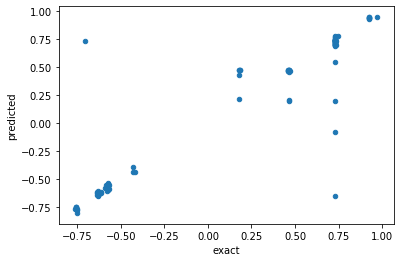

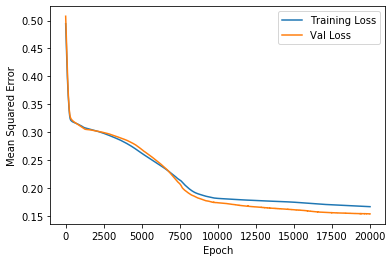

,predicted,exact
0,0.693336,0.732
1,-0.639699,-0.632
2,-0.644493,-0.630
3,-0.764705,-0.756
4,0.469604,0.176


In [77]:
example_mydata = df_testing.sample(frac=0.8,random_state=20)
#run the evaluation
# i checked and they should be correct
example_features = {name:np.array(value) for name, value in example_mydata.items()}
example_label = np.array(example_features.pop(label_name))



predicted = 2*my_model.predict(example_features)-1
predicted=predicted.reshape(len(predicted))
exact = example_mydata["Energy"].to_numpy()*2-1

print(my_model.evaluate(x = example_features, y = example_label, batch_size=batch_size)[0])

df_compare=pd.DataFrame({"predicted":predicted, "exact":exact})

df_compare.plot.scatter(x="exact", y="predicted")
#df_compare.to_csv("first_test.csv")
plot_the_loss_curve(epochs, mse,val_mse)

df_compare.head()


In [78]:
example_features = {name:np.array(value) for name, value in df_testing.items()}
predicted = 2*my_model.predict(example_features)-1
predicted=predicted.reshape(len(predicted))
exact = example_mydata["Energy"].to_numpy()*2-1

0.0218 for first try

min error at around 10k-12k epochs
-> 0,03


[10,10,5]_12000 => 0,176
[10,10]_12000 => 0,028


In [39]:
#data for utomatic hyperparameter tuning
df_spectra=pd.read_csv("spectrum_energy_intensity2.csv",index_col=[0])

df_complete=pd.DataFrame(numpy_energy_intensity)
df_training=df_spectra.sample(frac=0.8,random_state=20)
df_testing=df_spectra.drop(df_training.index)


x_data_training=df_training[["k6a1","k6a2","k11","k12","k9a1","k9a2"]].to_numpy()
y_data_training=df_training[["Energy","Intensity"]].to_numpy()

x_data_testing=df_testing[["k6a1","k6a2","k11","k12","k9a1","k9a2"]].to_numpy()
y_data_testing=df_testing[["Energy","Intensity"]].to_numpy()


In [58]:
#automatic hyperparameter tuning
import kerastuner as kt
def create_model(hp):
    """Create and compile a regression model."""
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units = 10, activation = 'relu'))

    hp_units = hp.Int('units', min_value = 15, max_value = 165, step = 15)
    model.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu'))

    hp_units2 = hp.Int('units2', min_value = 15, max_value = 165, step = 15)
    model.add(tf.keras.layers.Dense(units = hp_units2, activation = 'relu'))
    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=1,  
                                    name='Output'))                              
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=hp_learning_rate),
                loss="MAE",
                metrics="MAE")
    return model


class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    #IPython.display.clear_output(wait = True)
    print("Something")


In [65]:
tuner = kt.Hyperband(create_model,
                     objective = 'val_MAE', 
                     max_epochs = 50,
                     factor = 4,
                     directory = 'test',
                     project_name = 'intro_to_kt')   

In [66]:
tuner.search(x_data_training, y_data_training, epochs = 30, validation_data = (x_data_testing, y_data_testing), callbacks = [ClearTrainingOutput()])


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3092 - MAE: 0.309 - 0s 10ms/step - loss: 0.2551 - MAE: 0.2551 - val_loss: 0.2716 - val_MAE: 0.2716
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.1992 - MAE: 0.199 - 0s 8ms/step - loss: 0.2499 - MAE: 0.2499 - val_loss: 0.2683 - val_MAE: 0.2683
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2484 - MAE: 0.248 - 0s 10ms/step - loss: 0.2532 - MAE: 0.2532 - val_loss: 0.2720 - val_MAE: 0.2720
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2507 - MAE: 0.250 - 0s 9ms/step - loss: 0.2513 - MAE: 0.2513 - val_loss: 0.2667 - val_MAE: 0.2667
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4309 - MAE: 0.430 - 0s 10ms/step - loss: 0.2614 - MAE: 0.2614 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2684 - MAE: 0.268 - 0s 1ms/step - loss: 0.2490 - MAE: 0.2490 - val_loss: 0.2673 - val_MAE: 0.2673
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3434 - MAE: 0.343 - 0s 10ms/step - loss: 0.2714 - MAE: 0.2714 - val_loss: 0.2672 - val_MAE: 0.2672
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2677 - MAE: 0.267 - 0s 9ms/step - loss: 0.2488 - MAE: 0.2488 - val_loss: 0.2668 - val_MAE: 0.2668
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3499 - MAE: 0.349 - 0s 11ms/step - loss: 0.2857 - MAE: 0.2857 - val_loss: 0.2670 - val_MAE: 0.2670
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2784 - MAE: 0.278 - 0s 11ms/step - loss: 0.2501 - MAE: 0.2501 - val_loss: 0.2666 - val_MAE: 0.2666
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4556 - MAE: 0.455 - 0s 11ms/step - loss: 0.3039 - MAE: 0.3039 - val_loss: 0.2850 - val_MAE: 0.2850
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2521 - MAE: 0.252 - 0s 10ms/step - loss: 0.2541 - MAE: 0.2541 - val_loss: 0.2674 - val_MAE: 0.2674
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2401 - MAE: 0.240 - 0s 10ms/step - loss: 0.2535 - MAE: 0.2535 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2633 - MAE: 0.263 - 0s 2ms/step - loss: 0.2496 - MAE: 0.2496 - val_loss: 0.2671 - val_MAE: 0.2671
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2846 - MAE: 0.284 - 0s 11ms/step - loss: 0.2894 - MAE: 0.2894 - val_loss: 0.2811 - val_MAE: 0.2811
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2386 - MAE: 0.238 - 0s 9ms/step - loss: 0.2508 - MAE: 0.2508 - val_loss: 0.2708 - val_MAE: 0.2708
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2840 - MAE: 0.284 - 0s 10ms/step - loss: 0.2524 - MAE: 0.2524 - val_loss: 0.2674 - val_MAE: 0.2674
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2690 - MAE: 0.269 - 0s 7ms/step - loss: 0.2495 - MAE: 0.2495 - val_loss: 0.2673 - val_MAE: 0.2673
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2253 - MAE: 0.225 - 0s 12ms/step - loss: 0.2530 - MAE: 0.2530 - val_loss: 0.2687 - val_MAE: 0.2687
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2384 - MAE: 0.238 - 0s 1ms/step - loss: 0.2505 - MAE: 0.2505 - val_loss: 0.2688 - val_MAE: 0.2688
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2557 - MAE: 0.255 - 0s 10ms/step - loss: 0.2647 - MAE: 0.2647 - val_loss: 0.2723 - val_MAE: 0.2723
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2579 - MAE: 0.257 - 0s 10ms/step - loss: 0.2557 - MAE: 0.2557 - val_loss: 0.2684 - val_MAE: 0.2684
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2376 - MAE: 0.237 - 0s 10ms/step - loss: 0.2595 - MAE: 0.2595 - val_loss: 0.2784 - val_MAE: 0.2784
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2565 - MAE: 0.256 - 0s 9ms/step - loss: 0.2510 - MAE: 0.2510 - val_loss: 0.2683 - val_MAE: 0.2683
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2653 - MAE: 0.265 - 0s 9ms/step - loss: 0.2647 - MAE: 0.2647 - val_loss: 0.2701 - val_MAE: 0.2701
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2635 - MAE: 0.263 - 0s 10ms/step - loss: 0.2524 - MAE: 0.2524 - val_loss: 0.2668 - val_MAE: 0.2668
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3026 - MAE: 0.302 - 0s 10ms/step - loss: 0.2776 - MAE: 0.2776 - val_loss: 0.2724 - val_MAE: 0.2724
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2632 - MAE: 0.263 - 0s 10ms/step - loss: 0.2546 - MAE: 0.2546 - val_loss: 0.2701 - val_MAE: 0.2701
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3907 - MAE: 0.390 - 0s 11ms/step - loss: 0.2634 - MAE: 0.2634 - val_loss: 0.2673 - val_MAE: 0.2673
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.1933 - MAE: 0.193 - 0s 11ms/step - loss: 0.2490 - MAE: 0.2490 - val_loss: 0.2669 - val_MAE: 0.2669
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3194 - MAE: 0.319 - 0s 10ms/step - loss: 0.2893 - MAE: 0.2893 - val_loss: 0.2724 - val_MAE: 0.2724
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2413 - MAE: 0.241 - 0s 10ms/step - loss: 0.2543 - MAE: 0.2543 - val_loss: 0.2685 - val_MAE: 0.2685
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3167 - MAE: 0.316 - 0s 12ms/step - loss: 0.2664 - MAE: 0.2664 - val_loss: 0.2698 - val_MAE: 0.2698
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2388 - MAE: 0.238 - 0s 1ms/step - loss: 0.2501 - MAE: 0.2501 - val_loss: 0.2704 - val_MAE: 0.2704
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3002 - MAE: 0.300 - 0s 10ms/step - loss: 0.2596 - MAE: 0.2596 - val_loss: 0.2683 - val_MAE: 0.2683
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2443 - MAE: 0.244 - 0s 10ms/step - loss: 0.2494 - MAE: 0.2494 - val_loss: 0.2668 - val_MAE: 0.2668
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2456 - MAE: 0.245 - 0s 13ms/step - loss: 0.2820 - MAE: 0.2820 - val_loss: 0.2738 - val_MAE: 0.2738
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2449 - MAE: 0.244 - 0s 10ms/step - loss: 0.2502 - MAE: 0.2502 - val_loss: 0.2669 - val_MAE: 0.2669
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3260 - MAE: 0.326 - 0s 11ms/step - loss: 0.2701 - MAE: 0.2701 - val_loss: 0.2682 - val_MAE: 0.2682
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2325 - MAE: 0.232 - 0s 1ms/step - loss: 0.2509 - MAE: 0.2509 - val_loss: 0.2700 - val_MAE: 0.2700
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3855 - MAE: 0.385 - 0s 11ms/step - loss: 0.2764 - MAE: 0.2764 - val_loss: 0.2747 - val_MAE: 0.2747
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2475 - MAE: 0.247 - 0s 9ms/step - loss: 0.2495 - MAE: 0.2495 - val_loss: 0.2672 - val_MAE: 0.2672
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.5103 - MAE: 0.510 - 0s 11ms/step - loss: 0.2791 - MAE: 0.2791 - val_loss: 0.2677 - val_MAE: 0.2677
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2573 - MAE: 0.257 - 0s 9ms/step - loss: 0.2489 - MAE: 0.2489 - val_loss: 0.2669 - val_MAE: 0.2669
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3815 - MAE: 0.381 - 0s 10ms/step - loss: 0.3007 - MAE: 0.3007 - val_loss: 0.2702 - val_MAE: 0.2702
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2665 - MAE: 0.266 - 0s 2ms/step - loss: 0.2514 - MAE: 0.2514 - val_loss: 0.2719 - val_MAE: 0.2719
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2948 - MAE: 0.294 - 0s 10ms/step - loss: 0.2637 - MAE: 0.2637 - val_loss: 0.2686 - val_MAE: 0.2686
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3588 - MAE: 0.358 - 0s 9ms/step - loss: 0.2505 - MAE: 0.2505 - val_loss: 0.2685 - val_MAE: 0.2685
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2611 - MAE: 0.261 - 0s 10ms/step - loss: 0.2678 - MAE: 0.2678 - val_loss: 0.2671 - val_MAE: 0.2671
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.1887 - MAE: 0.188 - 0s 8ms/step - loss: 0.2497 - MAE: 0.2497 - val_loss: 0.2669 - val_MAE: 0.2669
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2891 - MAE: 0.289 - 0s 11ms/step - loss: 0.2626 - MAE: 0.2626 - val_loss: 0.2689 - val_MAE: 0.2689
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2550 - MAE: 0.255 - 0s 2ms/step - loss: 0.2520 - MAE: 0.2520 - val_loss: 0.2710 - val_MAE: 0.2710
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3942 - MAE: 0.394 - 0s 10ms/step - loss: 0.3394 - MAE: 0.3394 - val_loss: 0.3098 - val_MAE: 0.3098
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3067 - MAE: 0.306 - 0s 9ms/step - loss: 0.2812 - MAE: 0.2812 - val_loss: 0.2764 - val_MAE: 0.2764
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2457 - MAE: 0.245 - 0s 11ms/step - loss: 0.2637 - MAE: 0.2637 - val_loss: 0.2676 - val_MAE: 0.2676
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2836 - MAE: 0.283 - 0s 9ms/step - loss: 0.2502 - MAE: 0.2502 - val_loss: 0.2668 - val_MAE: 0.2668
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2945 - MAE: 0.294 - 0s 10ms/step - loss: 0.2581 - MAE: 0.2581 - val_loss: 0.2684 - val_MAE: 0.2684
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2022 - MAE: 0.202 - 0s 2ms/step - loss: 0.2495 - MAE: 0.2495 - val_loss: 0.2697 - val_MAE: 0.2697
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2711 - MAE: 0.271 - 0s 11ms/step - loss: 0.2673 - MAE: 0.2673 - val_loss: 0.2728 - val_MAE: 0.2728
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2527 - MAE: 0.252 - 0s 9ms/step - loss: 0.2540 - MAE: 0.2540 - val_loss: 0.2728 - val_MAE: 0.2728
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4152 - MAE: 0.415 - 0s 10ms/step - loss: 0.2976 - MAE: 0.2976 - val_loss: 0.2712 - val_MAE: 0.2712
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2196 - MAE: 0.219 - 0s 7ms/step - loss: 0.2517 - MAE: 0.2517 - val_loss: 0.2675 - val_MAE: 0.2675
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4491 - MAE: 0.449 - 0s 11ms/step - loss: 0.3021 - MAE: 0.3021 - val_loss: 0.2674 - val_MAE: 0.2674
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2424 - MAE: 0.242 - 0s 9ms/step - loss: 0.2497 - MAE: 0.2497 - val_loss: 0.2667 - val_MAE: 0.2667
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2743 - MAE: 0.274 - 0s 10ms/step - loss: 0.2771 - MAE: 0.2771 - val_loss: 0.2697 - val_MAE: 0.2697
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2814 - MAE: 0.281 - 0s 10ms/step - loss: 0.2495 - MAE: 0.2495 - val_loss: 0.2669 - val_MAE: 0.2669
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3458 - MAE: 0.345 - 0s 9ms/step - loss: 0.2650 - MAE: 0.2650 - val_loss: 0.2676 - val_MAE: 0.2676
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2443 - MAE: 0.244 - 0s 2ms/step - loss: 0.2496 - MAE: 0.2496 - val_loss: 0.2682 - val_MAE: 0.2682
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3449 - MAE: 0.344 - 0s 11ms/step - loss: 0.2829 - MAE: 0.2829 - val_loss: 0.2670 - val_MAE: 0.2670
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2361 - MAE: 0.236 - 0s 10ms/step - loss: 0.2492 - MAE: 0.2492 - val_loss: 0.2668 - val_MAE: 0.2668
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3043 - MAE: 0.304 - 0s 12ms/step - loss: 0.2791 - MAE: 0.2791 - val_loss: 0.2688 - val_MAE: 0.2688
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2078 - MAE: 0.207 - 0s 2ms/step - loss: 0.2508 - MAE: 0.2508 - val_loss: 0.2694 - val_MAE: 0.2694
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3918 - MAE: 0.391 - 0s 11ms/step - loss: 0.2761 - MAE: 0.2761 - val_loss: 0.2713 - val_MAE: 0.2713
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2180 - MAE: 0.218 - 0s 9ms/step - loss: 0.2503 - MAE: 0.2503 - val_loss: 0.2694 - val_MAE: 0.2694
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.5276 - MAE: 0.527 - 0s 10ms/step - loss: 0.2683 - MAE: 0.2683 - val_loss: 0.2732 - val_MAE: 0.2732
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2400 - MAE: 0.240 - 0s 8ms/step - loss: 0.2487 - MAE: 0.2487 - val_loss: 0.2692 - val_MAE: 0.2692
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3360 - MAE: 0.336 - 0s 13ms/step - loss: 0.2621 - MAE: 0.2621 - val_loss: 0.2666 - val_MAE: 0.2666
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2386 - MAE: 0.238 - 0s 9ms/step - loss: 0.2490 - MAE: 0.2490 - val_loss: 0.2665 - val_MAE: 0.2665
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4673 - MAE: 0.467 - 0s 13ms/step - loss: 0.2982 - MAE: 0.2982 - val_loss: 0.2685 - val_MAE: 0.2685
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2561 - MAE: 0.256 - 0s 1ms/step - loss: 0.2552 - MAE: 0.2552 - val_loss: 0.2713 - val_MAE: 0.2713
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3495 - MAE: 0.349 - 0s 9ms/step - loss: 0.2596 - MAE: 0.2596 - val_loss: 0.2675 - val_MAE: 0.2675
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2673 - MAE: 0.267 - 0s 9ms/step - loss: 0.2494 - MAE: 0.2494 - val_loss: 0.2671 - val_MAE: 0.2671
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3346 - MAE: 0.334 - 0s 11ms/step - loss: 0.2646 - MAE: 0.2646 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2797 - MAE: 0.279 - 0s 2ms/step - loss: 0.2519 - MAE: 0.2519 - val_loss: 0.2675 - val_MAE: 0.2675
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3634 - MAE: 0.363 - 0s 10ms/step - loss: 0.2713 - MAE: 0.2713 - val_loss: 0.2677 - val_MAE: 0.2677
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2340 - MAE: 0.234 - 0s 1ms/step - loss: 0.2490 - MAE: 0.2490 - val_loss: 0.2686 - val_MAE: 0.2686
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4086 - MAE: 0.408 - 0s 11ms/step - loss: 0.3359 - MAE: 0.3359 - val_loss: 0.3213 - val_MAE: 0.3213
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2976 - MAE: 0.297 - 0s 13ms/step - loss: 0.2940 - MAE: 0.2940 - val_loss: 0.2893 - val_MAE: 0.2893
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2374 - MAE: 0.237 - 0s 10ms/step - loss: 0.2525 - MAE: 0.2525 - val_loss: 0.2682 - val_MAE: 0.2682
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.1985 - MAE: 0.198 - 0s 11ms/step - loss: 0.2497 - MAE: 0.2497 - val_loss: 0.2674 - val_MAE: 0.2674
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3273 - MAE: 0.327 - 0s 12ms/step - loss: 0.2565 - MAE: 0.2565 - val_loss: 0.2721 - val_MAE: 0.2721
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2631 - MAE: 0.263 - 0s 10ms/step - loss: 0.2543 - MAE: 0.2543 - val_loss: 0.2706 - val_MAE: 0.2706
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2469 - MAE: 0.246 - 0s 10ms/step - loss: 0.2809 - MAE: 0.2809 - val_loss: 0.2672 - val_MAE: 0.2672
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2719 - MAE: 0.271 - 0s 13ms/step - loss: 0.2493 - MAE: 0.2493 - val_loss: 0.2662 - val_MAE: 0.2662
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2823 - MAE: 0.282 - 0s 10ms/step - loss: 0.2561 - MAE: 0.2561 - val_loss: 0.2687 - val_MAE: 0.2687
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2224 - MAE: 0.222 - 0s 10ms/step - loss: 0.2510 - MAE: 0.2510 - val_loss: 0.2679 - val_MAE: 0.2679
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3197 - MAE: 0.319 - 0s 10ms/step - loss: 0.2544 - MAE: 0.2544 - val_loss: 0.2676 - val_MAE: 0.2676
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2202 - MAE: 0.220 - 0s 1ms/step - loss: 0.2497 - MAE: 0.2497 - val_loss: 0.2677 - val_MAE: 0.2677
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2833 - MAE: 0.283 - 0s 16ms/step - loss: 0.2532 - MAE: 0.2532 - val_loss: 0.2710 - val_MAE: 0.2710
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2572 - MAE: 0.257 - 0s 11ms/step - loss: 0.2503 - MAE: 0.2503 - val_loss: 0.2674 - val_MAE: 0.2674
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3008 - MAE: 0.300 - 0s 10ms/step - loss: 0.2664 - MAE: 0.2664 - val_loss: 0.2689 - val_MAE: 0.2689
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2776 - MAE: 0.277 - 0s 2ms/step - loss: 0.2515 - MAE: 0.2515 - val_loss: 0.2751 - val_MAE: 0.2751
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2914 - MAE: 0.291 - 0s 12ms/step - loss: 0.2548 - MAE: 0.2548 - val_loss: 0.2681 - val_MAE: 0.2681
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2557 - MAE: 0.255 - 0s 12ms/step - loss: 0.2492 - MAE: 0.2492 - val_loss: 0.2669 - val_MAE: 0.2669
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2543 - MAE: 0.254 - 0s 10ms/step - loss: 0.2625 - MAE: 0.2625 - val_loss: 0.2696 - val_MAE: 0.2696
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2010 - MAE: 0.201 - 0s 6ms/step - loss: 0.2505 - MAE: 0.2505 - val_loss: 0.2671 - val_MAE: 0.2671
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3583 - MAE: 0.358 - 0s 9ms/step - loss: 0.3407 - MAE: 0.3407 - val_loss: 0.3258 - val_MAE: 0.3258
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3084 - MAE: 0.308 - 0s 10ms/step - loss: 0.2978 - MAE: 0.2978 - val_loss: 0.2916 - val_MAE: 0.2916
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3059 - MAE: 0.305 - 0s 11ms/step - loss: 0.3148 - MAE: 0.3148 - val_loss: 0.2780 - val_MAE: 0.2780
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2207 - MAE: 0.220 - 0s 9ms/step - loss: 0.2574 - MAE: 0.2574 - val_loss: 0.2679 - val_MAE: 0.2679
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3107 - MAE: 0.310 - 0s 10ms/step - loss: 0.3253 - MAE: 0.3253 - val_loss: 0.2934 - val_MAE: 0.2934
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2788 - MAE: 0.278 - 0s 8ms/step - loss: 0.2665 - MAE: 0.2665 - val_loss: 0.2690 - val_MAE: 0.2690
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2379 - MAE: 0.237 - 0s 9ms/step - loss: 0.2548 - MAE: 0.2548 - val_loss: 0.2692 - val_MAE: 0.2692
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2168 - MAE: 0.216 - 0s 8ms/step - loss: 0.2495 - MAE: 0.2495 - val_loss: 0.2671 - val_MAE: 0.2671
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3819 - MAE: 0.381 - 0s 11ms/step - loss: 0.2632 - MAE: 0.2632 - val_loss: 0.2683 - val_MAE: 0.2683
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2564 - MAE: 0.256 - 0s 14ms/step - loss: 0.2506 - MAE: 0.2506 - val_loss: 0.2675 - val_MAE: 0.2675
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2958 - MAE: 0.295 - 0s 11ms/step - loss: 0.2560 - MAE: 0.2560 - val_loss: 0.2679 - val_MAE: 0.2679
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2906 - MAE: 0.290 - 0s 1ms/step - loss: 0.2508 - MAE: 0.2508 - val_loss: 0.2686 - val_MAE: 0.2686
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3467 - MAE: 0.346 - 0s 11ms/step - loss: 0.2986 - MAE: 0.2986 - val_loss: 0.2908 - val_MAE: 0.2908
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2833 - MAE: 0.283 - 0s 8ms/step - loss: 0.2726 - MAE: 0.2726 - val_loss: 0.2770 - val_MAE: 0.2770
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2922 - MAE: 0.292 - 0s 10ms/step - loss: 0.2697 - MAE: 0.2697 - val_loss: 0.2695 - val_MAE: 0.2695
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2393 - MAE: 0.239 - 0s 10ms/step - loss: 0.2519 - MAE: 0.2519 - val_loss: 0.2674 - val_MAE: 0.2674
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2122 - MAE: 0.212 - 0s 10ms/step - loss: 0.2696 - MAE: 0.2696 - val_loss: 0.2691 - val_MAE: 0.2691
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3069 - MAE: 0.306 - 0s 8ms/step - loss: 0.2499 - MAE: 0.2499 - val_loss: 0.2667 - val_MAE: 0.2667
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2920 - MAE: 0.292 - 0s 10ms/step - loss: 0.2518 - MAE: 0.2518 - val_loss: 0.2679 - val_MAE: 0.2679
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2465 - MAE: 0.246 - 0s 2ms/step - loss: 0.2498 - MAE: 0.2498 - val_loss: 0.2698 - val_MAE: 0.2698
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4088 - MAE: 0.408 - 0s 9ms/step - loss: 0.2572 - MAE: 0.2572 - val_loss: 0.2676 - val_MAE: 0.2676
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2227 - MAE: 0.222 - 0s 9ms/step - loss: 0.2490 - MAE: 0.2490 - val_loss: 0.2666 - val_MAE: 0.2666
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3345 - MAE: 0.334 - 0s 10ms/step - loss: 0.2779 - MAE: 0.2779 - val_loss: 0.2714 - val_MAE: 0.2714
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2582 - MAE: 0.258 - 0s 9ms/step - loss: 0.2489 - MAE: 0.2489 - val_loss: 0.2688 - val_MAE: 0.2688
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3292 - MAE: 0.329 - 0s 10ms/step - loss: 0.2624 - MAE: 0.2624 - val_loss: 0.2677 - val_MAE: 0.2677
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3007 - MAE: 0.300 - 0s 1ms/step - loss: 0.2509 - MAE: 0.2509 - val_loss: 0.2681 - val_MAE: 0.2681
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2438 - MAE: 0.243 - 0s 10ms/step - loss: 0.2555 - MAE: 0.2555 - val_loss: 0.2697 - val_MAE: 0.2697
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2366 - MAE: 0.236 - 0s 12ms/step - loss: 0.2496 - MAE: 0.2496 - val_loss: 0.2676 - val_MAE: 0.2676
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2899 - MAE: 0.289 - 0s 10ms/step - loss: 0.2556 - MAE: 0.2556 - val_loss: 0.2681 - val_MAE: 0.2681
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2323 - MAE: 0.232 - 0s 1ms/step - loss: 0.2507 - MAE: 0.2507 - val_loss: 0.2692 - val_MAE: 0.2692
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2968 - MAE: 0.296 - 0s 11ms/step - loss: 0.2628 - MAE: 0.2628 - val_loss: 0.2683 - val_MAE: 0.2683
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2658 - MAE: 0.265 - 0s 9ms/step - loss: 0.2500 - MAE: 0.2500 - val_loss: 0.2681 - val_MAE: 0.2681
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2379 - MAE: 0.237 - 0s 9ms/step - loss: 0.2508 - MAE: 0.2508 - val_loss: 0.2691 - val_MAE: 0.2691
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2816 - MAE: 0.281 - 0s 2ms/step - loss: 0.2500 - MAE: 0.2500 - val_loss: 0.2694 - val_MAE: 0.2694
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3319 - MAE: 0.331 - 0s 11ms/step - loss: 0.2779 - MAE: 0.2779 - val_loss: 0.2677 - val_MAE: 0.2677
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2151 - MAE: 0.215 - 0s 9ms/step - loss: 0.2493 - MAE: 0.2493 - val_loss: 0.2664 - val_MAE: 0.2664
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3562 - MAE: 0.356 - 0s 10ms/step - loss: 0.2882 - MAE: 0.2882 - val_loss: 0.2758 - val_MAE: 0.2758
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2913 - MAE: 0.291 - 0s 9ms/step - loss: 0.2577 - MAE: 0.2577 - val_loss: 0.2681 - val_MAE: 0.2681
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3932 - MAE: 0.393 - 0s 11ms/step - loss: 0.2732 - MAE: 0.2732 - val_loss: 0.2680 - val_MAE: 0.2680
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2519 - MAE: 0.251 - 0s 2ms/step - loss: 0.2507 - MAE: 0.2507 - val_loss: 0.2702 - val_MAE: 0.2702
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2687 - MAE: 0.268 - 0s 11ms/step - loss: 0.2537 - MAE: 0.2537 - val_loss: 0.2672 - val_MAE: 0.2672
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2666 - MAE: 0.266 - 0s 9ms/step - loss: 0.2487 - MAE: 0.2487 - val_loss: 0.2670 - val_MAE: 0.2670
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4311 - MAE: 0.431 - 0s 9ms/step - loss: 0.2784 - MAE: 0.2784 - val_loss: 0.2695 - val_MAE: 0.2695
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2127 - MAE: 0.212 - 0s 2ms/step - loss: 0.2522 - MAE: 0.2522 - val_loss: 0.2710 - val_MAE: 0.2710
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3942 - MAE: 0.394 - 0s 12ms/step - loss: 0.2624 - MAE: 0.2624 - val_loss: 0.2672 - val_MAE: 0.2672
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2244 - MAE: 0.224 - 0s 8ms/step - loss: 0.2489 - MAE: 0.2489 - val_loss: 0.2662 - val_MAE: 0.2662
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2944 - MAE: 0.294 - 0s 10ms/step - loss: 0.2660 - MAE: 0.2660 - val_loss: 0.2664 - val_MAE: 0.2664
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2544 - MAE: 0.254 - 0s 2ms/step - loss: 0.2504 - MAE: 0.2504 - val_loss: 0.2689 - val_MAE: 0.2689
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3631 - MAE: 0.363 - 0s 10ms/step - loss: 0.3141 - MAE: 0.3141 - val_loss: 0.2843 - val_MAE: 0.2843
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2597 - MAE: 0.259 - 0s 7ms/step - loss: 0.2604 - MAE: 0.2604 - val_loss: 0.2691 - val_MAE: 0.2691
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3294 - MAE: 0.329 - 0s 13ms/step - loss: 0.2907 - MAE: 0.2907 - val_loss: 0.2974 - val_MAE: 0.2974
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2771 - MAE: 0.277 - 0s 9ms/step - loss: 0.2621 - MAE: 0.2621 - val_loss: 0.2775 - val_MAE: 0.2775
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2844 - MAE: 0.284 - 0s 11ms/step - loss: 0.2777 - MAE: 0.2777 - val_loss: 0.2674 - val_MAE: 0.2674
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2108 - MAE: 0.210 - 0s 9ms/step - loss: 0.2482 - MAE: 0.2482 - val_loss: 0.2654 - val_MAE: 0.2654
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2417 - MAE: 0.241 - 0s 11ms/step - loss: 0.2702 - MAE: 0.2702 - val_loss: 0.2673 - val_MAE: 0.2673
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2469 - MAE: 0.246 - 0s 2ms/step - loss: 0.2500 - MAE: 0.2500 - val_loss: 0.2714 - val_MAE: 0.2714
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3793 - MAE: 0.379 - 0s 12ms/step - loss: 0.2612 - MAE: 0.2612 - val_loss: 0.2681 - val_MAE: 0.2681
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.1965 - MAE: 0.196 - 0s 9ms/step - loss: 0.2489 - MAE: 0.2489 - val_loss: 0.2668 - val_MAE: 0.2668
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2933 - MAE: 0.293 - 0s 11ms/step - loss: 0.2631 - MAE: 0.2631 - val_loss: 0.2673 - val_MAE: 0.2673
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2723 - MAE: 0.272 - 0s 8ms/step - loss: 0.2487 - MAE: 0.2487 - val_loss: 0.2665 - val_MAE: 0.2665
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2425 - MAE: 0.242 - 0s 12ms/step - loss: 0.2867 - MAE: 0.2867 - val_loss: 0.2673 - val_MAE: 0.2673
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2109 - MAE: 0.210 - 0s 10ms/step - loss: 0.2500 - MAE: 0.2500 - val_loss: 0.2664 - val_MAE: 0.2664
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4856 - MAE: 0.485 - 0s 13ms/step - loss: 0.2696 - MAE: 0.2696 - val_loss: 0.2679 - val_MAE: 0.2679
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2129 - MAE: 0.212 - 0s 8ms/step - loss: 0.2504 - MAE: 0.2504 - val_loss: 0.2672 - val_MAE: 0.2672
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2690 - MAE: 0.269 - 0s 11ms/step - loss: 0.2521 - MAE: 0.2521 - val_loss: 0.2679 - val_MAE: 0.2679
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2639 - MAE: 0.263 - 0s 7ms/step - loss: 0.2497 - MAE: 0.2497 - val_loss: 0.2677 - val_MAE: 0.2677
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2955 - MAE: 0.295 - 0s 10ms/step - loss: 0.2664 - MAE: 0.2664 - val_loss: 0.2697 - val_MAE: 0.2697
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2715 - MAE: 0.271 - 0s 11ms/step - loss: 0.2507 - MAE: 0.2507 - val_loss: 0.2669 - val_MAE: 0.2669
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4572 - MAE: 0.457 - 0s 10ms/step - loss: 0.3032 - MAE: 0.3032 - val_loss: 0.2866 - val_MAE: 0.2866
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2571 - MAE: 0.257 - 0s 8ms/step - loss: 0.2550 - MAE: 0.2550 - val_loss: 0.2676 - val_MAE: 0.2676
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4032 - MAE: 0.403 - 0s 12ms/step - loss: 0.3488 - MAE: 0.3488 - val_loss: 0.3093 - val_MAE: 0.3093
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3233 - MAE: 0.323 - 0s 13ms/step - loss: 0.2789 - MAE: 0.2789 - val_loss: 0.2733 - val_MAE: 0.2733
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2642 - MAE: 0.264 - 0s 12ms/step - loss: 0.2542 - MAE: 0.2542 - val_loss: 0.2683 - val_MAE: 0.2683
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2649 - MAE: 0.264 - 0s 8ms/step - loss: 0.2496 - MAE: 0.2496 - val_loss: 0.2682 - val_MAE: 0.2682
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.5121 - MAE: 0.512 - 0s 10ms/step - loss: 0.4288 - MAE: 0.4288 - val_loss: 0.4134 - val_MAE: 0.4134
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3858 - MAE: 0.385 - 0s 12ms/step - loss: 0.3829 - MAE: 0.3829 - val_loss: 0.3680 - val_MAE: 0.3680
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3904 - MAE: 0.390 - 0s 11ms/step - loss: 0.2636 - MAE: 0.2636 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.1730 - MAE: 0.173 - 0s 1ms/step - loss: 0.2491 - MAE: 0.2491 - val_loss: 0.2730 - val_MAE: 0.2730
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2963 - MAE: 0.296 - 0s 9ms/step - loss: 0.2633 - MAE: 0.2633 - val_loss: 0.2688 - val_MAE: 0.2688
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2610 - MAE: 0.261 - 0s 9ms/step - loss: 0.2506 - MAE: 0.2506 - val_loss: 0.2677 - val_MAE: 0.2677
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4771 - MAE: 0.477 - 0s 10ms/step - loss: 0.3211 - MAE: 0.3211 - val_loss: 0.2688 - val_MAE: 0.2688
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2261 - MAE: 0.226 - 0s 1ms/step - loss: 0.2517 - MAE: 0.2517 - val_loss: 0.2696 - val_MAE: 0.2696
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3062 - MAE: 0.306 - 0s 11ms/step - loss: 0.2543 - MAE: 0.2543 - val_loss: 0.2699 - val_MAE: 0.2699
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3069 - MAE: 0.306 - 0s 9ms/step - loss: 0.2491 - MAE: 0.2491 - val_loss: 0.2678 - val_MAE: 0.2678
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2657 - MAE: 0.265 - 0s 12ms/step - loss: 0.2559 - MAE: 0.2559 - val_loss: 0.2679 - val_MAE: 0.2679
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2334 - MAE: 0.233 - 0s 11ms/step - loss: 0.2510 - MAE: 0.2510 - val_loss: 0.2671 - val_MAE: 0.2671
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2847 - MAE: 0.284 - 0s 11ms/step - loss: 0.2579 - MAE: 0.2579 - val_loss: 0.2685 - val_MAE: 0.2685
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2213 - MAE: 0.221 - 0s 11ms/step - loss: 0.2512 - MAE: 0.2512 - val_loss: 0.2678 - val_MAE: 0.2678
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3322 - MAE: 0.332 - 0s 12ms/step - loss: 0.2942 - MAE: 0.2942 - val_loss: 0.2682 - val_MAE: 0.2682
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2721 - MAE: 0.272 - 0s 8ms/step - loss: 0.2509 - MAE: 0.2509 - val_loss: 0.2671 - val_MAE: 0.2671
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2866 - MAE: 0.286 - 0s 11ms/step - loss: 0.2565 - MAE: 0.2565 - val_loss: 0.2685 - val_MAE: 0.2685
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2492 - MAE: 0.249 - 0s 2ms/step - loss: 0.2502 - MAE: 0.2502 - val_loss: 0.2694 - val_MAE: 0.2694
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2781 - MAE: 0.278 - 0s 11ms/step - loss: 0.2716 - MAE: 0.2716 - val_loss: 0.2767 - val_MAE: 0.2767
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2416 - MAE: 0.241 - 0s 11ms/step - loss: 0.2597 - MAE: 0.2597 - val_loss: 0.2701 - val_MAE: 0.2701
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3532 - MAE: 0.353 - 0s 11ms/step - loss: 0.2657 - MAE: 0.2657 - val_loss: 0.2677 - val_MAE: 0.2677
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2643 - MAE: 0.264 - 0s 9ms/step - loss: 0.2497 - MAE: 0.2497 - val_loss: 0.2676 - val_MAE: 0.2676
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3498 - MAE: 0.349 - 0s 10ms/step - loss: 0.2604 - MAE: 0.2604 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2124 - MAE: 0.212 - 0s 2ms/step - loss: 0.2503 - MAE: 0.2503 - val_loss: 0.2676 - val_MAE: 0.2676
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2671 - MAE: 0.267 - 0s 12ms/step - loss: 0.2919 - MAE: 0.2919 - val_loss: 0.2682 - val_MAE: 0.2682
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.1986 - MAE: 0.198 - 0s 11ms/step - loss: 0.2513 - MAE: 0.2513 - val_loss: 0.2672 - val_MAE: 0.2672
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3591 - MAE: 0.359 - 0s 10ms/step - loss: 0.3112 - MAE: 0.3112 - val_loss: 0.2713 - val_MAE: 0.2713
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3060 - MAE: 0.306 - 0s 8ms/step - loss: 0.2526 - MAE: 0.2526 - val_loss: 0.2681 - val_MAE: 0.2681
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3743 - MAE: 0.374 - 0s 10ms/step - loss: 0.3129 - MAE: 0.3129 - val_loss: 0.2875 - val_MAE: 0.2875
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2405 - MAE: 0.240 - 0s 7ms/step - loss: 0.2647 - MAE: 0.2647 - val_loss: 0.2702 - val_MAE: 0.2702
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2953 - MAE: 0.295 - 0s 10ms/step - loss: 0.2730 - MAE: 0.2730 - val_loss: 0.2684 - val_MAE: 0.2684
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2789 - MAE: 0.278 - 0s 9ms/step - loss: 0.2517 - MAE: 0.2517 - val_loss: 0.2676 - val_MAE: 0.2676
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3993 - MAE: 0.399 - 0s 10ms/step - loss: 0.2757 - MAE: 0.2757 - val_loss: 0.2674 - val_MAE: 0.2674
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.1678 - MAE: 0.167 - 0s 2ms/step - loss: 0.2510 - MAE: 0.2510 - val_loss: 0.2703 - val_MAE: 0.2703
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3652 - MAE: 0.365 - 0s 10ms/step - loss: 0.2794 - MAE: 0.2794 - val_loss: 0.2783 - val_MAE: 0.2783
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2492 - MAE: 0.249 - 0s 8ms/step - loss: 0.2499 - MAE: 0.2499 - val_loss: 0.2674 - val_MAE: 0.2674
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3321 - MAE: 0.332 - 0s 9ms/step - loss: 0.2880 - MAE: 0.2880 - val_loss: 0.2718 - val_MAE: 0.2718
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2097 - MAE: 0.209 - 0s 8ms/step - loss: 0.2510 - MAE: 0.2510 - val_loss: 0.2700 - val_MAE: 0.2700
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4024 - MAE: 0.402 - 0s 12ms/step - loss: 0.3462 - MAE: 0.3462 - val_loss: 0.3224 - val_MAE: 0.3224
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3709 - MAE: 0.370 - 0s 11ms/step - loss: 0.2963 - MAE: 0.2963 - val_loss: 0.2851 - val_MAE: 0.2851
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4004 - MAE: 0.400 - 0s 10ms/step - loss: 0.2808 - MAE: 0.2808 - val_loss: 0.2670 - val_MAE: 0.2670
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2120 - MAE: 0.212 - 0s 10ms/step - loss: 0.2492 - MAE: 0.2492 - val_loss: 0.2666 - val_MAE: 0.2666
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2961 - MAE: 0.296 - 0s 14ms/step - loss: 0.2608 - MAE: 0.2608 - val_loss: 0.2685 - val_MAE: 0.2685
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2050 - MAE: 0.205 - 0s 8ms/step - loss: 0.2509 - MAE: 0.2509 - val_loss: 0.2679 - val_MAE: 0.2679
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3947 - MAE: 0.394 - 0s 11ms/step - loss: 0.3081 - MAE: 0.3081 - val_loss: 0.2864 - val_MAE: 0.2864
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2853 - MAE: 0.285 - 0s 9ms/step - loss: 0.2648 - MAE: 0.2648 - val_loss: 0.2701 - val_MAE: 0.2701
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2899 - MAE: 0.289 - 0s 9ms/step - loss: 0.2639 - MAE: 0.2639 - val_loss: 0.2673 - val_MAE: 0.2673
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2105 - MAE: 0.210 - 0s 2ms/step - loss: 0.2491 - MAE: 0.2491 - val_loss: 0.2676 - val_MAE: 0.2676
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2477 - MAE: 0.247 - 0s 10ms/step - loss: 0.2533 - MAE: 0.2533 - val_loss: 0.2680 - val_MAE: 0.2680
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2484 - MAE: 0.248 - 0s 12ms/step - loss: 0.2498 - MAE: 0.2498 - val_loss: 0.2675 - val_MAE: 0.2675
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4706 - MAE: 0.470 - 0s 10ms/step - loss: 0.3440 - MAE: 0.3440 - val_loss: 0.2746 - val_MAE: 0.2746
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2705 - MAE: 0.270 - 0s 11ms/step - loss: 0.2523 - MAE: 0.2523 - val_loss: 0.2700 - val_MAE: 0.2700
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2743 - MAE: 0.274 - 0s 10ms/step - loss: 0.2813 - MAE: 0.2813 - val_loss: 0.2719 - val_MAE: 0.2719
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2743 - MAE: 0.274 - 0s 10ms/step - loss: 0.2551 - MAE: 0.2551 - val_loss: 0.2680 - val_MAE: 0.2680
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3094 - MAE: 0.309 - 0s 10ms/step - loss: 0.2750 - MAE: 0.2750 - val_loss: 0.2697 - val_MAE: 0.2697
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2746 - MAE: 0.274 - 0s 9ms/step - loss: 0.2499 - MAE: 0.2499 - val_loss: 0.2675 - val_MAE: 0.2675
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2910 - MAE: 0.291 - 0s 9ms/step - loss: 0.2578 - MAE: 0.2578 - val_loss: 0.2671 - val_MAE: 0.2671
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3091 - MAE: 0.309 - 0s 8ms/step - loss: 0.2499 - MAE: 0.2499 - val_loss: 0.2669 - val_MAE: 0.2669
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3015 - MAE: 0.301 - 0s 10ms/step - loss: 0.2799 - MAE: 0.2799 - val_loss: 0.2678 - val_MAE: 0.2678
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2942 - MAE: 0.294 - 0s 2ms/step - loss: 0.2492 - MAE: 0.2492 - val_loss: 0.2682 - val_MAE: 0.2682
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2448 - MAE: 0.244 - 0s 10ms/step - loss: 0.2550 - MAE: 0.2550 - val_loss: 0.2698 - val_MAE: 0.2698
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2611 - MAE: 0.261 - 0s 8ms/step - loss: 0.2498 - MAE: 0.2498 - val_loss: 0.2696 - val_MAE: 0.2696
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3257 - MAE: 0.325 - 0s 10ms/step - loss: 0.2741 - MAE: 0.2741 - val_loss: 0.2712 - val_MAE: 0.2712
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2330 - MAE: 0.233 - 0s 8ms/step - loss: 0.2509 - MAE: 0.2509 - val_loss: 0.2675 - val_MAE: 0.2675
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4593 - MAE: 0.459 - 0s 10ms/step - loss: 0.3993 - MAE: 0.3993 - val_loss: 0.3793 - val_MAE: 0.3793
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.4010 - MAE: 0.401 - 0s 10ms/step - loss: 0.3470 - MAE: 0.3470 - val_loss: 0.3329 - val_MAE: 0.3329
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.5854 - MAE: 0.585 - 0s 12ms/step - loss: 0.6115 - MAE: 0.6115 - val_loss: 0.5651 - val_MAE: 0.5651
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.6356 - MAE: 0.635 - 0s 9ms/step - loss: 0.5136 - MAE: 0.5136 - val_loss: 0.4709 - val_MAE: 0.4709
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3079 - MAE: 0.307 - 0s 10ms/step - loss: 0.2614 - MAE: 0.2614 - val_loss: 0.2686 - val_MAE: 0.2686
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2527 - MAE: 0.252 - 0s 2ms/step - loss: 0.2509 - MAE: 0.2509 - val_loss: 0.2736 - val_MAE: 0.2736
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2929 - MAE: 0.292 - 0s 10ms/step - loss: 0.2558 - MAE: 0.2558 - val_loss: 0.2683 - val_MAE: 0.2683
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2456 - MAE: 0.245 - 0s 2ms/step - loss: 0.2499 - MAE: 0.2499 - val_loss: 0.2687 - val_MAE: 0.2687
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2491 - MAE: 0.249 - 0s 11ms/step - loss: 0.2562 - MAE: 0.2562 - val_loss: 0.2744 - val_MAE: 0.2744
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2387 - MAE: 0.238 - 0s 9ms/step - loss: 0.2497 - MAE: 0.2497 - val_loss: 0.2674 - val_MAE: 0.2674
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2143 - MAE: 0.214 - 0s 9ms/step - loss: 0.2725 - MAE: 0.2725 - val_loss: 0.2671 - val_MAE: 0.2671
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2358 - MAE: 0.235 - 0s 9ms/step - loss: 0.2496 - MAE: 0.2496 - val_loss: 0.2668 - val_MAE: 0.2668
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4218 - MAE: 0.421 - 0s 11ms/step - loss: 0.3600 - MAE: 0.3600 - val_loss: 0.3047 - val_MAE: 0.3047
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2930 - MAE: 0.293 - 0s 11ms/step - loss: 0.2700 - MAE: 0.2700 - val_loss: 0.2691 - val_MAE: 0.2691
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3686 - MAE: 0.368 - 0s 11ms/step - loss: 0.2704 - MAE: 0.2704 - val_loss: 0.2668 - val_MAE: 0.2668
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2537 - MAE: 0.253 - 0s 2ms/step - loss: 0.2487 - MAE: 0.2487 - val_loss: 0.2668 - val_MAE: 0.2668
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3905 - MAE: 0.390 - 0s 10ms/step - loss: 0.2896 - MAE: 0.2896 - val_loss: 0.2821 - val_MAE: 0.2821
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2784 - MAE: 0.278 - 0s 9ms/step - loss: 0.2635 - MAE: 0.2635 - val_loss: 0.2711 - val_MAE: 0.2711
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3440 - MAE: 0.344 - 0s 15ms/step - loss: 0.3150 - MAE: 0.3150 - val_loss: 0.2754 - val_MAE: 0.2754
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2938 - MAE: 0.293 - 0s 11ms/step - loss: 0.2557 - MAE: 0.2557 - val_loss: 0.2679 - val_MAE: 0.2679
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2577 - MAE: 0.257 - 0s 10ms/step - loss: 0.2620 - MAE: 0.2620 - val_loss: 0.2690 - val_MAE: 0.2690
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2285 - MAE: 0.228 - 0s 14ms/step - loss: 0.2501 - MAE: 0.2501 - val_loss: 0.2672 - val_MAE: 0.2672
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2878 - MAE: 0.287 - 0s 10ms/step - loss: 0.2571 - MAE: 0.2571 - val_loss: 0.2858 - val_MAE: 0.2858
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2185 - MAE: 0.218 - 0s 11ms/step - loss: 0.2528 - MAE: 0.2528 - val_loss: 0.2696 - val_MAE: 0.2696
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2449 - MAE: 0.244 - 0s 10ms/step - loss: 0.2611 - MAE: 0.2611 - val_loss: 0.2722 - val_MAE: 0.2722
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2615 - MAE: 0.261 - 0s 7ms/step - loss: 0.2496 - MAE: 0.2496 - val_loss: 0.2682 - val_MAE: 0.2682
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3186 - MAE: 0.318 - 0s 9ms/step - loss: 0.2850 - MAE: 0.2850 - val_loss: 0.2730 - val_MAE: 0.2730
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2187 - MAE: 0.218 - 0s 9ms/step - loss: 0.2551 - MAE: 0.2551 - val_loss: 0.2681 - val_MAE: 0.2681
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3260 - MAE: 0.326 - 0s 12ms/step - loss: 0.2756 - MAE: 0.2756 - val_loss: 0.2677 - val_MAE: 0.2677
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2731 - MAE: 0.273 - 0s 2ms/step - loss: 0.2503 - MAE: 0.2503 - val_loss: 0.2682 - val_MAE: 0.2682
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2129 - MAE: 0.212 - 0s 9ms/step - loss: 0.2549 - MAE: 0.2549 - val_loss: 0.2703 - val_MAE: 0.2703
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2835 - MAE: 0.283 - 0s 13ms/step - loss: 0.2531 - MAE: 0.2531 - val_loss: 0.2691 - val_MAE: 0.2691
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4581 - MAE: 0.458 - 0s 11ms/step - loss: 0.3777 - MAE: 0.3777 - val_loss: 0.3676 - val_MAE: 0.3676
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3751 - MAE: 0.375 - 0s 10ms/step - loss: 0.3471 - MAE: 0.3471 - val_loss: 0.3385 - val_MAE: 0.3385
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.5286 - MAE: 0.528 - 0s 10ms/step - loss: 0.4846 - MAE: 0.4846 - val_loss: 0.4294 - val_MAE: 0.4294
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.4039 - MAE: 0.403 - 0s 10ms/step - loss: 0.3722 - MAE: 0.3722 - val_loss: 0.3189 - val_MAE: 0.3189
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4440 - MAE: 0.444 - 0s 10ms/step - loss: 0.2726 - MAE: 0.2726 - val_loss: 0.2675 - val_MAE: 0.2675
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2715 - MAE: 0.271 - 0s 10ms/step - loss: 0.2496 - MAE: 0.2496 - val_loss: 0.2671 - val_MAE: 0.2671
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4707 - MAE: 0.470 - 0s 9ms/step - loss: 0.3253 - MAE: 0.3253 - val_loss: 0.2703 - val_MAE: 0.2703
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2269 - MAE: 0.226 - 0s 1ms/step - loss: 0.2512 - MAE: 0.2512 - val_loss: 0.2711 - val_MAE: 0.2711
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2562 - MAE: 0.256 - 0s 12ms/step - loss: 0.2660 - MAE: 0.2660 - val_loss: 0.2711 - val_MAE: 0.2711
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2613 - MAE: 0.261 - 0s 15ms/step - loss: 0.2545 - MAE: 0.2545 - val_loss: 0.2681 - val_MAE: 0.2681
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3003 - MAE: 0.300 - 0s 11ms/step - loss: 0.2779 - MAE: 0.2779 - val_loss: 0.2680 - val_MAE: 0.2680
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2994 - MAE: 0.299 - 0s 13ms/step - loss: 0.2513 - MAE: 0.2513 - val_loss: 0.2676 - val_MAE: 0.2676
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3128 - MAE: 0.312 - 0s 9ms/step - loss: 0.2589 - MAE: 0.2589 - val_loss: 0.2706 - val_MAE: 0.2706
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2399 - MAE: 0.239 - 0s 8ms/step - loss: 0.2509 - MAE: 0.2509 - val_loss: 0.2674 - val_MAE: 0.2674
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3832 - MAE: 0.383 - 0s 12ms/step - loss: 0.2714 - MAE: 0.2714 - val_loss: 0.2702 - val_MAE: 0.2702
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2145 - MAE: 0.214 - 0s 9ms/step - loss: 0.2524 - MAE: 0.2524 - val_loss: 0.2672 - val_MAE: 0.2672
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.1982 - MAE: 0.198 - 0s 15ms/step - loss: 0.2605 - MAE: 0.2605 - val_loss: 0.2693 - val_MAE: 0.2693
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2681 - MAE: 0.268 - 0s 2ms/step - loss: 0.2501 - MAE: 0.2501 - val_loss: 0.2705 - val_MAE: 0.2705
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3044 - MAE: 0.304 - 0s 10ms/step - loss: 0.2886 - MAE: 0.2886 - val_loss: 0.2764 - val_MAE: 0.2764
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2698 - MAE: 0.269 - 0s 9ms/step - loss: 0.2566 - MAE: 0.2566 - val_loss: 0.2685 - val_MAE: 0.2685
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2552 - MAE: 0.255 - 0s 11ms/step - loss: 0.2930 - MAE: 0.2930 - val_loss: 0.2707 - val_MAE: 0.2707
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2340 - MAE: 0.234 - 0s 9ms/step - loss: 0.2491 - MAE: 0.2491 - val_loss: 0.2663 - val_MAE: 0.2663
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3329 - MAE: 0.332 - 0s 11ms/step - loss: 0.2710 - MAE: 0.2710 - val_loss: 0.2688 - val_MAE: 0.2688
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2389 - MAE: 0.238 - 0s 9ms/step - loss: 0.2507 - MAE: 0.2507 - val_loss: 0.2666 - val_MAE: 0.2666
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3129 - MAE: 0.312 - 0s 11ms/step - loss: 0.2592 - MAE: 0.2592 - val_loss: 0.2673 - val_MAE: 0.2673
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2777 - MAE: 0.277 - 0s 1ms/step - loss: 0.2486 - MAE: 0.2486 - val_loss: 0.2688 - val_MAE: 0.2688
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3553 - MAE: 0.355 - 0s 10ms/step - loss: 0.2728 - MAE: 0.2728 - val_loss: 0.2679 - val_MAE: 0.2679
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2421 - MAE: 0.242 - 0s 8ms/step - loss: 0.2504 - MAE: 0.2504 - val_loss: 0.2664 - val_MAE: 0.2664
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3299 - MAE: 0.329 - 0s 12ms/step - loss: 0.2608 - MAE: 0.2608 - val_loss: 0.2692 - val_MAE: 0.2692
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2218 - MAE: 0.221 - 0s 2ms/step - loss: 0.2510 - MAE: 0.2510 - val_loss: 0.2692 - val_MAE: 0.2692
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3480 - MAE: 0.348 - 0s 10ms/step - loss: 0.3026 - MAE: 0.3026 - val_loss: 0.2955 - val_MAE: 0.2955
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3015 - MAE: 0.301 - 0s 7ms/step - loss: 0.2783 - MAE: 0.2783 - val_loss: 0.2778 - val_MAE: 0.2778
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3286 - MAE: 0.328 - 0s 9ms/step - loss: 0.2793 - MAE: 0.2793 - val_loss: 0.2674 - val_MAE: 0.2674
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2031 - MAE: 0.203 - 0s 11ms/step - loss: 0.2503 - MAE: 0.2503 - val_loss: 0.2673 - val_MAE: 0.2673
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3493 - MAE: 0.349 - 0s 11ms/step - loss: 0.3566 - MAE: 0.3566 - val_loss: 0.3312 - val_MAE: 0.3312
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3260 - MAE: 0.326 - 0s 8ms/step - loss: 0.3038 - MAE: 0.3038 - val_loss: 0.2908 - val_MAE: 0.2908
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2676 - MAE: 0.267 - 0s 11ms/step - loss: 0.2530 - MAE: 0.2530 - val_loss: 0.2744 - val_MAE: 0.2744
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2701 - MAE: 0.270 - 0s 9ms/step - loss: 0.2496 - MAE: 0.2496 - val_loss: 0.2697 - val_MAE: 0.2697
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2659 - MAE: 0.265 - 0s 11ms/step - loss: 0.2615 - MAE: 0.2615 - val_loss: 0.2668 - val_MAE: 0.2668
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2349 - MAE: 0.234 - 0s 1ms/step - loss: 0.2499 - MAE: 0.2499 - val_loss: 0.2693 - val_MAE: 0.2693
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2749 - MAE: 0.274 - 0s 11ms/step - loss: 0.2586 - MAE: 0.2586 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.1982 - MAE: 0.198 - 0s 2ms/step - loss: 0.2505 - MAE: 0.2505 - val_loss: 0.2699 - val_MAE: 0.2699
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3297 - MAE: 0.329 - 0s 11ms/step - loss: 0.2782 - MAE: 0.2782 - val_loss: 0.2671 - val_MAE: 0.2671
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2580 - MAE: 0.258 - 0s 2ms/step - loss: 0.2496 - MAE: 0.2496 - val_loss: 0.2728 - val_MAE: 0.2728
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2715 - MAE: 0.271 - 0s 10ms/step - loss: 0.2500 - MAE: 0.2500 - val_loss: 0.2666 - val_MAE: 0.2666
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3082 - MAE: 0.308 - 0s 8ms/step - loss: 0.2502 - MAE: 0.2502 - val_loss: 0.2665 - val_MAE: 0.2665
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3346 - MAE: 0.334 - 0s 9ms/step - loss: 0.2642 - MAE: 0.2642 - val_loss: 0.2733 - val_MAE: 0.2733
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2510 - MAE: 0.251 - 0s 13ms/step - loss: 0.2499 - MAE: 0.2499 - val_loss: 0.2669 - val_MAE: 0.2669
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4454 - MAE: 0.445 - 0s 11ms/step - loss: 0.2891 - MAE: 0.2891 - val_loss: 0.2683 - val_MAE: 0.2683
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2543 - MAE: 0.254 - 0s 10ms/step - loss: 0.2492 - MAE: 0.2492 - val_loss: 0.2667 - val_MAE: 0.2667
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4586 - MAE: 0.458 - 0s 10ms/step - loss: 0.3689 - MAE: 0.3689 - val_loss: 0.3079 - val_MAE: 0.3079
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3200 - MAE: 0.320 - 0s 7ms/step - loss: 0.2716 - MAE: 0.2716 - val_loss: 0.2701 - val_MAE: 0.2701
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3446 - MAE: 0.344 - 0s 10ms/step - loss: 0.2598 - MAE: 0.2598 - val_loss: 0.2681 - val_MAE: 0.2681
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2262 - MAE: 0.226 - 0s 9ms/step - loss: 0.2514 - MAE: 0.2514 - val_loss: 0.2674 - val_MAE: 0.2674
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4578 - MAE: 0.457 - 0s 9ms/step - loss: 0.4044 - MAE: 0.4044 - val_loss: 0.3265 - val_MAE: 0.3265
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3555 - MAE: 0.355 - 0s 11ms/step - loss: 0.2801 - MAE: 0.2801 - val_loss: 0.2703 - val_MAE: 0.2703
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3583 - MAE: 0.358 - 0s 11ms/step - loss: 0.2688 - MAE: 0.2688 - val_loss: 0.2715 - val_MAE: 0.2715
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2382 - MAE: 0.238 - 0s 11ms/step - loss: 0.2520 - MAE: 0.2520 - val_loss: 0.2673 - val_MAE: 0.2673
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4124 - MAE: 0.412 - 0s 10ms/step - loss: 0.3883 - MAE: 0.3883 - val_loss: 0.3609 - val_MAE: 0.3609
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2760 - MAE: 0.276 - 0s 9ms/step - loss: 0.3258 - MAE: 0.3258 - val_loss: 0.3047 - val_MAE: 0.3047
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3523 - MAE: 0.352 - 0s 11ms/step - loss: 0.2800 - MAE: 0.2800 - val_loss: 0.2677 - val_MAE: 0.2677
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2560 - MAE: 0.256 - 0s 1ms/step - loss: 0.2498 - MAE: 0.2498 - val_loss: 0.2685 - val_MAE: 0.2685
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3997 - MAE: 0.399 - 0s 12ms/step - loss: 0.3538 - MAE: 0.3538 - val_loss: 0.3349 - val_MAE: 0.3349
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3492 - MAE: 0.349 - 0s 9ms/step - loss: 0.2993 - MAE: 0.2993 - val_loss: 0.2910 - val_MAE: 0.2910
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.1955 - MAE: 0.195 - 0s 9ms/step - loss: 0.2506 - MAE: 0.2506 - val_loss: 0.2694 - val_MAE: 0.2694
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2435 - MAE: 0.243 - 0s 7ms/step - loss: 0.2500 - MAE: 0.2500 - val_loss: 0.2693 - val_MAE: 0.2693
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3212 - MAE: 0.321 - 0s 10ms/step - loss: 0.2906 - MAE: 0.2906 - val_loss: 0.2797 - val_MAE: 0.2797
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2237 - MAE: 0.223 - 0s 9ms/step - loss: 0.2591 - MAE: 0.2591 - val_loss: 0.2695 - val_MAE: 0.2695
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2169 - MAE: 0.216 - 0s 10ms/step - loss: 0.2872 - MAE: 0.2872 - val_loss: 0.2716 - val_MAE: 0.2716
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2451 - MAE: 0.245 - 0s 8ms/step - loss: 0.2504 - MAE: 0.2504 - val_loss: 0.2668 - val_MAE: 0.2668
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2230 - MAE: 0.223 - 0s 10ms/step - loss: 0.2572 - MAE: 0.2572 - val_loss: 0.2716 - val_MAE: 0.2716
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2487 - MAE: 0.248 - 0s 10ms/step - loss: 0.2531 - MAE: 0.2531 - val_loss: 0.2716 - val_MAE: 0.2716
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3571 - MAE: 0.357 - 0s 11ms/step - loss: 0.2706 - MAE: 0.2706 - val_loss: 0.2668 - val_MAE: 0.2668
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2701 - MAE: 0.270 - 0s 11ms/step - loss: 0.2492 - MAE: 0.2492 - val_loss: 0.2664 - val_MAE: 0.2664
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3292 - MAE: 0.329 - 0s 11ms/step - loss: 0.2807 - MAE: 0.2807 - val_loss: 0.2676 - val_MAE: 0.2676
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2601 - MAE: 0.260 - 0s 8ms/step - loss: 0.2492 - MAE: 0.2492 - val_loss: 0.2674 - val_MAE: 0.2674
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2664 - MAE: 0.266 - 0s 10ms/step - loss: 0.2624 - MAE: 0.2624 - val_loss: 0.2683 - val_MAE: 0.2683
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3016 - MAE: 0.301 - 0s 2ms/step - loss: 0.2507 - MAE: 0.2507 - val_loss: 0.2694 - val_MAE: 0.2694
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2671 - MAE: 0.267 - 0s 10ms/step - loss: 0.2621 - MAE: 0.2621 - val_loss: 0.2692 - val_MAE: 0.2692
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2357 - MAE: 0.235 - 0s 7ms/step - loss: 0.2493 - MAE: 0.2493 - val_loss: 0.2668 - val_MAE: 0.2668
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4145 - MAE: 0.414 - 0s 11ms/step - loss: 0.2654 - MAE: 0.2654 - val_loss: 0.2678 - val_MAE: 0.2678
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2558 - MAE: 0.255 - 0s 10ms/step - loss: 0.2500 - MAE: 0.2500 - val_loss: 0.2672 - val_MAE: 0.2672
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2910 - MAE: 0.291 - 0s 9ms/step - loss: 0.2589 - MAE: 0.2589 - val_loss: 0.2682 - val_MAE: 0.2682
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2923 - MAE: 0.292 - 0s 9ms/step - loss: 0.2502 - MAE: 0.2502 - val_loss: 0.2671 - val_MAE: 0.2671
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3482 - MAE: 0.348 - 0s 9ms/step - loss: 0.2898 - MAE: 0.2898 - val_loss: 0.2706 - val_MAE: 0.2706
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2651 - MAE: 0.265 - 0s 7ms/step - loss: 0.2514 - MAE: 0.2514 - val_loss: 0.2687 - val_MAE: 0.2687
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3191 - MAE: 0.319 - 0s 11ms/step - loss: 0.2746 - MAE: 0.2746 - val_loss: 0.2732 - val_MAE: 0.2732
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2821 - MAE: 0.282 - 0s 9ms/step - loss: 0.2573 - MAE: 0.2573 - val_loss: 0.2682 - val_MAE: 0.2682
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2575 - MAE: 0.257 - 0s 10ms/step - loss: 0.2604 - MAE: 0.2604 - val_loss: 0.2705 - val_MAE: 0.2705
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2322 - MAE: 0.232 - 0s 9ms/step - loss: 0.2507 - MAE: 0.2507 - val_loss: 0.2670 - val_MAE: 0.2670
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.5281 - MAE: 0.528 - 0s 10ms/step - loss: 0.3744 - MAE: 0.3744 - val_loss: 0.2832 - val_MAE: 0.2832
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2408 - MAE: 0.240 - 0s 9ms/step - loss: 0.2546 - MAE: 0.2546 - val_loss: 0.2667 - val_MAE: 0.2667
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2258 - MAE: 0.225 - 0s 11ms/step - loss: 0.2501 - MAE: 0.2501 - val_loss: 0.2673 - val_MAE: 0.2673
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2707 - MAE: 0.270 - 0s 9ms/step - loss: 0.2490 - MAE: 0.2490 - val_loss: 0.2673 - val_MAE: 0.2673
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3087 - MAE: 0.308 - 0s 11ms/step - loss: 0.2654 - MAE: 0.2654 - val_loss: 0.2676 - val_MAE: 0.2676
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2297 - MAE: 0.229 - 0s 12ms/step - loss: 0.2511 - MAE: 0.2511 - val_loss: 0.2670 - val_MAE: 0.2670
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3356 - MAE: 0.335 - 0s 9ms/step - loss: 0.2749 - MAE: 0.2749 - val_loss: 0.2716 - val_MAE: 0.2716
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2729 - MAE: 0.272 - 0s 9ms/step - loss: 0.2526 - MAE: 0.2526 - val_loss: 0.2699 - val_MAE: 0.2699
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3896 - MAE: 0.389 - 0s 10ms/step - loss: 0.2634 - MAE: 0.2634 - val_loss: 0.2677 - val_MAE: 0.2677
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2865 - MAE: 0.286 - 0s 2ms/step - loss: 0.2502 - MAE: 0.2502 - val_loss: 0.2690 - val_MAE: 0.2690
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3813 - MAE: 0.381 - 0s 10ms/step - loss: 0.2946 - MAE: 0.2946 - val_loss: 0.2717 - val_MAE: 0.2717
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2549 - MAE: 0.254 - 0s 12ms/step - loss: 0.2530 - MAE: 0.2530 - val_loss: 0.2673 - val_MAE: 0.2673
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.5089 - MAE: 0.508 - 0s 9ms/step - loss: 0.3099 - MAE: 0.3099 - val_loss: 0.2814 - val_MAE: 0.2814
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2107 - MAE: 0.210 - 0s 8ms/step - loss: 0.2535 - MAE: 0.2535 - val_loss: 0.2685 - val_MAE: 0.2685
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2691 - MAE: 0.269 - 0s 12ms/step - loss: 0.2528 - MAE: 0.2528 - val_loss: 0.2691 - val_MAE: 0.2691
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2760 - MAE: 0.276 - 0s 9ms/step - loss: 0.2479 - MAE: 0.2479 - val_loss: 0.2681 - val_MAE: 0.2681
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3229 - MAE: 0.322 - 0s 11ms/step - loss: 0.2613 - MAE: 0.2613 - val_loss: 0.2680 - val_MAE: 0.2680
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2100 - MAE: 0.210 - 0s 2ms/step - loss: 0.2497 - MAE: 0.2497 - val_loss: 0.2697 - val_MAE: 0.2697
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3284 - MAE: 0.328 - 0s 9ms/step - loss: 0.3423 - MAE: 0.3423 - val_loss: 0.3206 - val_MAE: 0.3206
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3049 - MAE: 0.304 - 0s 7ms/step - loss: 0.2919 - MAE: 0.2919 - val_loss: 0.2847 - val_MAE: 0.2847
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4943 - MAE: 0.494 - 0s 10ms/step - loss: 0.2737 - MAE: 0.2737 - val_loss: 0.2667 - val_MAE: 0.2667
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2082 - MAE: 0.208 - 0s 1ms/step - loss: 0.2493 - MAE: 0.2493 - val_loss: 0.2671 - val_MAE: 0.2671
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3237 - MAE: 0.323 - 0s 9ms/step - loss: 0.3404 - MAE: 0.3404 - val_loss: 0.3378 - val_MAE: 0.3378
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3299 - MAE: 0.329 - 0s 11ms/step - loss: 0.3203 - MAE: 0.3203 - val_loss: 0.3184 - val_MAE: 0.3184
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4515 - MAE: 0.451 - 0s 10ms/step - loss: 0.4069 - MAE: 0.4069 - val_loss: 0.3572 - val_MAE: 0.3572
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3698 - MAE: 0.369 - 0s 9ms/step - loss: 0.2995 - MAE: 0.2995 - val_loss: 0.2756 - val_MAE: 0.2756
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3705 - MAE: 0.370 - 0s 11ms/step - loss: 0.2823 - MAE: 0.2823 - val_loss: 0.2692 - val_MAE: 0.2692
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2702 - MAE: 0.270 - 0s 9ms/step - loss: 0.2498 - MAE: 0.2498 - val_loss: 0.2674 - val_MAE: 0.2674
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.6065 - MAE: 0.606 - 0s 10ms/step - loss: 0.3156 - MAE: 0.3156 - val_loss: 0.2788 - val_MAE: 0.2788
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2620 - MAE: 0.262 - 0s 9ms/step - loss: 0.2536 - MAE: 0.2536 - val_loss: 0.2672 - val_MAE: 0.2672
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3176 - MAE: 0.317 - 0s 9ms/step - loss: 0.2557 - MAE: 0.2557 - val_loss: 0.2682 - val_MAE: 0.2682
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3158 - MAE: 0.315 - 0s 1ms/step - loss: 0.2499 - MAE: 0.2499 - val_loss: 0.2688 - val_MAE: 0.2688
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3472 - MAE: 0.347 - 0s 11ms/step - loss: 0.2595 - MAE: 0.2595 - val_loss: 0.2677 - val_MAE: 0.2677
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2662 - MAE: 0.266 - 0s 10ms/step - loss: 0.2500 - MAE: 0.2500 - val_loss: 0.2671 - val_MAE: 0.2671
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.1744 - MAE: 0.174 - 0s 11ms/step - loss: 0.2551 - MAE: 0.2551 - val_loss: 0.2683 - val_MAE: 0.2683
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3154 - MAE: 0.315 - 0s 9ms/step - loss: 0.2483 - MAE: 0.2483 - val_loss: 0.2665 - val_MAE: 0.2665
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2969 - MAE: 0.296 - 0s 11ms/step - loss: 0.2574 - MAE: 0.2574 - val_loss: 0.2684 - val_MAE: 0.2684
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2542 - MAE: 0.254 - 0s 2ms/step - loss: 0.2499 - MAE: 0.2499 - val_loss: 0.2708 - val_MAE: 0.2708
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4741 - MAE: 0.474 - 0s 12ms/step - loss: 0.4312 - MAE: 0.4312 - val_loss: 0.3953 - val_MAE: 0.3953
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3819 - MAE: 0.381 - 0s 9ms/step - loss: 0.3542 - MAE: 0.3542 - val_loss: 0.3215 - val_MAE: 0.3215
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3747 - MAE: 0.374 - 0s 11ms/step - loss: 0.3397 - MAE: 0.3397 - val_loss: 0.3160 - val_MAE: 0.3160
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2663 - MAE: 0.266 - 0s 8ms/step - loss: 0.2852 - MAE: 0.2852 - val_loss: 0.2823 - val_MAE: 0.2823
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3652 - MAE: 0.365 - 0s 9ms/step - loss: 0.2831 - MAE: 0.2831 - val_loss: 0.2679 - val_MAE: 0.2679
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.1986 - MAE: 0.198 - 0s 8ms/step - loss: 0.2490 - MAE: 0.2490 - val_loss: 0.2675 - val_MAE: 0.2675
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3293 - MAE: 0.329 - 0s 12ms/step - loss: 0.2772 - MAE: 0.2772 - val_loss: 0.2671 - val_MAE: 0.2671
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2619 - MAE: 0.261 - 0s 10ms/step - loss: 0.2490 - MAE: 0.2490 - val_loss: 0.2671 - val_MAE: 0.2671
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4311 - MAE: 0.431 - 0s 10ms/step - loss: 0.2665 - MAE: 0.2665 - val_loss: 0.2681 - val_MAE: 0.2681
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2842 - MAE: 0.284 - 0s 7ms/step - loss: 0.2486 - MAE: 0.2486 - val_loss: 0.2668 - val_MAE: 0.2668
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3177 - MAE: 0.317 - 0s 11ms/step - loss: 0.2856 - MAE: 0.2856 - val_loss: 0.2708 - val_MAE: 0.2708
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2748 - MAE: 0.274 - 0s 9ms/step - loss: 0.2522 - MAE: 0.2522 - val_loss: 0.2675 - val_MAE: 0.2675
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3173 - MAE: 0.317 - 0s 10ms/step - loss: 0.2540 - MAE: 0.2540 - val_loss: 0.2698 - val_MAE: 0.2698
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2413 - MAE: 0.241 - 0s 12ms/step - loss: 0.2499 - MAE: 0.2499 - val_loss: 0.2668 - val_MAE: 0.2668
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3140 - MAE: 0.314 - 0s 12ms/step - loss: 0.2801 - MAE: 0.2801 - val_loss: 0.2712 - val_MAE: 0.2712
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3185 - MAE: 0.318 - 0s 11ms/step - loss: 0.2515 - MAE: 0.2515 - val_loss: 0.2695 - val_MAE: 0.2695
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2673 - MAE: 0.267 - 0s 10ms/step - loss: 0.2508 - MAE: 0.2508 - val_loss: 0.2681 - val_MAE: 0.2681
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2118 - MAE: 0.211 - 0s 12ms/step - loss: 0.2494 - MAE: 0.2494 - val_loss: 0.2678 - val_MAE: 0.2678
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3993 - MAE: 0.399 - 0s 10ms/step - loss: 0.2644 - MAE: 0.2644 - val_loss: 0.2670 - val_MAE: 0.2670
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2949 - MAE: 0.294 - 0s 9ms/step - loss: 0.2492 - MAE: 0.2492 - val_loss: 0.2669 - val_MAE: 0.2669
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3666 - MAE: 0.366 - 0s 11ms/step - loss: 0.2675 - MAE: 0.2675 - val_loss: 0.2690 - val_MAE: 0.2690
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2256 - MAE: 0.225 - 0s 2ms/step - loss: 0.2506 - MAE: 0.2506 - val_loss: 0.2717 - val_MAE: 0.2717
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2232 - MAE: 0.223 - 0s 12ms/step - loss: 0.2512 - MAE: 0.2512 - val_loss: 0.2697 - val_MAE: 0.2697
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2417 - MAE: 0.241 - 0s 7ms/step - loss: 0.2494 - MAE: 0.2494 - val_loss: 0.2670 - val_MAE: 0.2670
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3037 - MAE: 0.303 - 0s 11ms/step - loss: 0.2513 - MAE: 0.2513 - val_loss: 0.2668 - val_MAE: 0.2668
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3012 - MAE: 0.301 - 0s 9ms/step - loss: 0.2494 - MAE: 0.2494 - val_loss: 0.2661 - val_MAE: 0.2661
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2827 - MAE: 0.282 - 0s 10ms/step - loss: 0.2548 - MAE: 0.2548 - val_loss: 0.2687 - val_MAE: 0.2687
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2402 - MAE: 0.240 - 0s 9ms/step - loss: 0.2495 - MAE: 0.2495 - val_loss: 0.2666 - val_MAE: 0.2666
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3115 - MAE: 0.311 - 0s 10ms/step - loss: 0.2734 - MAE: 0.2734 - val_loss: 0.2676 - val_MAE: 0.2676
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2872 - MAE: 0.287 - 0s 7ms/step - loss: 0.2496 - MAE: 0.2496 - val_loss: 0.2670 - val_MAE: 0.2670
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2874 - MAE: 0.287 - 0s 11ms/step - loss: 0.2595 - MAE: 0.2595 - val_loss: 0.2682 - val_MAE: 0.2682
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.1982 - MAE: 0.198 - 0s 10ms/step - loss: 0.2499 - MAE: 0.2499 - val_loss: 0.2675 - val_MAE: 0.2675
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2022 - MAE: 0.202 - 0s 11ms/step - loss: 0.2524 - MAE: 0.2524 - val_loss: 0.2676 - val_MAE: 0.2676
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.1831 - MAE: 0.183 - 0s 10ms/step - loss: 0.2504 - MAE: 0.2504 - val_loss: 0.2663 - val_MAE: 0.2663
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3649 - MAE: 0.364 - 0s 10ms/step - loss: 0.2607 - MAE: 0.2607 - val_loss: 0.2676 - val_MAE: 0.2676
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2326 - MAE: 0.232 - 0s 10ms/step - loss: 0.2495 - MAE: 0.2495 - val_loss: 0.2665 - val_MAE: 0.2665
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4101 - MAE: 0.410 - 0s 13ms/step - loss: 0.2871 - MAE: 0.2871 - val_loss: 0.2695 - val_MAE: 0.2695
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2069 - MAE: 0.206 - 0s 12ms/step - loss: 0.2501 - MAE: 0.2501 - val_loss: 0.2671 - val_MAE: 0.2671
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2946 - MAE: 0.294 - 0s 9ms/step - loss: 0.2692 - MAE: 0.2692 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2319 - MAE: 0.231 - 0s 2ms/step - loss: 0.2490 - MAE: 0.2490 - val_loss: 0.2676 - val_MAE: 0.2676
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2693 - MAE: 0.269 - 0s 14ms/step - loss: 0.2689 - MAE: 0.2689 - val_loss: 0.2667 - val_MAE: 0.2667
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2319 - MAE: 0.231 - 0s 9ms/step - loss: 0.2482 - MAE: 0.2482 - val_loss: 0.2660 - val_MAE: 0.2660
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2796 - MAE: 0.279 - 0s 9ms/step - loss: 0.2767 - MAE: 0.2767 - val_loss: 0.2707 - val_MAE: 0.2707
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2634 - MAE: 0.263 - 0s 16ms/step - loss: 0.2523 - MAE: 0.2523 - val_loss: 0.2693 - val_MAE: 0.2693
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3218 - MAE: 0.321 - 0s 12ms/step - loss: 0.3227 - MAE: 0.3227 - val_loss: 0.3102 - val_MAE: 0.3102
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2949 - MAE: 0.294 - 0s 9ms/step - loss: 0.2899 - MAE: 0.2899 - val_loss: 0.2845 - val_MAE: 0.2845
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2956 - MAE: 0.295 - 0s 11ms/step - loss: 0.2537 - MAE: 0.2537 - val_loss: 0.2726 - val_MAE: 0.2726
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2068 - MAE: 0.206 - 0s 8ms/step - loss: 0.2518 - MAE: 0.2518 - val_loss: 0.2692 - val_MAE: 0.2692
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2296 - MAE: 0.229 - 0s 12ms/step - loss: 0.2543 - MAE: 0.2543 - val_loss: 0.2674 - val_MAE: 0.2674
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2397 - MAE: 0.239 - 0s 2ms/step - loss: 0.2496 - MAE: 0.2496 - val_loss: 0.2684 - val_MAE: 0.2684
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2876 - MAE: 0.287 - 0s 10ms/step - loss: 0.2520 - MAE: 0.2520 - val_loss: 0.2693 - val_MAE: 0.2693
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2231 - MAE: 0.223 - 0s 9ms/step - loss: 0.2498 - MAE: 0.2498 - val_loss: 0.2683 - val_MAE: 0.2683
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3099 - MAE: 0.309 - 0s 11ms/step - loss: 0.2702 - MAE: 0.2702 - val_loss: 0.2707 - val_MAE: 0.2707
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2994 - MAE: 0.299 - 0s 8ms/step - loss: 0.2521 - MAE: 0.2521 - val_loss: 0.2665 - val_MAE: 0.2665
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2270 - MAE: 0.227 - 0s 11ms/step - loss: 0.2633 - MAE: 0.2633 - val_loss: 0.2733 - val_MAE: 0.2733
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2635 - MAE: 0.263 - 0s 9ms/step - loss: 0.2504 - MAE: 0.2504 - val_loss: 0.2676 - val_MAE: 0.2676
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2417 - MAE: 0.241 - 0s 14ms/step - loss: 0.2541 - MAE: 0.2541 - val_loss: 0.2726 - val_MAE: 0.2726
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2213 - MAE: 0.221 - 0s 9ms/step - loss: 0.2521 - MAE: 0.2521 - val_loss: 0.2706 - val_MAE: 0.2706
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3626 - MAE: 0.362 - 0s 11ms/step - loss: 0.2891 - MAE: 0.2891 - val_loss: 0.2671 - val_MAE: 0.2671
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2743 - MAE: 0.274 - 0s 10ms/step - loss: 0.2490 - MAE: 0.2490 - val_loss: 0.2671 - val_MAE: 0.2671
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.4896 - MAE: 0.489 - 0s 11ms/step - loss: 0.3008 - MAE: 0.3008 - val_loss: 0.2853 - val_MAE: 0.2853
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2619 - MAE: 0.261 - 0s 9ms/step - loss: 0.2537 - MAE: 0.2537 - val_loss: 0.2673 - val_MAE: 0.2673
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2909 - MAE: 0.290 - 0s 15ms/step - loss: 0.2544 - MAE: 0.2544 - val_loss: 0.2674 - val_MAE: 0.2674
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2460 - MAE: 0.246 - 0s 12ms/step - loss: 0.2494 - MAE: 0.2494 - val_loss: 0.2662 - val_MAE: 0.2662
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3268 - MAE: 0.326 - 0s 11ms/step - loss: 0.2640 - MAE: 0.2640 - val_loss: 0.2720 - val_MAE: 0.2720
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2414 - MAE: 0.241 - 0s 9ms/step - loss: 0.2515 - MAE: 0.2515 - val_loss: 0.2706 - val_MAE: 0.2706
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2843 - MAE: 0.284 - 0s 12ms/step - loss: 0.2543 - MAE: 0.2543 - val_loss: 0.2691 - val_MAE: 0.2691
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2629 - MAE: 0.262 - 0s 9ms/step - loss: 0.2513 - MAE: 0.2513 - val_loss: 0.2686 - val_MAE: 0.2686
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3562 - MAE: 0.356 - 0s 11ms/step - loss: 0.2621 - MAE: 0.2621 - val_loss: 0.2676 - val_MAE: 0.2676
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2807 - MAE: 0.280 - 0s 10ms/step - loss: 0.2485 - MAE: 0.2485 - val_loss: 0.2668 - val_MAE: 0.2668
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2851 - MAE: 0.285 - 0s 12ms/step - loss: 0.2650 - MAE: 0.2650 - val_loss: 0.2662 - val_MAE: 0.2662
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2568 - MAE: 0.256 - 0s 2ms/step - loss: 0.2485 - MAE: 0.2485 - val_loss: 0.2677 - val_MAE: 0.2677
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3648 - MAE: 0.364 - 0s 12ms/step - loss: 0.2674 - MAE: 0.2674 - val_loss: 0.2671 - val_MAE: 0.2671
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2552 - MAE: 0.255 - 0s 2ms/step - loss: 0.2483 - MAE: 0.2483 - val_loss: 0.2680 - val_MAE: 0.2680
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.3520 - MAE: 0.352 - 0s 11ms/step - loss: 0.3101 - MAE: 0.3101 - val_loss: 0.3028 - val_MAE: 0.3028
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.3345 - MAE: 0.334 - 0s 9ms/step - loss: 0.2804 - MAE: 0.2804 - val_loss: 0.2854 - val_MAE: 0.2854
Something


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2764 - MAE: 0.276 - 0s 10ms/step - loss: 0.2575 - MAE: 0.2575 - val_loss: 0.2679 - val_MAE: 0.2679
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.2422 - MAE: 0.242 - 0s 2ms/step - loss: 0.2487 - MAE: 0.2487 - val_loss: 0.2690 - val_MAE: 0.2690
Something


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [67]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and {best_hps.get('units2')} for the second layer and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")



The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 60 and 165 for the second layer and the optimal learning rate for the optimizer
is 0.01.



In [116]:
#random search


def create_model_random_search(hp):
    """Create and compile a regression model."""
    model = tf.keras.models.Sequential()
    
    hp_number_layers=hp.Int('number_layers', min_value = 1, max_value = 20, step = 1)
    hp_units=[]
    for i in range(hp_number_layers):
        hp_units.append(hp.Int(str('units'+str(i)), min_value = 15, max_value = 165, step = 15))
        model.add(tf.keras.layers.Dense(units = hp_units[-1], activation = 'relu'))

    
    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=1,  
                                    name='Output'))                              
    #hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=hp_learning_rate),
                loss="MAE",
                metrics="MAE")
    return model

def train_model_parameter_optimization(model, x_data,y_data, epochs,
                batch_size=None):
    """Train the model by feeding it data."""

    # Split the dataset into features and label.
    
    history = model.fit(x=x_data, y=y_data, batch_size=batch_size,
                      epochs=epochs, shuffle=True, verbose=1) 

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch
  
    # To track the progression of training, gather a snapshot
    # of the model's mean squared error at each epoch. 
    hist = pd.DataFrame(history.history)
    mse = hist["MAE"]
    val_mse = hist["val_MAE"]

    return epochs, mse, val_mse

In [118]:
MAX_TRIALS = 20

EXECUTIONS_PER_TRIAL = 5

tuner = kt.RandomSearch(

    create_model_random_search,

    objective='val_MAE',

    max_trials=MAX_TRIALS,

    executions_per_trial=EXECUTIONS_PER_TRIAL,

    directory='test_dir3',

    project_name='tune_optimizer',

    seed=1

)

In [ ]:
tuner.search(x_data_training, y_data_training, epochs = 30, validation_data = (x_data_testing, y_data_testing))


Epoch 1/30
19/19 [==============================] - ETA: 0s - loss: 0.4488 - MAE: 0.448 - 0s 11ms/step - loss: 0.2623 - MAE: 0.2623 - val_loss: 0.2666 - val_MAE: 0.2666
Epoch 2/30
19/19 [==============================] - ETA: 0s - loss: 0.1951 - MAE: 0.195 - 0s 2ms/step - loss: 0.2484 - MAE: 0.2484 - val_loss: 0.2668 - val_MAE: 0.2668
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 0.2840 - MAE: 0.284 - 0s 1ms/step - loss: 0.2491 - MAE: 0.2491 - val_loss: 0.2671 - val_MAE: 0.2671
Epoch 4/30
19/19 [==============================] - ETA: 0s - loss: 0.2452 - MAE: 0.245 - 0s 2ms/step - loss: 0.2484 - MAE: 0.2484 - val_loss: 0.2668 - val_MAE: 0.2668
Epoch 5/30
19/19 [==============================] - ETA: 0s - loss: 0.1951 - MAE: 0.195 - 0s 2ms/step - loss: 0.2484 - MAE: 0.2484 - val_loss: 0.2668 - val_MAE: 0.2668
Epoch 6/30
19/19 [==============================] - ETA: 0s - loss: 0.2903 - MAE: 0.290 - 0s 2ms/step - loss: 0.2483 - MAE: 0.2483 - val_loss: 0.2669 - val_MAE

Epoch 20/30
19/19 [==============================] - ETA: 0s - loss: 0.2193 - MAE: 0.219 - 0s 1ms/step - loss: 0.2394 - MAE: 0.2394 - val_loss: 0.2599 - val_MAE: 0.2599
Epoch 21/30
19/19 [==============================] - ETA: 0s - loss: 0.2770 - MAE: 0.277 - 0s 10ms/step - loss: 0.2401 - MAE: 0.2401 - val_loss: 0.2573 - val_MAE: 0.2573
Epoch 22/30
19/19 [==============================] - ETA: 0s - loss: 0.2439 - MAE: 0.243 - 0s 2ms/step - loss: 0.2420 - MAE: 0.2420 - val_loss: 0.2591 - val_MAE: 0.2591
Epoch 23/30
19/19 [==============================] - ETA: 0s - loss: 0.2656 - MAE: 0.265 - 0s 2ms/step - loss: 0.2397 - MAE: 0.2397 - val_loss: 0.2573 - val_MAE: 0.2573
Epoch 24/30
19/19 [==============================] - ETA: 0s - loss: 0.2294 - MAE: 0.229 - 0s 8ms/step - loss: 0.2386 - MAE: 0.2386 - val_loss: 0.2572 - val_MAE: 0.2572
Epoch 25/30
19/19 [==============================] - ETA: 0s - loss: 0.2369 - MAE: 0.236 - 0s 9ms/step - loss: 0.2398 - MAE: 0.2398 - val_loss: 0.2570 - v

Epoch 9/30
19/19 [==============================] - ETA: 0s - loss: 0.2567 - MAE: 0.256 - 0s 2ms/step - loss: 0.2465 - MAE: 0.2465 - val_loss: 0.2640 - val_MAE: 0.2640
Epoch 10/30
19/19 [==============================] - ETA: 0s - loss: 0.2692 - MAE: 0.269 - 0s 2ms/step - loss: 0.2437 - MAE: 0.2437 - val_loss: 0.2611 - val_MAE: 0.2611
Epoch 11/30
19/19 [==============================] - ETA: 0s - loss: 0.2109 - MAE: 0.210 - 0s 2ms/step - loss: 0.2415 - MAE: 0.2415 - val_loss: 0.2621 - val_MAE: 0.2621
Epoch 12/30
19/19 [==============================] - ETA: 0s - loss: 0.2298 - MAE: 0.229 - 0s 2ms/step - loss: 0.2417 - MAE: 0.2417 - val_loss: 0.2632 - val_MAE: 0.2632
Epoch 13/30
19/19 [==============================] - ETA: 0s - loss: 0.3250 - MAE: 0.325 - 0s 2ms/step - loss: 0.2437 - MAE: 0.2437 - val_loss: 0.2617 - val_MAE: 0.2617
Epoch 14/30
19/19 [==============================] - ETA: 0s - loss: 0.2009 - MAE: 0.200 - 0s 2ms/step - loss: 0.2418 - MAE: 0.2418 - val_loss: 0.2613 - val

Epoch 28/30
19/19 [==============================] - ETA: 0s - loss: 0.2172 - MAE: 0.217 - 0s 2ms/step - loss: 0.2502 - MAE: 0.2502 - val_loss: 0.2789 - val_MAE: 0.2789
Epoch 29/30
19/19 [==============================] - ETA: 0s - loss: 0.2477 - MAE: 0.247 - 0s 2ms/step - loss: 0.2504 - MAE: 0.2504 - val_loss: 0.2670 - val_MAE: 0.2670
Epoch 30/30
19/19 [==============================] - ETA: 0s - loss: 0.2074 - MAE: 0.207 - 0s 2ms/step - loss: 0.2474 - MAE: 0.2474 - val_loss: 0.2655 - val_MAE: 0.2655


Epoch 1/30
19/19 [==============================] - ETA: 0s - loss: 0.2579 - MAE: 0.257 - 0s 12ms/step - loss: 0.2967 - MAE: 0.2967 - val_loss: 0.2938 - val_MAE: 0.2938
Epoch 2/30
19/19 [==============================] - ETA: 0s - loss: 0.2958 - MAE: 0.295 - 0s 8ms/step - loss: 0.2767 - MAE: 0.2767 - val_loss: 0.2790 - val_MAE: 0.2790
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 0.2417 - MAE: 0.241 - 0s 7ms/step - loss: 0.2631 - MAE: 0.2631 - val_loss: 0.2714 - val_MAE: 0.2714
Epoch 4/30
19/19 [==============================] - ETA: 0s - loss: 0.3249 - MAE: 0.324 - 0s 8ms/step - loss: 0.2564 - MAE: 0.2564 - val_loss: 0.2688 - val_MAE: 0.2688
Epoch 5/30
19/19 [==============================] - ETA: 0s - loss: 0.2796 - MAE: 0.279 - 0s 8ms/step - loss: 0.2523 - MAE: 0.2523 - val_loss: 0.2675 - val_MAE: 0.2675
Epoch 6/30
19/19 [==============================] - ETA: 0s - loss: 0.2516 - MAE: 0.251 - 0s 8ms/step - loss: 0.2501 - MAE: 0.2501 - val_loss: 0.2669 - val_MAE

Epoch 20/30
19/19 [==============================] - ETA: 0s - loss: 0.2518 - MAE: 0.251 - 0s 2ms/step - loss: 0.2477 - MAE: 0.2477 - val_loss: 0.2666 - val_MAE: 0.2666
Epoch 21/30
19/19 [==============================] - ETA: 0s - loss: 0.3011 - MAE: 0.301 - 0s 2ms/step - loss: 0.2475 - MAE: 0.2475 - val_loss: 0.2666 - val_MAE: 0.2666
Epoch 22/30
19/19 [==============================] - ETA: 0s - loss: 0.2207 - MAE: 0.220 - 0s 2ms/step - loss: 0.2473 - MAE: 0.2473 - val_loss: 0.2666 - val_MAE: 0.2666
Epoch 23/30
19/19 [==============================] - ETA: 0s - loss: 0.2893 - MAE: 0.289 - 0s 2ms/step - loss: 0.2471 - MAE: 0.2471 - val_loss: 0.2666 - val_MAE: 0.2666
Epoch 24/30
19/19 [==============================] - ETA: 0s - loss: 0.1889 - MAE: 0.188 - 0s 2ms/step - loss: 0.2470 - MAE: 0.2470 - val_loss: 0.2662 - val_MAE: 0.2662
Epoch 25/30
19/19 [==============================] - ETA: 0s - loss: 0.2920 - MAE: 0.292 - 0s 2ms/step - loss: 0.2468 - MAE: 0.2468 - val_loss: 0.2664 - va

Epoch 9/30
19/19 [==============================] - ETA: 0s - loss: 0.2336 - MAE: 0.233 - 0s 2ms/step - loss: 0.2486 - MAE: 0.2486 - val_loss: 0.2680 - val_MAE: 0.2680
Epoch 10/30
19/19 [==============================] - ETA: 0s - loss: 0.2654 - MAE: 0.265 - 0s 2ms/step - loss: 0.2486 - MAE: 0.2486 - val_loss: 0.2679 - val_MAE: 0.2679
Epoch 11/30
19/19 [==============================] - ETA: 0s - loss: 0.2700 - MAE: 0.270 - 0s 2ms/step - loss: 0.2484 - MAE: 0.2484 - val_loss: 0.2679 - val_MAE: 0.2679
Epoch 12/30
19/19 [==============================] - ETA: 0s - loss: 0.2638 - MAE: 0.263 - 0s 2ms/step - loss: 0.2484 - MAE: 0.2484 - val_loss: 0.2680 - val_MAE: 0.2680
Epoch 13/30
19/19 [==============================] - ETA: 0s - loss: 0.2833 - MAE: 0.283 - 0s 2ms/step - loss: 0.2483 - MAE: 0.2483 - val_loss: 0.2678 - val_MAE: 0.2678
Epoch 14/30
19/19 [==============================] - ETA: 0s - loss: 0.1955 - MAE: 0.195 - 0s 2ms/step - loss: 0.2483 - MAE: 0.2483 - val_loss: 0.2672 - val

Epoch 28/30
19/19 [==============================] - ETA: 0s - loss: 0.2207 - MAE: 0.220 - 0s 2ms/step - loss: 0.2462 - MAE: 0.2462 - val_loss: 0.2660 - val_MAE: 0.2660
Epoch 29/30
19/19 [==============================] - ETA: 0s - loss: 0.2090 - MAE: 0.209 - 0s 2ms/step - loss: 0.2460 - MAE: 0.2460 - val_loss: 0.2657 - val_MAE: 0.2657
Epoch 30/30
19/19 [==============================] - ETA: 0s - loss: 0.2554 - MAE: 0.255 - 0s 2ms/step - loss: 0.2458 - MAE: 0.2458 - val_loss: 0.2654 - val_MAE: 0.2654


Epoch 1/30
19/19 [==============================] - ETA: 0s - loss: 0.3175 - MAE: 0.317 - 0s 14ms/step - loss: 0.2908 - MAE: 0.2908 - val_loss: 0.2737 - val_MAE: 0.2737
Epoch 2/30
19/19 [==============================] - ETA: 0s - loss: 0.2465 - MAE: 0.246 - 0s 9ms/step - loss: 0.2539 - MAE: 0.2539 - val_loss: 0.2668 - val_MAE: 0.2668
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 0.3271 - MAE: 0.327 - 0s 10ms/step - loss: 0.2489 - MAE: 0.2489 - val_loss: 0.2664 - val_MAE: 0.2664
Epoch 4/30
19/19 [==============================] - ETA: 0s - loss: 0.2081 - MAE: 0.208 - 0s 2ms/step - loss: 0.2487 - MAE: 0.2487 - val_loss: 0.2670 - val_MAE: 0.2670
Epoch 5/30
19/19 [==============================] - ETA: 0s - loss: 0.2481 - MAE: 0.248 - 0s 2ms/step - loss: 0.2483 - MAE: 0.2483 - val_loss: 0.2670 - val_MAE: 0.2670
Epoch 6/30
19/19 [==============================] - ETA: 0s - loss: 0.2573 - MAE: 0.257 - 0s 2ms/step - loss: 0.2483 - MAE: 0.2483 - val_loss: 0.2671 - val_MA

Epoch 20/30
19/19 [==============================] - ETA: 0s - loss: 0.2361 - MAE: 0.236 - 0s 2ms/step - loss: 0.2397 - MAE: 0.2397 - val_loss: 0.2578 - val_MAE: 0.2578
Epoch 21/30
19/19 [==============================] - ETA: 0s - loss: 0.2236 - MAE: 0.223 - 0s 2ms/step - loss: 0.2392 - MAE: 0.2392 - val_loss: 0.2571 - val_MAE: 0.2571
Epoch 22/30
19/19 [==============================] - ETA: 0s - loss: 0.2268 - MAE: 0.226 - 0s 2ms/step - loss: 0.2385 - MAE: 0.2385 - val_loss: 0.2596 - val_MAE: 0.2596
Epoch 23/30
19/19 [==============================] - ETA: 0s - loss: 0.2779 - MAE: 0.277 - 0s 10ms/step - loss: 0.2386 - MAE: 0.2386 - val_loss: 0.2570 - val_MAE: 0.2570
Epoch 24/30
19/19 [==============================] - ETA: 0s - loss: 0.2340 - MAE: 0.234 - 0s 2ms/step - loss: 0.2374 - MAE: 0.2374 - val_loss: 0.2580 - val_MAE: 0.2580
Epoch 25/30
19/19 [==============================] - ETA: 0s - loss: 0.2521 - MAE: 0.252 - 0s 11ms/step - loss: 0.2368 - MAE: 0.2368 - val_loss: 0.2565 - 

Epoch 9/30
19/19 [==============================] - ETA: 0s - loss: 0.2086 - MAE: 0.208 - 0s 2ms/step - loss: 0.2428 - MAE: 0.2428 - val_loss: 0.2624 - val_MAE: 0.2624
Epoch 10/30
19/19 [==============================] - ETA: 0s - loss: 0.2146 - MAE: 0.214 - 0s 2ms/step - loss: 0.2434 - MAE: 0.2434 - val_loss: 0.2598 - val_MAE: 0.2598
Epoch 11/30
19/19 [==============================] - ETA: 0s - loss: 0.2577 - MAE: 0.257 - 0s 2ms/step - loss: 0.2414 - MAE: 0.2414 - val_loss: 0.2595 - val_MAE: 0.2595
Epoch 12/30
19/19 [==============================] - ETA: 0s - loss: 0.2546 - MAE: 0.254 - 0s 2ms/step - loss: 0.2406 - MAE: 0.2406 - val_loss: 0.2578 - val_MAE: 0.2578
Epoch 13/30
19/19 [==============================] - ETA: 0s - loss: 0.2744 - MAE: 0.274 - 0s 2ms/step - loss: 0.2387 - MAE: 0.2387 - val_loss: 0.2572 - val_MAE: 0.2572
Epoch 14/30
19/19 [==============================] - ETA: 0s - loss: 0.2577 - MAE: 0.257 - 0s 2ms/step - loss: 0.2392 - MAE: 0.2392 - val_loss: 0.2603 - val

Epoch 28/30
19/19 [==============================] - ETA: 0s - loss: 0.1948 - MAE: 0.194 - 0s 2ms/step - loss: 0.2393 - MAE: 0.2393 - val_loss: 0.2564 - val_MAE: 0.2564
Epoch 29/30
19/19 [==============================] - ETA: 0s - loss: 0.2296 - MAE: 0.229 - 0s 2ms/step - loss: 0.2358 - MAE: 0.2358 - val_loss: 0.2522 - val_MAE: 0.2522
Epoch 30/30
19/19 [==============================] - ETA: 0s - loss: 0.2786 - MAE: 0.278 - 0s 2ms/step - loss: 0.2341 - MAE: 0.2341 - val_loss: 0.2542 - val_MAE: 0.2542


Epoch 1/30
19/19 [==============================] - ETA: 0s - loss: 0.3337 - MAE: 0.333 - 0s 14ms/step - loss: 0.3067 - MAE: 0.3067 - val_loss: 0.3041 - val_MAE: 0.3041
Epoch 2/30
19/19 [==============================] - ETA: 0s - loss: 0.3025 - MAE: 0.302 - 0s 12ms/step - loss: 0.2875 - MAE: 0.2875 - val_loss: 0.2858 - val_MAE: 0.2858
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 0.2449 - MAE: 0.244 - 0s 11ms/step - loss: 0.2642 - MAE: 0.2642 - val_loss: 0.2686 - val_MAE: 0.2686
Epoch 4/30
19/19 [==============================] - ETA: 0s - loss: 0.2583 - MAE: 0.258 - 0s 2ms/step - loss: 0.2502 - MAE: 0.2502 - val_loss: 0.2688 - val_MAE: 0.2688
Epoch 5/30
19/19 [==============================] - ETA: 0s - loss: 0.2408 - MAE: 0.240 - 0s 10ms/step - loss: 0.2487 - MAE: 0.2487 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 6/30
19/19 [==============================] - ETA: 0s - loss: 0.2533 - MAE: 0.253 - 0s 2ms/step - loss: 0.2486 - MAE: 0.2486 - val_loss: 0.2672 - val_

19/19 [==============================] - ETA: 0s - loss: 0.2118 - MAE: 0.211 - 0s 2ms/step - loss: 0.2469 - MAE: 0.2469 - val_loss: 0.2662 - val_MAE: 0.2662
Epoch 20/30
19/19 [==============================] - ETA: 0s - loss: 0.2425 - MAE: 0.242 - 0s 2ms/step - loss: 0.2464 - MAE: 0.2464 - val_loss: 0.2664 - val_MAE: 0.2664
Epoch 21/30
19/19 [==============================] - ETA: 0s - loss: 0.2208 - MAE: 0.220 - 0s 2ms/step - loss: 0.2459 - MAE: 0.2459 - val_loss: 0.2664 - val_MAE: 0.2664
Epoch 22/30
19/19 [==============================] - ETA: 0s - loss: 0.2309 - MAE: 0.230 - 0s 2ms/step - loss: 0.2454 - MAE: 0.2454 - val_loss: 0.2654 - val_MAE: 0.2654
Epoch 23/30
19/19 [==============================] - ETA: 0s - loss: 0.2367 - MAE: 0.236 - 0s 2ms/step - loss: 0.2445 - MAE: 0.2445 - val_loss: 0.2637 - val_MAE: 0.2637
Epoch 24/30
19/19 [==============================] - ETA: 0s - loss: 0.2714 - MAE: 0.271 - 0s 2ms/step - loss: 0.2441 - MAE: 0.2441 - val_loss: 0.2643 - val_MAE: 0.264

Epoch 8/30
19/19 [==============================] - ETA: 0s - loss: 0.2595 - MAE: 0.259 - 0s 2ms/step - loss: 0.2480 - MAE: 0.2480 - val_loss: 0.2665 - val_MAE: 0.2665
Epoch 9/30
19/19 [==============================] - ETA: 0s - loss: 0.2742 - MAE: 0.274 - 0s 2ms/step - loss: 0.2481 - MAE: 0.2481 - val_loss: 0.2672 - val_MAE: 0.2672
Epoch 10/30
19/19 [==============================] - ETA: 0s - loss: 0.2241 - MAE: 0.224 - 0s 2ms/step - loss: 0.2473 - MAE: 0.2473 - val_loss: 0.2664 - val_MAE: 0.2664
Epoch 11/30
19/19 [==============================] - ETA: 0s - loss: 0.2614 - MAE: 0.261 - 0s 2ms/step - loss: 0.2466 - MAE: 0.2466 - val_loss: 0.2659 - val_MAE: 0.2659
Epoch 12/30
19/19 [==============================] - ETA: 0s - loss: 0.2535 - MAE: 0.253 - 0s 2ms/step - loss: 0.2459 - MAE: 0.2459 - val_loss: 0.2657 - val_MAE: 0.2657
Epoch 13/30
19/19 [==============================] - ETA: 0s - loss: 0.1853 - MAE: 0.185 - 0s 2ms/step - loss: 0.2452 - MAE: 0.2452 - val_loss: 0.2649 - val_

19/19 [==============================] - ETA: 0s - loss: 0.2520 - MAE: 0.252 - 0s 2ms/step - loss: 0.2445 - MAE: 0.2445 - val_loss: 0.2636 - val_MAE: 0.2636
Epoch 27/30
19/19 [==============================] - ETA: 0s - loss: 0.2511 - MAE: 0.251 - 0s 2ms/step - loss: 0.2435 - MAE: 0.2435 - val_loss: 0.2632 - val_MAE: 0.2632
Epoch 28/30
19/19 [==============================] - ETA: 0s - loss: 0.2381 - MAE: 0.238 - 0s 2ms/step - loss: 0.2427 - MAE: 0.2427 - val_loss: 0.2629 - val_MAE: 0.2629
Epoch 29/30
19/19 [==============================] - ETA: 0s - loss: 0.2382 - MAE: 0.238 - 0s 2ms/step - loss: 0.2424 - MAE: 0.2424 - val_loss: 0.2618 - val_MAE: 0.2618
Epoch 30/30
19/19 [==============================] - ETA: 0s - loss: 0.2046 - MAE: 0.204 - 0s 2ms/step - loss: 0.2416 - MAE: 0.2416 - val_loss: 0.2615 - val_MAE: 0.2615


Epoch 1/30
19/19 [==============================] - ETA: 0s - loss: 0.7319 - MAE: 0.731 - 0s 10ms/step - loss: 0.7282 - MAE: 0.7282 - val_loss: 0.7334 - val_MAE: 0.7334
Epoch 2/30
19/19 [==============================] - ETA: 0s - loss: 0.6848 - MAE: 0.684 - 0s 9ms/step - loss: 0.6901 - MAE: 0.6901 - val_loss: 0.6953 - val_MAE: 0.6953
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 0.7243 - MAE: 0.724 - 0s 7ms/step - loss: 0.6521 - MAE: 0.6521 - val_loss: 0.6577 - val_MAE: 0.6577
Epoch 4/30
19/19 [==============================] - ETA: 0s - loss: 0.6006 - MAE: 0.600 - 0s 13ms/step - loss: 0.6145 - MAE: 0.6145 - val_loss: 0.6204 - val_MAE: 0.6204
Epoch 5/30
19/19 [==============================] - ETA: 0s - loss: 0.6362 - MAE: 0.636 - 0s 12ms/step - loss: 0.5772 - MAE: 0.5772 - val_loss: 0.5837 - val_MAE: 0.5837
Epoch 6/30
19/19 [==============================] - ETA: 0s - loss: 0.5791 - MAE: 0.579 - 0s 8ms/step - loss: 0.5404 - MAE: 0.5404 - val_loss: 0.5475 - val_M

19/19 [==============================] - ETA: 0s - loss: 0.1999 - MAE: 0.199 - 0s 9ms/step - loss: 0.2520 - MAE: 0.2520 - val_loss: 0.2690 - val_MAE: 0.2690
Epoch 20/30
19/19 [==============================] - ETA: 0s - loss: 0.2120 - MAE: 0.212 - 0s 12ms/step - loss: 0.2517 - MAE: 0.2517 - val_loss: 0.2689 - val_MAE: 0.2689
Epoch 21/30
19/19 [==============================] - ETA: 0s - loss: 0.2607 - MAE: 0.260 - 0s 1ms/step - loss: 0.2514 - MAE: 0.2514 - val_loss: 0.2691 - val_MAE: 0.2691
Epoch 22/30
19/19 [==============================] - ETA: 0s - loss: 0.1947 - MAE: 0.194 - 0s 7ms/step - loss: 0.2512 - MAE: 0.2512 - val_loss: 0.2688 - val_MAE: 0.2688
Epoch 23/30
19/19 [==============================] - ETA: 0s - loss: 0.2747 - MAE: 0.274 - 0s 9ms/step - loss: 0.2510 - MAE: 0.2510 - val_loss: 0.2686 - val_MAE: 0.2686
Epoch 24/30
19/19 [==============================] - ETA: 0s - loss: 0.2232 - MAE: 0.223 - 0s 7ms/step - loss: 0.2508 - MAE: 0.2508 - val_loss: 0.2686 - val_MAE: 0.26

Epoch 8/30
19/19 [==============================] - ETA: 0s - loss: 0.2919 - MAE: 0.291 - 0s 1ms/step - loss: 0.2656 - MAE: 0.2656 - val_loss: 0.2808 - val_MAE: 0.2808
Epoch 9/30
19/19 [==============================] - ETA: 0s - loss: 0.2621 - MAE: 0.262 - 0s 1ms/step - loss: 0.2646 - MAE: 0.2646 - val_loss: 0.2800 - val_MAE: 0.2800
Epoch 10/30
19/19 [==============================] - ETA: 0s - loss: 0.2423 - MAE: 0.242 - 0s 2ms/step - loss: 0.2638 - MAE: 0.2638 - val_loss: 0.2792 - val_MAE: 0.2792
Epoch 11/30
19/19 [==============================] - ETA: 0s - loss: 0.2730 - MAE: 0.273 - 0s 2ms/step - loss: 0.2629 - MAE: 0.2629 - val_loss: 0.2784 - val_MAE: 0.2784
Epoch 12/30
19/19 [==============================] - ETA: 0s - loss: 0.2826 - MAE: 0.282 - 0s 2ms/step - loss: 0.2622 - MAE: 0.2622 - val_loss: 0.2775 - val_MAE: 0.2775
Epoch 13/30
19/19 [==============================] - ETA: 0s - loss: 0.2291 - MAE: 0.229 - 0s 2ms/step - loss: 0.2614 - MAE: 0.2614 - val_loss: 0.2770 - val_

Epoch 27/30
19/19 [==============================] - ETA: 0s - loss: 0.2731 - MAE: 0.273 - 0s 1ms/step - loss: 0.2495 - MAE: 0.2495 - val_loss: 0.2689 - val_MAE: 0.2689
Epoch 28/30
19/19 [==============================] - ETA: 0s - loss: 0.1948 - MAE: 0.194 - 0s 1ms/step - loss: 0.2495 - MAE: 0.2495 - val_loss: 0.2689 - val_MAE: 0.2689
Epoch 29/30
19/19 [==============================] - ETA: 0s - loss: 0.2618 - MAE: 0.261 - 0s 2ms/step - loss: 0.2494 - MAE: 0.2494 - val_loss: 0.2689 - val_MAE: 0.2689
Epoch 30/30
19/19 [==============================] - ETA: 0s - loss: 0.2237 - MAE: 0.223 - 0s 1ms/step - loss: 0.2494 - MAE: 0.2494 - val_loss: 0.2688 - val_MAE: 0.2688


Epoch 1/30
19/19 [==============================] - ETA: 0s - loss: 0.3196 - MAE: 0.319 - 0s 12ms/step - loss: 0.2576 - MAE: 0.2576 - val_loss: 0.2672 - val_MAE: 0.2672
Epoch 2/30
19/19 [==============================] - ETA: 0s - loss: 0.1807 - MAE: 0.180 - 0s 2ms/step - loss: 0.2490 - MAE: 0.2490 - val_loss: 0.2673 - val_MAE: 0.2673
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 0.2401 - MAE: 0.240 - 0s 9ms/step - loss: 0.2483 - MAE: 0.2483 - val_loss: 0.2668 - val_MAE: 0.2668
Epoch 4/30
19/19 [==============================] - ETA: 0s - loss: 0.2804 - MAE: 0.280 - 0s 2ms/step - loss: 0.2480 - MAE: 0.2480 - val_loss: 0.2674 - val_MAE: 0.2674
Epoch 5/30
19/19 [==============================] - ETA: 0s - loss: 0.2215 - MAE: 0.221 - 0s 2ms/step - loss: 0.2476 - MAE: 0.2476 - val_loss: 0.2670 - val_MAE: 0.2670
Epoch 6/30
19/19 [==============================] - ETA: 0s - loss: 0.2754 - MAE: 0.275 - 0s 10ms/step - loss: 0.2466 - MAE: 0.2466 - val_loss: 0.2652 - val_MA

Epoch 20/30
19/19 [==============================] - ETA: 0s - loss: 0.2452 - MAE: 0.245 - 0s 2ms/step - loss: 0.2286 - MAE: 0.2286 - val_loss: 0.2399 - val_MAE: 0.2399
Epoch 21/30
19/19 [==============================] - ETA: 0s - loss: 0.2409 - MAE: 0.240 - 0s 2ms/step - loss: 0.2248 - MAE: 0.2248 - val_loss: 0.2432 - val_MAE: 0.2432
Epoch 22/30
19/19 [==============================] - ETA: 0s - loss: 0.2437 - MAE: 0.243 - 0s 2ms/step - loss: 0.2263 - MAE: 0.2263 - val_loss: 0.2419 - val_MAE: 0.2419
Epoch 23/30
19/19 [==============================] - ETA: 0s - loss: 0.2552 - MAE: 0.255 - 0s 8ms/step - loss: 0.2280 - MAE: 0.2280 - val_loss: 0.2389 - val_MAE: 0.2389
Epoch 24/30
19/19 [==============================] - ETA: 0s - loss: 0.2685 - MAE: 0.268 - 0s 2ms/step - loss: 0.2263 - MAE: 0.2263 - val_loss: 0.2390 - val_MAE: 0.2390
Epoch 25/30
19/19 [==============================] - ETA: 0s - loss: 0.2504 - MAE: 0.250 - 0s 2ms/step - loss: 0.2244 - MAE: 0.2244 - val_loss: 0.2399 - va

Epoch 9/30
19/19 [==============================] - ETA: 0s - loss: 0.2202 - MAE: 0.220 - 0s 2ms/step - loss: 0.2419 - MAE: 0.2419 - val_loss: 0.2599 - val_MAE: 0.2599
Epoch 10/30
19/19 [==============================] - ETA: 0s - loss: 0.2673 - MAE: 0.267 - 0s 2ms/step - loss: 0.2400 - MAE: 0.2400 - val_loss: 0.2600 - val_MAE: 0.2600
Epoch 11/30
19/19 [==============================] - ETA: 0s - loss: 0.2553 - MAE: 0.255 - 0s 2ms/step - loss: 0.2403 - MAE: 0.2403 - val_loss: 0.2599 - val_MAE: 0.2599
Epoch 12/30
19/19 [==============================] - ETA: 0s - loss: 0.2159 - MAE: 0.215 - 0s 2ms/step - loss: 0.2398 - MAE: 0.2398 - val_loss: 0.2576 - val_MAE: 0.2576
Epoch 13/30
19/19 [==============================] - ETA: 0s - loss: 0.2587 - MAE: 0.258 - 0s 2ms/step - loss: 0.2393 - MAE: 0.2393 - val_loss: 0.2587 - val_MAE: 0.2587
Epoch 14/30
19/19 [==============================] - ETA: 0s - loss: 0.1983 - MAE: 0.198 - 0s 2ms/step - loss: 0.2402 - MAE: 0.2402 - val_loss: 0.2585 - val

Epoch 28/30
19/19 [==============================] - ETA: 0s - loss: 0.2290 - MAE: 0.229 - 0s 2ms/step - loss: 0.2336 - MAE: 0.2336 - val_loss: 0.2519 - val_MAE: 0.2519
Epoch 29/30
19/19 [==============================] - ETA: 0s - loss: 0.2426 - MAE: 0.242 - 0s 2ms/step - loss: 0.2318 - MAE: 0.2318 - val_loss: 0.2623 - val_MAE: 0.2623
Epoch 30/30
19/19 [==============================] - ETA: 0s - loss: 0.2361 - MAE: 0.236 - 0s 2ms/step - loss: 0.2356 - MAE: 0.2356 - val_loss: 0.2437 - val_MAE: 0.2437


Epoch 1/30
19/19 [==============================] - ETA: 0s - loss: 0.3595 - MAE: 0.359 - 0s 13ms/step - loss: 0.2675 - MAE: 0.2675 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 2/30
19/19 [==============================] - ETA: 0s - loss: 0.2442 - MAE: 0.244 - 0s 2ms/step - loss: 0.2486 - MAE: 0.2486 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 0.2772 - MAE: 0.277 - 0s 2ms/step - loss: 0.2485 - MAE: 0.2485 - val_loss: 0.2680 - val_MAE: 0.2680
Epoch 4/30
19/19 [==============================] - ETA: 0s - loss: 0.2524 - MAE: 0.252 - 0s 10ms/step - loss: 0.2481 - MAE: 0.2481 - val_loss: 0.2668 - val_MAE: 0.2668
Epoch 5/30
19/19 [==============================] - ETA: 0s - loss: 0.3084 - MAE: 0.308 - 0s 2ms/step - loss: 0.2480 - MAE: 0.2480 - val_loss: 0.2689 - val_MAE: 0.2689
Epoch 6/30
19/19 [==============================] - ETA: 0s - loss: 0.2024 - MAE: 0.202 - 0s 2ms/step - loss: 0.2475 - MAE: 0.2475 - val_loss: 0.2669 - val_MA

19/19 [==============================] - ETA: 0s - loss: 0.2481 - MAE: 0.248 - 0s 2ms/step - loss: 0.2378 - MAE: 0.2378 - val_loss: 0.2576 - val_MAE: 0.2576
Epoch 20/30
19/19 [==============================] - ETA: 0s - loss: 0.2174 - MAE: 0.217 - 0s 2ms/step - loss: 0.2407 - MAE: 0.2407 - val_loss: 0.2595 - val_MAE: 0.2595
Epoch 21/30
19/19 [==============================] - ETA: 0s - loss: 0.2483 - MAE: 0.248 - 0s 2ms/step - loss: 0.2391 - MAE: 0.2391 - val_loss: 0.2567 - val_MAE: 0.2567
Epoch 22/30
19/19 [==============================] - ETA: 0s - loss: 0.2069 - MAE: 0.206 - 0s 2ms/step - loss: 0.2380 - MAE: 0.2380 - val_loss: 0.2553 - val_MAE: 0.2553
Epoch 23/30
19/19 [==============================] - ETA: 0s - loss: 0.2368 - MAE: 0.236 - 0s 2ms/step - loss: 0.2365 - MAE: 0.2365 - val_loss: 0.2547 - val_MAE: 0.2547
Epoch 24/30
19/19 [==============================] - ETA: 0s - loss: 0.2466 - MAE: 0.246 - 0s 2ms/step - loss: 0.2359 - MAE: 0.2359 - val_loss: 0.2552 - val_MAE: 0.255

Epoch 8/30
19/19 [==============================] - ETA: 0s - loss: 0.2371 - MAE: 0.237 - 0s 2ms/step - loss: 0.2407 - MAE: 0.2407 - val_loss: 0.2586 - val_MAE: 0.2586
Epoch 9/30
19/19 [==============================] - ETA: 0s - loss: 0.2882 - MAE: 0.288 - 0s 2ms/step - loss: 0.2409 - MAE: 0.2409 - val_loss: 0.2586 - val_MAE: 0.2586
Epoch 10/30
19/19 [==============================] - ETA: 0s - loss: 0.2266 - MAE: 0.226 - 0s 2ms/step - loss: 0.2393 - MAE: 0.2393 - val_loss: 0.2576 - val_MAE: 0.2576
Epoch 11/30
19/19 [==============================] - ETA: 0s - loss: 0.2392 - MAE: 0.239 - 0s 2ms/step - loss: 0.2393 - MAE: 0.2393 - val_loss: 0.2581 - val_MAE: 0.2581
Epoch 12/30
19/19 [==============================] - ETA: 0s - loss: 0.2737 - MAE: 0.273 - 0s 2ms/step - loss: 0.2393 - MAE: 0.2393 - val_loss: 0.2579 - val_MAE: 0.2579
Epoch 13/30
19/19 [==============================] - ETA: 0s - loss: 0.2333 - MAE: 0.233 - 0s 2ms/step - loss: 0.2388 - MAE: 0.2388 - val_loss: 0.2578 - val_

Epoch 27/30
19/19 [==============================] - ETA: 0s - loss: 0.2574 - MAE: 0.257 - 0s 2ms/step - loss: 0.2472 - MAE: 0.2472 - val_loss: 0.2747 - val_MAE: 0.2747
Epoch 28/30
19/19 [==============================] - ETA: 0s - loss: 0.2118 - MAE: 0.211 - 0s 2ms/step - loss: 0.2427 - MAE: 0.2427 - val_loss: 0.2577 - val_MAE: 0.2577
Epoch 29/30
19/19 [==============================] - ETA: 0s - loss: 0.2415 - MAE: 0.241 - 0s 2ms/step - loss: 0.2380 - MAE: 0.2380 - val_loss: 0.2584 - val_MAE: 0.2584
Epoch 30/30
19/19 [==============================] - ETA: 0s - loss: 0.1811 - MAE: 0.181 - 0s 2ms/step - loss: 0.2351 - MAE: 0.2351 - val_loss: 0.2515 - val_MAE: 0.2515


Epoch 1/30
19/19 [==============================] - ETA: 0s - loss: 0.2564 - MAE: 0.256 - 0s 12ms/step - loss: 0.2516 - MAE: 0.2516 - val_loss: 0.2670 - val_MAE: 0.2670
Epoch 2/30
19/19 [==============================] - ETA: 0s - loss: 0.2225 - MAE: 0.222 - 0s 2ms/step - loss: 0.2490 - MAE: 0.2490 - val_loss: 0.2671 - val_MAE: 0.2671
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 0.2665 - MAE: 0.266 - 0s 2ms/step - loss: 0.2496 - MAE: 0.2496 - val_loss: 0.2674 - val_MAE: 0.2674
Epoch 4/30
19/19 [==============================] - ETA: 0s - loss: 0.2369 - MAE: 0.236 - 0s 9ms/step - loss: 0.2495 - MAE: 0.2495 - val_loss: 0.2668 - val_MAE: 0.2668
Epoch 5/30
19/19 [==============================] - ETA: 0s - loss: 0.2827 - MAE: 0.282 - 0s 2ms/step - loss: 0.2484 - MAE: 0.2484 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 6/30
19/19 [==============================] - ETA: 0s - loss: 0.2610 - MAE: 0.261 - 0s 11ms/step - loss: 0.2495 - MAE: 0.2495 - val_loss: 0.2665 - val_MA

19/19 [==============================] - ETA: 0s - loss: 0.1841 - MAE: 0.184 - 0s 2ms/step - loss: 0.2355 - MAE: 0.2355 - val_loss: 0.2495 - val_MAE: 0.2495
Epoch 20/30
19/19 [==============================] - ETA: 0s - loss: 0.2370 - MAE: 0.237 - 0s 2ms/step - loss: 0.2353 - MAE: 0.2353 - val_loss: 0.2473 - val_MAE: 0.2473
Epoch 21/30
19/19 [==============================] - ETA: 0s - loss: 0.2633 - MAE: 0.263 - 0s 2ms/step - loss: 0.2275 - MAE: 0.2275 - val_loss: 0.2409 - val_MAE: 0.2409
Epoch 22/30
19/19 [==============================] - ETA: 0s - loss: 0.2204 - MAE: 0.220 - 0s 2ms/step - loss: 0.2256 - MAE: 0.2256 - val_loss: 0.2425 - val_MAE: 0.2425
Epoch 23/30
19/19 [==============================] - ETA: 0s - loss: 0.2144 - MAE: 0.214 - 0s 8ms/step - loss: 0.2254 - MAE: 0.2254 - val_loss: 0.2389 - val_MAE: 0.2389
Epoch 24/30
19/19 [==============================] - ETA: 0s - loss: 0.2110 - MAE: 0.211 - 0s 2ms/step - loss: 0.2252 - MAE: 0.2252 - val_loss: 0.2394 - val_MAE: 0.239

Epoch 8/30
19/19 [==============================] - ETA: 0s - loss: 0.2178 - MAE: 0.217 - 0s 2ms/step - loss: 0.2455 - MAE: 0.2455 - val_loss: 0.2631 - val_MAE: 0.2631
Epoch 9/30
19/19 [==============================] - ETA: 0s - loss: 0.2192 - MAE: 0.219 - 0s 2ms/step - loss: 0.2426 - MAE: 0.2426 - val_loss: 0.2610 - val_MAE: 0.2610
Epoch 10/30
19/19 [==============================] - ETA: 0s - loss: 0.2328 - MAE: 0.232 - 0s 2ms/step - loss: 0.2413 - MAE: 0.2413 - val_loss: 0.2594 - val_MAE: 0.2594
Epoch 11/30
19/19 [==============================] - ETA: 0s - loss: 0.2974 - MAE: 0.297 - 0s 2ms/step - loss: 0.2402 - MAE: 0.2402 - val_loss: 0.2575 - val_MAE: 0.2575
Epoch 12/30
19/19 [==============================] - ETA: 0s - loss: 0.2567 - MAE: 0.256 - 0s 2ms/step - loss: 0.2406 - MAE: 0.2406 - val_loss: 0.2644 - val_MAE: 0.2644
Epoch 13/30
19/19 [==============================] - ETA: 0s - loss: 0.2909 - MAE: 0.290 - 0s 2ms/step - loss: 0.2430 - MAE: 0.2430 - val_loss: 0.2580 - val_

Epoch 27/30
19/19 [==============================] - ETA: 0s - loss: 0.2691 - MAE: 0.269 - 0s 2ms/step - loss: 0.2242 - MAE: 0.2242 - val_loss: 0.2400 - val_MAE: 0.2400
Epoch 28/30
19/19 [==============================] - ETA: 0s - loss: 0.2180 - MAE: 0.218 - 0s 2ms/step - loss: 0.2237 - MAE: 0.2237 - val_loss: 0.2389 - val_MAE: 0.2389
Epoch 29/30
19/19 [==============================] - ETA: 0s - loss: 0.1886 - MAE: 0.188 - 0s 2ms/step - loss: 0.2231 - MAE: 0.2231 - val_loss: 0.2389 - val_MAE: 0.2389
Epoch 30/30
19/19 [==============================] - ETA: 0s - loss: 0.2608 - MAE: 0.260 - 0s 2ms/step - loss: 0.2235 - MAE: 0.2235 - val_loss: 0.2389 - val_MAE: 0.2389


Epoch 1/30
19/19 [==============================] - ETA: 0s - loss: 0.3515 - MAE: 0.351 - 0s 10ms/step - loss: 0.2618 - MAE: 0.2618 - val_loss: 0.2667 - val_MAE: 0.2667
Epoch 2/30
19/19 [==============================] - ETA: 0s - loss: 0.2476 - MAE: 0.247 - 0s 9ms/step - loss: 0.2485 - MAE: 0.2485 - val_loss: 0.2666 - val_MAE: 0.2666
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 0.2648 - MAE: 0.264 - 0s 2ms/step - loss: 0.2492 - MAE: 0.2492 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 4/30
19/19 [==============================] - ETA: 0s - loss: 0.2731 - MAE: 0.273 - 0s 2ms/step - loss: 0.2485 - MAE: 0.2485 - val_loss: 0.2677 - val_MAE: 0.2677
Epoch 5/30
19/19 [==============================] - ETA: 0s - loss: 0.2424 - MAE: 0.242 - 0s 2ms/step - loss: 0.2485 - MAE: 0.2485 - val_loss: 0.2668 - val_MAE: 0.2668
Epoch 6/30
19/19 [==============================] - ETA: 0s - loss: 0.2606 - MAE: 0.260 - 0s 2ms/step - loss: 0.2487 - MAE: 0.2487 - val_loss: 0.2670 - val_MAE

Epoch 20/30
19/19 [==============================] - ETA: 0s - loss: 0.2806 - MAE: 0.280 - 0s 2ms/step - loss: 0.2479 - MAE: 0.2479 - val_loss: 0.2679 - val_MAE: 0.2679
Epoch 21/30
19/19 [==============================] - ETA: 0s - loss: 0.2746 - MAE: 0.274 - 0s 9ms/step - loss: 0.2480 - MAE: 0.2480 - val_loss: 0.2648 - val_MAE: 0.2648
Epoch 22/30
19/19 [==============================] - ETA: 0s - loss: 0.2714 - MAE: 0.271 - 0s 9ms/step - loss: 0.2441 - MAE: 0.2441 - val_loss: 0.2621 - val_MAE: 0.2621
Epoch 23/30
19/19 [==============================] - ETA: 0s - loss: 0.2267 - MAE: 0.226 - 0s 8ms/step - loss: 0.2422 - MAE: 0.2422 - val_loss: 0.2615 - val_MAE: 0.2615
Epoch 24/30
19/19 [==============================] - ETA: 0s - loss: 0.2388 - MAE: 0.238 - 0s 2ms/step - loss: 0.2464 - MAE: 0.2464 - val_loss: 0.2649 - val_MAE: 0.2649
Epoch 25/30
19/19 [==============================] - ETA: 0s - loss: 0.2504 - MAE: 0.250 - 0s 2ms/step - loss: 0.2433 - MAE: 0.2433 - val_loss: 0.2674 - va

Epoch 9/30
19/19 [==============================] - ETA: 0s - loss: 0.3127 - MAE: 0.312 - 0s 2ms/step - loss: 0.2488 - MAE: 0.2488 - val_loss: 0.2664 - val_MAE: 0.2664
Epoch 10/30
19/19 [==============================] - ETA: 0s - loss: 0.2717 - MAE: 0.271 - 0s 2ms/step - loss: 0.2488 - MAE: 0.2488 - val_loss: 0.2670 - val_MAE: 0.2670
Epoch 11/30
19/19 [==============================] - ETA: 0s - loss: 0.2360 - MAE: 0.236 - 0s 2ms/step - loss: 0.2491 - MAE: 0.2491 - val_loss: 0.2672 - val_MAE: 0.2672
Epoch 12/30
19/19 [==============================] - ETA: 0s - loss: 0.2698 - MAE: 0.269 - 0s 2ms/step - loss: 0.2485 - MAE: 0.2485 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 13/30
19/19 [==============================] - ETA: 0s - loss: 0.2765 - MAE: 0.276 - 0s 2ms/step - loss: 0.2487 - MAE: 0.2487 - val_loss: 0.2666 - val_MAE: 0.2666
Epoch 14/30
19/19 [==============================] - ETA: 0s - loss: 0.2633 - MAE: 0.263 - 0s 2ms/step - loss: 0.2486 - MAE: 0.2486 - val_loss: 0.2668 - val

Epoch 28/30
19/19 [==============================] - ETA: 0s - loss: 0.2447 - MAE: 0.244 - 0s 2ms/step - loss: 0.2469 - MAE: 0.2469 - val_loss: 0.2651 - val_MAE: 0.2651
Epoch 29/30
19/19 [==============================] - ETA: 0s - loss: 0.2733 - MAE: 0.273 - 0s 2ms/step - loss: 0.2445 - MAE: 0.2445 - val_loss: 0.2619 - val_MAE: 0.2619
Epoch 30/30
19/19 [==============================] - ETA: 0s - loss: 0.2026 - MAE: 0.202 - 0s 2ms/step - loss: 0.2417 - MAE: 0.2417 - val_loss: 0.2591 - val_MAE: 0.2591


Epoch 1/30
19/19 [==============================] - ETA: 0s - loss: 0.3345 - MAE: 0.334 - 0s 14ms/step - loss: 0.2979 - MAE: 0.2979 - val_loss: 0.2883 - val_MAE: 0.2883
Epoch 2/30
19/19 [==============================] - ETA: 0s - loss: 0.2430 - MAE: 0.243 - 0s 11ms/step - loss: 0.2634 - MAE: 0.2634 - val_loss: 0.2678 - val_MAE: 0.2678
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 0.3112 - MAE: 0.311 - 0s 2ms/step - loss: 0.2496 - MAE: 0.2496 - val_loss: 0.2688 - val_MAE: 0.2688
Epoch 4/30
19/19 [==============================] - ETA: 0s - loss: 0.2459 - MAE: 0.245 - 0s 10ms/step - loss: 0.2490 - MAE: 0.2490 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 5/30
19/19 [==============================] - ETA: 0s - loss: 0.2895 - MAE: 0.289 - 0s 2ms/step - loss: 0.2485 - MAE: 0.2485 - val_loss: 0.2673 - val_MAE: 0.2673
Epoch 6/30
19/19 [==============================] - ETA: 0s - loss: 0.2603 - MAE: 0.260 - 0s 2ms/step - loss: 0.2485 - MAE: 0.2485 - val_loss: 0.2669 - val_M

19/19 [==============================] - ETA: 0s - loss: 0.2355 - MAE: 0.235 - 0s 2ms/step - loss: 0.2464 - MAE: 0.2464 - val_loss: 0.2657 - val_MAE: 0.2657
Epoch 20/30
19/19 [==============================] - ETA: 0s - loss: 0.2628 - MAE: 0.262 - 0s 2ms/step - loss: 0.2460 - MAE: 0.2460 - val_loss: 0.2666 - val_MAE: 0.2666
Epoch 21/30
19/19 [==============================] - ETA: 0s - loss: 0.2235 - MAE: 0.223 - 0s 2ms/step - loss: 0.2456 - MAE: 0.2456 - val_loss: 0.2645 - val_MAE: 0.2645
Epoch 22/30
19/19 [==============================] - ETA: 0s - loss: 0.2857 - MAE: 0.285 - 0s 2ms/step - loss: 0.2447 - MAE: 0.2447 - val_loss: 0.2638 - val_MAE: 0.2638
Epoch 23/30
19/19 [==============================] - ETA: 0s - loss: 0.2475 - MAE: 0.247 - 0s 2ms/step - loss: 0.2436 - MAE: 0.2436 - val_loss: 0.2629 - val_MAE: 0.2629
Epoch 24/30
19/19 [==============================] - ETA: 0s - loss: 0.2800 - MAE: 0.280 - 0s 2ms/step - loss: 0.2429 - MAE: 0.2429 - val_loss: 0.2621 - val_MAE: 0.262

Epoch 8/30
19/19 [==============================] - ETA: 0s - loss: 0.2560 - MAE: 0.256 - 0s 2ms/step - loss: 0.2487 - MAE: 0.2487 - val_loss: 0.2672 - val_MAE: 0.2672
Epoch 9/30
19/19 [==============================] - ETA: 0s - loss: 0.2225 - MAE: 0.222 - 0s 2ms/step - loss: 0.2485 - MAE: 0.2485 - val_loss: 0.2684 - val_MAE: 0.2684
Epoch 10/30
19/19 [==============================] - ETA: 0s - loss: 0.2319 - MAE: 0.231 - 0s 2ms/step - loss: 0.2486 - MAE: 0.2486 - val_loss: 0.2676 - val_MAE: 0.2676
Epoch 11/30
19/19 [==============================] - ETA: 0s - loss: 0.2863 - MAE: 0.286 - 0s 2ms/step - loss: 0.2486 - MAE: 0.2486 - val_loss: 0.2674 - val_MAE: 0.2674
Epoch 12/30
19/19 [==============================] - ETA: 0s - loss: 0.2530 - MAE: 0.253 - 0s 2ms/step - loss: 0.2489 - MAE: 0.2489 - val_loss: 0.2673 - val_MAE: 0.2673
Epoch 13/30
19/19 [==============================] - ETA: 0s - loss: 0.2252 - MAE: 0.225 - 0s 2ms/step - loss: 0.2485 - MAE: 0.2485 - val_loss: 0.2678 - val_

Epoch 27/30
19/19 [==============================] - ETA: 0s - loss: 0.2025 - MAE: 0.202 - 0s 2ms/step - loss: 0.2440 - MAE: 0.2440 - val_loss: 0.2635 - val_MAE: 0.2635
Epoch 28/30
19/19 [==============================] - ETA: 0s - loss: 0.2385 - MAE: 0.238 - 0s 2ms/step - loss: 0.2432 - MAE: 0.2432 - val_loss: 0.2629 - val_MAE: 0.2629
Epoch 29/30
19/19 [==============================] - ETA: 0s - loss: 0.2128 - MAE: 0.212 - 0s 2ms/step - loss: 0.2423 - MAE: 0.2423 - val_loss: 0.2620 - val_MAE: 0.2620
Epoch 30/30
19/19 [==============================] - ETA: 0s - loss: 0.2367 - MAE: 0.236 - 0s 2ms/step - loss: 0.2419 - MAE: 0.2419 - val_loss: 0.2614 - val_MAE: 0.2614


Epoch 1/30
19/19 [==============================] - ETA: 0s - loss: 0.3045 - MAE: 0.304 - 0s 16ms/step - loss: 0.2567 - MAE: 0.2567 - val_loss: 0.2664 - val_MAE: 0.2664
Epoch 2/30
19/19 [==============================] - ETA: 0s - loss: 0.2860 - MAE: 0.286 - 0s 2ms/step - loss: 0.2490 - MAE: 0.2490 - val_loss: 0.2664 - val_MAE: 0.2664
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 0.3034 - MAE: 0.303 - 0s 2ms/step - loss: 0.2485 - MAE: 0.2485 - val_loss: 0.2671 - val_MAE: 0.2671
Epoch 4/30
19/19 [==============================] - ETA: 0s - loss: 0.2806 - MAE: 0.280 - 0s 2ms/step - loss: 0.2483 - MAE: 0.2483 - val_loss: 0.2670 - val_MAE: 0.2670
Epoch 5/30
19/19 [==============================] - ETA: 0s - loss: 0.2621 - MAE: 0.262 - 0s 2ms/step - loss: 0.2483 - MAE: 0.2483 - val_loss: 0.2671 - val_MAE: 0.2671
Epoch 6/30
19/19 [==============================] - ETA: 0s - loss: 0.2545 - MAE: 0.254 - 0s 2ms/step - loss: 0.2491 - MAE: 0.2491 - val_loss: 0.2670 - val_MAE

Epoch 20/30
19/19 [==============================] - ETA: 0s - loss: 0.2434 - MAE: 0.243 - 0s 2ms/step - loss: 0.2487 - MAE: 0.2487 - val_loss: 0.2667 - val_MAE: 0.2667
Epoch 21/30
19/19 [==============================] - ETA: 0s - loss: 0.2571 - MAE: 0.257 - 0s 2ms/step - loss: 0.2484 - MAE: 0.2484 - val_loss: 0.2675 - val_MAE: 0.2675
Epoch 22/30
19/19 [==============================] - ETA: 0s - loss: 0.2379 - MAE: 0.237 - 0s 2ms/step - loss: 0.2484 - MAE: 0.2484 - val_loss: 0.2672 - val_MAE: 0.2672
Epoch 23/30
19/19 [==============================] - ETA: 0s - loss: 0.2946 - MAE: 0.294 - 0s 2ms/step - loss: 0.2484 - MAE: 0.2484 - val_loss: 0.2670 - val_MAE: 0.2670
Epoch 24/30
19/19 [==============================] - ETA: 0s - loss: 0.2662 - MAE: 0.266 - 0s 2ms/step - loss: 0.2487 - MAE: 0.2487 - val_loss: 0.2668 - val_MAE: 0.2668
Epoch 25/30
19/19 [==============================] - ETA: 0s - loss: 0.2253 - MAE: 0.225 - 0s 2ms/step - loss: 0.2482 - MAE: 0.2482 - val_loss: 0.2667 - va

Epoch 9/30
19/19 [==============================] - ETA: 0s - loss: 0.2610 - MAE: 0.261 - 0s 2ms/step - loss: 0.2486 - MAE: 0.2486 - val_loss: 0.2670 - val_MAE: 0.2670
Epoch 10/30
19/19 [==============================] - ETA: 0s - loss: 0.2005 - MAE: 0.200 - 0s 2ms/step - loss: 0.2483 - MAE: 0.2483 - val_loss: 0.2668 - val_MAE: 0.2668
Epoch 11/30
19/19 [==============================] - ETA: 0s - loss: 0.1953 - MAE: 0.195 - 0s 2ms/step - loss: 0.2485 - MAE: 0.2485 - val_loss: 0.2679 - val_MAE: 0.2679
Epoch 12/30
19/19 [==============================] - ETA: 0s - loss: 0.2951 - MAE: 0.295 - 0s 2ms/step - loss: 0.2490 - MAE: 0.2490 - val_loss: 0.2671 - val_MAE: 0.2671
Epoch 13/30
19/19 [==============================] - ETA: 0s - loss: 0.2436 - MAE: 0.243 - 0s 2ms/step - loss: 0.2490 - MAE: 0.2490 - val_loss: 0.2670 - val_MAE: 0.2670
Epoch 14/30
19/19 [==============================] - ETA: 0s - loss: 0.2500 - MAE: 0.250 - 0s 2ms/step - loss: 0.2484 - MAE: 0.2484 - val_loss: 0.2669 - val

Epoch 28/30
19/19 [==============================] - ETA: 0s - loss: 0.2858 - MAE: 0.285 - 0s 10ms/step - loss: 0.2493 - MAE: 0.2493 - val_loss: 0.2664 - val_MAE: 0.2664
Epoch 29/30
19/19 [==============================] - ETA: 0s - loss: 0.2040 - MAE: 0.204 - 0s 2ms/step - loss: 0.2483 - MAE: 0.2483 - val_loss: 0.2673 - val_MAE: 0.2673
Epoch 30/30
19/19 [==============================] - ETA: 0s - loss: 0.2404 - MAE: 0.240 - 0s 2ms/step - loss: 0.2486 - MAE: 0.2486 - val_loss: 0.2672 - val_MAE: 0.2672


Epoch 1/30
19/19 [==============================] - ETA: 0s - loss: 0.3037 - MAE: 0.303 - 0s 13ms/step - loss: 0.2573 - MAE: 0.2573 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 2/30
19/19 [==============================] - ETA: 0s - loss: 0.2560 - MAE: 0.256 - 0s 2ms/step - loss: 0.2487 - MAE: 0.2487 - val_loss: 0.2680 - val_MAE: 0.2680
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 0.2816 - MAE: 0.281 - 0s 2ms/step - loss: 0.2488 - MAE: 0.2488 - val_loss: 0.2677 - val_MAE: 0.2677
Epoch 4/30
19/19 [==============================] - ETA: 0s - loss: 0.2039 - MAE: 0.203 - 0s 9ms/step - loss: 0.2485 - MAE: 0.2485 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 5/30
19/19 [==============================] - ETA: 0s - loss: 0.2276 - MAE: 0.227 - 0s 9ms/step - loss: 0.2489 - MAE: 0.2489 - val_loss: 0.2668 - val_MAE: 0.2668
Epoch 6/30
19/19 [==============================] - ETA: 0s - loss: 0.2393 - MAE: 0.239 - 0s 12ms/step - loss: 0.2484 - MAE: 0.2484 - val_loss: 0.2658 - val_MA

Epoch 20/30
19/19 [==============================] - ETA: 0s - loss: 0.2167 - MAE: 0.216 - 0s 2ms/step - loss: 0.2441 - MAE: 0.2441 - val_loss: 0.2588 - val_MAE: 0.2588
Epoch 21/30
19/19 [==============================] - ETA: 0s - loss: 0.2663 - MAE: 0.266 - 0s 2ms/step - loss: 0.2378 - MAE: 0.2378 - val_loss: 0.2571 - val_MAE: 0.2571
Epoch 22/30
19/19 [==============================] - ETA: 0s - loss: 0.2640 - MAE: 0.264 - 0s 2ms/step - loss: 0.2373 - MAE: 0.2373 - val_loss: 0.2532 - val_MAE: 0.2532
Epoch 23/30
19/19 [==============================] - ETA: 0s - loss: 0.2036 - MAE: 0.203 - 0s 10ms/step - loss: 0.2320 - MAE: 0.2320 - val_loss: 0.2402 - val_MAE: 0.2402
Epoch 24/30
19/19 [==============================] - ETA: 0s - loss: 0.2645 - MAE: 0.264 - 0s 2ms/step - loss: 0.2243 - MAE: 0.2243 - val_loss: 0.2450 - val_MAE: 0.2450
Epoch 25/30
19/19 [==============================] - ETA: 0s - loss: 0.2635 - MAE: 0.263 - 0s 2ms/step - loss: 0.2251 - MAE: 0.2251 - val_loss: 0.2415 - v

Epoch 9/30
19/19 [==============================] - ETA: 0s - loss: 0.2467 - MAE: 0.246 - 0s 2ms/step - loss: 0.2454 - MAE: 0.2454 - val_loss: 0.2612 - val_MAE: 0.2612
Epoch 10/30
19/19 [==============================] - ETA: 0s - loss: 0.2653 - MAE: 0.265 - 0s 2ms/step - loss: 0.2436 - MAE: 0.2436 - val_loss: 0.2615 - val_MAE: 0.2615
Epoch 11/30
19/19 [==============================] - ETA: 0s - loss: 0.2391 - MAE: 0.239 - 0s 2ms/step - loss: 0.2414 - MAE: 0.2414 - val_loss: 0.2596 - val_MAE: 0.2596
Epoch 12/30
19/19 [==============================] - ETA: 0s - loss: 0.2908 - MAE: 0.290 - 0s 2ms/step - loss: 0.2407 - MAE: 0.2407 - val_loss: 0.2586 - val_MAE: 0.2586
Epoch 13/30
19/19 [==============================] - ETA: 0s - loss: 0.2547 - MAE: 0.254 - 0s 2ms/step - loss: 0.2432 - MAE: 0.2432 - val_loss: 0.2588 - val_MAE: 0.2588
Epoch 14/30
19/19 [==============================] - ETA: 0s - loss: 0.2167 - MAE: 0.216 - 0s 2ms/step - loss: 0.2409 - MAE: 0.2409 - val_loss: 0.2574 - val

Epoch 28/30
19/19 [==============================] - ETA: 0s - loss: 0.2474 - MAE: 0.247 - 0s 2ms/step - loss: 0.2398 - MAE: 0.2398 - val_loss: 0.2557 - val_MAE: 0.2557
Epoch 29/30
19/19 [==============================] - ETA: 0s - loss: 0.2154 - MAE: 0.215 - 0s 2ms/step - loss: 0.2336 - MAE: 0.2336 - val_loss: 0.2424 - val_MAE: 0.2424
Epoch 30/30
19/19 [==============================] - ETA: 0s - loss: 0.1745 - MAE: 0.174 - 0s 2ms/step - loss: 0.2258 - MAE: 0.2258 - val_loss: 0.2613 - val_MAE: 0.2613


Epoch 1/30
19/19 [==============================] - ETA: 0s - loss: 0.2907 - MAE: 0.290 - 0s 11ms/step - loss: 0.2607 - MAE: 0.2607 - val_loss: 0.2727 - val_MAE: 0.2727
Epoch 2/30
19/19 [==============================] - ETA: 0s - loss: 0.2557 - MAE: 0.255 - 0s 11ms/step - loss: 0.2514 - MAE: 0.2514 - val_loss: 0.2700 - val_MAE: 0.2700
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 0.2346 - MAE: 0.234 - 0s 10ms/step - loss: 0.2498 - MAE: 0.2498 - val_loss: 0.2686 - val_MAE: 0.2686
Epoch 4/30
19/19 [==============================] - ETA: 0s - loss: 0.2194 - MAE: 0.219 - 0s 10ms/step - loss: 0.2492 - MAE: 0.2492 - val_loss: 0.2685 - val_MAE: 0.2685
Epoch 5/30
19/19 [==============================] - ETA: 0s - loss: 0.2329 - MAE: 0.232 - 0s 10ms/step - loss: 0.2488 - MAE: 0.2488 - val_loss: 0.2684 - val_MAE: 0.2684
Epoch 6/30
19/19 [==============================] - ETA: 0s - loss: 0.2335 - MAE: 0.233 - 0s 9ms/step - loss: 0.2487 - MAE: 0.2487 - val_loss: 0.2678 - val

Epoch 20/30
19/19 [==============================] - ETA: 0s - loss: 0.2732 - MAE: 0.273 - 0s 2ms/step - loss: 0.2477 - MAE: 0.2477 - val_loss: 0.2671 - val_MAE: 0.2671
Epoch 21/30
19/19 [==============================] - ETA: 0s - loss: 0.2615 - MAE: 0.261 - 0s 2ms/step - loss: 0.2476 - MAE: 0.2476 - val_loss: 0.2673 - val_MAE: 0.2673
Epoch 22/30
19/19 [==============================] - ETA: 0s - loss: 0.2087 - MAE: 0.208 - 0s 2ms/step - loss: 0.2475 - MAE: 0.2475 - val_loss: 0.2673 - val_MAE: 0.2673
Epoch 23/30
19/19 [==============================] - ETA: 0s - loss: 0.2410 - MAE: 0.241 - 0s 2ms/step - loss: 0.2474 - MAE: 0.2474 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 24/30
19/19 [==============================] - ETA: 0s - loss: 0.2610 - MAE: 0.261 - 0s 2ms/step - loss: 0.2475 - MAE: 0.2475 - val_loss: 0.2668 - val_MAE: 0.2668
Epoch 25/30
19/19 [==============================] - ETA: 0s - loss: 0.2999 - MAE: 0.299 - 0s 2ms/step - loss: 0.2472 - MAE: 0.2472 - val_loss: 0.2670 - va

Epoch 9/30
19/19 [==============================] - ETA: 0s - loss: 0.1648 - MAE: 0.164 - 0s 2ms/step - loss: 0.2481 - MAE: 0.2481 - val_loss: 0.2671 - val_MAE: 0.2671
Epoch 10/30
19/19 [==============================] - ETA: 0s - loss: 0.2698 - MAE: 0.269 - 0s 2ms/step - loss: 0.2480 - MAE: 0.2480 - val_loss: 0.2677 - val_MAE: 0.2677
Epoch 11/30
19/19 [==============================] - ETA: 0s - loss: 0.2009 - MAE: 0.200 - 0s 2ms/step - loss: 0.2477 - MAE: 0.2477 - val_loss: 0.2679 - val_MAE: 0.2679
Epoch 12/30
19/19 [==============================] - ETA: 0s - loss: 0.3434 - MAE: 0.343 - 0s 2ms/step - loss: 0.2474 - MAE: 0.2474 - val_loss: 0.2666 - val_MAE: 0.2666
Epoch 13/30
19/19 [==============================] - ETA: 0s - loss: 0.2413 - MAE: 0.241 - 0s 2ms/step - loss: 0.2475 - MAE: 0.2475 - val_loss: 0.2683 - val_MAE: 0.2683
Epoch 14/30
19/19 [==============================] - ETA: 0s - loss: 0.2477 - MAE: 0.247 - 0s 2ms/step - loss: 0.2474 - MAE: 0.2474 - val_loss: 0.2672 - val

Epoch 28/30
19/19 [==============================] - ETA: 0s - loss: 0.2174 - MAE: 0.217 - 0s 2ms/step - loss: 0.2455 - MAE: 0.2455 - val_loss: 0.2655 - val_MAE: 0.2655
Epoch 29/30
19/19 [==============================] - ETA: 0s - loss: 0.2424 - MAE: 0.242 - 0s 2ms/step - loss: 0.2453 - MAE: 0.2453 - val_loss: 0.2658 - val_MAE: 0.2658
Epoch 30/30
19/19 [==============================] - ETA: 0s - loss: 0.2532 - MAE: 0.253 - 0s 2ms/step - loss: 0.2452 - MAE: 0.2452 - val_loss: 0.2650 - val_MAE: 0.2650


Epoch 1/30
19/19 [==============================] - ETA: 0s - loss: 0.3558 - MAE: 0.355 - 0s 11ms/step - loss: 0.2958 - MAE: 0.2958 - val_loss: 0.2737 - val_MAE: 0.2737
Epoch 2/30
19/19 [==============================] - ETA: 0s - loss: 0.2237 - MAE: 0.223 - 0s 8ms/step - loss: 0.2552 - MAE: 0.2552 - val_loss: 0.2670 - val_MAE: 0.2670
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 0.2741 - MAE: 0.274 - 0s 2ms/step - loss: 0.2489 - MAE: 0.2489 - val_loss: 0.2680 - val_MAE: 0.2680
Epoch 4/30
19/19 [==============================] - ETA: 0s - loss: 0.2731 - MAE: 0.273 - 0s 2ms/step - loss: 0.2488 - MAE: 0.2488 - val_loss: 0.2679 - val_MAE: 0.2679
Epoch 5/30
19/19 [==============================] - ETA: 0s - loss: 0.2880 - MAE: 0.288 - 0s 9ms/step - loss: 0.2486 - MAE: 0.2486 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 6/30
19/19 [==============================] - ETA: 0s - loss: 0.2141 - MAE: 0.214 - 0s 2ms/step - loss: 0.2484 - MAE: 0.2484 - val_loss: 0.2673 - val_MAE

Epoch 20/30
19/19 [==============================] - ETA: 0s - loss: 0.2441 - MAE: 0.244 - 0s 2ms/step - loss: 0.2465 - MAE: 0.2465 - val_loss: 0.2663 - val_MAE: 0.2663
Epoch 21/30
19/19 [==============================] - ETA: 0s - loss: 0.2506 - MAE: 0.250 - 0s 2ms/step - loss: 0.2464 - MAE: 0.2464 - val_loss: 0.2659 - val_MAE: 0.2659
Epoch 22/30
19/19 [==============================] - ETA: 0s - loss: 0.2412 - MAE: 0.241 - 0s 2ms/step - loss: 0.2461 - MAE: 0.2461 - val_loss: 0.2659 - val_MAE: 0.2659
Epoch 23/30
19/19 [==============================] - ETA: 0s - loss: 0.2456 - MAE: 0.245 - 0s 2ms/step - loss: 0.2458 - MAE: 0.2458 - val_loss: 0.2654 - val_MAE: 0.2654
Epoch 24/30
19/19 [==============================] - ETA: 0s - loss: 0.2484 - MAE: 0.248 - 0s 2ms/step - loss: 0.2456 - MAE: 0.2456 - val_loss: 0.2652 - val_MAE: 0.2652
Epoch 25/30
19/19 [==============================] - ETA: 0s - loss: 0.2139 - MAE: 0.213 - 0s 2ms/step - loss: 0.2454 - MAE: 0.2454 - val_loss: 0.2650 - va

Epoch 9/30
19/19 [==============================] - ETA: 0s - loss: 0.2483 - MAE: 0.248 - 0s 2ms/step - loss: 0.2474 - MAE: 0.2474 - val_loss: 0.2675 - val_MAE: 0.2675
Epoch 10/30
19/19 [==============================] - ETA: 0s - loss: 0.2405 - MAE: 0.240 - 0s 2ms/step - loss: 0.2474 - MAE: 0.2474 - val_loss: 0.2674 - val_MAE: 0.2674
Epoch 11/30
19/19 [==============================] - ETA: 0s - loss: 0.2364 - MAE: 0.236 - 0s 2ms/step - loss: 0.2472 - MAE: 0.2472 - val_loss: 0.2677 - val_MAE: 0.2677
Epoch 12/30
19/19 [==============================] - ETA: 0s - loss: 0.3104 - MAE: 0.310 - 0s 2ms/step - loss: 0.2468 - MAE: 0.2468 - val_loss: 0.2665 - val_MAE: 0.2665
Epoch 13/30
19/19 [==============================] - ETA: 0s - loss: 0.2752 - MAE: 0.275 - 0s 2ms/step - loss: 0.2465 - MAE: 0.2465 - val_loss: 0.2667 - val_MAE: 0.2667
Epoch 14/30
19/19 [==============================] - ETA: 0s - loss: 0.2490 - MAE: 0.249 - 0s 2ms/step - loss: 0.2466 - MAE: 0.2466 - val_loss: 0.2662 - val

Epoch 28/30
19/19 [==============================] - ETA: 0s - loss: 0.2839 - MAE: 0.283 - 0s 2ms/step - loss: 0.2415 - MAE: 0.2415 - val_loss: 0.2614 - val_MAE: 0.2614
Epoch 29/30
19/19 [==============================] - ETA: 0s - loss: 0.2583 - MAE: 0.258 - 0s 2ms/step - loss: 0.2412 - MAE: 0.2412 - val_loss: 0.2610 - val_MAE: 0.2610
Epoch 30/30
19/19 [==============================] - ETA: 0s - loss: 0.3006 - MAE: 0.300 - 0s 2ms/step - loss: 0.2410 - MAE: 0.2410 - val_loss: 0.2607 - val_MAE: 0.2607


Epoch 1/30
19/19 [==============================] - ETA: 0s - loss: 0.2697 - MAE: 0.269 - 0s 13ms/step - loss: 0.3031 - MAE: 0.3031 - val_loss: 0.2963 - val_MAE: 0.2963
Epoch 2/30
19/19 [==============================] - ETA: 0s - loss: 0.2795 - MAE: 0.279 - 0s 10ms/step - loss: 0.2761 - MAE: 0.2761 - val_loss: 0.2732 - val_MAE: 0.2732
Epoch 3/30
19/19 [==============================] - ETA: 0s - loss: 0.2579 - MAE: 0.257 - 0s 10ms/step - loss: 0.2555 - MAE: 0.2555 - val_loss: 0.2671 - val_MAE: 0.2671
Epoch 4/30
19/19 [==============================] - ETA: 0s - loss: 0.2467 - MAE: 0.246 - 0s 2ms/step - loss: 0.2496 - MAE: 0.2496 - val_loss: 0.2677 - val_MAE: 0.2677
Epoch 5/30
19/19 [==============================] - ETA: 0s - loss: 0.2459 - MAE: 0.245 - 0s 10ms/step - loss: 0.2488 - MAE: 0.2488 - val_loss: 0.2669 - val_MAE: 0.2669
Epoch 6/30
19/19 [==============================] - ETA: 0s - loss: 0.2790 - MAE: 0.279 - 0s 2ms/step - loss: 0.2486 - MAE: 0.2486 - val_loss: 0.2671 - val_

19/19 [==============================] - ETA: 0s - loss: 0.2117 - MAE: 0.211 - 0s 2ms/step - loss: 0.2474 - MAE: 0.2474 - val_loss: 0.2661 - val_MAE: 0.2661
Epoch 20/30
19/19 [==============================] - ETA: 0s - loss: 0.2922 - MAE: 0.292 - 0s 2ms/step - loss: 0.2470 - MAE: 0.2470 - val_loss: 0.2661 - val_MAE: 0.2661
Epoch 21/30
19/19 [==============================] - ETA: 0s - loss: 0.2559 - MAE: 0.255 - 0s 2ms/step - loss: 0.2467 - MAE: 0.2467 - val_loss: 0.2656 - val_MAE: 0.2656
Epoch 22/30
19/19 [==============================] - ETA: 0s - loss: 0.2475 - MAE: 0.247 - 0s 2ms/step - loss: 0.2461 - MAE: 0.2461 - val_loss: 0.2652 - val_MAE: 0.2652
Epoch 23/30
19/19 [==============================] - ETA: 0s - loss: 0.2464 - MAE: 0.246 - 0s 2ms/step - loss: 0.2456 - MAE: 0.2456 - val_loss: 0.2648 - val_MAE: 0.2648
Epoch 24/30
19/19 [==============================] - ETA: 0s - loss: 0.3245 - MAE: 0.324 - 0s 2ms/step - loss: 0.2446 - MAE: 0.2446 - val_loss: 0.2636 - val_MAE: 0.263

Epoch 8/30
19/19 [==============================] - ETA: 0s - loss: 0.2452 - MAE: 0.245 - 0s 2ms/step - loss: 0.2487 - MAE: 0.2487 - val_loss: 0.2672 - val_MAE: 0.2672
Epoch 9/30
19/19 [==============================] - ETA: 0s - loss: 0.2305 - MAE: 0.230 - 0s 2ms/step - loss: 0.2487 - MAE: 0.2487 - val_loss: 0.2673 - val_MAE: 0.2673
Epoch 10/30
19/19 [==============================] - ETA: 0s - loss: 0.2081 - MAE: 0.208 - 0s 2ms/step - loss: 0.2487 - MAE: 0.2487 - val_loss: 0.2672 - val_MAE: 0.2672
Epoch 11/30
19/19 [==============================] - ETA: 0s - loss: 0.2089 - MAE: 0.208 - 0s 2ms/step - loss: 0.2486 - MAE: 0.2486 - val_loss: 0.2673 - val_MAE: 0.2673
Epoch 12/30
19/19 [==============================] - ETA: 0s - loss: 0.2417 - MAE: 0.241 - 0s 2ms/step - loss: 0.2485 - MAE: 0.2485 - val_loss: 0.2672 - val_MAE: 0.2672
Epoch 13/30
19/19 [==============================] - ETA: 0s - loss: 0.2193 - MAE: 0.219 - 0s 2ms/step - loss: 0.2486 - MAE: 0.2486 - val_loss: 0.2673 - val_

Epoch 27/30
19/19 [==============================] - ETA: 0s - loss: 0.2569 - MAE: 0.256 - 0s 2ms/step - loss: 0.2423 - MAE: 0.2423 - val_loss: 0.2628 - val_MAE: 0.2628
Epoch 28/30
19/19 [==============================] - ETA: 0s - loss: 0.2291 - MAE: 0.229 - 0s 2ms/step - loss: 0.2420 - MAE: 0.2420 - val_loss: 0.2619 - val_MAE: 0.2619
Epoch 29/30
19/19 [==============================] - ETA: 0s - loss: 0.2709 - MAE: 0.270 - 0s 2ms/step - loss: 0.2418 - MAE: 0.2418 - val_loss: 0.2619 - val_MAE: 0.2619
Epoch 30/30
19/19 [==============================] - ETA: 0s - loss: 0.2551 - MAE: 0.255 - 0s 2ms/step - loss: 0.2416 - MAE: 0.2416 - val_loss: 0.2619 - val_MAE: 0.2619


In [ ]:
tuner.results_summary()


In [ ]:
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

In [ ]:
best_model = tuner.get_best_models()[0]


In [ ]:
best_model

In [107]:

epochs, mse,val_mse = train_model_parameter_optimization(best_model,x_data_training, y_data_training , 5000,  350)

Epoch 1/5000
2/2 [==============================] - ETA: 0s - loss: 0.2275 - MAE: 0.227 - 0s 2ms/step - loss: 0.2238 - MAE: 0.2238
Epoch 2/5000
2/2 [==============================] - ETA: 0s - loss: 0.2232 - MAE: 0.223 - 0s 2ms/step - loss: 0.2236 - MAE: 0.2236
Epoch 3/5000
2/2 [==============================] - ETA: 0s - loss: 0.2288 - MAE: 0.228 - 0s 2ms/step - loss: 0.2235 - MAE: 0.2235
Epoch 4/5000
2/2 [==============================] - ETA: 0s - loss: 0.2239 - MAE: 0.223 - 0s 2ms/step - loss: 0.2234 - MAE: 0.2234
Epoch 5/5000
2/2 [==============================] - ETA: 0s - loss: 0.2180 - MAE: 0.218 - 0s 2ms/step - loss: 0.2233 - MAE: 0.2233
Epoch 6/5000
2/2 [==============================] - ETA: 0s - loss: 0.2210 - MAE: 0.221 - 0s 1ms/step - loss: 0.2233 - MAE: 0.2233
Epoch 7/5000
2/2 [==============================] - ETA: 0s - loss: 0.2353 - MAE: 0.235 - 0s 2ms/step - loss: 0.2232 - MAE: 0.2232
Epoch 8/5000
2/2 [==============================] - ETA: 0s - loss: 0.2217 - MAE: 0

2/2 [==============================] - ETA: 0s - loss: 0.2244 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 64/5000
2/2 [==============================] - ETA: 0s - loss: 0.2280 - MAE: 0.228 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 65/5000
2/2 [==============================] - ETA: 0s - loss: 0.2219 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 66/5000
2/2 [==============================] - ETA: 0s - loss: 0.2235 - MAE: 0.223 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 67/5000
2/2 [==============================] - ETA: 0s - loss: 0.2270 - MAE: 0.227 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 68/5000
2/2 [==============================] - ETA: 0s - loss: 0.2176 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 69/5000
2/2 [==============================] - ETA: 0s - loss: 0.2262 - MAE: 0.226 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 70/5000
2/2 [==============================] - ETA: 0s - loss: 0.2206 - MAE: 0.220 -

Epoch 125/5000
2/2 [==============================] - ETA: 0s - loss: 0.2275 - MAE: 0.227 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 126/5000
2/2 [==============================] - ETA: 0s - loss: 0.2276 - MAE: 0.227 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 127/5000
2/2 [==============================] - ETA: 0s - loss: 0.2240 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 128/5000
2/2 [==============================] - ETA: 0s - loss: 0.2179 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 129/5000
2/2 [==============================] - ETA: 0s - loss: 0.2258 - MAE: 0.225 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 130/5000
2/2 [==============================] - ETA: 0s - loss: 0.2132 - MAE: 0.213 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 131/5000
2/2 [==============================] - ETA: 0s - loss: 0.2201 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 132/5000
2/2 [==============================] - ETA: 0s - loss:

2/2 [==============================] - ETA: 0s - loss: 0.2284 - MAE: 0.228 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 187/5000
2/2 [==============================] - ETA: 0s - loss: 0.2267 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 188/5000
2/2 [==============================] - ETA: 0s - loss: 0.2241 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 189/5000
2/2 [==============================] - ETA: 0s - loss: 0.2241 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 190/5000
2/2 [==============================] - ETA: 0s - loss: 0.2132 - MAE: 0.213 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 191/5000
2/2 [==============================] - ETA: 0s - loss: 0.2223 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 192/5000
2/2 [==============================] - ETA: 0s - loss: 0.2179 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 193/5000
2/2 [==============================] - ETA: 0s - loss: 0.2194 - MAE: 

Epoch 248/5000
2/2 [==============================] - ETA: 0s - loss: 0.2281 - MAE: 0.228 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 249/5000
2/2 [==============================] - ETA: 0s - loss: 0.2260 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 250/5000
2/2 [==============================] - ETA: 0s - loss: 0.2196 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 251/5000
2/2 [==============================] - ETA: 0s - loss: 0.2287 - MAE: 0.228 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 252/5000
2/2 [==============================] - ETA: 0s - loss: 0.2147 - MAE: 0.214 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 253/5000
2/2 [==============================] - ETA: 0s - loss: 0.2347 - MAE: 0.234 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 254/5000
2/2 [==============================] - ETA: 0s - loss: 0.2159 - MAE: 0.215 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 255/5000
2/2 [==============================] - ETA: 0s - loss:

2/2 [==============================] - ETA: 0s - loss: 0.2262 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 310/5000
2/2 [==============================] - ETA: 0s - loss: 0.2216 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 311/5000
2/2 [==============================] - ETA: 0s - loss: 0.2295 - MAE: 0.229 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 312/5000
2/2 [==============================] - ETA: 0s - loss: 0.2263 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 313/5000
2/2 [==============================] - ETA: 0s - loss: 0.2293 - MAE: 0.229 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 314/5000
2/2 [==============================] - ETA: 0s - loss: 0.2203 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 315/5000
2/2 [==============================] - ETA: 0s - loss: 0.2354 - MAE: 0.235 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 316/5000
2/2 [==============================] - ETA: 0s - loss: 0.2261 - MAE: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2/2 [==============================] - ETA: 0s - loss: 0.2159 - MAE: 0.215 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 472/5000
2/2 [==============================] - ETA: 0s - loss: 0.2193 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 473/5000
2/2 [==============================] - ETA: 0s - loss: 0.2210 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 474/5000
2/2 [==============================] - ETA: 0s - loss: 0.2193 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 475/5000
2/2 [==============================] - ETA: 0s - loss: 0.2287 - MAE: 0.228 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 476/5000
2/2 [==============================] - ETA: 0s - loss: 0.2238 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 477/5000
2/2 [==============================] - ETA: 0s - loss: 0.2215 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 478/5000
2/2 [==============================] - ETA: 0s - loss: 0.2252 - MAE: 

Epoch 533/5000
2/2 [==============================] - ETA: 0s - loss: 0.2147 - MAE: 0.214 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 534/5000
2/2 [==============================] - ETA: 0s - loss: 0.2221 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 535/5000
2/2 [==============================] - ETA: 0s - loss: 0.2138 - MAE: 0.213 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 536/5000
2/2 [==============================] - ETA: 0s - loss: 0.2164 - MAE: 0.216 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 537/5000
2/2 [==============================] - ETA: 0s - loss: 0.2307 - MAE: 0.230 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 538/5000
2/2 [==============================] - ETA: 0s - loss: 0.2274 - MAE: 0.227 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 539/5000
2/2 [==============================] - ETA: 0s - loss: 0.2228 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 540/5000
2/2 [==============================] - ETA: 0s - loss:

2/2 [==============================] - ETA: 0s - loss: 0.2231 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 595/5000
2/2 [==============================] - ETA: 0s - loss: 0.2243 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 596/5000
2/2 [==============================] - ETA: 0s - loss: 0.2294 - MAE: 0.229 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 597/5000
2/2 [==============================] - ETA: 0s - loss: 0.2210 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 598/5000
2/2 [==============================] - ETA: 0s - loss: 0.2176 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 599/5000
2/2 [==============================] - ETA: 0s - loss: 0.2123 - MAE: 0.212 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 600/5000
2/2 [==============================] - ETA: 0s - loss: 0.2250 - MAE: 0.225 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 601/5000
2/2 [==============================] - ETA: 0s - loss: 0.2183 - MAE: 

Epoch 656/5000
2/2 [==============================] - ETA: 0s - loss: 0.2286 - MAE: 0.228 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 657/5000
2/2 [==============================] - ETA: 0s - loss: 0.2401 - MAE: 0.240 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 658/5000
2/2 [==============================] - ETA: 0s - loss: 0.2171 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 659/5000
2/2 [==============================] - ETA: 0s - loss: 0.2235 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 660/5000
2/2 [==============================] - ETA: 0s - loss: 0.2248 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 661/5000
2/2 [==============================] - ETA: 0s - loss: 0.2218 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 662/5000
2/2 [==============================] - ETA: 0s - loss: 0.2209 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 663/5000
2/2 [==============================] - ETA: 0s - loss:

2/2 [==============================] - ETA: 0s - loss: 0.2265 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 718/5000
2/2 [==============================] - ETA: 0s - loss: 0.2211 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 719/5000
2/2 [==============================] - ETA: 0s - loss: 0.2266 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 720/5000
2/2 [==============================] - ETA: 0s - loss: 0.2200 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 721/5000
2/2 [==============================] - ETA: 0s - loss: 0.2291 - MAE: 0.229 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 722/5000
2/2 [==============================] - ETA: 0s - loss: 0.2214 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 723/5000
2/2 [==============================] - ETA: 0s - loss: 0.2312 - MAE: 0.231 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 724/5000
2/2 [==============================] - ETA: 0s - loss: 0.2085 - MAE: 

Epoch 779/5000
2/2 [==============================] - ETA: 0s - loss: 0.2175 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 780/5000
2/2 [==============================] - ETA: 0s - loss: 0.2391 - MAE: 0.239 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 781/5000
2/2 [==============================] - ETA: 0s - loss: 0.2231 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 782/5000
2/2 [==============================] - ETA: 0s - loss: 0.2222 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 783/5000
2/2 [==============================] - ETA: 0s - loss: 0.2233 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 784/5000
2/2 [==============================] - ETA: 0s - loss: 0.2290 - MAE: 0.229 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 785/5000
2/2 [==============================] - ETA: 0s - loss: 0.2178 - MAE: 0.217 - 0s 1000us/step - loss: 0.2229 - MAE: 0.2229
Epoch 786/5000
2/2 [==============================] - ETA: 0s - lo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2/2 [==============================] - ETA: 0s - loss: 0.2358 - MAE: 0.235 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 930/5000
2/2 [==============================] - ETA: 0s - loss: 0.2260 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 931/5000
2/2 [==============================] - ETA: 0s - loss: 0.2240 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 932/5000
2/2 [==============================] - ETA: 0s - loss: 0.2266 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 933/5000
2/2 [==============================] - ETA: 0s - loss: 0.2222 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 934/5000
2/2 [==============================] - ETA: 0s - loss: 0.2217 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 935/5000
2/2 [==============================] - ETA: 0s - loss: 0.2190 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 936/5000
2/2 [==============================] - ETA: 0s - loss: 0.2218 - MAE: 

2/2 [==============================] - ETA: 0s - loss: 0.2223 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 991/5000
2/2 [==============================] - ETA: 0s - loss: 0.2226 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 992/5000
2/2 [==============================] - ETA: 0s - loss: 0.2254 - MAE: 0.225 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 993/5000
2/2 [==============================] - ETA: 0s - loss: 0.2249 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 994/5000
2/2 [==============================] - ETA: 0s - loss: 0.2287 - MAE: 0.228 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 995/5000
2/2 [==============================] - ETA: 0s - loss: 0.2225 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 996/5000
2/2 [==============================] - ETA: 0s - loss: 0.2237 - MAE: 0.223 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 997/5000
2/2 [==============================] - ETA: 0s - loss: 0.2135 - MAE: 

2/2 [==============================] - ETA: 0s - loss: 0.2220 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1052/5000
2/2 [==============================] - ETA: 0s - loss: 0.2367 - MAE: 0.236 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1053/5000
2/2 [==============================] - ETA: 0s - loss: 0.2271 - MAE: 0.227 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1054/5000
2/2 [==============================] - ETA: 0s - loss: 0.2120 - MAE: 0.212 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1055/5000
2/2 [==============================] - ETA: 0s - loss: 0.2292 - MAE: 0.229 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1056/5000
2/2 [==============================] - ETA: 0s - loss: 0.2257 - MAE: 0.225 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1057/5000
2/2 [==============================] - ETA: 0s - loss: 0.2180 - MAE: 0.218 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1058/5000
2/2 [==============================] - ETA: 0s - loss: 0.2240 

2/2 [==============================] - ETA: 0s - loss: 0.2231 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1113/5000
2/2 [==============================] - ETA: 0s - loss: 0.2122 - MAE: 0.212 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1114/5000
2/2 [==============================] - ETA: 0s - loss: 0.2216 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1115/5000
2/2 [==============================] - ETA: 0s - loss: 0.2356 - MAE: 0.235 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1116/5000
2/2 [==============================] - ETA: 0s - loss: 0.2205 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1117/5000
2/2 [==============================] - ETA: 0s - loss: 0.2233 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1118/5000
2/2 [==============================] - ETA: 0s - loss: 0.2227 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1119/5000
2/2 [==============================] - ETA: 0s - loss: 0.2179 

2/2 [==============================] - ETA: 0s - loss: 0.2163 - MAE: 0.216 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1174/5000
2/2 [==============================] - ETA: 0s - loss: 0.2183 - MAE: 0.218 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1175/5000
2/2 [==============================] - ETA: 0s - loss: 0.2313 - MAE: 0.231 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1176/5000
2/2 [==============================] - ETA: 0s - loss: 0.2259 - MAE: 0.225 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1177/5000
2/2 [==============================] - ETA: 0s - loss: 0.2216 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1178/5000
2/2 [==============================] - ETA: 0s - loss: 0.2284 - MAE: 0.228 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1179/5000
2/2 [==============================] - ETA: 0s - loss: 0.2244 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1180/5000
2/2 [==============================] - ETA: 0s - loss: 0.2263 

2/2 [==============================] - ETA: 0s - loss: 0.2225 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1235/5000
2/2 [==============================] - ETA: 0s - loss: 0.2282 - MAE: 0.228 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1236/5000
2/2 [==============================] - ETA: 0s - loss: 0.2240 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1237/5000
2/2 [==============================] - ETA: 0s - loss: 0.2172 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1238/5000
2/2 [==============================] - ETA: 0s - loss: 0.2191 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1239/5000
2/2 [==============================] - ETA: 0s - loss: 0.2230 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1240/5000
2/2 [==============================] - ETA: 0s - loss: 0.2172 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1241/5000
2/2 [==============================] - ETA: 0s - loss: 0.2233 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2/2 [==============================] - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1394/5000
2/2 [==============================] - ETA: 0s - loss: 0.2225 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1395/5000
2/2 [==============================] - ETA: 0s - loss: 0.2222 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1396/5000
2/2 [==============================] - ETA: 0s - loss: 0.2281 - MAE: 0.228 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1397/5000
2/2 [==============================] - ETA: 0s - loss: 0.2199 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1398/5000
2/2 [==============================] - ETA: 0s - loss: 0.2207 - MAE: 0.220 - 0s 1000us/step - loss: 0.2229 - MAE: 0.2229
Epoch 1399/5000
2/2 [==============================] - ETA: 0s - loss: 0.2353 - MAE: 0.235 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1400/5000
2/2 [==============================] - ETA: 0s - loss: 0.2179 - MAE: 0.217 - 0s 2ms/step - loss: 

2/2 [==============================] - ETA: 0s - loss: 0.2321 - MAE: 0.232 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1455/5000
2/2 [==============================] - ETA: 0s - loss: 0.2204 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1456/5000
2/2 [==============================] - ETA: 0s - loss: 0.2201 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1457/5000
2/2 [==============================] - ETA: 0s - loss: 0.2204 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1458/5000
2/2 [==============================] - ETA: 0s - loss: 0.2229 - MAE: 0.222 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1459/5000
2/2 [==============================] - ETA: 0s - loss: 0.2193 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1460/5000
2/2 [==============================] - ETA: 0s - loss: 0.2194 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1461/5000
2/2 [==============================] - ETA: 0s - loss: 0.2293 

2/2 [==============================] - ETA: 0s - loss: 0.2206 - MAE: 0.220 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1516/5000
2/2 [==============================] - ETA: 0s - loss: 0.2324 - MAE: 0.232 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1517/5000
2/2 [==============================] - ETA: 0s - loss: 0.2230 - MAE: 0.223 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1518/5000
2/2 [==============================] - ETA: 0s - loss: 0.2343 - MAE: 0.234 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1519/5000
2/2 [==============================] - ETA: 0s - loss: 0.2283 - MAE: 0.228 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1520/5000
2/2 [==============================] - ETA: 0s - loss: 0.2232 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1521/5000
2/2 [==============================] - ETA: 0s - loss: 0.2291 - MAE: 0.229 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1522/5000
2/2 [==============================] - ETA: 0s - loss: 0.2198 

2/2 [==============================] - ETA: 0s - loss: 0.2234 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1577/5000
2/2 [==============================] - ETA: 0s - loss: 0.2308 - MAE: 0.230 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1578/5000
2/2 [==============================] - ETA: 0s - loss: 0.2115 - MAE: 0.211 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1579/5000
2/2 [==============================] - ETA: 0s - loss: 0.2254 - MAE: 0.225 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1580/5000
2/2 [==============================] - ETA: 0s - loss: 0.2345 - MAE: 0.234 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1581/5000
2/2 [==============================] - ETA: 0s - loss: 0.2249 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1582/5000
2/2 [==============================] - ETA: 0s - loss: 0.2308 - MAE: 0.230 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1583/5000
2/2 [==============================] - ETA: 0s - loss: 0.2285 

2/2 [==============================] - ETA: 0s - loss: 0.2223 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1638/5000
2/2 [==============================] - ETA: 0s - loss: 0.2190 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1639/5000
2/2 [==============================] - ETA: 0s - loss: 0.2243 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1640/5000
2/2 [==============================] - ETA: 0s - loss: 0.2208 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1641/5000
2/2 [==============================] - ETA: 0s - loss: 0.2257 - MAE: 0.225 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1642/5000
2/2 [==============================] - ETA: 0s - loss: 0.2223 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1643/5000
2/2 [==============================] - ETA: 0s - loss: 0.2164 - MAE: 0.216 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1644/5000
2/2 [==============================] - ETA: 0s - loss: 0.2153 

2/2 [==============================] - ETA: 0s - loss: 0.2225 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1699/5000
2/2 [==============================] - ETA: 0s - loss: 0.2278 - MAE: 0.227 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1700/5000
2/2 [==============================] - ETA: 0s - loss: 0.2236 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1701/5000
2/2 [==============================] - ETA: 0s - loss: 0.2332 - MAE: 0.233 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1702/5000
2/2 [==============================] - ETA: 0s - loss: 0.2265 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1703/5000
2/2 [==============================] - ETA: 0s - loss: 0.2155 - MAE: 0.215 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1704/5000
2/2 [==============================] - ETA: 0s - loss: 0.2314 - MAE: 0.231 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1705/5000
2/2 [==============================] - ETA: 0s - loss: 0.2183 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2/2 [==============================] - ETA: 0s - loss: 0.2210 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1858/5000
2/2 [==============================] - ETA: 0s - loss: 0.2228 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1859/5000
2/2 [==============================] - ETA: 0s - loss: 0.2244 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1860/5000
2/2 [==============================] - ETA: 0s - loss: 0.2244 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1861/5000
2/2 [==============================] - ETA: 0s - loss: 0.2193 - MAE: 0.219 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1862/5000
2/2 [==============================] - ETA: 0s - loss: 0.2157 - MAE: 0.215 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1863/5000
2/2 [==============================] - ETA: 0s - loss: 0.2255 - MAE: 0.225 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1864/5000
2/2 [==============================] - ETA: 0s - loss: 0.2184 

2/2 [==============================] - ETA: 0s - loss: 0.2083 - MAE: 0.208 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1919/5000
2/2 [==============================] - ETA: 0s - loss: 0.2178 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1920/5000
2/2 [==============================] - ETA: 0s - loss: 0.2242 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1921/5000
2/2 [==============================] - ETA: 0s - loss: 0.2296 - MAE: 0.229 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1922/5000
2/2 [==============================] - ETA: 0s - loss: 0.2193 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1923/5000
2/2 [==============================] - ETA: 0s - loss: 0.2215 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1924/5000
2/2 [==============================] - ETA: 0s - loss: 0.2196 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1925/5000
2/2 [==============================] - ETA: 0s - loss: 0.2311 

2/2 [==============================] - ETA: 0s - loss: 0.2225 - MAE: 0.222 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1980/5000
2/2 [==============================] - ETA: 0s - loss: 0.2296 - MAE: 0.229 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1981/5000
2/2 [==============================] - ETA: 0s - loss: 0.2264 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1982/5000
2/2 [==============================] - ETA: 0s - loss: 0.2154 - MAE: 0.215 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1983/5000
2/2 [==============================] - ETA: 0s - loss: 0.2299 - MAE: 0.229 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1984/5000
2/2 [==============================] - ETA: 0s - loss: 0.2191 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1985/5000
2/2 [==============================] - ETA: 0s - loss: 0.2267 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 1986/5000
2/2 [==============================] - ETA: 0s - loss: 0.2176 

2/2 [==============================] - ETA: 0s - loss: 0.2157 - MAE: 0.215 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2041/5000
2/2 [==============================] - ETA: 0s - loss: 0.2271 - MAE: 0.227 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2042/5000
2/2 [==============================] - ETA: 0s - loss: 0.2261 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2043/5000
2/2 [==============================] - ETA: 0s - loss: 0.2148 - MAE: 0.214 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2044/5000
2/2 [==============================] - ETA: 0s - loss: 0.2117 - MAE: 0.211 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2045/5000
2/2 [==============================] - ETA: 0s - loss: 0.2128 - MAE: 0.212 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2046/5000
2/2 [==============================] - ETA: 0s - loss: 0.2115 - MAE: 0.211 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2047/5000
2/2 [==============================] - ETA: 0s - loss: 0.2240 

2/2 [==============================] - ETA: 0s - loss: 0.2301 - MAE: 0.230 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2102/5000
2/2 [==============================] - ETA: 0s - loss: 0.2281 - MAE: 0.228 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2103/5000
2/2 [==============================] - ETA: 0s - loss: 0.2248 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2104/5000
2/2 [==============================] - ETA: 0s - loss: 0.2273 - MAE: 0.227 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2105/5000
2/2 [==============================] - ETA: 0s - loss: 0.2253 - MAE: 0.225 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2106/5000
2/2 [==============================] - ETA: 0s - loss: 0.2301 - MAE: 0.230 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2107/5000
2/2 [==============================] - ETA: 0s - loss: 0.2248 - MAE: 0.224 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2108/5000
2/2 [==============================] - ETA: 0s - loss: 0.2232 

2/2 [==============================] - ETA: 0s - loss: 0.2212 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2163/5000
2/2 [==============================] - ETA: 0s - loss: 0.2339 - MAE: 0.233 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2164/5000
2/2 [==============================] - ETA: 0s - loss: 0.2234 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2165/5000
2/2 [==============================] - ETA: 0s - loss: 0.2231 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2166/5000
2/2 [==============================] - ETA: 0s - loss: 0.2200 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2167/5000
2/2 [==============================] - ETA: 0s - loss: 0.2204 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2168/5000
2/2 [==============================] - ETA: 0s - loss: 0.2270 - MAE: 0.227 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2169/5000
2/2 [==============================] - ETA: 0s - loss: 0.2189 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2/2 [==============================] - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2326/5000
2/2 [==============================] - ETA: 0s - loss: 0.2176 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2327/5000
2/2 [==============================] - ETA: 0s - loss: 0.2168 - MAE: 0.216 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2328/5000
2/2 [==============================] - ETA: 0s - loss: 0.2227 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2329/5000
2/2 [==============================] - ETA: 0s - loss: 0.2288 - MAE: 0.228 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2330/5000
2/2 [==============================] - ETA: 0s - loss: 0.2287 - MAE: 0.228 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2331/5000
2/2 [==============================] - ETA: 0s - loss: 0.2256 - MAE: 0.225 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2332/5000
2/2 [==============================] - ETA: 0s - loss: 0.2092 - MAE: 0.209 - 0s 2ms/step - loss: 0.2

2/2 [==============================] - ETA: 0s - loss: 0.2168 - MAE: 0.216 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2387/5000
2/2 [==============================] - ETA: 0s - loss: 0.2224 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2388/5000
2/2 [==============================] - ETA: 0s - loss: 0.2291 - MAE: 0.229 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2389/5000
2/2 [==============================] - ETA: 0s - loss: 0.2286 - MAE: 0.228 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2390/5000
2/2 [==============================] - ETA: 0s - loss: 0.2252 - MAE: 0.225 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2391/5000
2/2 [==============================] - ETA: 0s - loss: 0.2172 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2392/5000
2/2 [==============================] - ETA: 0s - loss: 0.2173 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2393/5000
2/2 [==============================] - ETA: 0s - loss: 0.2182 

2/2 [==============================] - ETA: 0s - loss: 0.2250 - MAE: 0.225 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2448/5000
2/2 [==============================] - ETA: 0s - loss: 0.2166 - MAE: 0.216 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2449/5000
2/2 [==============================] - ETA: 0s - loss: 0.2242 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2450/5000
2/2 [==============================] - ETA: 0s - loss: 0.2217 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2451/5000
2/2 [==============================] - ETA: 0s - loss: 0.2209 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2452/5000
2/2 [==============================] - ETA: 0s - loss: 0.2181 - MAE: 0.218 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2453/5000
2/2 [==============================] - ETA: 0s - loss: 0.2198 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2454/5000
2/2 [==============================] - ETA: 0s - loss: 0.2219 

2/2 [==============================] - ETA: 0s - loss: 0.2180 - MAE: 0.218 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2509/5000
2/2 [==============================] - ETA: 0s - loss: 0.2277 - MAE: 0.227 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2510/5000
2/2 [==============================] - ETA: 0s - loss: 0.2173 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2511/5000
2/2 [==============================] - ETA: 0s - loss: 0.2207 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2512/5000
2/2 [==============================] - ETA: 0s - loss: 0.2222 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2513/5000
2/2 [==============================] - ETA: 0s - loss: 0.2213 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2514/5000
2/2 [==============================] - ETA: 0s - loss: 0.2229 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2515/5000
2/2 [==============================] - ETA: 0s - loss: 0.2238 

2/2 [==============================] - ETA: 0s - loss: 0.2259 - MAE: 0.225 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2570/5000
2/2 [==============================] - ETA: 0s - loss: 0.2172 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2571/5000
2/2 [==============================] - ETA: 0s - loss: 0.2138 - MAE: 0.213 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2572/5000
2/2 [==============================] - ETA: 0s - loss: 0.2243 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2573/5000
2/2 [==============================] - ETA: 0s - loss: 0.2242 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2574/5000
2/2 [==============================] - ETA: 0s - loss: 0.2229 - MAE: 0.222 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2575/5000
2/2 [==============================] - ETA: 0s - loss: 0.2168 - MAE: 0.216 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2576/5000
2/2 [==============================] - ETA: 0s - loss: 0.2234 

2/2 [==============================] - ETA: 0s - loss: 0.2227 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2631/5000
2/2 [==============================] - ETA: 0s - loss: 0.2225 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2632/5000
2/2 [==============================] - ETA: 0s - loss: 0.2276 - MAE: 0.227 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2633/5000
2/2 [==============================] - ETA: 0s - loss: 0.2228 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2634/5000
2/2 [==============================] - ETA: 0s - loss: 0.2297 - MAE: 0.229 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2635/5000
2/2 [==============================] - ETA: 0s - loss: 0.2268 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2636/5000
2/2 [==============================] - ETA: 0s - loss: 0.2376 - MAE: 0.237 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2637/5000
2/2 [==============================] - ETA: 0s - loss: 0.2241 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2/2 [==============================] - ETA: 0s - loss: 0.2245 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2802/5000
2/2 [==============================] - ETA: 0s - loss: 0.2234 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2803/5000
2/2 [==============================] - ETA: 0s - loss: 0.2202 - MAE: 0.220 - 0s 1000us/step - loss: 0.2229 - MAE: 0.2229
Epoch 2804/5000
2/2 [==============================] - ETA: 0s - loss: 0.2235 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2805/5000
2/2 [==============================] - ETA: 0s - loss: 0.2323 - MAE: 0.232 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2806/5000
2/2 [==============================] - ETA: 0s - loss: 0.2197 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2807/5000
2/2 [==============================] - ETA: 0s - loss: 0.2290 - MAE: 0.229 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2808/5000
2/2 [==============================] - ETA: 0s - loss: 0.21

2/2 [==============================] - ETA: 0s - loss: 0.2241 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2863/5000
2/2 [==============================] - ETA: 0s - loss: 0.2249 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2864/5000
2/2 [==============================] - ETA: 0s - loss: 0.2142 - MAE: 0.214 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2865/5000
2/2 [==============================] - ETA: 0s - loss: 0.2286 - MAE: 0.228 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2866/5000
2/2 [==============================] - ETA: 0s - loss: 0.2213 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2867/5000
2/2 [==============================] - ETA: 0s - loss: 0.2252 - MAE: 0.225 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2868/5000
2/2 [==============================] - ETA: 0s - loss: 0.2161 - MAE: 0.216 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2869/5000
2/2 [==============================] - ETA: 0s - loss: 0.2201 

2/2 [==============================] - ETA: 0s - loss: 0.2117 - MAE: 0.211 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2924/5000
2/2 [==============================] - ETA: 0s - loss: 0.2177 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2925/5000
2/2 [==============================] - ETA: 0s - loss: 0.2248 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2926/5000
2/2 [==============================] - ETA: 0s - loss: 0.2243 - MAE: 0.224 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2927/5000
2/2 [==============================] - ETA: 0s - loss: 0.2183 - MAE: 0.218 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2928/5000
2/2 [==============================] - ETA: 0s - loss: 0.2334 - MAE: 0.233 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2929/5000
2/2 [==============================] - ETA: 0s - loss: 0.2279 - MAE: 0.227 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2930/5000
2/2 [==============================] - ETA: 0s - loss: 0.2147 

2/2 [==============================] - ETA: 0s - loss: 0.2223 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2985/5000
2/2 [==============================] - ETA: 0s - loss: 0.2188 - MAE: 0.218 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2986/5000
2/2 [==============================] - ETA: 0s - loss: 0.2290 - MAE: 0.229 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2987/5000
2/2 [==============================] - ETA: 0s - loss: 0.2206 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2988/5000
2/2 [==============================] - ETA: 0s - loss: 0.2297 - MAE: 0.229 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2989/5000
2/2 [==============================] - ETA: 0s - loss: 0.2294 - MAE: 0.229 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2990/5000
2/2 [==============================] - ETA: 0s - loss: 0.2180 - MAE: 0.218 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 2991/5000
2/2 [==============================] - ETA: 0s - loss: 0.2262 

2/2 [==============================] - ETA: 0s - loss: 0.2236 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3046/5000
2/2 [==============================] - ETA: 0s - loss: 0.2152 - MAE: 0.215 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3047/5000
2/2 [==============================] - ETA: 0s - loss: 0.2122 - MAE: 0.212 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3048/5000
2/2 [==============================] - ETA: 0s - loss: 0.2227 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3049/5000
2/2 [==============================] - ETA: 0s - loss: 0.2185 - MAE: 0.218 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3050/5000
2/2 [==============================] - ETA: 0s - loss: 0.2243 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3051/5000
2/2 [==============================] - ETA: 0s - loss: 0.2130 - MAE: 0.213 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3052/5000
2/2 [==============================] - ETA: 0s - loss: 0.2244 

2/2 [==============================] - ETA: 0s - loss: 0.2225 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3107/5000
2/2 [==============================] - ETA: 0s - loss: 0.2227 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3108/5000
2/2 [==============================] - ETA: 0s - loss: 0.2183 - MAE: 0.218 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3109/5000
2/2 [==============================] - ETA: 0s - loss: 0.2312 - MAE: 0.231 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3110/5000
2/2 [==============================] - ETA: 0s - loss: 0.2293 - MAE: 0.229 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3111/5000
2/2 [==============================] - ETA: 0s - loss: 0.2173 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3112/5000
2/2 [==============================] - ETA: 0s - loss: 0.2227 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3113/5000
2/2 [==============================] - ETA: 0s - loss: 0.2186 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2/2 [==============================] - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3278/5000
2/2 [==============================] - ETA: 0s - loss: 0.2197 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3279/5000
2/2 [==============================] - ETA: 0s - loss: 0.2204 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3280/5000
2/2 [==============================] - ETA: 0s - loss: 0.2120 - MAE: 0.212 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3281/5000
2/2 [==============================] - ETA: 0s - loss: 0.2226 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3282/5000
2/2 [==============================] - ETA: 0s - loss: 0.2204 - MAE: 0.220 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3283/5000
2/2 [==============================] - ETA: 0s - loss: 0.2309 - MAE: 0.230 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3284/5000
2/2 [==============================] - ETA: 0s - loss: 0.2316 - MAE: 0.231 - 0s 2ms/step - loss: 0.2

2/2 [==============================] - ETA: 0s - loss: 0.2144 - MAE: 0.214 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3339/5000
2/2 [==============================] - ETA: 0s - loss: 0.2151 - MAE: 0.215 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3340/5000
2/2 [==============================] - ETA: 0s - loss: 0.2225 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3341/5000
2/2 [==============================] - ETA: 0s - loss: 0.2229 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3342/5000
2/2 [==============================] - ETA: 0s - loss: 0.2231 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3343/5000
2/2 [==============================] - ETA: 0s - loss: 0.2143 - MAE: 0.214 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3344/5000
2/2 [==============================] - ETA: 0s - loss: 0.2266 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3345/5000
2/2 [==============================] - ETA: 0s - loss: 0.2283 

2/2 [==============================] - ETA: 0s - loss: 0.2271 - MAE: 0.227 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3400/5000
2/2 [==============================] - ETA: 0s - loss: 0.2188 - MAE: 0.218 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3401/5000
2/2 [==============================] - ETA: 0s - loss: 0.2326 - MAE: 0.232 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3402/5000
2/2 [==============================] - ETA: 0s - loss: 0.2212 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3403/5000
2/2 [==============================] - ETA: 0s - loss: 0.2262 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3404/5000
2/2 [==============================] - ETA: 0s - loss: 0.2260 - MAE: 0.226 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3405/5000
2/2 [==============================] - ETA: 0s - loss: 0.2321 - MAE: 0.232 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3406/5000
2/2 [==============================] - ETA: 0s - loss: 0.2162 

2/2 [==============================] - ETA: 0s - loss: 0.2257 - MAE: 0.225 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3461/5000
2/2 [==============================] - ETA: 0s - loss: 0.2331 - MAE: 0.233 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3462/5000
2/2 [==============================] - ETA: 0s - loss: 0.2229 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3463/5000
2/2 [==============================] - ETA: 0s - loss: 0.2259 - MAE: 0.225 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3464/5000
2/2 [==============================] - ETA: 0s - loss: 0.2187 - MAE: 0.218 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3465/5000
2/2 [==============================] - ETA: 0s - loss: 0.2238 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3466/5000
2/2 [==============================] - ETA: 0s - loss: 0.2143 - MAE: 0.214 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3467/5000
2/2 [==============================] - ETA: 0s - loss: 0.2211 

2/2 [==============================] - ETA: 0s - loss: 0.2121 - MAE: 0.212 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3522/5000
2/2 [==============================] - ETA: 0s - loss: 0.2270 - MAE: 0.227 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3523/5000
2/2 [==============================] - ETA: 0s - loss: 0.2305 - MAE: 0.230 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3524/5000
2/2 [==============================] - ETA: 0s - loss: 0.2334 - MAE: 0.233 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3525/5000
2/2 [==============================] - ETA: 0s - loss: 0.2208 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3526/5000
2/2 [==============================] - ETA: 0s - loss: 0.2209 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3527/5000
2/2 [==============================] - ETA: 0s - loss: 0.2245 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3528/5000
2/2 [==============================] - ETA: 0s - loss: 0.2238 

2/2 [==============================] - ETA: 0s - loss: 0.2199 - MAE: 0.219 - 0s 1000us/step - loss: 0.2229 - MAE: 0.2229
Epoch 3583/5000
2/2 [==============================] - ETA: 0s - loss: 0.2229 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3584/5000
2/2 [==============================] - ETA: 0s - loss: 0.2274 - MAE: 0.227 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3585/5000
2/2 [==============================] - ETA: 0s - loss: 0.2376 - MAE: 0.237 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3586/5000
2/2 [==============================] - ETA: 0s - loss: 0.2257 - MAE: 0.225 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3587/5000
2/2 [==============================] - ETA: 0s - loss: 0.2221 - MAE: 0.222 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3588/5000
2/2 [==============================] - ETA: 0s - loss: 0.2187 - MAE: 0.218 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3589/5000
2/2 [==============================] - ETA: 0s - loss: 0.22

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2/2 [==============================] - ETA: 0s - loss: 0.2218 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3753/5000
2/2 [==============================] - ETA: 0s - loss: 0.2215 - MAE: 0.221 - 0s 3ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3754/5000
2/2 [==============================] - ETA: 0s - loss: 0.2247 - MAE: 0.224 - 0s 3ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3755/5000
2/2 [==============================] - ETA: 0s - loss: 0.2168 - MAE: 0.216 - 0s 3ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3756/5000
2/2 [==============================] - ETA: 0s - loss: 0.2198 - MAE: 0.219 - 0s 4ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3757/5000
2/2 [==============================] - ETA: 0s - loss: 0.2238 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3758/5000
2/2 [==============================] - ETA: 0s - loss: 0.2238 - MAE: 0.223 - 0s 3ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3759/5000
2/2 [==============================] - ETA: 0s - loss: 0.2237 

2/2 [==============================] - ETA: 0s - loss: 0.2257 - MAE: 0.225 - 0s 3ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3814/5000
2/2 [==============================] - ETA: 0s - loss: 0.2264 - MAE: 0.226 - 0s 3ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3815/5000
2/2 [==============================] - ETA: 0s - loss: 0.2284 - MAE: 0.228 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3816/5000
2/2 [==============================] - ETA: 0s - loss: 0.2104 - MAE: 0.210 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3817/5000
2/2 [==============================] - ETA: 0s - loss: 0.2191 - MAE: 0.219 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3818/5000
2/2 [==============================] - ETA: 0s - loss: 0.2153 - MAE: 0.215 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3819/5000
2/2 [==============================] - ETA: 0s - loss: 0.2255 - MAE: 0.225 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3820/5000
2/2 [==============================] - ETA: 0s - loss: 0.2163 

2/2 [==============================] - ETA: 0s - loss: 0.2164 - MAE: 0.216 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3875/5000
2/2 [==============================] - ETA: 0s - loss: 0.2195 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3876/5000
2/2 [==============================] - ETA: 0s - loss: 0.2216 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3877/5000
2/2 [==============================] - ETA: 0s - loss: 0.2171 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3878/5000
2/2 [==============================] - ETA: 0s - loss: 0.2204 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3879/5000
2/2 [==============================] - ETA: 0s - loss: 0.2262 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3880/5000
2/2 [==============================] - ETA: 0s - loss: 0.2218 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3881/5000
2/2 [==============================] - ETA: 0s - loss: 0.2207 

2/2 [==============================] - ETA: 0s - loss: 0.2215 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3936/5000
2/2 [==============================] - ETA: 0s - loss: 0.2134 - MAE: 0.213 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3937/5000
2/2 [==============================] - ETA: 0s - loss: 0.2224 - MAE: 0.222 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3938/5000
2/2 [==============================] - ETA: 0s - loss: 0.2217 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3939/5000
2/2 [==============================] - ETA: 0s - loss: 0.2193 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3940/5000
2/2 [==============================] - ETA: 0s - loss: 0.2268 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3941/5000
2/2 [==============================] - ETA: 0s - loss: 0.2305 - MAE: 0.230 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3942/5000
2/2 [==============================] - ETA: 0s - loss: 0.2263 

2/2 [==============================] - ETA: 0s - loss: 0.2264 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3997/5000
2/2 [==============================] - ETA: 0s - loss: 0.2257 - MAE: 0.225 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3998/5000
2/2 [==============================] - ETA: 0s - loss: 0.2235 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 3999/5000
2/2 [==============================] - ETA: 0s - loss: 0.2167 - MAE: 0.216 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4000/5000
2/2 [==============================] - ETA: 0s - loss: 0.2177 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4001/5000
2/2 [==============================] - ETA: 0s - loss: 0.2237 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4002/5000
2/2 [==============================] - ETA: 0s - loss: 0.2184 - MAE: 0.218 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4003/5000
2/2 [==============================] - ETA: 0s - loss: 0.2247 

2/2 [==============================] - ETA: 0s - loss: 0.2213 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4058/5000
2/2 [==============================] - ETA: 0s - loss: 0.2180 - MAE: 0.218 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4059/5000
2/2 [==============================] - ETA: 0s - loss: 0.2152 - MAE: 0.215 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4060/5000
2/2 [==============================] - ETA: 0s - loss: 0.2345 - MAE: 0.234 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4061/5000
2/2 [==============================] - ETA: 0s - loss: 0.2216 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4062/5000
2/2 [==============================] - ETA: 0s - loss: 0.2173 - MAE: 0.217 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4063/5000
2/2 [==============================] - ETA: 0s - loss: 0.2290 - MAE: 0.229 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4064/5000
2/2 [==============================] - ETA: 0s - loss: 0.2161 

2/2 [==============================] - ETA: 0s - loss: 0.2277 - MAE: 0.227 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4119/5000
2/2 [==============================] - ETA: 0s - loss: 0.2206 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4120/5000
2/2 [==============================] - ETA: 0s - loss: 0.2242 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4121/5000
2/2 [==============================] - ETA: 0s - loss: 0.2158 - MAE: 0.215 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4122/5000
2/2 [==============================] - ETA: 0s - loss: 0.2150 - MAE: 0.215 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4123/5000
2/2 [==============================] - ETA: 0s - loss: 0.2170 - MAE: 0.217 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4124/5000
2/2 [==============================] - ETA: 0s - loss: 0.2261 - MAE: 0.226 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4125/5000
2/2 [==============================] - ETA: 0s - loss: 0.2306 

2/2 [==============================] - ETA: 0s - loss: 0.2297 - MAE: 0.229 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4180/5000
2/2 [==============================] - ETA: 0s - loss: 0.2306 - MAE: 0.230 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4181/5000
2/2 [==============================] - ETA: 0s - loss: 0.2189 - MAE: 0.218 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4182/5000
2/2 [==============================] - ETA: 0s - loss: 0.2213 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4183/5000
2/2 [==============================] - ETA: 0s - loss: 0.2176 - MAE: 0.217 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4184/5000
2/2 [==============================] - ETA: 0s - loss: 0.2218 - MAE: 0.221 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4185/5000
2/2 [==============================] - ETA: 0s - loss: 0.2253 - MAE: 0.225 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4186/5000
2/2 [==============================] - ETA: 0s - loss: 0.2239 

2/2 [==============================] - ETA: 0s - loss: 0.2194 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4241/5000
2/2 [==============================] - ETA: 0s - loss: 0.2238 - MAE: 0.223 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4242/5000
2/2 [==============================] - ETA: 0s - loss: 0.2358 - MAE: 0.235 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4243/5000
2/2 [==============================] - ETA: 0s - loss: 0.2204 - MAE: 0.220 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4244/5000
2/2 [==============================] - ETA: 0s - loss: 0.2247 - MAE: 0.224 - 0s 1000us/step - loss: 0.2229 - MAE: 0.2229
Epoch 4245/5000
2/2 [==============================] - ETA: 0s - loss: 0.2245 - MAE: 0.224 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4246/5000
2/2 [==============================] - ETA: 0s - loss: 0.2224 - MAE: 0.222 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4247/5000
2/2 [==============================] - ETA: 0s - loss: 0.22

2/2 [==============================] - ETA: 0s - loss: 0.2163 - MAE: 0.216 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4302/5000
2/2 [==============================] - ETA: 0s - loss: 0.2096 - MAE: 0.209 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4303/5000
2/2 [==============================] - ETA: 0s - loss: 0.2181 - MAE: 0.218 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4304/5000
2/2 [==============================] - ETA: 0s - loss: 0.2265 - MAE: 0.226 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4305/5000
2/2 [==============================] - ETA: 0s - loss: 0.2245 - MAE: 0.224 - 0s 1000us/step - loss: 0.2229 - MAE: 0.2229
Epoch 4306/5000
2/2 [==============================] - ETA: 0s - loss: 0.2186 - MAE: 0.218 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4307/5000
2/2 [==============================] - ETA: 0s - loss: 0.2210 - MAE: 0.221 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4308/5000
2/2 [==============================] - ETA: 0s - loss: 0.21

2/2 [==============================] - ETA: 0s - loss: 0.2211 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4583/5000
2/2 [==============================] - ETA: 0s - loss: 0.2151 - MAE: 0.215 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4584/5000
2/2 [==============================] - ETA: 0s - loss: 0.2109 - MAE: 0.210 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4585/5000
2/2 [==============================] - ETA: 0s - loss: 0.2167 - MAE: 0.216 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4586/5000
2/2 [==============================] - ETA: 0s - loss: 0.2248 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4587/5000
2/2 [==============================] - ETA: 0s - loss: 0.2198 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4588/5000
2/2 [==============================] - ETA: 0s - loss: 0.2185 - MAE: 0.218 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4589/5000
2/2 [==============================] - ETA: 0s - loss: 0.2269 

2/2 [==============================] - ETA: 0s - loss: 0.2281 - MAE: 0.228 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4644/5000
2/2 [==============================] - ETA: 0s - loss: 0.2210 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4645/5000
2/2 [==============================] - ETA: 0s - loss: 0.2197 - MAE: 0.219 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4646/5000
2/2 [==============================] - ETA: 0s - loss: 0.2274 - MAE: 0.227 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4647/5000
2/2 [==============================] - ETA: 0s - loss: 0.2307 - MAE: 0.230 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4648/5000
2/2 [==============================] - ETA: 0s - loss: 0.2206 - MAE: 0.220 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4649/5000
2/2 [==============================] - ETA: 0s - loss: 0.2324 - MAE: 0.232 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4650/5000
2/2 [==============================] - ETA: 0s - loss: 0.2271 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2/2 [==============================] - ETA: 0s - loss: 0.2267 - MAE: 0.226 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4901/5000
2/2 [==============================] - ETA: 0s - loss: 0.2339 - MAE: 0.233 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4902/5000
2/2 [==============================] - ETA: 0s - loss: 0.2211 - MAE: 0.221 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4903/5000
2/2 [==============================] - ETA: 0s - loss: 0.2145 - MAE: 0.214 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4904/5000
2/2 [==============================] - ETA: 0s - loss: 0.2257 - MAE: 0.225 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4905/5000
2/2 [==============================] - ETA: 0s - loss: 0.2249 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4906/5000
2/2 [==============================] - ETA: 0s - loss: 0.2305 - MAE: 0.230 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4907/5000
2/2 [==============================] - ETA: 0s - loss: 0.2301 

2/2 [==============================] - ETA: 0s - loss: 0.2132 - MAE: 0.213 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4962/5000
2/2 [==============================] - ETA: 0s - loss: 0.2196 - MAE: 0.219 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4963/5000
2/2 [==============================] - ETA: 0s - loss: 0.2253 - MAE: 0.225 - 0s 1ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4964/5000
2/2 [==============================] - ETA: 0s - loss: 0.2278 - MAE: 0.227 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4965/5000
2/2 [==============================] - ETA: 0s - loss: 0.2240 - MAE: 0.224 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4966/5000
2/2 [==============================] - ETA: 0s - loss: 0.2234 - MAE: 0.223 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4967/5000
2/2 [==============================] - ETA: 0s - loss: 0.2152 - MAE: 0.215 - 0s 2ms/step - loss: 0.2229 - MAE: 0.2229
Epoch 4968/5000
2/2 [==============================] - ETA: 0s - loss: 0.2242 

KeyError: 'val_MAE'

1/1 [==============================] - ETA: 0s - loss: 0.0334 - mae: 0.033 - 0s 2ms/step - loss: 0.0334 - mae: 0.0334
0.03344472870230675


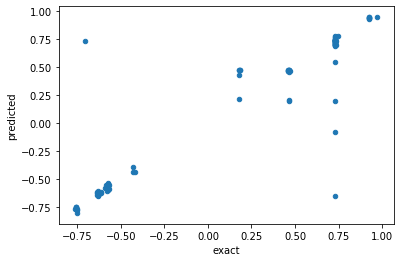

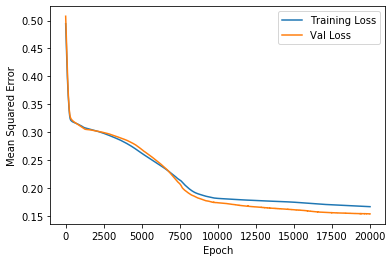

,predicted,exact
0,0.693336,0.732
1,-0.639699,-0.632
2,-0.644493,-0.630
3,-0.764705,-0.756
4,0.469604,0.176


In [105]:
example_mydata = df_testing.sample(frac=0.8,random_state=20)
#run the evaluation
# i checked and they should be correct
example_features = {name:np.array(value) for name, value in example_mydata.items()}
example_label = np.array(example_features.pop(label_name))



predicted = 2*my_model.predict(example_features)-1
predicted=predicted.reshape(len(predicted))
exact = example_mydata["Energy"].to_numpy()*2-1

print(my_model.evaluate(x = example_features, y = example_label, batch_size=batch_size)[0])

df_compare=pd.DataFrame({"predicted":predicted, "exact":exact})

df_compare.plot.scatter(x="exact", y="predicted")
#df_compare.to_csv("first_test.csv")
plot_the_loss_curve(epochs, mse,val_mse)

df_compare.head()
